In [1]:
"""
# ipython_exit.py
Allows exit() to work if script is invoked with IPython without
raising NameError Exception. Keeps kernel alive.

Use: import variable 'exit' in target script with 'from ipython_exit import exit'    
"""

import sys
from io import StringIO
from IPython import get_ipython


class IpyExit(SystemExit):
    """Exit Exception for IPython.

    Exception temporarily redirects stderr to buffer.
    """
    def __init__(self):
        # print("exiting")  # optionally print some message to stdout, too
        # ... or do other stuff before exit
        sys.stderr = StringIO()

    def __del__(self):
        sys.stderr.close()
        sys.stderr = sys.__stderr__  # restore from backup


def ipy_exit():
    raise IpyExit


if get_ipython():    # ...run with IPython
    exit = ipy_exit  # rebind to custom exit
else:
    exit = exit      # just make exit importable

In [2]:
# Loading in all packages
import gimmemotifs
from gimmemotifs.preprocessing import combine_peaks
from gimmemotifs.preprocessing import coverage_table
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import seaborn as sns
import subprocess as sp
import qnorm  # either add qnorm to the yml, or run conda install qnorm in the env
import gseapy as gp
from gseapy.plot import barplot, dotplot
import itertools
import ipywidgets

os.chdir("/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/markdown_notebooks/scripts")
from Python_scripts import bedtool_closest
from Python_scripts import coverage_table_normalization
from Python_scripts import genome_TSS_annotation
from Python_scripts import genome_TSS_annotation_prom
from Python_scripts import make_autopct
from Python_scripts import summits_2_regions
from Python_scripts import distance_weight

plt.style.use("classic")
%matplotlib inline
#%load_ext nb_black
#%reload_ext nb_black
os.chdir("/ceph/rimlsfnwi/data/moldevbio/zhou/jsmits/tools/scripts")
from Python_scripts import TSS_to_region

In [3]:
# specifying classes
class analysis:
    """contains all the first steps of my general analysis, including reading a filepath file, config file, and
    exporting those and the conda environment to a logdir.
    
    required input:
    datapaths_file, a tsv file containing all the other filepaths needed in the subsequent analysis
    config_file, a tsv file containing all type of settings and paramters
    output_dir, where to store the output generated by the analysis, it will generate 
    a log and figure dir in this ouput dir
    """

    def __init__(self, datapaths_file: str, config_file: str, output_dir: str, notebook_file: str):
        self.datapaths_file = datapaths_file
        self.config_file = config_file
        self.output_dir = output_dir
        self.files = pd.read_table(
            self.datapaths_file, sep="\t", comment="#", index_col=0, header = 0
        )
        self.config = pd.read_table(
            self.config_file, sep="\t", comment="#", index_col=0, header = 0
        )
        self.notebook_file = notebook_file
        self.logdir = f"{self.output_dir}/logs"
        self.figdir = f"{self.output_dir}/figures"
        self.trackhubdir = f"{self.output_dir}/trackhub"
        self.tmpdir = f"{self.output_dir}/tmp"
        Path(self.tmpdir).mkdir(parents=True, exist_ok=True)
        Path(self.logdir).mkdir(parents=True, exist_ok=True)
        Path(self.figdir).mkdir(parents=True, exist_ok=True)
        Path(self.trackhubdir).mkdir(parents=True, exist_ok=True)


    def save_settings(self, conda_path):
        """save the config and files to the logs, and make a copy of the conda env that his analysis
        is ran in. Takes a full path to the conda env location as input"""
        #save the conda environment
        !{conda_path} list > {self.logdir}/conda_env.txt
        # save both the files and settings of this run to the output_dir
        self.files.T.to_csv(f"{self.logdir}/filepaths.tsv", header=False, sep="\t")
        self.config.to_csv(f"{self.logdir}/config.tsv", header=False, sep="\t")
        
class general_bedfile_functions:
    """general functions for working with bedfiles & Chromosome coordinates"""

    def filter_bedfile(
        self,
        list_chroms_to_remove: list,
        output_name: str = None,
        bedfile: str = None,
        bed_object: str = None,
        filter_column: str = "Chrom",
        file_output=False,
        return_output=False,
    ):
        """takes a bedfile with x columns and filter to remove a specific list of strings from a column
        if there is no string given, it will try to use the class object df bed.df instead"""
        if bedfile == None:
            bed_df = self.bed_df
        else:
            bed_df = pd.read_table(bedfile, header=None)

        bed_df = bed_df[
            ~bed_df[filter_column].str.contains("|".join(list_chroms_to_remove))
        ]
        if file_output == True:
            bed_df.to_csv(
                f"{self.output_dir}/{output_name}.bed",
                sep="\t",
                header=False,
                index=False,
            )
        if return_output == True:
            return bed_df

class identify_prom_windows(analysis, general_bedfile_functions):
    """identify TSS based promoter windows
    """

    def __init__(self, *args, **kwargs):
        analysis.__init__(self,*args, **kwargs)

    def filter_gtf_file(
        self,
        gtf_file_name: str = "genome_gtf",
        filter_column: int = 17,
        regex: [str] = '";protein_coding"',
        skip_lines: int = 5,
        rerun: bool = False,
    ):
        """filter a (ensembl) gtf file for only containing data of specific transcripts (e.g. genes)
        name of the gtf file in the filepath file
        column to use for filtering (default 17, for ensembl protein coding)
        regex: regex string to keep.
        skip lines: skip the first x lines for skipping meta data of a gtf file
        rerun: rerun if file already excists
        """
        # first check if the filtered gtf file already exists
        self.filtered_gtf = f"{self.tmpdir}/filtered_annotation.gtf"
        if not os.path.exists(self.filtered_gtf) or rerun == True:
            print("filtering GTF_file")
            gtf_file = self.files.loc[gtf_file_name, :].file_location
            Path(f"{self.filtered_gtf}").touch()
            os.remove(f"{self.filtered_gtf}")
            with open(f"{self.filtered_gtf}", "a") as output_gtf:
                with open(gtf_file) as f:
                    for _ in range(skip_lines):
                        next(f)
                    for full_line in f:
                        line = full_line.strip()
                        line = line.split()
                        if str(line[filter_column]) == regex:
                            output_gtf.write(full_line)
        else:
            print('reusing previously filtered gtf file')
        

    def make_TSS_window(
        self,
        TSS_file: str,
        sense_antisense_column: int = 6,
        gene_name_column: int = 13,
        chrom_columnn: int = 0,
        chromstart_columnn: int = 3,
        chromend_columnn: int = 4,
        region_upstream: int = 2000,
        region_downstream: int = 2000,
        rerun=False,
    ):
        """
        Takes a genome gtf TSS file as input, with column info regarding sense/antisense, chr, chrstart, chrend, and
        finally how far up or downstream the window needs to be elongated.
        and returns a smaller gtf file containing only the coordinates of the specified TSS region and the gene name.
        """
        # first check if the filtered gtf file already exists
        print("windowing TSS file")
        tempfile = f"{self.output_dir}/temp_TSS_window.txt"
        Path(tempfile).touch()
        os.remove(f"{tempfile}")

        with open(f"{tempfile}", "a") as output_gtf:
            with open(TSS_file) as f:
                for line in f:
                    line = line.strip()
                    line = line.split()
                    # calculate the adjusted start and stop coordinates, if smaller than 0, make it 1
                    if line[sense_antisense_column] == "+":
                        chromstart = int(line[chromstart_columnn]) - int(
                            region_upstream
                        )
                        if chromstart <= 0:
                            chromstart = 1
                        chromend = (int(line[chromstart_columnn]) + 1) + int(
                            region_downstream
                        )
                    elif line[sense_antisense_column] == "-":
                        chromstart = int(line[chromend_columnn]) - int(
                            region_downstream
                        )
                        if chromstart <= 0:
                            chromstart = 1
                        chromend = (
                            int(line[chromend_columnn]) - 1 + int(region_upstream)
                        )
                        chromstart_temp = chromstart
                        chromstart = chromend
                        chromend = chromstart_temp
                        

                    output_gtf.write(
                        str(line[chrom_columnn])
                        + "\t"
                        + str(chromstart)
                        + "\t"
                        + str(chromend)
                        + "\t"
                        + str(line[sense_antisense_column])
                        + "\t"
                        + str(line[gene_name_column].rstrip(";"))
                        + "\n"
                    )
        tempfilesorted = f"{self.output_dir}/temp_TSS_window_s.txt"
        Path(tempfilesorted).touch()
        os.remove(f"{tempfilesorted}")

        if region_upstream == 0 & region_downstream == 0:
            self.bed_df = pd.read_table(tempfile, header=None, names = ['Chrom','ChromStart','ChromEnd','strand','gene'])
        else:
            sp.check_call(
                f"nice -5 bedtools sort " f"-i {tempfile} " f"> {tempfilesorted}",
                shell=True,
                
            )
            self.bed_df = pd.read_table(tempfilesorted, header=None, names = ['Chrom','ChromStart','ChromEnd','strand','gene'])
            os.remove(tempfilesorted)
        os.remove(tempfile)

class Identify_differential_CREs(identify_prom_windows):
    """Identify variable CRE elements in my analysis"""

    def __init__(self, *args, **kwargs):
        analysis.__init__(self, *args, **kwargs)

    def quantify_histon_mod(
        self,
        regions,
        bamfiles,
        output_file=None,
        alter_window=False,
        extend_start=0,
        extend_end=0,
        rerun=False,
        colnames="bamfiles",
        coverage_window=200,
    ):
        """quantify the ammount of signal in regions in a bedfile/bedobject within a list of bamfiles.
        Optionally you can modify the chromstart and chromend coordinates of the bedfile using alter_window
        and giving a extend_start and extend end number in bp"""
        print("doing stuff")
        if rerun == True or ((output_file != None) & (not os.path.exists(output_file))):
            print("quantifying histone mod")
            if alter_window == True:
                print("resize regions")
                regions["ChromStart"] = regions["ChromStart"].astype(int) - extend_start
                regions["ChromEnd"] = regions["ChromEnd"].astype(int) + extend_end

            regions.to_csv(
                f"{self.tmpdir}/window_regions_quantwindow.bed",
                sep="\t",
                header=False,
                index=False,
            )

            reads_table = coverage_table(
                peakfile=f"{self.tmpdir}/window_regions_quantwindow.bed",
                datafiles=bamfiles,
                window=int(coverage_window),
                log_transform=False,
                ncpus=int(self.config.loc["ncores", :].vallue),
            )
            

            if colnames != "bamfiles":
                print("replacing column names")
                reads_table.columns = colnames
                
            reads_table = reads_table.drop_duplicates()
            reads_table = reads_table.astype(int)
            reads_table.insert(loc=0, column='region', value=reads_table.index)

            if output_file != None:
                reads_table.to_csv(
                    f"{output_file}",
                    sep="\t",
                    header=True,
                    index=False,
                )
            return reads_table
        
        if rerun == False and ((output_file != None) & (os.path.exists(output_file))):
            print('using previously generated table')
            reads_table = pd.read_table(f"{output_file}",sep="\t",index_col = 0)        
            return reads_table



In [8]:
ID_CREs = Identify_differential_CREs(
    datapaths_file="/ceph/rimlsfnwi/data/moldevbio/zhou/jarts/data/lako2021/merge_peaks/files.tsv",
    config_file="/ceph/rimlsfnwi/data/moldevbio/zhou/jarts/data/lako2021/merge_peaks/config.tsv",
    output_dir="/ceph/rimlsfnwi/data/moldevbio/zhou/jarts/data/lako2021/merge_peaks/2021-07-07",
    notebook_file="/ceph/rimlsfnwi/data/moldevbio/zhou/jarts/jupyter_notebooks/Combine_peaks.ipynb",
)

ID_CREs.main_dir = (
    "/ceph/rimlsfnwi/data/moldevbio/zhou/jarts/data/lako2021/merge_peaks/"
)
#ID_CREs.save_settings("/vol/mbconda/jsmits/condabin/conda")

In [4]:
# checking distance within narrowPeak file
data1 = pd.read_csv('/ceph/rimlsfnwi/data/moldevbio/zhou/jarts/data/macs2check/joined.narrowPeak', sep='\t')
data1

,1,634104,634314,LSCatac2_peak_2,86,.,8.10811,12.6976,8.65086,104,1.1,633738,633954,LSCatac2_peak_1,86.1,..1,8.10811.1,12.6976.1,8.65086.1,109
0,1,778337,779148,LSCatac2_peak_3,50,.,5.84416,8.17876,5.05594,197.00000,1,634104.0,634314.0,LSCatac2_peak_2,86.0,.,8.10811,12.69760,8.65086,104.0
1,1,827269,827772,LSCatac2_peak_4,55,.,6.16438,8.77436,5.53119,149.00000,1,778337.0,779148.0,LSCatac2_peak_3,50.0,.,5.84416,8.17876,5.05594,197.0
2,1,959054,959565,LSCatac2_peak_5,58,.,5.85586,9.16210,5.84227,141.00000,1,827269.0,827772.0,LSCatac2_peak_4,55.0,.,6.16438,8.77436,5.53119,149.0
3,1,966219,966460,LSCatac2_peak_6,37,.,4.22078,6.49378,3.71407,177.00000,1,959054.0,959565.0,LSCatac2_peak_5,58.0,.,5.85586,9.16210,5.84227,141.0
4,1,966702,967303,LSCatac2_peak_7,50,.,4.83871,8.13469,5.02447,496.00000,1,966219.0,966460.0,LSCatac2_peak_6,37.0,.,4.22078,6.49378,3.71407,177.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44202,X,155612275,155612634,LSCatac2_peak_44205,40,.,5.13079,6.91019,4.04247,168.00000,X,155216460.0,155216691.0,LSCatac2_peak_44204,52.0,.,5.88235,8.38440,5.21929,180.0
44203,X,155767710,155767910,LSCatac2_peak_44206,26,.,4.16667,5.15975,2.65021,49.00000,X,155612275.0,155612634.0,LSCatac2_peak_44205,40.0,.,5.13079,6.91019,4.04247,168.0
44204,X,155819989,155820223,LSCatac2_peak_44207,40,.,5.13079,6.91019,4.04247,121.00000,X,155767710.0,155767910.0,LSCatac2_peak_44206,26.0,.,4.16667,5.15975,2.65021,49.0
44205,X,155880941,155881574,LSCatac2_peak_44208,58,.,6.32911,9.15396,5.83751,452.00000,X,155819989.0,155820223.0,LSCatac2_peak_44207,40.0,.,5.13079,6.91019,4.04247,121.0


In [17]:
data2 = data1["634314"] - data1["633954"]

In [70]:
data2 = data2[0:44206]

print(', '.join([str(x) for x in data2]))
list1 = [
144834.0, 48624.0, 131793.0, 6895.0, 843.0, 9234.0, 37296.0, 6315.0, 13290.0, 7187.0, 453.0, 38812.0, 36812.0, 5901.0, 35306.0, 5192.0, 38428.0, 30553.0, 26613.0, 6521.0, 9082.0, 17658.0, 33211.0, 19884.0, 30695.0, 24277.0, 7284.0, 354.0, 26078.0, 38276.0, 33047.0, 320.0, 7011.0, 42941.0, 19580.0, 40892.0, 43657.0, 27302.0, 38032.0, 21709.0, 162591.0, 10943.0, 23178.0, 16959.0, 9401.0, 75476.0, 5655.0, 82864.0, 1952.0, 4710.0, 280.0, 49410.0, 5455.0, 17669.0, 15037.0, 18424.0, 52848.0, 82833.0, 9851.0, 36597.0, 21540.0, 2097.0, 74622.0, 8083.0, 291.0, 26692.0, 25139.0, 56429.0, 670104.0, 141129.0, 18996.0, 8947.0, 142513.0, 24805.0, 49094.0, 18432.0, 29978.0, 24924.0, 24053.0, 367.0, 60883.0, 43186.0, 452.0, 749595.0, 18203.0, 168799.0, 362.0, 364.0, 586499.0, 227096.0, 395.0, 340180.0, 23423.0, 9342.0, 102072.0, 30472.0, 41878.0, 20415.0, 15760.0, 9274.0, 22586.0, 26794.0, 6742.0, 354.0, 23701.0, 301.0, 17616.0, 390.0, 24030.0, 18257.0, 7748.0, 20521.0, 404.0, 105068.0, 34531.0, 306.0, 25492.0, 1882.0, 19368.0, 12368.0, 11521.0, 76490.0, 41974.0, 279.0, 9180.0, 426.0, 17409.0, 14523.0, 133300.0, 107203.0, 383.0, 83713.0, 7935.0, 147916.0, 51283.0, 17334.0, 306.0, 67346.0, 68893.0, 55536.0, 23090.0, 154536.0, 451.0, 41295.0, 25057.0, 13036.0, 101598.0, 68349.0, 7553.0, 13487.0, 7020.0, 6668.0, 16166.0, 21368.0, 14150.0, 7053.0, 8294.0, 14639.0, 7587.0, 12262.0, 7296.0, 36274.0, 35654.0, 12573.0, 19971.0, 10087.0, 12563.0, 149110.0, 8237.0, 15078.0, 59357.0, 26479.0, 42811.0, 14707.0, 14841.0, 106156.0, 41411.0, 423.0, 23228.0, 13455.0, 49479.0, 268.0, 28037.0, 30868.0, 22802.0, 6594.0, 12166.0, 13493.0, 38349.0, 44244.0, 94565.0, 30041.0, 17993.0, 621.0, 52176.0, 53061.0, 32436.0, 13283.0, 19768.0, 2975.0, 17929.0, 400.0, 10012.0, 81827.0, 15662.0, 44236.0, 3176.0, 62955.0, 15784.0, 33510.0, 5197.0, 50979.0, 26711.0, 28642.0, 18740.0, 250.0, 39618.0, 8248.0, 8852.0, 22360.0, 25620.0, 1523.0, 11148.0, 41427.0, 12167.0, 20594.0, 32600.0, 7085.0, 82503.0, 31101.0, 19212.0, 24863.0, 21011.0, 292.0, 66207.0, 14484.0, 393.0, 167851.0, 20594.0, 31515.0, 28753.0, 13010.0, 352.0, 23611.0, 14132.0, 374.0, 17366.0, 515.0, 70780.0, 36384.0, 160614.0, 8052.0, 20287.0, 412.0, 41819.0, 23646.0, 298.0, 9227.0, 354.0, 740.0, 64508.0, 10193.0, 36939.0, 47382.0, 38980.0, 626.0, 18985.0, 39724.0, 104250.0, 10501.0, 43657.0, 161984.0, 52104.0, 19513.0, 113635.0, 17332.0, 54291.0, 949.0, 69289.0, 88014.0, 14570.0, 724.0, 17035.0, 8169.0, 45682.0, 21829.0, 17178.0, 124554.0, 86182.0, 2385.0, 153902.0, 50555.0, 41597.0, 2510.0, 20553.0, 48494.0, 23770.0, 22210.0, 8547.0, 6050.0, 7569.0, 1045.0, 39637.0, 925439.0, 3182.0, 12535.0, 64299.0, 423.0, 19544.0, 16395.0, 48360.0, 404.0, 49228.0, 338635.0, 262.0, 421.0, 52739.0, 110932.0, 18709.0, 51974.0, 69138.0, 76121.0, 3077.0, 2054.0, 219872.0, 181491.0, 22665.0, 21621.0, 184932.0, 15132.0, 251.0, 4185.0, 6106.0, 21786.0, 46252.0, 25315.0, 348.0, 10682.0, 21548.0, 32967.0, 62651.0, 301.0, 16894.0, 1241.0, 14041.0, 91672.0, 2148.0, 32589.0, 44182.0, 14182.0, 62606.0, 463.0, 465.0, 22086.0, 38220.0, 24004.0, 378.0, 22408.0, 434.0, 6393.0, 52148.0, 39075.0, 36732.0, 268.0, 25960.0, 26508.0, 56655.0, 23380.0, 21098.0, 68379.0, 13609.0, 14585.0, 8074.0, 6379.0, 18620.0, 10817.0, 19108.0, 597.0, 17573.0, 45765.0, 20711.0, 31355.0, 14139.0, 866.0, 18958.0, 9893.0, 325.0, 43811.0, 58263.0, 635.0, 14479.0, 6531.0, 93094.0, 7287.0, 271.0, 3068.0, 19728.0, 832.0, 82521.0, 145111.0, 346.0, 16927.0, 6161.0, 394.0, 317.0, 7938.0, 690.0, 8867.0, 15376.0, 19289.0, 36066.0, 18995.0, 242.0, 7894.0, 33990.0, 8033.0, 5534.0, 69088.0, 86630.0, 18377.0, 367.0, 16531.0, 8106.0, 6770.0, 11106.0, 10702.0, 11047.0, 5956.0, 44066.0, 20998.0, 74096.0, 17290.0, 15289.0, 15698.0, 28604.0, 19518.0, 14146.0, 5709.0, 306653.0, 7903.0, 723201.0, 71274.0, 334.0, 206117.0, 11110.0, 16716.0, 24111.0, 10323.0, 19115.0, 382.0, 41362.0, 318.0, 12758.0, 17992.0, 4473.0, 40983.0, 518.0, 135172.0, 30661.0, 10560.0, 60156.0, 26754.0, 22524.0, 256.0, 6120.0, 73210.0, 10392.0, 34763.0, 110829.0, 456.0, 21169.0, 21838.0, 13534.0, 51084.0, 10671.0, 455.0, 49939.0, 34090.0, 72135.0, 6084.0, 4258.0, 21053.0, 45716.0, 203057.0, 203848.0, 55433.0, 15649.0, 69287.0, 11417.0, 371.0, 67331.0, 13333.0, 15496.0, 9464.0, 19773.0, 28053.0, 35238.0, 20911.0, 14188.0, 386.0, 559.0, 406.0, 53453.0, 42807.0, 192885.0, 60874.0, 66321.0, 27356.0, 24034.0, 372.0, 30699.0, 113004.0, 607.0, 33155.0, 60994.0, 282.0, 128164.0, 39578.0, 14699.0, 25305.0, 11416.0, 32751.0, 72882.0, 18303.0, 5077.0, 81274.0, 400.0, 21894.0, 13172.0, 28518.0, 22474.0, 1124.0, 8967.0, 39376.0, 13657.0, 6423.0, 19333.0, 7726.0, 407.0, 16854.0, 67661.0, 34537.0, 282.0, 12890.0, 235026.0, 31669.0, 105806.0, 132023.0, 60676.0, 10937.0, 47127.0, 23742.0, 144640.0, 33892.0, 8175.0, 108007.0, 41442.0, 9107.0, 11187.0, 390.0, 7905.0, 147452.0, 23674.0, 647.0, 8550.0, 26169.0, 310.0, 48262.0, 21087.0, 11321.0, 12676.0, 31081.0, 2681.0, 9011.0, 19282.0, 26281.0, 7327.0, 815.0, 25986.0, 71765.0, 86965.0, 12410.0, 9784.0, 24537.0, 40528.0, 2381.0, 90993.0, 374.0, 385.0, 20789.0, 65542.0, 24877.0, 37980.0, 11183.0, 30486.0, 45098.0, 40801.0, 343.0, 57252.0, 544.0, 15256.0, 9492.0, 45996.0, 9556.0, 17105.0, 23306.0, 87200.0, 13152.0, 78582.0, 48741.0, 40725.0, 38700.0, 22909.0, 102930.0, 106778.0, 77154.0, 107850.0, 92020.0, 396.0, 701.0, 6815.0, 7142.0, 436.0, 90758.0, 5597.0, 6499.0, 80012.0, 356.0, 112741.0, 5979.0, 7033.0, 12139.0, 47592.0, 417.0, 79377.0, 11853.0, 477.0, 15590.0, 389.0, 95317.0, 313.0, 39506.0, 15361.0, 248.0, 496.0, 14689.0, 2202.0, 13516.0, 353.0, 91755.0, 37327.0, 75606.0, 1002.0, 11259.0, 46540.0, 11942.0, 19261.0, 33070.0, 44419.0, 28007.0, 29479.0, 340.0, 15323.0, 20412.0, 6129.0, 9181.0, 29407.0, 308.0, 15039.0, 40551.0, 27941.0, 23382.0, 5535.0, 381.0, 1340.0, 89238.0, 622.0, 56438.0, 14610.0, 467.0, 359.0, 30618.0, 10390.0, 10119.0, 10053.0, 17240.0, 16494.0, 38288.0, 23229.0, 9531.0, 6054.0, 7364.0, 5654.0, 11787.0, 4566.0, 5964.0, 21186.0, 38854.0, 32925.0, 6101.0, 13123.0, 5854.0, 13149.0, 39461.0, 41277.0, 42792.0, 6261.0, 326.0, 30831.0, 41465.0, 580.0, 12644.0, 52453.0, 22614.0, 19353.0, 1370.0, 546.0, 5891.0, 15919.0, 527.0, 719.0, 16436.0, 9369.0, 26020.0, 37137.0, 8337.0, 25948.0, 446.0, 289.0, 13629.0, 18185.0, 19794.0, 14865.0, 454.0, 10997.0, 56830.0, 34393.0, 12147.0, 53769.0, 318.0, 47287.0, 57108.0, 431.0, 83760.0, 20460.0, 24469.0, 393.0, 105819.0, 22964.0, 16570.0, 5476.0, 12803.0, 5785.0, 6234.0, 8799.0, 395.0, 48777.0, 39124.0, 3371.0, 10910.0, 306.0, 1477.0, 10337.0, 390.0, 54374.0, 15162.0, 12688.0, 27965.0, 22517.0, 25347.0, 20173.0, 431.0, 79736.0, 276.0, 34426.0, 498.0, 28926.0, 60831.0, 395.0, 5750.0, 19480.0, 68369.0, 560.0, 37945.0, 111443.0, 27467.0, 58359.0, 209430.0, 20687.0, 258.0, 27626.0, 426.0, 71194.0, 78478.0, 11255.0, 83382.0, 94541.0, 14151.0, 6715.0, 49437.0, 69656.0, 83018.0, 181341.0, 326.0, 109394.0, 295239.0, 132696.0, 272.0, 11119.0, 95190.0, 31257.0, 68649.0, 287.0, 29705.0, 8442.0, 52968.0, 14513.0, 347.0, 34130.0, 75349.0, 73189.0, 348.0, 5798.0, 34328.0, 18067.0, 23743.0, 13082.0, 51812.0, 655.0, 7803.0, 7678.0, 406.0, 11260.0, 114659.0, 97894.0, 5640.0, 77168.0, 5616.0, 398.0, 47720.0, 17712.0, 14148.0, 12623.0, 5984.0, 62800.0, 661.0, 44835.0, 11088.0, 87136.0, 646.0, 9866.0, 16875.0, 27601.0, 95341.0, 16186.0, 1019.0, 337.0, 7906.0, 49726.0, 49344.0, 3230.0, 6158.0, 421.0, 35300.0, 25343.0, 46540.0, 35674.0, 6520.0, 13577.0, 373.0, 55670.0, 59649.0, 43158.0, 6217.0, 63335.0, 266.0, 35929.0, 290.0, 19497.0, 322.0, 91398.0, 343.0, 38319.0, 506.0, 52504.0, 12685.0, 473.0, 8464.0, 28507.0, 704.0, 5340.0, 12960.0, 323.0, 44357.0, 281.0, 146706.0, 8198.0, 8572.0, 11283.0, 12294.0, 2504.0, 29640.0, 44112.0, 18399.0, 20833.0, 7126.0, 12813.0, 40747.0, 661.0, 39608.0, 106577.0, 22077.0, 80748.0, 401.0, 2693.0, 6195.0, 32609.0, 1282616.0, 265.0, 7213.0, 791.0, 30246.0, 423.0, 58630.0, 7044.0, 6387.0, 165672.0, 15049.0, 395.0, 31690.0, 364.0, 5987.0, 107578.0, 355.0, 75397.0, 179873.0, 108918.0, 84071.0, 77117.0, 8371.0, 42169.0, 465.0, 279.0, 65244.0, 47930.0, 48060.0, 103475.0, 54194.0, 10897.0, 9116.0, 24497.0, 1611.0, 14747.0, 6016.0, 6539.0, 8898.0, 16800.0, 36637.0, 292.0, 23627.0, 9852.0, 41921.0, 6669.0, 35969.0, 7737.0, 22940.0, 295.0, 518.0, 295.0, 10809.0, 671.0, 416.0, 10994.0, 354.0, 27983.0, 11060.0, 13114.0, 471.0, 13522.0, 47644.0, 289.0, 936397.0, 417.0, 6121.0, 24489.0, 7710.0, 27689.0, 39224.0, 22360.0, 257.0, 19012.0, 245.0, 38699.0, 55849.0, 1971.0, 48550.0, 66741.0, 726.0, 51258.0, 59272.0, 12465.0, 285.0, 1129.0, 57290.0, 5864.0, 16643.0, 51640.0, 53199.0, 8784.0, 12474.0, 720894.0, 235.0, 13651.0, 67979.0, 356.0, 9002.0, 7932.0, 3040.0, 29238.0, 34723.0, 537.0, 71970.0, 5073.0, 39309.0, 16257.0, 24782.0, 8578.0, 12342.0, 53984.0, 17291.0, 122447.0, 10278.0, 130345.0, 20132.0, 17452.0, 29534.0, 113671.0, 18598.0, 400.0, 60901.0, 349.0, 45493.0, 37536.0, 9870.0, 9127.0, 17258.0, 14699.0, 784.0, 8451.0, 549.0, 11368.0, 14881.0, 6932.0, 5102.0, 22639.0, 10237.0, 338.0, 25070.0, 12762.0, 6116.0, 17545.0, 20039.0, 388.0, 10125.0, 359.0, 36080.0, 17203.0, 273.0, 80234.0, 384.0, 16140.0, 45392.0, 11725.0, 58158.0, 339.0, 819.0, 75622.0, 26984.0, 31769.0, 22398.0, 308.0, 97119.0, 6016.0, 57318.0, 16878.0, 27165.0, 66424.0, 59570.0, 6044.0, 7437.0, 5724.0, 8676.0, 9785.0, 49304.0, 18949.0, 11937.0, 27463.0, 38535.0, 63273.0, 263.0, 494.0, 13306.0, 237870.0, 57528.0, 522.0, 13337.0, 246.0, 71500.0, 69659.0, 52849.0, 45570.0, 70103.0, 24957.0, 15894.0, 19850.0, 48188.0, 103376.0, 80924.0, 399.0, 107064.0, 63124.0, 76802.0, 51819.0, 458.0, 104701.0, 16150.0, 334.0, 6643.0, 66944.0, 128228.0, 23619.0, 61523.0, 23761.0, 49474.0, 627.0, 28858.0, 267.0, 77916.0, 34242.0, 8351.0, 54885.0, 369.0, 26663.0, 9517.0, 6791.0, 71067.0, 16799.0, 18951.0, 361.0, 26597.0, 400.0, 7643.0, 20085.0, 58187.0, 507.0, 63370.0, 9400.0, 391.0, 9190.0, 5134.0, 16636.0, 33965.0, 29761.0, 19028.0, 50564.0, 27092.0, 14086.0, 17960.0, 20529.0, 41304.0, 5458.0, 423.0, 16823.0, 40249.0, 303.0, 3791.0, 52087.0, 11141.0, 9522.0, 37887.0, 14754.0, 21869.0, 9634.0, 11456.0, 5788.0, 27215.0, 360.0, 2006.0, 6690.0, 15661.0, 9447.0, 23269.0, 4820.0, 16821.0, 38520.0, 183262.0, 114621.0, 26882.0, 49880.0, 127117.0, 13890.0, 73504.0, 9842.0, 2440.0, 556.0, 5029.0, 36598.0, 849.0, 32704.0, 7451.0, 6595.0, 483.0, 9178.0, 8343.0, 349.0, 35507.0, 241.0, 10593.0, 7659.0, 6181.0, 7562.0, 12406.0, 15776.0, 7158.0, 38285.0, 105547.0, 25458.0, 6327.0, 333.0, 284982.0, 36304.0, 404.0, 41001.0, 21952.0, 88015.0, 8721.0, 21380.0, 449.0, 29007.0, 1040.0, 5501.0, 12331.0, 13680.0, 954.0, 28545.0, 323.0, 72830.0, 1080.0, 884.0, 62569.0, 52446.0, 78553.0, 93058.0, 33975.0, 123973.0, 389.0, 50324.0, 15012.0, 48835.0, 316.0, 41407.0, 13986.0, 570.0, 29675.0, 7532.0, 7489.0, 22186.0, 23834.0, 7819.0, 202163.0, 7731.0, 31440.0, 24519.0, 51336.0, 6129.0, 32010.0, 421857.0, 10973.0, 124059.0, 11040.0, 359.0, 7733.0, 394.0, 477.0, 54628.0, 20435.0, 23011.0, 4891.0, 381.0, 123567.0, 442.0, 8312.0, 80095.0, 376.0, 113207.0, 63371.0, 67821.0, 102895.0, 21196.0, 74583.0, 108638.0, 269860.0, 147200.0, 349.0, 258839.0, 53110.0, 231537.0, 188570.0, 376593.0, 640066.0, 235048.0, 17765.0, 339240.0, 7853.0, 461.0, 94651.0, 7383.0, 144134.0, 472.0, 20914.0, 77898.0, 306.0, 204002.0, 876.0, 24388.0, 15079.0, 11336.0, 22479.0, 24457.0, 5165.0, 14695.0, 357.0, 7435.0, 16124.0, 550.0, 25025.0, 42954.0, 352.0, 6915.0, 142427.0, 18759.0, 50641.0, 77649.0, 7471.0, 9316.0, 12386.0, 1114.0, 83648.0, 69557.0, 29037.0, 57658.0, 69919.0, 38079.0, 309.0, 40147.0, 107452.0, 22552.0, 58381.0, 26389.0, 26606.0, 11846.0, 5118.0, 23365.0, 116442.0, 78520.0, 5879.0, 120593.0, 98498.0, 74286.0, 18022.0, 34733.0, 381.0, 20611.0, 31846.0, 55648.0, 11612.0, 19914.0, 159150.0, 44897.0, 67893.0, 47734.0, 6271.0, 15302.0, 83698.0, 51487.0, 487.0, 17211.0, 38594.0, 10869.0, 43086.0, 16051.0, 37397.0, 27919.0, 40007.0, 46163.0, 337.0, 31746.0, 414.0, 72875.0, 50148.0, 430.0, 11971.0, 152560.0, 54505.0, 39148.0, 90208.0, 43840.0, 48804.0, 34348.0, 1934.0, 371.0, 85221.0, 698.0, 35795.0, 27907.0, 20314.0, 50591.0, 396.0, 192951.0, 62514.0, 32733.0, 381.0, 43095.0, 21924.0, 53641.0, 1029961.0, 47738.0, 9692.0, 257.0, 16511.0, 45794.0, 108897.0, 342.0, 143452.0, 5439.0, 136997.0, 150039.0, 309.0, 155528.0, 38616.0, 104572.0, 168459.0, 40570.0, 78490.0, 120696.0, 13065.0, 334.0, 3395.0, 12495.0, 201728.0, 324897.0, 7804.0, 37457.0, 95650.0, 17768.0, 379.0, 30483.0, 7450.0, 7983.0, 25821.0, 34163.0, 47134.0, 27722.0, 27735.0, 399.0, 7019.0, 21631.0, 25088.0, 6601.0, 7450.0, 25591.0, 6426.0, 27666.0, 290.0, 20089.0, 19006.0, 10388.0, 80398.0, 43817.0, 50290.0, 35593.0, 8234.0, 145657.0, 32645.0, 45952.0, 51678.0, 17811.0, 10327.0, 31935.0, 12159.0, 97017.0, 372.0, 76221.0, 997.0, 76478.0, 445.0, 8632.0, 55134.0, 259.0, 18965.0, 92535.0, 20627.0, 323.0, 280336.0, 53823.0, 287360.0, 435.0, 266482.0, 106652.0, 100589.0, 7025.0, 27575.0, 63708.0, 375.0, 61462.0, 120506.0, 6622.0, 8015.0, 95878.0, 19032.0, 19741.0, 8463.0, 37742.0, 87516.0, 9628.0, 71525.0, 37287.0, 17178.0, 12023.0, 83413.0, 128802.0, 26612.0, 52114.0, 31190.0, 45809.0, 8781.0, 99845.0, 94359.0, 11892.0, 381.0, 18651.0, 42253.0, 8742.0, 29663.0, 185163.0, 60612.0, 5457.0, 24584.0, 3525.0, 67837.0, 533080.0, 50431.0, 155984.0, 24192.0, 46119.0, 489.0, 67700.0, 598.0, 451.0, 68332.0, 128284.0, 8702.0, 52184.0, 63142.0, 16399.0, 39551.0, 72288.0, 529.0, 6004.0, 14688.0, 38597.0, 12151.0, 79509.0, 45285.0, 433.0, 34515.0, 126320.0, 347.0, 14410.0, 21284.0, 92051.0, 146710.0, 79183.0, 73875.0, 338.0, 366.0, 18785.0, 31585.0, 17557.0, 16405.0, 6730.0, 12668.0, 453.0, 65274.0, 73547.0, 6141.0, 26701.0, 73335.0, 6205.0, 412.0, 55183.0, 111004.0, 5209.0, 827642.0, 8924.0, 9210.0, 60362.0, 271.0, 104145.0, 331.0, 28084.0, 251.0, 56857.0, 17364.0, 319.0, 24701.0, 161774.0, 105631.0, 93371.0, 409.0, 4469.0, 474.0, 14132.0, 108999.0, 304.0, 6734.0, 102600.0, 67285.0, 76941.0, 26078.0, 309.0, 14744.0, 7252.0, 412.0, 10658.0, 23516.0, 9939.0, 30544.0, 69434.0, 30708.0, 30838.0, 8819.0, 5360.0, 42677.0, 8037.0, 58405.0, 38793.0, 12303.0, 13856.0, 9727.0, 6751.0, 4479.0, 20958.0, 23590.0, 30819.0, 310.0, 36580.0, 11899.0, 26393.0, 48723.0, 142525.0, 271916.0, 417.0, 58135.0, 10181.0, 43407.0, 9617.0, 9892.0, 12141.0, 526557.0, 378042.0, 41825.0, 19463.0, 19453.0, 53414.0, 126869.0, 8046.0, 335712.0, 53094.0, 114330.0, 335.0, 15888.0, 132473.0, 754.0, 56124.0, 319.0, 15337.0, 344.0, 60464.0, 22803.0, 18717.0, 520976.0, 31153.0, 5198.0, 976166.0, 220511.0, 1658.0, 127599.0, 19859.0, 1132462.0, 29169.0, 371.0, 604175.0, 454524.0, 40886.0, 39273.0, 240.0, 343.0, 939478.0, 51374.0, 360.0, 20630.0, 20681.0, 20158.0, 68829.0, 109528.0, 59764.0, 50627.0, 419843.0, 454937.0, 49235.0, 40716.0, 347.0, 27871.0, 151571.0, 62625.0, 40367.0, 360283.0, 808.0, 75990.0, 19799.0, 555.0, 45425.0, 49682.0, 13596.0, 1035.0, 89638.0, 24604.0, 712.0, 29170.0, 361.0, 12189.0, 24728.0, 21920.0, 21382.0, 58009.0, 131464.0, 36590.0, 150778.0, 264623.0, 85145.0, 239143.0, 25682.0, 87512.0, 130237.0, 730840.0, 10089.0, 353518.0, 756763.0, 11484.0, 323399.0, 189780.0, 32516.0, 145174.0, 262902.0, 232032.0, 5024.0, 15736.0, 94222.0, 78460.0, 566052.0, 729173.0, 40007.0, 849.0, 110703.0, 66053.0, 11321.0, 18148.0, 48875.0, 17884.0, 79560.0, 44500.0, 2715.0, 64587.0, 36402.0, 39902.0, 337.0, 36848.0, 26967.0, 67842.0, 8893.0, 21042.0, 405.0, 16362.0, 13739.0, 452.0, 55608.0, 7848.0, 51525.0, 22595.0, 61917.0, 714.0, 7462.0, 11558.0, 325.0, 5200.0, 47538.0, 258.0, 15603.0, 21656.0, 103427.0, 13951.0, 25746.0, 113478.0, 23814.0, 6721.0, 27689.0, 16990.0, 12710.0, 392.0, 8360.0, 10213.0, 5494.0, 372.0, 16217.0, 8933.0, 26919.0, 41065.0, 38824.0, 5338.0, 43809.0, 488.0, 48897.0, 11649.0, 51054.0, 4755.0, 96468.0, 141528.0, 287189.0, 12221.0, 245972.0, 426.0, 425.0, 27785.0, 6046.0, 87065.0, 25527.0, 4023.0, 90218.0, 11425.0, 56067.0, 329.0, 293.0, 69355.0, 6322.0, 133389.0, 395.0, 178550.0, 26611.0, 21220.0, 11024.0, 74441.0, 23496.0, 37247.0, 41308.0, 64341.0, 6282.0, 392.0, 24264.0, 11666.0, 14069.0, 346015.0, 10335.0, 63973.0, 58011.0, 28076.0, 7786.0, 37659.0, 11976.0, 47892.0, 266411.0, 246.0, 295470.0, 34917.0, 25458.0, 464.0, 400.0, 89470.0, 117178.0, 445.0, 93217.0, 8161.0, 28821.0, 43117.0, 60821.0, 72671.0, 73370.0, 91568.0, 433.0, 89416.0, 11959.0, 59673.0, 22970.0, 4949.0, 79921.0, 255.0, 39048.0, 38081.0, 14795.0, 14477.0, 23464.0, 4936.0, 40734.0, 12026.0, 5951.0, 16893.0, 275.0, 11922.0, 10302.0, 19093.0, 5427.0, 16043.0, 348.0, 46307.0, 319.0, 41719.0, 138127.0, 29045.0, 240695.0, 243.0, 2647.0, 609273.0, 6920.0, 260439.0, 121556.0, 386.0, 96625.0, 68870.0, 12516.0, 26862.0, 41536.0, 86019.0, 8883.0, 58569.0, 40642.0, 402.0, 18991.0, 21576.0, 194594.0, 218432.0, 30663.0, 237567.0, 10140.0, 284.0, 6534.0, 201036.0, 19658.0, 3392.0, 23293.0, 698.0, 15811.0, 10920.0, 50416.0, 40784.0, 22947.0, 105662.0, 64212.0, 36453.0, 1189.0, 143942.0, 476.0, 13250.0, 247.0, 7324.0, 96191.0, 77601.0, 47556.0, 56854.0, 40432.0, 16896.0, 11619.0, 442.0, 8466.0, 36621.0, 41497.0, 67226.0, 31908.0, 30422.0, 69484.0, 9812.0, 56740.0, 36094.0, 21726.0, 134201.0, 9769.0, 52917.0, 25439.0, 9896.0, 82637.0, 109254.0, 14299.0, 38166.0, 42904.0, 19286.0, 4148.0, 1610.0, 540.0, 5619.0, 22734.0, 32846.0, 4138.0, 14278.0, 64193.0, 9856.0, 52763.0, 7597.0, 1493.0, 11511.0, 637.0, 50530.0, 47981.0, 64848.0, 33357.0, 43973.0, 80923.0, 36389.0, 320301.0, 29956.0, 66294.0, 65561.0, 6905.0, 19624.0, 493239.0, 151981.0, 28124.0, 57433.0, 376.0, 86373.0, 161266.0, 602.0, 372206.0, 98269.0, 84949.0, 405.0, 642937.0, 17030.0, 115909.0, 32551.0, 325.0, 123086.0, 394.0, 113236.0, 2654.0, 335066.0, 634.0, 77706.0, 402.0, 163469.0, 88058.0, 188875.0, 84063.0, 192874.0, 108713.0, 14664.0, 19107.0, 22045.0, 24104.0, 118176.0, 2143.0, 42499.0, 5475.0, 35432.0, 313.0, 120284.0, 67862.0, 13835.0, 81049.0, 116852.0, 16287.0, 85154.0, 1010.0, 149904.0, 333376.0, 355.0, 48159.0, 10767.0, 817.0, 368.0, 53203.0, 415.0, 76150.0, 49855.0, 75088.0, 23848.0, 25648.0, 415.0, 156812.0, 138726.0, 1383215.0, 62388.0, 167010.0, 20710.0, 395991.0, 579.0, 3094265.0, 322.0, 134796.0, 335.0, 12519.0, 158362.0, 10185.0, 61643.0, 57721.0, 369.0, 473.0, 19865.0, 63024.0, 12820.0, 97494.0, 12724.0, 268194.0, 5190.0, 11298.0, 24669.0, 469.0, 75365.0, 29536.0, 112359.0, 146669.0, 54714.0, 18462.0, 6616.0, 55842.0, 46169.0, 63670.0, 269.0, 17680.0, 352.0, 359070.0, 366.0, 131991.0, 311.0, 54727.0, 69156.0, 12148.0, 48149.0, 638.0, 86085.0, 65321.0, 13541.0, 8410.0, 25481.0, 14919.0, 9182.0, 97463.0, 16420.0, 11933.0, 422.0, 13643.0, 909.0, 16259.0, 6285.0, 11277.0, 8205.0, 599.0, 10638.0, 132399.0, 57598.0, 9991.0, 5893.0, 32085.0, 16028.0, 474.0, 21654.0, 50444.0, 47232.0, 224907.0, 36411.0, 55128.0, 463.0, 19056.0, 30724.0, 115865.0, 46553.0, 32498.0, 6399.0, 24038.0, 32264.0, 47129.0, 67997.0, 5243.0, 64910.0, 18618.0, 59200.0, 63876.0, 11689.0, 15189.0, 270861.0, 47156.0, 176304.0, 63713.0, 5229.0, 13382.0, 5532.0, 118036.0, 320.0, 102795.0, 58945.0, 7674.0, 36979.0, 354.0, 39281.0, 526.0, 26678.0, 84785.0, 341.0, 33696.0, 504.0, 16593.0, 192570.0, 488.0, 113013.0, 257627.0, 15715.0, 23806.0, 10815.0, 24501.0, 1521.0, 305.0, 47965.0, 57905.0, 20757.0, 21404.0, 61571.0, 14012.0, 54727.0, 12759.0, 17955.0, 9928.0, 345.0, 93597.0, 94837.0, 51466.0, 557.0, 414.0, 65506.0, 13360.0, 7627.0, 30354.0, 174505.0, 60494.0, 81796.0, 504.0, 66637.0, 76852.0, 7990.0, 110951.0, 10629.0, 14185.0, 81476.0, 53190.0, 92823.0, 12688.0, 11414.0, 370.0, 49323.0, 36278.0, 17424.0, 50489.0, 199753.0, 37812.0, 25878.0, 163987.0, 532.0, 70527.0, 29333.0, 7803.0, 51532.0, 46053.0, 40734.0, 1002.0, 22494.0, 22521.0, 24933.0, 223978.0, 10727.0, 95552.0, 9952.0, 552.0, 21405.0, 19799.0, 500.0, 12266.0, 71180.0, 6425.0, 37348.0, 74042.0, 58076.0, 25607.0, 1699.0, 12800.0, 13816.0, 22339.0, 49808.0, 12046.0, 33551.0, 434.0, 13106.0, 389.0, 23683.0, 1095.0, 34487.0, 31458.0, 25802.0, 11104.0, 193421.0, 849.0, 132518.0, 21794.0, 7141.0, 13045.0, 160161.0, 21916.0, 7012.0, 35269.0, 28284.0, 405.0, 93948.0, 10212.0, 6155.0, 22207.0, 276.0, 15805.0, 3183.0, 14093.0, 123191.0, 2528.0, 23938.0, 88282.0, 8690.0, 2714.0, 6973.0, 46697.0, 5454.0, 7019.0, 86100.0, 34664.0, 44331.0, 8987.0, 17077.0, 15572.0, 325.0, 28549.0, 247.0, 88821.0, 156031.0, 392.0, 167549.0, 70612.0, 401.0, 152880.0, 36657.0, 31148.0, 102674.0, 414.0, 280174.0, 930516.0, 311.0, 113784.0, 24691.0, 442.0, 5820.0, 73083.0, 5955.0, 9119.0, 102073.0, 292.0, 73784.0, 33239.0, 30884.0, 17476.0, 16899.0, 25986.0, 1215.0, 11325.0, 15388.0, 9971.0, 235.0, 70427.0, 301.0, 25647.0, 51003.0, 124820.0, 2707.0, 188921.0, 395.0, 178040.0, 489651.0, 6587.0, 91540.0, 74151.0, 168008.0, 232840.0, 26822.0, 75199.0, 38895.0, 330.0, 15338.0, 22161972.0, 676706.0, 133415.0, 5801.0, 729259.0, 144147.0, 332.0, 39792.0, 225289.0, 15798.0, 14751.0, 61280.0, 41630.0, 21358.0, 13218.0, 1092.0, 26092.0, 6186.0, 26378.0, 509.0, 8550.0, 30152.0, 6839.0, 15087.0, 16753.0, 41535.0, 14305.0, 324849.0, 10366.0, 22629.0, 502717.0, 171313.0, 447.0, 7365.0, 75237.0, 398.0, 4715.0, 70379.0, 427.0, 21110.0, 28528.0, 202410.0, 46117.0, 3713.0, 55134.0, 40859.0, 29686.0, 46145.0, 372.0, 211171.0, 110356.0, 113204.0, 111974.0, 1140.0, 15230.0, 400.0, 22683.0, 5255.0, 403.0, 25821.0, 18688.0, 9028.0, 243.0, 26150.0, 13631.0, 120182.0, 1035701.0, 78389.0, 71898.0, 177786.0, 1370.0, 259.0, 11555.0, 28163.0, 11357.0, 56483.0, 71388.0, 328.0, 82400.0, 13124.0, 6168.0, 44603.0, 22300.0, 24085.0, 2457.0, 5825.0, 390.0, 346.0, 12487.0, 419.0, 318.0, 11559.0, 27387.0, 254.0, 42160.0, 361.0, 666.0, 112901.0, 374.0, 9044.0, 340.0, 28244.0, 22204.0, 391.0, 22860.0, 471.0, 6660.0, 11189.0, 25487.0, 6860.0, 1596.0, 16062.0, 322.0, 31555.0, 36048.0, 179539.0, 45903.0, 3223.0, 55218.0, 27062.0, 14408.0, 11365.0, 14628.0, 22188.0, 36300.0, 24224.0, 15436.0, 18225.0, 608.0, 315.0, 5980.0, 331.0, 17598.0, 64830.0, 12883.0, 14687.0, 18765.0, 10740.0, 15645.0, 357.0, 19625.0, 52060.0, 58758.0, 947.0, 80752.0, 396.0, 7050.0, 27421.0, 11017.0, 8482.0, 17753.0, 68652.0, 82460.0, 405.0, 10402.0, 16838.0, 96458.0, 21900.0, 498.0, 36856.0, 55057.0, 22897.0, 10271.0, 2319.0, 10797.0, 425.0, 119383.0, 405.0, 15253.0, 42454.0, 26639.0, 122716.0, 11728.0, 115720.0, 4409.0, 10695.0, 62857.0, 137536.0, 425.0, 25165.0, 8747.0, 22431.0, 31578.0, 4879.0, 59887.0, 34892.0, 436.0, 34722.0, 13017.0, 5847.0, 6908.0, 356.0, 65755.0, 13527.0, 53766.0, 22894.0, 51197.0, 48453.0, 152432.0, 257.0, 76942.0, 37878.0, 35383.0, 405.0, 660.0, 6641.0, 346.0, 2000.0, 8944.0, 400.0, 15291.0, 5940.0, 42630.0, 17976.0, 426.0, 6851.0, 24364.0, 12785.0, 6321.0, 50091.0, 47855.0, 7706.0, 97585.0, 42061.0, 23260.0, 11998.0, 332.0, 8754.0, 10307.0, 8521.0, 196109.0, 946.0, 13675.0, 23253.0, 306.0, 51795.0, 306.0, 52114.0, 66430.0, 14165.0, 13191.0, 12684.0, 2010.0, 125698.0, 8962.0, 39943.0, 19889.0, 185583.0, 379.0, 56257.0, 67273.0, 24317.0, 13016.0, 8250.0, 459.0, 18881.0, 15373.0, 20901.0, 311.0, 11971.0, 34397.0, 263.0, 5854.0, 38323.0, 5342.0, 393.0, 32698.0, 4920.0, 426.0, 20117.0, 15408.0, 18740.0, 17149.0, 10735.0, 6653.0, 353.0, 10942.0, 3789.0, 31616.0, 15273.0, 238998.0, 46674.0, 291.0, 38479.0, 40144.0, 56935.0, 14545.0, 96833.0, 2035.0, 34749.0, 40401.0, 366.0, 27589.0, 58491.0, 33206.0, 450.0, 440.0, 5974.0, 21774.0, 8494.0, 5363.0, 17990.0, 1657.0, 14118.0, 63912.0, 18937.0, 49745.0, 19909.0, 238.0, 8314.0, 252.0, 46643.0, 390.0, 330.0, 18335.0, 41072.0, 366.0, 47054.0, 11071.0, 520.0, 43912.0, 3944.0, 67456.0, 18816.0, 390.0, 9741.0, 1270.0, 57396.0, 24479.0, 7282.0, 12929.0, 23979.0, 12492.0, 5550.0, 5065.0, 15594.0, 29614.0, 73481.0, 26295.0, 23307.0, 125291.0, 407.0, 28456.0, 15929.0, 16268.0, 26227.0, 5297.0, 525.0, 252263.0, 471387.0, 100045.0, 6449.0, 355.0, 47656.0, 12455.0, 95588.0, 325.0, 21447.0, 386.0, 30938.0, 738090.0, 53764.0, 30135.0, 54404.0, 37255.0, 50159.0, 19135.0, 400.0, 16193.0, 84050.0, 347.0, 336282.0, 182808.0, 100788.0, 10002.0, 8453.0, 25048.0, 314.0, 20577.0, 14790.0, 70727.0, 524.0, 51980.0, 40886.0, 68226.0, 25960.0, 42552.0, 472.0, 22550.0, 6671.0, 51911.0, 64922.0, 7994.0, 265351.0, 45169.0, 40743.0, 535.0, 44984.0, 315.0, 182669.0, 17538.0, 412.0, 7427.0, 11470.0, 5771.0, 6931.0, 395.0, 29147.0, 8089.0, 415.0, 5170.0, 455.0, 25915.0, 2925.0, 14748.0, 20864.0, 5801.0, 6810.0, 11055.0, 15289.0, 9335.0, 346.0, 7263.0, 16379.0, 18795.0, 61384.0, 8193.0, 53502.0, 22247.0, 9588.0, 22380.0, 5693.0, 12650.0, 41430.0, 5308.0, 37224.0, 6432.0, 395.0, 8855.0, 72702.0, 8714.0, 303.0, 25627.0, 59411.0, 23292.0, 13823.0, 6098.0, 42569.0, 169721.0, 61783.0, 30880.0, 14872.0, 67061.0, 30351.0, 135853.0, 7465.0, 9215.0, 30290.0, 147562.0, 41523.0, 2802.0, 19739.0, 22189.0, 21387.0, 8349.0, 77088.0, 415.0, 5221.0, 209498.0, 7312.0, 290.0, 74587.0, 48018.0, 35651.0, 250162.0, 502308.0, 734674.0, 42911.0, 11191.0, 279.0, 46759.0, 112505.0, 15074.0, 328923.0, 46177.0, 213733.0, 44086.0, 61521.0, 99073.0, 17191.0, 32580.0, 376.0, 523.0, 66585.0, 19369.0, 51320.0, 4154.0, 54397.0, 786.0, 75443.0, 935671.0, 36920.0, 8016.0, 17657.0, 142106.0, 50915.0, 26257.0, 40102.0, 59393.0, 153303.0, 68148.0, 24978.0, 66633.0, 10715.0, 8809.0, 9192.0, 54219.0, 45939.0, 409.0, 44556.0, 300.0, 6689.0, 422.0, 6336.0, 671.0, 18989.0, 11971.0, 29681.0, 284.0, 6584.0, 681.0, 6860.0, 22829.0, 116160.0, 176994.0, 65937.0, 46917.0, 75911.0, 19033.0, 21848.0, 66168.0, 45239.0, 16776.0, 5416.0, 441.0, 29493.0, 122541.0, 8120.0, 73057.0, 9147.0, 310.0, 43351.0, 130260.0, 98718.0, 68309.0, 45641.0, 7930.0, 47644.0, 41569.0, 164483.0, 433.0, 117457.0, 670.0, 42967.0, 10262.0, 45414.0, 196801.0, 13533.0, 99008.0, 168961.0, 11721.0, 51936.0, 405776.0, 30446.0, 20153.0, 125174.0, 221737.0, 29612.0, 206693.0, 349.0, 52985.0, 94570.0, 124145.0, 29988.0, 17248.0, 424.0, 99573.0, 156248.0, 16380.0, 23441.0, 28171.0, 8091.0, 23687.0, 57468.0, 125357.0, 599.0, 15780.0, 93460.0, 12472.0, 108113.0, 392.0, 67366.0, 19924.0, 1128.0, 15285.0, 58812.0, 14092.0, 12350.0, 15873.0, 16384.0, 20802.0, 16368.0, 19556.0, 106059.0, 347.0, 59779.0, 19945.0, 25873.0, 1052.0, 80118.0, 11893.0, 21055.0, 58523.0, 478.0, 15821.0, 39500.0, 3817.0, 25659.0, 258.0, 49425.0, 9700.0, 51093.0, 9700.0, 38841.0, 28400.0, 286330.0, 519.0, 30042.0, 47402.0, 160261.0, 83038.0, 310.0, 26228.0, 43110.0, 915.0, 78068.0, 75447.0, 18120.0, 390.0, 118884.0, 62753.0, 184333.0, 128031.0, 125293.0, 128949.0, 7128.0, 3341.0, 393.0, 15177.0, 4086.0, 53921.0, 91473.0, 12480.0, 13682.0, 9318.0, 23367.0, 6345.0, 116803.0, 23049.0, 23073.0, 29530.0, 349.0, 46512.0, 408.0, 93763.0, 108139.0, 48870.0, 28865.0, 49228.0, 453862.0, 21389.0, 133494.0, 357.0, 33910.0, 400.0, 206967.0, 66613.0, 17240.0, 306.0, 34670.0, 89205.0, 201011.0, 305.0, 131039.0, 192730.0, 27834.0, 45731.0, 368.0, 27225.0, 109428.0, 193442.0, 214706.0, 302.0, 46926.0, 499.0, 24965.0, 302.0, 42109.0, 11417.0, 294.0, 18870.0, 29863.0, 10101.0, 19045.0, 6181.0, 20416.0, 6086.0, 23222.0, 32725.0, 32850.0, 459.0, 65560.0, 27595.0, 18389.0, 332.0, 55843.0, 16042.0, 12997.0, 73730.0, 104028.0, 28256.0, 398.0, 6726.0, 5862.0, 19790.0, 46142.0, 2052.0, 22152.0, 22931.0, 28648.0, 375.0, 40571.0, 582.0, 299509.0, 325.0, 358.0, 12671.0, 43226.0, 42907.0, 18116.0, 86927.0, 63480.0, 16981.0, 394.0, 55038.0, 185475.0, 34810.0, 120314.0, 70550.0, 32843.0, 67637.0, 5160.0, 43515.0, 28497.0, 168967.0, 30837.0, 13398.0, 192214.0, 142496.0, 384.0, 12885.0, 5780.0, 539.0, 49781.0, 13680.0, 848.0, 27942.0, 320.0, 17299.0, 48569.0, 146658.0, 54579.0, 41537.0, 29991.0, 69486.0, 9975.0, 11705.0, 33952.0, 10152.0, 10735.0, 5628.0, 7343.0, 307.0, 6742.0, 39769.0, 443.0, 7022.0, 84455.0, 4552.0, 169280.0, 116700.0, 105946.0, 120706.0, 261637.0, 57843.0, 473.0, 12887.0, 403.0, 42783.0, 41792.0, 279.0, 31678.0, 18289.0, 53809.0, 101211.0, 463.0, 54314.0, 142679.0, 26322.0, 28394.0, 364.0, 145700.0, 12387.0, 30997.0, 5743.0, 854.0, 122769.0, 337.0, 5381.0, 54360.0, 17275.0, 20708.0, 24657.0, 9075.0, 65788.0, 5171.0, 15414.0, 5297.0, 363.0, 12248.0, 36145.0, 33300.0, 408.0, 11481.0, 12093.0, 26331.0, 114121.0, 21950.0, 17699.0, 42790.0, 85261.0, 22869.0, 12992.0, 121313.0, 56069.0, 68550.0, 33987.0, 26966.0, 342.0, 108512.0, 66122.0, 362.0, 94491.0, 211691.0, 67316.0, 54019.0, 66318.0, 143246.0, 37180.0, 379.0, 35041.0, 10956.0, 28213.0, 87525.0, 90747.0, 51041.0, 60882.0, 86965.0, 72780.0, 690.0, 83531.0, 11477.0, 87051.0, 383.0, 20388.0, 44945.0, 71649.0, 9223.0, 242.0, 72409.0, 131276.0, 14462.0, 376.0, 194565.0, 118897.0, 9683.0, 48826.0, 138780.0, 183497.0, 339.0, 46223.0, 74658.0, 56593.0, 12926.0, 109061.0, 16740.0, 12481.0, 86285.0, 26723.0, 202083.0, 487857.0, 151305.0, 395.0, 184723.0, 209867.0, 1369414.0, 9738.0, 1247736.0, 39759.0, 704225.0, 524982.0, 356489.0, 41323.0, 13642.0, 34555.0, 121378.0, 82789.0, 4407.0, 21010.0, 18208.0, 4673.0, 61106.0, 166143.0, 821.0, 44797.0, 635.0, 6439.0, 10157.0, 89394.0, 135671.0, 71268.0, 19626.0, 2154183.0, 71585.0, 127967.0, 400.0, 166327.0, 22716.0, 460.0, 21515.0, 40023.0, 62922.0, 54539.0, 20800.0, 470219.0, 28330.0, 460228.0, 6585.0, 54634.0, 155717.0, 326908.0, 12452.0, 40127.0, 308.0, 38799.0, 426.0, 7376.0, 55557.0, 30042.0, 33806.0, 115936.0, 45507.0, 148222.0, 282.0, 45561.0, 11010.0, 174145.0, 21827.0, 30962.0, 172646.0, 12940.0, 94524.0, 60868.0, 13025.0, 86757.0, 335734.0, 340447.0, 145668.0, 333.0, 15278.0, 81063.0, 295153.0, 33590.0, 21831.0, 73742.0, 130185.0, 5954.0, 29011.0, 32670.0, 5888.0, 136844.0, 302.0, 18971.0, 14706.0, 4577.0, 346.0, 10399.0, 292.0, 4662.0, 9045.0, 24800.0, 30747.0, 32362.0, 141130.0, 201479.0, 39559.0, 339.0, 339.0, 16010.0, 354.0, 14162.0, 44986.0, 29989.0, 7960.0, 7332.0, 14576.0, 5815.0, 3938.0, 2744.0, 8356.0, 8145.0, 16408.0, 100480.0, 12139.0, 13710.0, 7542.0, 7162.0, 4207.0, 8445.0, 499.0, 16114.0, 53892.0, 267.0, 90415.0, 64216.0, 5308.0, 246.0, 19449.0, 35422.0, 10634.0, 43676.0, 20740.0, 32963.0, 14116.0, 58693.0, 16756.0, 10859.0, 16569.0, 18974.0, 4358.0, 6112.0, 5249.0, 12358.0, 9927.0, 269.0, 48542.0, 13086.0, 16583.0, 78740.0, 8213.0, 7154.0, 6765.0, 47300.0, 8799.0, 49767.0, 6667.0, 251168.0, 25352.0, 87757.0, 123385.0, 7900.0, 17448.0, 27091.0, 356.0, 37970.0, 31273.0, 6415.0, 2425.0, 39677.0, 485.0, 18697.0, 128365.0, 134918.0, 15658.0, 373.0, 21652.0, 420.0, 160097.0, 25355.0, 21748.0, 23477.0, 409.0, 35080.0, 8434.0, 34002.0, 14417.0, 13011.0, 10393.0, 19049.0, 58304.0, 18073.0, 254.0, 25933.0, 65028.0, 907.0, 27286.0, 18378.0, 19200.0, 131243.0, 15530.0, 7035.0, 74291.0, 8149.0, 9287.0, 26831.0, 15084.0, 12345.0, 62183.0, 5919.0, 7155.0, 62093.0, 48115.0, 292.0, 5437.0, 21173.0, 323.0, 4471.0, 395.0, 338.0, 35958.0, 14747.0, 11498.0, 414.0, 9731.0, 192301.0, 98090.0, 382.0, 108494.0, 380.0, 73302.0, 72448.0, 60592.0, 19067.0, 31428.0, 2814.0, 35970.0, 15321.0, 31675.0, 502.0, 25391.0, 399.0, 13472.0, 19589.0, 23052.0, 33856.0, 66485.0, 8874.0, 27421.0, 3982.0, 11354.0, 35708.0, 14756.0, 263.0, 48377.0, 39570.0, 280.0, 117618.0, 668.0, 15636.0, 9604.0, 29986.0, 7715.0, 149917.0, 402.0, 20531.0, 46478.0, 45470.0, 30733.0, 96101.0, 351.0, 216338.0, 22449.0, 48002.0, 14067.0, 9606.0, 76518.0, 22454.0, 20991.0, 325.0, 1114.0, 487.0, 28825.0, 10228.0, 442.0, 10563.0, 24421.0, 155223.0, 8509.0, 21411.0, 481.0, 9862.0, 3772.0, 43061.0, 55165.0, 13011.0, 6901.0, 5433.0, 20336.0, 187718.0, 80659.0, 68318.0, 3583.0, 310.0, 11145.0, 174376.0, 128235.0, 44495.0, 71991.0, 7990.0, 16118.0, 21104.0, 15984.0, 78376.0, 58043.0, 64792.0, 21265.0, 336.0, 24274.0, 29496.0, 5274.0, 17474.0, 24701.0, 10292.0, 11526.0, 12980.0, 193075.0, 59183.0, 45174.0, 266142.0, 109963.0, 17505.0, 104045.0, 547.0, 5745.0, 6028.0, 44890.0, 94147.0, 39252.0, 36966.0, 58634.0, 323.0, 38971.0, 24635.0, 9482.0, 5075.0, 12494.0, 16634.0, 52441.0, 19830.0, 37322.0, 34346.0, 80490.0, 17592.0, 73019.0, 36738.0, 21310.0, 3538.0, 6699.0, 9365.0, 375.0, 14100.0, 33476.0, 5914.0, 5411.0, 10627.0, 450.0, 4572.0, 263.0, 36933.0, 250323.0, 44305.0, 1040.0, 18132.0, 41075.0, 28734.0, 316.0, 7256.0, 15644.0, 20002.0, 9687.0, 508400.0, 294.0, 251000.0, 125412.0, 61489.0, 61512.0, 571.0, 33947.0, 52984.0, 81897.0, 27568.0, 10617.0, 13259.0, 29680.0, 42871.0, 29466.0, 374.0, 29912.0, 94838.0, 87329.0, 27270.0, 6847.0, 83682.0, 105873.0, 38191.0, 332.0, 8406.0, 46398.0, 26451.0, 24330.0, 82367.0, 34172.0, 12418.0, 18477.0, 36919.0, 7494.0, 8834.0, 72864.0, 7932.0, 29369.0, 12391.0, 56683.0, 6251.0, 27631.0, 92609.0, 65981.0, 487.0, 14813.0, 77548.0, 64419.0, 736.0, 35141.0, 342.0, 391873.0, 366.0, 544646.0, 394.0, 23687.0, 10832.0, 5275.0, 74622.0, 110280.0, 11798.0, 55417.0, 1151.0, 47350.0, 1054.0, 56569.0, 329.0, 7594.0, 9780.0, 639.0, 17581.0, 5414.0, 11337.0, 7551.0, 30429.0, 17651.0, 12283.0, 44660.0, 6316.0, 16623.0, 7003.0, 3137.0, 18152.0, 198313.0, 63921.0, 36162.0, 1314.0, 18581.0, 36092.0, 26795.0, 6076.0, 123887.0, 159699.0, 269014.0, 335.0, 23607.0, 422.0, 64326.0, 145741.0, 215245.0, 13463.0, 39058.0, 446.0, 19195.0, 156566.0, 235221.0, 7902.0, 136355.0, 283891.0, 17697.0, 431.0, 716.0, 26103.0, 435.0, 99290.0, 22619.0, 26215.0, 11412.0, 280126.0, 112708.0, 24534.0, 55354.0, 68655.0, 29554.0, 624215.0, 353.0, 60489.0, 15793.0, 15657.0, 306.0, 20459.0, 12355.0, 15249.0, 51029.0, 3789.0, 16124.0, 306.0, 121119.0, 62317.0, 26142.0, 167935.0, 70657.0, 8440.0, 135718.0, 236075.0, 15956.0, 120228.0, 57237.0, 37451.0, 104954.0, 109978.0, 274.0, 27267.0, 14270.0, 233876.0, 20921.0, 26565.0, 178409.0, 23467.0, 4227.0, 36837.0, 6729.0, 26443.0, 56678.0, 71464.0, 17849.0, 11837.0, 406.0, 161864.0, 42808.0, 15224.0, 671221.0, 291.0, 19988.0, 37998.0, 189820.0, 74302.0, 665.0, 59345.0, 340.0, 7941.0, 6540.0, 285.0, 12649.0, 10176.0, 5781.0, 12929.0, 28671.0, 60491.0, 10579.0, 29259.0, 399.0, 179330.0, 73346.0, 224372.0, 502.0, 55794.0, 25349.0, 35359.0, 7805.0, 27824.0, 16888.0, 9623.0, 67216.0, 1125.0, 375.0, 41646.0, 22890.0, 352.0, 37218.0, 207197.0, 59255.0, 41974.0, 10470.0, 1414.0, 7554.0, 47596.0, 39876.0, 25679.0, 2450.0, 97251.0, 46736.0, 19227.0, 7558.0, 381.0, 70736.0, 421.0, 30773.0, 123465.0, 10781.0, 35289.0, 6567.0, 4443.0, 14654.0, 12687.0, 2463.0, 29803.0, 4119.0, 296.0, 39799.0, 30189.0, 42258.0, 104212.0, 65875.0, 9171.0, 46000.0, 442.0, 18934.0, 49595.0, 646.0, 15451.0, 101467.0, 303.0, 29570.0, 26368.0, 797.0, 20558.0, 57084.0, 19614.0, 44355.0, 5020.0, 9574.0, 29574.0, 22520.0, 27696.0, 59283.0, 198805.0, 71219.0, 7146.0, 420027.0, 29097.0, 279.0, 48416.0, 663.0, 20967.0, 368.0, 59229.0, 191829.0, 35068.0, 357.0, 10716.0, 283.0, 25131.0, 5765.0, 32226.0, 65491.0, 6871.0, 14419.0, 20350.0, 5345.0, 1365.0, 364.0, 8624.0, 30986.0, 12205.0, 22953.0, 400.0, 34919.0, 28316.0, 20903.0, 14083.0, 455.0, 11365.0, 475.0, 5789.0, 5899.0, 5876.0, 59155.0, 122119.0, 456.0, 98753.0, 216676.0, 18514.0, 19741.0, 34065.0, 5937.0, 61059.0, 14487.0, 275.0, 36399.0, 13033.0, 42440.0, 5300.0, 64293.0, 117959.0, 134127.0, 20037.0, 13433.0, 92284.0, 367.0, 38867.0, 185001.0, 284.0, 20940.0, 164612.0, 7085.0, 28695.0, 24213.0, 17851.0, 79883.0, 10163.0, 19386.0, 379.0, 19146.0, 11455.0, 67064.0, 24445.0, 44401.0, 20685.0, 6454.0, 21659.0, 9156.0, 25112.0, 748.0, 7511.0, 39972.0, 386.0, 14758.0, 165067.0, 12772.0, 50823.0, 508.0, 6811.0, 22255.0, 160851.0, 190464.0, 22658.0, 42075.0, 91831.0, 167127.0, 29875.0, 61328.0, 261.0, 14840.0, 259.0, 28073.0, 45909.0, 21310.0, 7917.0, 17308.0, 119292.0, 6155.0, 357.0, 44228.0, 67057.0, 130365.0, 84779.0, 45940.0, 334.0, 159680.0, 19943.0, 17621.0, 20128.0, 8608.0, 8644.0, 63825.0, 57698.0, 116207.0, 66486.0, 115831.0, 8059.0, 92121.0, 225833.0, 48773.0, 62022.0, 37706.0, 10243.0, 144455.0, 45238.0, 24648.0, 95759.0, 457.0, 405.0, 20290.0, 25407.0, 11930.0, 26203.0, 475.0, 106285.0, 62120.0, 13106.0, 22694.0, 130438.0, 49766.0, 21674.0, 100994.0, 1977.0, 211319.0, 79361.0, 96829.0, 16090.0, 194976.0, 45062.0, 55482.0, 88823.0, 86055.0, 48972.0, 14326.0, 685.0, 35368.0, 45501.0, 75224.0, 72548.0, 14770.0, 520.0, 181761.0, 32898.0, 67090.0, 125745.0, 23099.0, 63433.0, 6806.0, 13518.0, 277125.0, 40687.0, 48398.0, 47002.0, 68235.0, 77151.0, 2364.0, 11020.0, 14540.0, 583.0, 95099.0, 5456.0, 41609.0, 16696.0, 59818.0, 44921.0, 508.0, 27055.0, 17867.0, 9506.0, 5606.0, 26035.0, 24595.0, 10476.0, 28312.0, 3400.0, 17812.0, 7841.0, 26643.0, 24857.0, 15134.0, 410.0, 22517.0, 25356.0, 312.0, 113851.0, 12845.0, 26669.0, 36335.0, 18875.0, 16422.0, 870.0, 13721.0, 6143.0, 44018.0, 5628.0, 5632.0, 39993.0, 15337.0, 32374.0, 167332.0, 318.0, 38631.0, 29976.0, 263.0, 6334.0, 11019.0, 27765.0, 26193.0, 35632.0, 27404.0, 401.0, 81184.0, 28703.0, 6677.0, 59329.0, 398.0, 30200.0, 128063.0, 36097.0, 5841.0, 1364.0, 431.0, 6600.0, 15697.0, 10457.0, 28023.0, 248.0, 27524.0, 10383.0, 7210.0, 92273.0, 172456.0, 451.0, 173220.0, 10431.0, 483.0, 6214.0, 30374.0, 444.0, 20581.0, 623.0, 9951.0, 70052.0, 190773.0, 4911.0, 54658.0, 50455.0, 968404.0, 18427.0, 18840.0, 141314.0, 9991.0, 924.0, 462.0, 114045.0, 444.0, 74175.0, 354414.0, 1207611.0, 43811.0, 118327.0, 1543402.0, 11521.0, 27025.0, 24540.0, 9415.0, 13946.0, 2242.0, 31474.0, 300.0, 48783.0, 17951.0, 42191.0, 98608.0, 275.0, 170815.0, 321.0, 186733.0, 423553.0, 181416.0, 13473.0, 430631.0, 451.0, 479.0, 12064.0, 19348.0, 328.0, 6814.0, 19031.0, 93727.0, 14270.0, 79583.0, 94925.0, 62648.0, 75552.0, 64202.0, 286.0, 51866.0, 66663.0, 27277.0, 103387.0, 511.0, 115692.0, 33919.0, 41426.0, 34379.0, 25637.0, 3308.0, 19957.0, 18710.0, 264.0, 12112.0, 17707.0, 281.0, 67388.0, 11984.0, 831.0, 43846.0, 103770.0, 354.0, 52931.0, 86813.0, 384.0, 39414.0, 55626.0, 298.0, 27763.0, 965.0, 105371.0, 1433.0, 114188.0, 5539.0, 1265.0, 64156.0, 180385.0, 113467.0, 39568.0, 10961.0, 193847.0, 21647.0, 72008.0, 34984.0, 174965.0, 141533.0, 295.0, 2637.0, 23782.0, 270.0, 216852.0, 120103.0, 3622.0, 59398.0, 31017.0, 11502.0, 80632.0, 15466.0, 19198.0, 44180.0, 568.0, 25830.0, 136307.0, 691.0, 75824.0, 330.0, 70692.0, 25222.0, 400.0, 227411.0, 10696.0, 15198.0, 57960.0, 1410550.0, 11557.0, 489.0, 355.0, 4459.0, 15966.0, 3948.0, 11164.0, 32501.0, -248833080.0, 38889.0, 23322.0, 72610.0, 30649.0, 84966.0, 5109.0, 419.0, 8741.0, 146898.0, 26097.0, 273539.0, 137131.0, 9803.0, 54576.0, 1655.0, 398.0, 47687.0, 348.0, 12732.0, 7360.0, 53808.0, 179189.0, 397.0, 74517.0, 101359.0, 135338.0, 114950.0, 8930.0, 386732.0, 493.0, 5506.0, 1672.0, 46372.0, 421.0, 35938.0, 353.0, 11696.0, 8273.0, 39664.0, 327.0, 21580.0, 665677.0, 386.0, 30776.0, 86488.0, 6937.0, 16952.0, 4261.0, 11999.0, 65642.0, 24397.0, 29333.0, 275.0, 21514.0, 75289.0, 6854.0, 124648.0, 16991.0, 5414.0, 4269.0, 384.0, 50512.0, 102463.0, 33133.0, 47325.0, 24402.0, 9469.0, 7959.0, 5525.0, 22084.0, 24542.0, 385.0, 9750.0, 334.0, 4949.0, 27099.0, 35557.0, 10651.0, 25495.0, 354.0, 70584.0, 79477.0, 116633.0, 59059.0, 94041.0, 449.0, 63117.0, 133474.0, 121557.0, 459.0, 7761.0, 452.0, 6201.0, 8960.0, 17274.0, 301.0, 28640.0, 302.0, 37732.0, 9739.0, 45889.0, 23163.0, 17140.0, 16270.0, 64360.0, 313.0, 61371.0, 62280.0, 162801.0, 57646.0, 1852.0, 23894.0, 94787.0, 34048.0, 20123.0, 21974.0, 7599.0, 29854.0, 12319.0, 327.0, 12758.0, 14772.0, 17567.0, 1342.0, 11203.0, 387.0, 13227.0, 13298.0, 43294.0, 18176.0, 7992.0, 27586.0, 93243.0, 76686.0, 54011.0, 7013.0, 19797.0, 6123.0, 381.0, 111348.0, 30886.0, 382.0, 16294.0, 8007.0, 402.0, 6423.0, 12504.0, 39082.0, 1387.0, 14783.0, 19892.0, 404.0, 36106.0, 15843.0, 7695.0, 351.0, 102258.0, 21277.0, 330.0, 53611.0, 15229.0, 10026.0, 78214.0, 142050.0, 6530.0, 343.0, 10618.0, 8844.0, 30534.0, 7308.0, 125783.0, 7803.0, 191254.0, 145794.0, 7318.0, 523238.0, 469.0, 30183.0, 119282.0, 115739.0, 77664.0, 28766.0, 113392.0, 59079.0, 33677.0, 23733.0, 45713.0, 108368.0, 12392.0, 37853.0, 24934.0, 138858.0, 72017.0, 239431.0, 185731.0, 306943.0, 34366.0, 724796.0, 284804.0, 188828.0, 10678.0, 25437.0, 35206.0, 45462.0, 105982.0, 353.0, 147006.0, 133113.0, 47637.0, 206549.0, 59503.0, 72923.0, 2944.0, 54606.0, 15557.0, 337.0, 25563.0, 10386.0, 16378.0, 21380.0, 6698.0, 37224.0, 6107.0, 16625.0, 144920.0, 25497.0, 60863.0, 51460.0, 14973.0, 45910.0, 22356.0, 6615.0, 63036.0, 85138.0, 301358.0, 115354.0, 13933.0, 84784.0, 16126.0, 137305.0, 11374.0, 1064.0, 61037.0, 138225.0, 2345.0, 69631.0, 68574.0, 291.0, 9586.0, 107001.0, 29392.0, 253.0, 665.0, 72859.0, 30099.0, 67993.0, 11365.0, 258.0, 17097.0, 182186.0, 15326.0, 89945.0, 110285.0, 730.0, 200658.0, 11014.0, 7911.0, 93835.0, 33743.0, 370.0, 27380.0, 93251.0, 4590.0, 124347.0, 55470.0, 40282.0, 301.0, 75414.0, 5474.0, 53610.0, 301.0, 71029.0, 4164.0, 8378.0, 26804.0, 44336.0, 700.0, 12473.0, 188086.0, 1169.0, 489529.0, 576267.0, 363.0, 84183.0, 76429.0, 46509.0, 353.0, 173271.0, 11055.0, 14598.0, 48765.0, 31611.0, 44899.0, 17930.0, 37058.0, 38714.0, 743.0, 276.0, 12041.0, 343.0, 12919.0, 112492.0, 560.0, 14856.0, 12004.0, 2063.0, 42622.0, 75563.0, 39281.0, 42853.0, 22561.0, 58824.0, 327.0, 104406.0, 521.0, 20162.0, 6054.0, 13197.0, 16695.0, 383.0, 161834.0, 87799.0, 703827.0, 24159.0, 8007.0, 375.0, 7086.0, 14953.0, 31243.0, 589011.0, 352139.0, 395.0, 161320.0, 16897.0, 98350.0, 21066.0, 323837.0, 353802.0, 137056.0, 50101.0, 22035.0, 46512.0, 84101.0, 23628.0, 270698.0, 14298.0, 14054.0, 321.0, 325.0, 22009.0, 293.0, 21242.0, 18529.0, 341.0, 9004.0, 34825.0, 96433.0, 29717.0, 1551.0, 6910.0, 92537.0, 98298.0, 2774.0, 83292.0, 191738.0, 735.0, 225805.0, 17083.0, 422.0, 69610.0, 566.0, 23435.0, 87687.0, 9016.0, 183219.0, 28432.0, 6729.0, 27298.0, 31474.0, 342.0, 102141.0, 6669.0, 229624.0, 23953.0, 81597.0, 156448.0, 17101.0, 19669.0, 8229.0, 13314.0, 11181.0, 47767.0, 6694.0, 569706.0, 243.0, 200945.0, 28815.0, 11217.0, 75327.0, 6113.0, 295.0, 12895.0, 38987.0, 413.0, 31972.0, 12386.0, 6960.0, 21222.0, 1395.0, 8614.0, 17147.0, 35208.0, 124299.0, 56639.0, 6846.0, 18120.0, 90351.0, 5450.0, 29033.0, 8828.0, 14818.0, 29073.0, 6940.0, 35670.0, 17957.0, 261.0, 53532.0, 45639.0, 6050.0, 12476.0, 93501.0, 338.0, 318643.0, 992883.0, 136021.0, 59875.0, 15637.0, 42900.0, 15001.0, 25974.0, 79503.0, 8502.0, 76782.0, 154065.0, 54505.0, 85596.0, 1251.0, 330.0, 10051.0, 395.0, 67568.0, 53585.0, 16801.0, 343.0, 58205.0, 26933.0, 7482.0, 20365.0, 423.0, 103569.0, 13458.0, 121786.0, 58166.0, 64126.0, 212318.0, 440.0, 170192.0, 8665.0, 34992.0, 10914.0, 407.0, 65081.0, 7392.0, 157306.0, 26495.0, 104095.0, 13785.0, 51209.0, 6127.0, 249497.0, 156645.0, 19262.0, 249587.0, 28993.0, 32994.0, 7138.0, 381.0, 16938.0, 80299.0, 13830.0, 8627.0, 1281.0, 20716.0, 9401.0, 16288.0, 12721.0, 9094.0, 401.0, 45448.0, 21201.0, 22257.0, 248.0, 26452.0, 19571.0, 3234.0, 19144.0, 13859.0, 22865.0, 88315.0, 147020.0, 1017.0, 120672.0, 128804.0, 10825.0, 27663.0, 318.0, 45993.0, 13733.0, 43625.0, 191031.0, 5374.0, 8557.0, 289728.0, 45766.0, 581.0, 19385.0, 24052.0, 71443.0, 171345.0, 752.0, 303.0, 425954.0, 360.0, 14549.0, 76565.0, 92060.0, 12047.0, 20600.0, 94486.0, 21659.0, 61798.0, 3614.0, 6552.0, 88313.0, 108423.0, 392.0, 430.0, 32140.0, 34282.0, 32317.0, 298129.0, 214298.0, 3626.0, 18507.0, 25004.0, 26963.0, 80818.0, 12792.0, 261.0, 7962.0, 8746.0, 12893.0, 37480.0, 354.0, 23038.0, 20937.0, 301.0, 10416.0, 15952.0, 8699.0, 17736.0, 23761.0, 20333.0, 31016.0, 11360.0, 35449.0, 8754.0, 31545.0, 55812.0, 508.0, 33463.0, 28552.0, 325717.0, 328.0, 3852.0, 25899.0, 182844.0, 409.0, 46062.0, 298.0, 97591.0, 25889.0, 425.0, 38850.0, 113150.0, 71935.0, 9704.0, 14026.0, 51982.0, 84391.0, 1824.0, 313.0, 35303.0, 17262.0, 24180.0, 310.0, 14526.0, 42948.0, 12699.0, 75332.0, 16718.0, 10092.0, 25508.0, 12417.0, 19582.0, 14979.0, 5591.0, 330.0, 11088.0, 35141.0, 16987.0, 32667.0, 35740.0, 505.0, 294.0, 68616.0, 64114.0, 40411.0, 6885.0, 29284.0, 35815.0, 40964.0, 227817.0, 917.0, 346.0, 141382.0, 38627.0, 527479.0, 103215.0, 16680.0, 64798.0, 245.0, 43665.0, 801702.0, 477695.0, 118872.0, 33978.0, 83643.0, 308546.0, 3964858.0, 184828.0, 362.0, 85686.0, 144399.0, 53824.0, 14303.0, 15392.0, 239.0, 85002.0, 417.0, 8408.0, 65999.0, 111814.0, 149122.0, 17730.0, 35215.0, 411.0, 7414.0, 13633.0, 517.0, 28400.0, 5448.0, 898.0, 10232.0, 1151.0, 376.0, 28178.0, 15129.0, 3592.0, 118642.0, 31726.0, 42709.0, 1215737.0, 14246.0, 80753.0, 21715.0, 19435.0, 449.0, 7461.0, 53231.0, 98303.0, 354223.0, 80122.0, 78197.0, 54473.0, 295943.0, 279.0, 6892.0, 76319.0, 177984.0, 157425.0, 81863.0, 622819.0, 6034.0, 282.0, 30421.0, 433.0, 127997.0, 72445.0, 12073.0, 10612.0, 51590.0, 25094.0, 69521.0, 662054.0, 75057.0, 15988.0, 324.0, 27380.0, 72384.0, 8486.0, 56524.0, 117927.0, 66982.0, 136388.0, 18913.0, 259192.0, 237.0, 316098.0, 10888.0, 20999.0, 55625.0, 46261.0, 18152.0, 11734.0, 1531.0, 16508.0, 423.0, 23868.0, 86381.0, 82404.0, 179794.0, 282705.0, 101114.0, 49616.0, 43235.0, 79303.0, 6064.0, 398.0, 82098.0, 19230.0, 13221.0, 5839.0, 115656.0, 959605.0, 168152.0, 11489.0, 368646.0, 66105.0, 355.0, 4437.0, 68913.0, 55282.0, 409.0, 21236.0, 5289.0, 368.0, 16065.0, 315126.0, 62551.0, 440.0, 19480.0, 72071.0, 300663.0, 58089.0, 9957.0, 32802.0, 241338.0, 67704.0, 237053.0, 806.0, 893174.0, 3483.0, 344926.0, 485137.0, 687882.0, 430.0, 41706.0, 176384.0, 385.0, 1118767.0, 366848.0, 133642.0, 23308.0, 56551.0, 2334.0, 28293.0, 907.0, 65706.0, 904.0, 49846.0, 29086.0, 9766.0, 223591.0, 108070.0, 50955.0, 14088.0, 418.0, 98913.0, 363641.0, 53273.0, 25790.0, 224483.0, 91690.0, 186198.0, 7779.0, 21007.0, 323.0, 12227.0, 58994.0, 25864.0, 131828.0, 159775.0, 116384.0, 81614.0, 130551.0, 121881.0, 14354.0, 241.0, 12470.0, 6639.0, 11505.0, 165650.0, 11775.0, 8138.0, 10370.0, 215966.0, 89521.0, 320.0, 285550.0, 334.0, 62680.0, 33902.0, 97803.0, 19107.0, 111157.0, 48640.0, 4297.0, 104928.0, 27951.0, 166242.0, 7666.0, 341.0, 17807.0, 104889.0, 402.0, 58985.0, 340.0, 299634.0, 71390.0, 11967.0, 1460.0, 315592.0, 83407.0, 364.0, 19287.0, 32448.0, 161132.0, 35524.0, 387.0, 38246.0, 10962.0, 6216.0, 31774.0, 76065.0, 307.0, 573.0, 70124.0, 6856.0, 4977.0, 239.0, 52595.0, 101667.0, 174717.0, 1528969.0, 291093.0, 643779.0, 398.0, 166237.0, 155640.0, 693437.0, 243495.0, 24166.0, 60959.0, 34628.0, 795.0, 190256.0, 18619.0, 12954.0, 29179.0, 17847.0, 71119.0, 6325.0, 100325.0, 499.0, 752.0, 74094.0, 64595.0, 56093.0, 21349.0, 51080.0, 65955.0, 350.0, 54701.0, 75234.0, 559.0, 104000.0, 346.0, 54596.0, 600.0, 31920.0, 541.0, 56920.0, 15689.0, 62649.0, 55884.0, 37322.0, 5148.0, 9748.0, 5591.0, 80541.0, 517.0, 30664.0, 10982.0, 22088.0, 2862.0, 23185.0, 29679.0, 13136.0, 35889.0, 142613.0, 54510.0, 11418.0, 7933.0, 239.0, 24349.0, 404043.0, 14470.0, 23666.0, 61797.0, 1085.0, 33860.0, 311.0, 23220.0, 41017.0, 32641.0, 22872.0, 16308.0, 415.0, 57425.0, 16342.0, 40932.0, 32999.0, 7474.0, 19112.0, 55860.0, 22471.0, 7897.0, 139615.0, 12277.0, 13921.0, 36702.0, 31561.0, 170200.0, 8273.0, 11060.0, 6336.0, 5377.0, 112521.0, 34172.0, 384.0, 8889.0, 63341.0, 57874.0, 109351.0, 7430.0, 28156.0, 191014.0, 516.0, 47290.0, 6151.0, 6773.0, 38339.0, 19974.0, 6358.0, 12464.0, 9226.0, 547.0, 10762.0, 17317.0, 76073.0, 9743.0, 16470.0, 7892.0, 10772.0, 34844.0, 3748.0, 58868.0, 234.0, 1739.0, 348.0, 53740.0, 52753.0, 38901.0, 5558.0, 3234.0, 10182.0, 18531.0, 5358.0, 318.0, 22739.0, 11250.0, 22604.0, 385.0, 9117.0, 261943.0, 50062.0, 369.0, 15540.0, 27623.0, 64735.0, 273.0, 28092.0, 27094.0, 6525.0, 28706.0, 14360.0, 90690.0, 64321.0, 51719.0, 713.0, 71233.0, 41368.0, 37834.0, 5114.0, 9794.0, 96398.0, 18098.0, 36965.0, 305.0, 5213.0, 76493.0, 105827.0, 24186.0, 104387.0, 308.0, 13830.0, 18381.0, 326.0, 9666.0, 9209.0, 3388.0, 26311.0, 8282.0, 7596.0, 21361.0, 25444.0, 367.0, 12957.0, 1221.0, 365.0, 10040.0, 10009.0, 23323.0, 8214.0, 16340.0, 9174.0, 31718.0, 1210.0, 33624.0, 48356.0, 69592.0, 441.0, 25704.0, 13343.0, 33718.0, 42237.0, 27672.0, 180327.0, 28855.0, 296524.0, 26854.0, 44931.0, 46132.0, 193731.0, 76877.0, 16783.0, 3410.0, 1993.0, 24141.0, 1300.0, 15470.0, 43408.0, 500.0, 64196.0, 42187.0, 504.0, 463491.0, 237547.0, 373.0, 46851.0, 107498.0, 72356.0, 22299.0, 79674.0, 59733.0, 91981.0, 423320.0, 104972.0, 48379.0, 5077.0, 66394.0, 59057.0, 59468.0, 326.0, 42326.0, 68288.0, 16703.0, 26596.0, 349.0, 642.0, 8287.0, 17584.0, 61502.0, 70346.0, 29411.0, 9240.0, 9503.0, 26136.0, 8389.0, 390.0, 73728.0, 53415.0, 4019.0, 21129.0, 442.0, 7728.0, 12911.0, 23338.0, 5752.0, 367.0, 9998.0, 66389.0, 3866.0, 4254.0, 147747.0, 15147.0, 377.0, 66626.0, 39704.0, 369599.0, 83807.0, 168780.0, 25253.0, 249.0, 22224.0, 427.0, 95155.0, 15084.0, 18131.0, 10832.0, 354.0, 35319.0, 313.0, 2524.0, 302.0, 5859.0, 63412.0, 21864.0, 21815.0, 21450.0, 12749.0, 22012.0, 10718.0, 1649.0, 16518.0, 96073.0, 8224.0, 13398.0, 94402.0, 395.0, 342454.0, 24566.0, 52187.0, 97103.0, 3528.0, 61834.0, 10986.0, 9955.0, 6593.0, 24918.0, 10873.0, 82295.0, 88370.0, 51498.0, 359.0, 23750.0, 250.0, 415.0, 16936.0, 732.0, 412.0, 33692.0, 29608.0, 343.0, 63488.0, 3540011.0, 326.0, 31640.0, 8125.0, 77466.0, 71636.0, 382.0, 22992.0, 72789.0, 4889.0, 64811.0, 42600.0, 990299.0, 733.0, 114350.0, 757639.0, 382.0, 121247.0, 92350.0, 96677.0, 405.0, 44556.0, 569.0, 182856.0, 19853.0, 12307.0, 48003.0, 65160.0, 9709.0, 411.0, 293.0, 358.0, 246996.0, 243644.0, 73510.0, 31908.0, 70276.0, 56573.0, 43774.0, 447.0, 779.0, 179415.0, 45747.0, 43130.0, 357.0, 21067.0, 45249.0, 56117.0, 131371.0, 88967.0, 3729.0, 21652.0, 82948.0, 68174.0, 159151.0, 10566.0, 14594.0, 16125.0, 29018.0, 51890.0, 19152.0, 38875.0, 497.0, 31535.0, 19801.0, 461.0, 75089.0, 379.0, 28761.0, 16433.0, 43542.0, 34858.0, 10131.0, 26074.0, 49985.0, 23695.0, 401.0, 39973.0, 22404.0, 587.0, 12656.0, 125713.0, 90623.0, 726.0, 284.0, 20133.0, 235.0, 36290.0, 135418.0, 567.0, 24054.0, 59971.0, 85648.0, 44299.0, 127749.0, 345.0, 47494.0, 92320.0, 99395.0, 65275.0, 415.0, 238913.0, 93483.0, 257.0, 16841.0, 13030.0, 10219.0, 14530.0, 58312.0, 233537.0, 56365.0, 532.0, 77749.0, 42576.0, 10173.0, 58151.0, 713.0, 178082.0, 10234.0, 5681.0, 9696.0, 19455.0, 18921.0, 425.0, 824.0, 18703.0, 12014.0, 17089.0, 43789.0, 34215.0, 8619.0, 10552.0, 82119.0, 43631.0, 11981.0, 19091.0, 245590.0, 21917.0, 327.0, 68144.0, 37740.0, 1088.0, 104827.0, 287.0, 138967.0, 17261.0, 330.0, 1346.0, 51496.0, 44614.0, 159296.0, 43657.0, 474.0, 79716.0, 166026.0, 150747.0, 46024.0, 41745.0, 7373.0, 28948.0, 347.0, 23574.0, 1535.0, 274.0, 6437.0, 441.0, 13202.0, 7261.0, 30308.0, 82201.0, 465.0, 123371.0, 44501.0, 146825.0, 60940.0, 161129.0, 67602.0, 250.0, 10621.0, 30296.0, 137865.0, 303.0, 39404.0, 889.0, 438.0, 142138.0, 586958.0, 50994.0, 45751.0, 442.0, 5909.0, 12139.0, 6604.0, 9865.0, 30811.0, 13324.0, 50105.0, 35692.0, 35461.0, 37222.0, 50581.0, 11532.0, 32064.0, 40034.0, 55490.0, 37258.0, 213162.0, 622.0, 109548.0, 25767.0, 315.0, 339.0, 46119.0, 311.0, 34360.0, 5683.0, 99489.0, 41487.0, 103953.0, 255.0, 20728.0, 117534.0, 72864.0, 734.0, 178359.0, 66137.0, 9108.0, 9714.0, 13586.0, 127257.0, 46094.0, 43920.0, 7942.0, 203190.0, 26481.0, 15824.0, 65399.0, 732.0, 11983.0, 13161.0, 20065.0, 51577.0, 966.0, 19580.0, 23778.0, 305.0, 578.0, 258.0, 28669.0, 12304.0, 11548.0, 332.0, 37077.0, 367.0, 7053.0, 8126.0, 280.0, 2559.0, 35661.0, 2093.0, 508.0, 11738.0, 12449.0, 583.0, 4134.0, 17992.0, 55341.0, 47879.0, 364.0, 9370.0, 19847.0, 20130.0, 25285.0, 130702.0, 88996.0, 239689.0, 342.0, 40477.0, 31396.0, 275.0, 14024.0, 6764.0, 928308.0, 35072.0, 129621.0, 60645.0, 38034.0, 7710.0, 5678.0, 345.0, 58821.0, 660.0, 47212.0, 54731.0, 11148.0, 295.0, 60385.0, 351.0, 15201.0, 8805.0, 451.0, 265.0, 52895.0, 21717.0, 3574.0, 91147.0, 48109.0, 8183.0, 28983.0, 43311.0, 38186.0, 18823.0, 474.0, 59872.0, 446.0, 17413.0, 386.0, 8353.0, 418.0, 60207.0, 47463.0, 980.0, 24252.0, 23267.0, 5986.0, 26212.0, 94158.0, 234572.0, 21701.0, 497.0, 74198.0, 357.0, 11577.0, 13902.0, 18145.0, 1241.0, 474.0, 10073.0, 7070.0, 10719.0, 100850.0, 383.0, 28856.0, 22905.0, 7947.0, 109073.0, 23424.0, 13217.0, 409.0, 12436.0, 550.0, 13980.0, 163644.0, 11507.0, 18087.0, 336.0, 36592.0, 69156.0, 89356.0, 35201.0, 12132.0, 178944.0, 263.0, 45605.0, 735.0, 9217.0, 47445.0, 348.0, 19278.0, 438.0, 19307.0, 17026.0, 263.0, 56316.0, 4626.0, 14519.0, 280.0, 22154.0, 16258.0, 27122.0, 31819.0, 1297.0, 34742.0, 15383.0, 303.0, 804.0, 25882.0, 11441.0, 17788.0, 10690.0, 32525.0, 300.0, 8644.0, 53650.0, 27753.0, 20567.0, 69393.0, 22678.0, 17934.0, 14965.0, 14356.0, 9475.0, 16319.0, 13644.0, 71050.0, 63991.0, 196735.0, 77988.0, 38350.0, 10176.0, 13577.0, 18090.0, 77896.0, 17625.0, 27914.0, 94129.0, 1321.0, 35633.0, 71184.0, 77374.0, 20635.0, 48572.0, 12279.0, 14140.0, 448.0, 9263.0, 8025.0, 11329.0, 49325.0, 20482.0, 1592.0, 9603.0, 8425.0, 9817.0, 8278.0, 9954.0, 12620.0, 10515.0, 379.0, 17143.0, 8101.0, 126614.0, 5324.0, 10922.0, 11821.0, 75484.0, 35080.0, 36667.0, 5964.0, 16496.0, 27598.0, 3136.0, 7172.0, 8652.0, 15212.0, 37944.0, 24388.0, 9231.0, 20355.0, 27389.0, 109575.0, 7453.0, 427677.0, 24446.0, 107284.0, 46786.0, 754334.0, 2074.0, 408807.0, 63163.0, 861.0, 11142.0, 4431.0, 66053.0, 283.0, 33634.0, 36899.0, 28796.0, 1752680.0, 1525253.0, 10128.0, 18579.0, 10126.0, 267.0, 84097.0, 270.0, 68945.0, 134236.0, 15310.0, 52936.0, 25976.0, 6347.0, 24434.0, 420.0, 16809.0, 403.0, 10963.0, 34727.0, 9210.0, 1778.0, 4146.0, 33086.0, 50171.0, 15036.0, 34305.0, 20084.0, 418.0, 672.0, 61643.0, 255.0, 34801.0, 81503.0, 27696.0, 273.0, 12000.0, 41364.0, 24417.0, 10341.0, 9478.0, 14199.0, 33399.0, 69647.0, 450056.0, 34348.0, 598314.0, 65321.0, 46201.0, 221360.0, 41782.0, 624.0, 137807.0, 78377.0, 57860.0, 11246.0, 9578.0, 41659.0, 8829.0, 19557.0, 107383.0, 433.0, 29947.0, 249.0, 42173.0, 8787.0, 44368.0, 28265.0, 13780.0, 11927.0, 7335.0, 19654.0, 60447.0, 139337.0, 14844.0, 209461.0, 115607.0, 13184.0, 1075.0, 108338.0, 265.0, 65313.0, 479.0, 171940.0, 34686.0, 6713.0, 83207.0, 23153.0, 71137.0, 1257.0, 25038.0, 29010.0, 365.0, 19538.0, 92461.0, 355.0, 7392.0, 50200.0, 28865.0, 25054.0, 16337.0, 2931.0, 20772.0, 58567.0, 1471.0, 71659.0, 12096.0, 58427.0, 18886.0, 35529.0, 34623.0, 278.0, 12296.0, 49130.0, 20345.0, 891960.0, 26053.0, 5432.0, 75123.0, 417030.0, 86420.0, 30435.0, 19347.0, 48043.0, 143838.0, 60071.0, 11439.0, 95985.0, 39262.0, 85635.0, 30067.0, 554.0, 182114.0, 29411.0, 54842.0, 103641.0, 64087.0, 3466.0, 19229.0, 16478.0, 17906.0, 381.0, 112443.0, 43770.0, 348.0, 206997.0, 186638.0, 231511.0, 465.0, 11928.0, 51198.0, 81623.0, 48539.0, 29674.0, 2803.0, 18360.0, 61429.0, 157779.0, 13086.0, 44584.0, 70391.0, 549.0, 135872.0, 342.0, 22463.0, 705.0, 50910.0, 9746.0, 234.0, 12947.0, 240.0, 61412.0, 13231.0, 11602.0, 1168.0, 6081.0, 9213.0, 46665.0, 52252.0, 347.0, 8989.0, 416.0, 129812.0, 15745.0, 311.0, 28036.0, 33549.0, 19286.0, 7421.0, 47234.0, 5572.0, 5813.0, 59404.0, 12971.0, 1650.0, 4130.0, 39437.0, 11590.0, 135043.0, 325.0, 19361.0, 275.0, 523379.0, 316324.0, 367.0, 118245.0, 376.0, 91650.0, 22766.0, 37049.0, 66149.0, 353.0, 8960.0, 624.0, 13576.0, 20745.0, 337.0, 46309.0, 19097.0, 109111.0, 14772.0, 10445.0, 11322.0, 8372.0, 251.0, 84966.0, 91771.0, 88090.0, 470.0, 29231.0, 94771.0, 31798.0, 10468.0, 16157.0, 304.0, 23395.0, 123069.0, 470.0, 46429.0, 257.0, 19965.0, 337.0, 24208.0, 318.0, 31916.0, 11730.0, 22116.0, 4333.0, 23123.0, 8188.0, 11266.0, 8676.0, 145739.0, 7439.0, 4698.0, 9137.0, 30803.0, 25407.0, 10193.0, 328.0, 14884.0, 31465.0, 20598.0, 27440.0, 7191.0, 14771.0, 19412.0, 54936.0, 138548.0, 42208.0, 115557.0, 17509.0, 411.0, 74366.0, 235.0, 26437.0, 27878.0, 100638.0, 23819.0, 21230.0, 419048.0, 422293.0, 15955.0, 38079.0, 19735.0, 23378.0, 60028.0, 398.0, 31629.0, 493.0, 81228.0, 40537.0, 33720.0, 16600.0, 31834.0, 5124.0, 9224.0, 15390.0, 17109.0, 25716.0, 48419.0, 68589.0, 48240.0, 5285.0, 16342.0, 5831.0, 34158.0, 333.0, 30421.0, 13483.0, 11484.0, 47054.0, 693.0, 9631.0, 114993.0, 91695.0, 39398.0, 16695.0, 429.0, 19224.0, 18431.0, 18130.0, 355.0, 2642.0, 23154.0, 84817.0, 33589.0, 105013.0, 37160.0, 64577.0, 7171.0, 183135.0, 28720.0, 16938.0, 11681.0, 43409.0, 60336.0, 56089.0, 16996.0, 76530.0, 40250.0, 36574.0, 25020.0, 254.0, 15483.0, 259611.0, 26518.0, 11568.0, 500203.0, 16444.0, 19702.0, 360.0, 87254.0, 303465.0, 590799.0, 445.0, 38138.0, 477.0, 45658.0, 55806.0, 22580.0, 56821.0, 23581.0, 1316851.0, 644262.0, 24760.0, 362.0, 461.0, 53528.0, 1697723.0, 12510.0, 13060.0, 7611.0, 114924.0, 271977.0, 11848.0, 11564.0, 328.0, 234.0, 75686.0, 40159.0, 34203.0, 55467.0, 33297.0, 863.0, 366.0, 19176.0, 311984.0, 58843.0, 316514.0, 14642.0, 14596.0, 552.0, 486.0, 345.0, 64084.0, 5247.0, 608.0, 14922.0, -133186673.0, 28634.0, 804.0, 76988.0, 50345.0, 29925.0, 22808.0, 31387.0, 1474.0, 10943.0, 46277.0, 7941.0, 358.0, 3330.0, 15982.0, 20042.0, 6254.0, 7621.0, 7615.0, 37147.0, 2263.0, 79299.0, 426.0, 428.0, 10959.0, 21334.0, 9462.0, 9516.0, 267.0, 15542.0, 14284.0, 432.0, 6022.0, 14431.0, 11554.0, 9878.0, 15212.0, 25101.0, 50710.0, 472.0, 8344.0, 6475.0, 125472.0, 9467.0, 248730.0, 387.0, 79633.0, 142799.0, 120671.0, 109688.0, 1391.0, 8344.0, 48504.0, 342.0, 42113.0, 80722.0, 133376.0, 15621.0, 6449.0, 66929.0, 20397.0, 15747.0, 54286.0, 12133.0, 121896.0, 9701.0, 133469.0, 165769.0, 69109.0, 34705.0, 22049.0, 491.0, 59371.0, 26666.0, 494.0, 17092.0, 3420.0, 12319.0, 34653.0, 11954.0, 319.0, 8186.0, 3533.0, 33309.0, 12210.0, 351.0, 7440.0, 52776.0, 13979.0, 408.0, 5816.0, 343.0, 239868.0, 8372.0, 44068.0, 54009.0, 197269.0, 48752.0, 24441.0, 263.0, 50022.0, 10142.0, 16927.0, 15684.0, 833.0, 13249.0, 494.0, 12463.0, 49503.0, 41995.0, 381.0, 85621.0, 27672.0, 21883.0, 92963.0, 206088.0, 87019.0, 127552.0, 74524.0, 452.0, 321818.0, 275486.0, 4988.0, 293.0, 5172.0, 259545.0, 134408.0, 5257.0, 118112.0, 411088.0, 15572.0, 14885.0, 69618.0, 635.0, 69481.0, 447.0, 331.0, 28594.0, 12584.0, 435.0, 42319.0, 7048.0, 41993.0, 80054.0, 8435.0, 379.0, 6811.0, 299.0, 64067.0, 71701.0, 171424.0, 77811.0, 15942.0, 225905.0, 35011.0, 232222.0, 427.0, 11116.0, 16013.0, 5555.0, 90734.0, 220923.0, 12982.0, 33801.0, 1200.0, 71247.0, 9419.0, 330.0, 151104.0, 358.0, 88519.0, 6751.0, 102501.0, 268023.0, 67011.0, 11125.0, 6090.0, 242.0, 125288.0, 18436.0, 78047.0, 24295.0, 29158.0, 386.0, 74707.0, 119976.0, 51601.0, 103973.0, 49665.0, 19758.0, 417.0, 434.0, 76045.0, 28070.0, 76815.0, 7460.0, 345.0, 26974.0, 13184.0, 287.0, 49818.0, 488.0, 24396.0, 37746.0, 13699.0, 13500.0, 5634.0, 56039.0, 312.0, 84097.0, 6195.0, 76080.0, 140680.0, 16562.0, 318.0, 154026.0, 29146.0, 43452.0, 306.0, 40131.0, 43928.0, 4176.0, 33108.0, 1127.0, 16861.0, 13481.0, 7479.0, 13400.0, 799.0, 45548.0, 7799.0, 59902.0, 34062.0, 36597.0, 395.0, 10410.0, 15241.0, 40987.0, 17004.0, 33420.0, 15561.0, 41897.0, 384.0, 33435.0, 48652.0, 362.0, 89225.0, 157419.0, 10485.0, 73229.0, 83084.0, 20699.0, 5832.0, 9939.0, 18320.0, 25991.0, 24851.0, 18493.0, 38049.0, 11518.0, 14424.0, 37592.0, 109442.0, 301.0, 16623.0, 39318.0, 25648.0, 27855.0, 603.0, 135405.0, 16471.0, 242.0, 14221.0, 36030.0, 22011.0, 10461.0, 3296.0, 6381.0, 3846.0, 19536.0, 441.0, 15445.0, 12832.0, 37575.0, 6725.0, 457.0, 6192.0, 312.0, 97457.0, 520.0, 89886.0, 412.0, 11755.0, 21890.0, 400.0, 18976.0, 19474.0, 131414.0, 92029.0, 412.0, 19288.0, 275.0, 9976.0, 19685.0, 374.0, 22818.0, 23100.0, 1289.0, 31759.0, 25146.0, 23860.0, 48744.0, 67197.0, 845.0, 20482.0, 19610.0, 360.0, 64239.0, 17873.0, 356.0, 6565.0, 12938.0, 7225.0, 21842.0, 20389.0, 361.0, 55236.0, 372.0, 44293.0, 609.0, 15970.0, 156799.0, 376.0, 5710.0, 22063.0, 473.0, 395.0, 204709.0, 529.0, 168585.0, 36368.0, 11561.0, 55150.0, 360378.0, 18286.0, 18218.0, 291.0, 43786.0, 41476.0, 76887.0, 20993.0, 333846.0, 37680.0, 268.0, 34704.0, 126288.0, 42523.0, 10531.0, 40150.0, 10829.0, 492529.0, 395.0, 142936.0, 72002.0, 104469.0, 32340.0, 109741.0, 73007.0, 95843.0, 75919.0, 155227.0, 94386.0, 7413.0, 18902.0, 37509.0, 68612.0, 49784.0, 95014.0, 18609.0, 368.0, 15776.0, 6903.0, 152916.0, 129764.0, 425.0, 48118.0, 375.0, 19689.0, 348.0, 37614.0, 29835.0, 9303.0, 377410.0, 56346.0, 235.0, 11146.0, 18241.0, 156389.0, 39762.0, 267.0, 32832.0, 347.0, 59693.0, 9587.0, 28457.0, 27329.0, 72554.0, 69007.0, 353.0, 9086.0, 30056.0, 31616.0, 10360.0, 1699.0, 130807.0, 61592.0, 6732.0, 331.0, 38974.0, 63765.0, 436.0, 22783.0, 333.0, 28031.0, 14193.0, 80667.0, 82916.0, 30640.0, 29339.0, 399.0, 25580.0, 14722.0, 51034.0, 37309.0, 354.0, 115966.0, 8077.0, 35663.0, 97626.0, 183176.0, 102427.0, 295.0, 8057.0, 11634.0, 32783.0, 10985.0, 195252.0, 59811.0, 9911.0, 6274.0, 16124.0, 11721.0, 4459.0, 8387.0, 76288.0, 462.0, 19907.0, 255246.0, 96163.0, 82710.0, 17386.0, 47782.0, 543083.0, 226988.0, 9690.0, 48639.0, 51620.0, 955386.0, 43954.0, 114840.0, 77332.0, 7980.0, 486.0, 73741.0, 44295.0, 381828.0, 66432.0, 40632.0, 40613.0, 543852.0, 685093.0, 159530.0, 13116.0, 307807.0, 902003.0, 108752.0, 108260.0, 59864.0, 37310.0, 294373.0, 41955.0, 56515.0, 143245.0, 21078.0, 118432.0, 79627.0, 572.0, 118471.0, 15276.0, 35200.0, 84373.0, 69463.0, 49993.0, 16285.0, 26523.0, 12678.0, 3704.0, 33905.0, 116722.0, 50705.0, 270.0, 96601.0, 93520.0, 46194.0, 24206.0, 173633.0, 37997.0, 420578.0, 135375.0, 134122.0, 41524.0, 41560.0, 254140.0, 87618.0, 19309.0, 20118.0, 28798.0, 122881.0, 66048.0, 248.0, 8868.0, 281515.0, 389067.0, 115452.0, 9599.0, 37822.0, 623794.0, 253572.0, 16000.0, 266.0, 114930.0, 272.0, 140008.0, 136178.0, 9401.0, 124096.0, 31750.0, 60803.0, 102861.0, 30867.0, 85738.0, 27329.0, 18621.0, 446277.0, 59671.0, 15505.0, 48312.0, 122734.0, 8402.0, 372.0, 13537.0, 163582.0, 23301.0, 400.0, 375.0, 21346.0, 55163.0, 44855.0, 358.0, 95765.0, 798.0, 299117.0, 73719.0, 2262.0, 9398.0, 13499.0, 26357.0, 8000.0, 10141.0, 526.0, 15290.0, 7691.0, 12352.0, 38015.0, 27966.0, 26849.0, 83513.0, 131896.0, 385.0, 6300.0, 339.0, 53878.0, 87559.0, 11549.0, 260.0, 10005.0, 19034.0, 9791.0, 7018.0, 367.0, 12050.0, 11703.0, 33201.0, 36535.0, 320.0, 13072.0, 13542.0, 24768.0, 30675.0, 11438.0, 321.0, 29199.0, 24580.0, 8692.0, 346.0, 62959.0, 35095.0, 20812.0, 33276.0, 31257.0, 140381.0, 90727.0, 377.0, 60688.0, 20807.0, 11210.0, 31083.0, 16383.0, 25691.0, 369.0, 5730.0, 22868.0, 318.0, 3754.0, 23238.0, 397.0, 4871.0, 378.0, 70584.0, 46006.0, 15260.0, 358.0, 60795.0, 14523.0, 40206.0, 123288.0, 34565.0, 17623.0, 328.0, 11973.0, 38152.0, 12152.0, 19936.0, 12737.0, 89154.0, 44731.0, 25148.0, 72009.0, 518.0, 33203.0, 16440.0, 56896.0, 18985.0, 53426.0, 56840.0, 19805.0, 36424.0, 103090.0, 65439.0, 21642.0, 21484.0, 33571.0, 393.0, 23899.0, 19501.0, 24840.0, 337.0, 9055.0, 311.0, 388.0, 84113.0, 152695.0, 27590.0, 730015.0, 345.0, 262610.0, 20911.0, 117603.0, 112969.0, 1217571.0, 1057114.0, 35401.0, 273778.0, 450624.0, 360.0, 1183775.0, 1008.0, 392.0, 223517.0, 168634.0, 680835.0, 15634.0, 31284.0, 17613.0, 131855.0, 135609.0, 36623.0, 109459.0, 11343.0, 16580.0, 12903.0, 49655.0, 24432.0, 15740.0, 174653.0, 1098.0, 349139.0, 92690.0, 26355.0, 486.0, 9035.0, 368.0, 287640.0, 117365.0, 10314.0, 157150.0, 33767.0, 112730.0, 46088.0, 396931.0, 35170.0, 32091.0, 1060.0, 41919.0, 411.0, 12431.0, 13039.0, 45280.0, 46864.0, 18173.0, 83298.0, 8926.0, 46515.0, 5384.0, 32590.0, 77772.0, 11096.0, 98247.0, 42626.0, 67883.0, 56438.0, 79793.0, 23402.0, 358.0, 69753.0, 317.0, 13064.0, 13979.0, 111907.0, 237.0, 18836.0, 756.0, 43190.0, 246.0, 46828.0, 11570.0, 38889.0, 132032.0, 24290.0, 33282.0, 453.0, 8970.0, 7836.0, 10466.0, 410.0, 10178.0, 33476.0, 368.0, 20490.0, 391.0, 85421.0, 33615.0, 11868.0, 7119.0, 554.0, 7621.0, 281.0, 10038.0, 285.0, 27480.0, 23510.0, 46159.0, 16567.0, 12916.0, 12108.0, 13396.0, 401.0, 63695.0, 20611.0, 51192.0, 52948.0, 81036.0, 98583.0, 27356.0, 75573.0, 5471.0, 415.0, 25280.0, 28769.0, 50874.0, 1016865.0, 30434.0, 118384.0, 749450.0, 6548774.0, 252000.0, 29894.0, 26072.0, 248.0, 139751.0, 82931.0, 93566.0, 253.0, 28539.0, 15126.0, 10977.0, 7410.0, 10789.0, 2352.0, 458.0, 10363.0, 34887.0, 54574.0, 2267.0, 261.0, 7340.0, 64849.0, 31272.0, 36941.0, 70265.0, 19551.0, 10306.0, 11560.0, 31970.0, 934.0, 28955.0, 20012.0, 322.0, 16878.0, 20602.0, 1291.0, 101307.0, 1694.0, 37097.0, 105222.0, 400.0, 87249.0, 168253.0, 32728.0, 189875.0, 49226.0, 4119.0, 379.0, 268.0, 533.0, 96786.0, 13326.0, 81574.0, 326.0, 17295.0, 333.0, 41463.0, 75758.0, 6447.0, 11154.0, 40458.0, 94426.0, 311.0, 48538.0, 28610.0, 234.0, 6891.0, 319.0, 28572.0, 49657.0, 297.0, 44908.0, 1352.0, 269417.0, 13645.0, 9996.0, 5019.0, 50312.0, 52549.0, 38157.0, 48404.0, 31336.0, 473.0, 15140.0, 8319.0, 90697.0, 224653.0, 42893.0, 519.0, 661641.0, 518.0, 10375.0, 64523.0, 7605.0, 11541.0, 17640.0, 35459.0, 82928.0, 68227.0, 23535.0, 7940.0, 118699.0, 287.0, 17478.0, 35280.0, 28856.0, 412.0, 7499.0, 8646.0, 338.0, 51121.0, 16306.0, 62817.0, 58294.0, 13815.0, 6783.0, 15340.0, 23529.0, 1117.0, 52273.0, 112604.0, 23567.0, 11107.0, 627.0, 121502.0, 75966.0, 8027.0, 12199.0, 8520.0, 27452.0, 42132.0, 186981.0, 14063.0, 55524.0, 14347.0, 77455.0, 24806.0, 3222.0, 46396.0, 7086.0, 2471.0, 4436.0, 13355.0, 17806.0, 10005.0, 10712.0, 374.0, 9107.0, 24504.0, 6366.0, 384.0, 11462.0, 404.0, 6045.0, 656.0, 7125.0, 10607.0, 16239.0, 429.0, 2815.0, 18476.0, 26615.0, 7267.0, 9965.0, 15247.0, 544.0, 18139.0, 26345.0, 467.0, 9487.0, 14310.0, 24550.0, 1019.0, 331216.0, 354649.0, 31493.0, 14863.0, 53998.0, 3642.0, 9842.0, 122004.0, 834.0, 34857.0, 33051.0, 16344.0, 50269.0, 36019.0, 11303.0, 350.0, 12819.0, 1467.0, 64204.0, 56350.0, 44671.0, 344.0, 19899.0, 29029.0, 11140.0, 14252.0, 646.0, 445.0, 5391.0, 23096.0, 6798.0, 7916.0, 328.0, 20018.0, 621.0, 11430.0, 528.0, 436.0, 13498.0, 3619.0, 7475.0, 15319.0, 90876.0, 93877.0, 2908.0, 26112.0, 87746.0, 15948.0, 9030.0, 38666.0, 25198.0, 30633.0, 8620.0, 15308.0, 318.0, 6549.0, 535.0, 24685.0, 318.0, 9075.0, 10319.0, 23723.0, 21836.0, 17080.0, 6892.0, 44913.0, 1274.0, 36566.0, 7122.0, 13522.0, 13534.0, 42563.0, 11969.0, 602.0, 15357.0, 6013.0, 16419.0, 637.0, 16045.0, 30512.0, 2251.0, 41498.0, 277.0, 36479.0, 53493.0, 38897.0, 332.0, 27851.0, 89485.0, 5695.0, 10019.0, 9649.0, 9661.0, 407.0, 17625.0, 15487.0, 5882.0, 23630.0, 387.0, 36572.0, 381.0, 8128.0, 22282.0, 25042.0, 400.0, 49082.0, 8226.0, 59594.0, 834.0, 12358.0, 24750.0, 15509.0, 315.0, 24416.0, 1796.0, 13364.0, 14758.0, 2478.0, 9825.0, 18759.0, 22299.0, 20118.0, 27104.0, 427.0, 13003.0, 8893.0, 34229.0, 6928.0, 18097.0, 9910.0, 1402.0, 18811.0, 12409.0, 6589.0, 7603.0, 49546.0, 46086.0, 34631.0, 11123.0, 14180.0, 6763.0, 22482.0, 920.0, 23851.0, 416.0, 2148.0, 5554.0, 437.0, 2836.0, 23460.0, 37154.0, 30320.0, 15286.0, 245.0, 12004.0, 401.0, 12830.0, 650.0, 65696.0, 22436.0, 10689.0, 13587.0, 308.0, 23433.0, 21921.0, 14840.0, 24778.0, 8757.0, 7751.0, 297.0, 32881.0, 15645.0, 1104.0, 239.0, 23107.0, 47814.0, 18336.0, 9100.0, 13219.0, 35719.0, 283.0, 13706.0, 52568.0, 9254.0, 3041.0, 62150.0, 12071.0, 10109.0, 7502.0, 15695.0, 40128.0, 686.0, 115086.0, 5660.0, 8421.0, 28929.0, 11260.0, 13773.0, 10490.0, 4930.0, 28057.0, 349.0, 7196.0, 20807.0, 5112.0, 5556.0, 7116.0, 9485.0, 19372.0, 394.0, 7189.0, 40924.0, 13716.0, 22721.0, 2042.0, 519.0, 76094.0, 22171.0, 239.0, 7285.0, 15870.0, 387.0, 9467.0, 19303.0, 15552.0, 27299.0, 103594.0, 150090.0, 48104.0, 24076.0, 2316.0, 328.0, 8005.0, 83008.0, 70137.0, 79970.0, 496.0, 9817.0, 15904.0, 23665.0, 20869.0, 11839.0, 93102.0, 13286.0, 81835.0, 209010.0, 87745.0, 2643.0, 61614.0, 490.0, 144816.0, 40026.0, 12426.0, 289.0, 21449.0, 51590.0, 45956.0, 32256.0, 27878.0, 16821.0, 4289.0, 19776.0, 369.0, 66574.0, 10739.0, 61442.0, 92478.0, 34924.0, 86866.0, 179723.0, 94589.0, 131470.0, 59215.0, 19648.0, 43700.0, 578.0, 29788.0, 36695.0, 27189.0, 26160.0, 75924.0, 680420.0, 160984.0, 46100.0, 12495.0, 39845.0, 109103.0, 4622.0, 5630.0, 29419.0, 126862.0, 171302.0, 301.0, 361.0, 55501.0, 86446.0, 84470.0, 11715.0, 15906.0, 28755.0, 10951.0, 10580.0, 11997.0, 9108.0, 61640.0, 49389.0, 295.0, 84678.0, 310.0, 79076.0, 18808.0, 27585.0, 36898.0, 78230.0, 93322.0, 79213.0, 14667.0, 15887.0, 20889.0, 20525.0, 19247.0, 571.0, 314.0, 402.0, 7717.0, 9456.0, 7306.0, 275448.0, 350.0, 27717.0, 35352.0, 8397.0, 5935.0, 2943.0, 23411.0, 9259.0, 14825.0, 14973.0, 31686.0, 6213.0, 13419.0, 67471.0, 12186.0, 23869.0, 82026.0, 76214.0, 27630.0, 27576.0, 21745.0, 13580.0, 100175.0, 18242.0, 8322.0, 290.0, 88921.0, 54087.0, 33262.0, 18582.0, 54350.0, 134000.0, 140277.0, 7384.0, 247.0, 78412.0, 1092.0, 50626.0, 43468.0, 405.0, 11820.0, 27610.0, 14186.0, 45676.0, 41716.0, 2202.0, 36378.0, 24208.0, 51390.0, 424.0, 6034.0, 28355.0, 37339.0, 28968.0, 93254.0, 363.0, 5842.0, 22007.0, 17973.0, 151662.0, 139595.0, 45894.0, 2476.0, 70850.0, 92644.0, 7073.0, 26756.0, 37976.0, 39677.0, 102456.0, 54888.0, 7504.0, 46688.0, 39055.0, 112388.0, 40867.0, 15825.0, 13927.0, 197792.0, 957.0, 145393.0, 46345.0, 245.0, 16809.0, 821.0, 131470.0, 447.0, 144446.0, 41838.0, 18023.0, 1445.0, 5170.0, 35127.0, 245.0, 1379.0, 35751.0, 24692.0, 161892.0, 18973.0, 125693.0, 52525.0, 4837.0, 1473.0, 27833.0, 8960.0, 11454.0, 75652.0, 99075.0, 85842.0, 29835.0, 12941.0, 34795.0, 466.0, 149813.0, 33499.0, 173810.0, 27574.0, 17344.0, 11575.0, 28133.0, 59697.0, 454.0, 41111.0, 7874.0, 378341.0, 7827.0, 21764.0, 48782.0, 13655.0, 49443.0, 7414.0, 245319.0, 84538.0, 47267.0, 141295.0, 10210.0, 126365.0, 5071.0, 287.0, 36716.0, 6287.0, 12121.0, 6178.0, 2992.0, 20379.0, 46763.0, 287214.0, 102371.0, 42900.0, 143303.0, 19751.0, 138381.0, 220412.0, 57559.0, 74470.0, 43997.0, 288.0, 61589.0, 22652.0, 235630.0, 47228.0, 24586.0, 1665402.0, 405.0, 51626.0, 24104.0, 128872.0, 1012.0, 79067.0, 53665.0, 976.0, 16997.0, 19849.0, 85008.0, 36654.0, 619.0, 91788.0, 33127.0, 264743.0, 705472.0, 148059.0, 380322.0, 268848.0, 83361.0, 458162.0, 321.0, 19383.0, 16412.0, 409.0, 54411.0, 6611.0, 85045.0, 17215.0, 16483.0, 10525.0, 107139.0, 85169.0, 21817.0, 30558.0, 16565.0, 475.0, 34955.0, 3751.0, 4999.0, 13919.0, 8887.0, 10408.0, 24609.0, 25842.0, 278.0, 465.0, 56905.0, 641.0, 111461.0, 46308.0, 2791.0, 21426.0, 12989.0, 18228.0, 8760.0, 26829.0, 244.0, 7937.0, 33589.0, 15251.0, 15227.0, 9588.0, 86990.0, 23276.0, 68515.0, 143886.0, 82175.0, 315138.0, 84645.0, 488748.0, 89858.0, 86357.0, 213460.0, 21598.0, 791.0, 59720.0, 314.0, 12396.0, 9486.0, 64322.0, 51414.0, 7937.0, 10825.0, 338.0, 125357.0, 354.0, 699982.0, 353.0, 54598.0, 786853.0, 347.0, 245662.0, 402.0, 277717.0, 270.0, 56399.0, 6006.0, 1600446.0, 37429.0, 26473.0, 233285.0, 119263.0, 7840.0, 3528.0, 14991.0, 147553.0, 5070.0, 12987.0, 36306.0, 292.0, 142148.0, 411.0, 39303.0, 207908.0, 32224.0, 184624.0, 67521.0, 12523.0, 42310.0, 234.0, 124403.0, 30644.0, 47595.0, 21235.0, 13157.0, 7196.0, 100064.0, 628.0, 6112.0, 58329.0, 256013.0, 6443.0, 37927.0, 50221.0, 19280.0, 39452.0, 20183.0, 71061.0, 11891.0, 316.0, 26000.0, 15151.0, 292.0, 1642.0, 18474.0, 358.0, 7864.0, 390.0, 68948.0, 6585.0, 285.0, 32871.0, 88455.0, 116148.0, 6135.0, 23928.0, 14795.0, 16558.0, 80172.0, 13390.0, 469.0, 9138.0, 25339.0, 57258.0, 275.0, 7783.0, 67145.0, 7925.0, 23951.0, 9460.0, 291.0, 33709.0, 11983.0, 12915.0, 8834.0, 23297.0, 32969.0, 212481.0, 461.0, 45336.0, 77231.0, 12039.0, 52666.0, 60106.0, 58350.0, 13463.0, 13140.0, 9438.0, 36626.0, 30496.0, 8176.0, 21075.0, 14395.0, 454.0, 15829.0, 20105.0, 359.0, 27020.0, 36536.0, 46598.0, 73813.0, 237.0, 10547.0, 12551.0, 80359.0, 1154478.0, 244387.0, 768549.0, 958806.0, 320.0, 511734.0, 123066.0, 454.0, 217328.0, 15666.0, 190722.0, 23279.0, 32737.0, 16703.0, 25695.0, 25723.0, 601628.0, 104898.0, 34206.0, 758.0, 408.0, 67723.0, 34752.0, 148913.0, 44779.0, 92582.0, 3454.0, 35868.0, 328.0, 16818.0, 344.0, 45732.0, 28932.0, 38980.0, 45491.0, 21230.0, 11488.0, 12325.0, 1347.0, 36406.0, 10969.0, 29442.0, 169522.0, 47485.0, 35928.0, 13272.0, 115020.0, 32047.0, 360.0, 2783.0, 20216.0, 14287.0, 53409.0, 49357.0, 57388.0, 38103.0, 438.0, 95719.0, 17284.0, 323773.0, 306.0, 107776.0, 40687.0, 18985.0, 8583.0, 15597.0, 124111.0, 29767.0, 181771.0, 491528.0, 121137.0, 95478.0, 103775.0, 274558.0, 45389.0, 626904.0, 216372.0, 86365.0, 55184.0, 13729.0, 189974.0, 370.0, 87292.0, 30003.0, 386.0, 24985.0, 33261.0, 37616.0, 202100.0, 9021.0, 285.0, 243182.0, 67949.0, 367728.0, 293.0, 71782.0, 385.0, 35098.0, 424.0, 51938.0, 20031.0, 25729.0, 104907.0, 310.0, 8916.0, 135237.0, 420.0, 16992.0, 1100.0, 69143.0, 80806.0, 106745.0, 5414.0, 439.0, 14682.0, 63564.0, 23234.0, 244260.0, 30556.0, 14294.0, 59852.0, 21346.0, 415.0, 23036.0, 31513.0, 16743.0, 33810.0, 154923.0, 27492.0, 5526.0, 42674.0, 43889.0, 299.0, 64513.0, 203979.0, 377605.0, 76154.0, 618.0, 123043.0, 45487.0, 26947.0, 48725.0, 5767.0, 75908.0, 46771.0, 435.0, 6949.0, 16310.0, 37836.0, 43539.0, 22174.0, 55880.0, 44400.0, 329.0, 79776.0, 52969.0, 96334.0, 39513.0, 232007.0, 110211.0, 737.0, 151029.0, 108230.0, 62563.0, 53542.0, 95008.0, 47549.0, 19849.0, 361.0, 8228.0, 58074.0, 42369.0, 2533.0, 44444.0, 49228.0, 36465.0, 30164.0, 417.0, 16922.0, 421.0, 30013.0, 463.0, 27496.0, 47357.0, 29864.0, 8015.0, 32794.0, 14953.0, 17592.0, 16668.0, 15802.0, 1187.0, 10779.0, 27777.0, 8373.0, 23537.0, 25624.0, 12564.0, 33491.0, 8131.0, 3407.0, 25682.0, 5376.0, 12402.0, 20393.0, 23901.0, 6886.0, 28673.0, 24898.0, 30511.0, 11116.0, 12723.0, 21299.0, 9398.0, 59868.0, 295.0, 52857.0, 33010.0, 15669.0, 11472.0, 10265.0, 72295.0, 4872.0, 558635.0, 5994.0, 115136.0, 9193.0, 31471.0, 32054.0, 6252.0, 452.0, 61909.0, 27361.0, 40941.0, 38312.0, 137442.0, 82536.0, 422.0, 4408.0, 81244.0, 293.0, 16036.0, 284335.0, 180139.0, 8422.0, 5506.0, 12513.0, 33898.0, 15899.0, 22512.0, 524.0, 713431.0, 9793.0, 369.0, 59090.0, 282052.0, 388.0, 109461.0, 8887.0, 113189.0, 29752.0, 927701.0, 13876.0, 25435.0, 39802.0, 459.0, 14637.0, 48112.0, 17894.0, 132793.0, 24448.0, 295.0, 61318.0, 17247.0, 8263.0, 403.0, 45281.0, 309.0, 34565.0, 53503.0, 48967.0, 35080.0, 11426.0, 306.0, 56134.0, 74268.0, 359064.0, 374.0, 89228.0, 341.0, 21727.0, 12000.0, 274.0, 5242.0, 329.0, 38977.0, 282.0, 25981.0, 133349.0, 20440.0, 9160.0, 19845.0, 46606.0, 10371.0, 318.0, 12112.0, 26722.0, 25285.0, 42698.0, 421.0, 41537.0, 246.0, 23534.0, 11056.0, 95181.0, 34846.0, 6362.0, 35310.0, 15394.0, 11832.0, 54683.0, 381.0, 1900.0, 335.0, 98793.0, 121228.0, 16032.0, 10516.0, 17583.0, 31631.0, 407.0, 9616.0, 20397.0, 11678.0, 544.0, 26335.0, 504.0, 9987.0, 333.0, 17011.0, 394.0, 10315.0, 6419.0, 5001.0, 1410.0, 13226.0, 47150.0, 28318.0, 8880.0, 12744.0, 100100.0, 15386.0, 27039.0, 20169.0, 317.0, 36129.0, 15080.0, 14968.0, 22621.0, 11032.0, 52069.0, 280.0, 38703.0, 12204.0, 6115.0, 7535.0, 17476.0, 50620.0, 25332.0, 4713.0, 32761.0, 65732.0, 50930.0, 20057.0, 36697.0, 110663.0, 42510.0, 72690.0, 9349.0, 338.0, 9461.0, 21499.0, 17800.0, 23572.0, 26146.0, 11677.0, 24135.0, 33808.0, 10622.0, 8230.0, 11140.0, 47526.0, 16728.0, 31355.0, 79226.0, 35317.0, 200815.0, 54803.0, 490753.0, 26534.0, 38484.0, 94094.0, 323.0, 12124.0, 2058.0, 74219.0, 9717.0, 45484.0, 59697.0, 173621.0, 107563.0, 323.0, 101609.0, 6686.0, 91645.0, 3477.0, 26570.0, 3913.0, 18142.0, 7992.0, 6160.0, 45544.0, 248.0, 4838.0, 7698.0, 243921.0, 75800.0, 50641.0, 292.0, 23318.0, 5728.0, 36319.0, 105863.0, 458.0, 52517.0, 26665.0, 98675.0, 41121.0, 39626.0, 55836.0, 368.0, 54582.0, 21513.0, 2571.0, 446.0, 63401.0, 64298.0, 128848.0, 161904.0, 336.0, 37213.0, 87387.0, 232326.0, 4546.0, 91375.0, 10896.0, 246.0, 34348.0, 346.0, 155592.0, 211729.0, 103674.0, 36566.0, 21234.0, 325.0, 29314.0, 43817.0, 22267.0, 6845.0, 53681.0, 76009.0, 70299.0, 7363.0, 7668.0, 100867.0, 7909.0, 5110.0, 368.0, 7067.0, 8227.0, 20482.0, 189171.0, 44599.0, 59126.0, 43262.0, 4838.0, 42540.0, 19109.0, 54937.0, 22806.0, 682.0, 32641.0, 861.0, 247964.0, 13497.0, 15150.0, 39153.0, 25909.0, 95213.0, 148140.0, 413.0, 57263.0, 13973.0, 1626.0, 19345.0, 14410.0, 13919.0, 9629.0, 13395.0, 37111.0, 48622.0, 39598.0, 20904.0, 84089.0, 62206.0, 270024.0, 45520.0, 28827.0, 25422.0, 187931.0, 433.0, 68365.0, 664515.0, 87832.0, 26325.0, 42570.0, 62217.0, 49776.0, 339.0, 2301.0, 40730.0, 371.0, 20854.0, 70471.0, 66868.0, 38862.0, 279.0, 54133.0, 4221.0, 15610.0, 26098.0, 260539.0, 81095.0, 15241.0, 2700.0, 32073.0, 420.0, 1357.0, 39157.0, 42816.0, 37422.0, 13936.0, 354.0, 67601.0, 48459.0, 87658.0, 51776.0, 553.0, 31969.0, 381.0, 11333.0, 407.0, 64255.0, 18273.0, 150286.0, 11936.0, 22593.0, 107320.0, 36727.0, 40923.0, 8485.0, 9914.0, 15162.0, 33660.0, 27589.0, 69422.0, 9604.0, 1028.0, 65902.0, 669.0, 19205.0, 14038.0, 3206.0, 17747.0, 8394.0, 14141.0, 12892.0, 6888.0, 31279.0, 116956.0, 93533.0, 5593.0, 21087.0, 87693.0, 51163.0, 380.0, 6310.0, 428.0, 31372.0, 25084.0, 135549.0, 25370.0, 309.0, 49052.0, 330.0, 14026.0, 54383.0, 275.0, 6674.0, 24622.0, 52563.0, 1706.0, 31257.0, 259.0, 7628.0, 310.0, 23001.0, 12963.0, 40763.0, 576430.0, 308.0, 116466.0, 56169.0, 20633.0, 8301.0, 14678.0, 66357.0, 619.0, 46218.0, 303.0, 241.0, 12720.0, 27268.0, 7318.0, 8004.0, 8123.0, 404.0, 17767.0, 212057.0, 314281.0, 211897.0, 18065.0, 11567.0, 190024.0, 8148.0, 781821.0, 102296.0, 319.0, 67278.0, 44673.0, 155215.0, 390.0, 28572.0, 373.0, 13503.0, 8860.0, 55564.0, 653.0, -134318376.0, 51831.0, 79765.0, 43561.0, 30776.0, 169586.0, 307.0, 12040.0, 5411.0, 60723.0, 35520.0, 29507.0, 28314.0, 9119.0, 27916.0, 16671.0, 70656.0, 26884.0, 14088.0, 26030.0, 121686.0, 5613.0, 34832.0, 35269.0, 41023.0, 289.0, 22785.0, 101862.0, 73205.0, 143464.0, 141923.0, 42731.0, 23475.0, 53286.0, 11573.0, 372.0, 10259.0, 45731.0, 29138.0, 85539.0, 163573.0, 54110.0, 10073.0, 291.0, 30215.0, 605774.0, 329.0, 111951.0, 31413.0, 10788.0, 1060.0, 16143.0, 684.0, 64425.0, 13093.0, 371.0, 34994.0, 33207.0, 1174.0, 73761.0, 43085.0, 58607.0, 32881.0, 48593.0, 1300.0, 18644.0, 63256.0, 10681.0, 25864.0, 61755.0, 55817.0, 3784.0, 33805.0, 206317.0, 175188.0, 133504.0, 24631.0, 20954.0, 63929.0, 26427.0, 21832.0, 107322.0, 36120.0, 12899.0, 163457.0, 53876.0, 377.0, 66089.0, 43896.0, 669946.0, 61108.0, 8802.0, 344198.0, 326.0, 56293.0, 199249.0, 104534.0, 4034.0, 27469.0, 43087.0, 28091.0, 20100.0, 56687.0, 393.0, 5221.0, 414.0, 15744.0, 18266.0, 23187.0, 393.0, 36235.0, 11189.0, 378.0, 39219.0, 413.0, 6582.0, 447.0, 20369.0, 543.0, 299.0, 18794.0, 22118.0, 655.0, 398.0, 33046.0, 1908.0, 5502.0, 5923.0, 27619.0, 68039.0, 27283.0, 25380.0, 871.0, 34685.0, 11409.0, 17993.0, 25412.0, 46339.0, 26247.0, 536.0, 470.0, 14496.0, 5861.0, 423.0, 17939.0, 13231.0, 9776.0, 23657.0, 5890.0, 418.0, 2138.0, 23998.0, 478.0, 47705.0, 20584.0, 21085.0, 8346.0, 10482.0, 394.0, 29063.0, 21309.0, 942.0, 58303.0, 426.0, 636256.0, 34787.0, 30214.0, 42178.0, 275.0, 37563.0, 24234.0, 31273.0, 413.0, 5640.0, 6187.0, 43210.0, 433.0, 74739.0, 86188.0, 377.0, 347775.0, 27981.0, 39149.0, 20346.0, 9166.0, 9532.0, 411.0, 124571.0, 91970.0, 35472.0, 114501.0, 429.0, 156364.0, 356.0, 61901.0, 47902.0, 15760.0, 17817.0, 46938.0, 36303.0, 5790.0, 170839.0, 22982.0, 26050.0, 34133.0, 42535.0, 328.0, 63422.0, 55127.0, 3431.0, 24557.0, 130356.0, 73336.0, 31345.0, 21036.0, 22629.0, 29072.0, 7337.0, 148492.0, 369.0, 24032.0, 10401.0, 144859.0, 448.0, 72300.0, 257.0, 4789.0, 23543.0, 32041.0, 42803.0, 33458.0, 192200.0, 229068.0, 328808.0, 355.0, 75692.0, 3850.0, 68932.0, 56028.0, 13670.0, 26917.0, 429.0, 39571.0, 36420.0, 8017.0, 45231.0, 2579.0, 7230.0, 936.0, 55837.0, 16447.0, 39931.0, 386.0, 10520.0, 257589.0, 90176.0, 41148.0, 30832.0, 10667.0, 5957.0, 23867.0, 18843.0, 22496.0, 22486.0, 5778.0, 23481.0, 49466.0, 43597.0, 40594.0, 28784.0, 450.0, 11327.0, 8617.0, 41149.0, 377.0, 16461.0, 748.0, 15639.0, 15301.0, 384.0, 1287.0, 35167.0, 710.0, 10740.0, 8069.0, 9700.0, 15140.0, 59797.0, 326.0, 23920.0, 43615.0, 375.0, 53978.0, 2857.0, 34209.0, 394.0, 18079.0, 11718.0, 7810.0, 6194.0, 7719.0, 8834.0, 426.0, 26251.0, 479.0, 24139.0, 3111.0, 5340.0, 83790.0, 7819.0, 42720.0, 114583.0, 306395.0, 374446.0, 71973.0, 16093.0, 91883.0, 19324.0, 9647.0, 119435.0, 259860.0, 29816.0, 32772.0, 92307.0, 32048.0, 784.0, 247936.0, 11570.0, 57939.0, 57782.0, 110212.0, 143292.0, 10686.0, 258.0, 61074.0, 511.0, 37868.0, 57273.0, 30498.0, 592.0, 12766.0, 80528.0, 28856.0, 17183.0, 28227.0, 330.0, 6041.0, 387726.0, 217948.0, 15392.0, 28579.0, 327176.0, 76487.0, 912439.0, 212694.0, 327301.0, 10544.0, 98669.0, 112873.0, 33038.0, 141130.0, 166125.0, 64796.0, 33744.0, 144357.0, 25484.0, 82584.0, 15225.0, 34315.0, 294.0, 7704.0, 44097.0, 205972.0, 69603.0, 453565.0, 1224605.0, 64187.0, 26226.0, 32059.0, 97449.0, 480.0, 20040.0, 141380.0, 114602.0, 28514.0, 83842.0, 42636.0, 13100.0, 28694.0, 124023.0, 387.0, 20621.0, 273.0, 59235.0, 75381.0, 5233.0, 21116.0, 294.0, 5863.0, 10640.0, 90529.0, 257.0, 80506.0, 33342.0, 320701.0, 14803.0, 90526.0, 387880.0, 377.0, 638527.0, 133381.0, 510357.0, 66484.0, 31862.0, 11066.0, 57587.0, 38111.0, 175606.0, 15590.0, 43976.0, 55752.0, 82792.0, 52030.0, 456.0, 71840.0, 60592.0, 66664.0, 305687.0, 33511.0, 166477.0, 6189.0, 17132.0, 11810.0, 26941.0, 369.0, 72897.0, 13077.0, 6797.0, 310.0, 25080.0, 2823.0, 471.0, 24242.0, 19175.0, 1293.0, 49712.0, 4628.0, 122228.0, 27279.0, 400.0, 124443.0, 43297.0, 57115.0, 38302.0, 44990.0, 1179.0, 51569.0, 53555.0, 75702.0, 8412.0, 59393.0, 30703.0, 10855.0, 56511.0, 46506.0, 17895.0, 86716.0, 446.0, 12220.0, 40084.0, 76694.0, 63620.0, 17054.0, 318.0, 7527.0, 548.0, 360.0, 14707.0, 9230.0, 6807.0, 12433.0, 17372.0, 99830.0, 453.0, 37019.0, 31821.0, 402.0, 448.0, 5157.0, 35652.0, 845.0, 76959.0, 272.0, 22973.0, 59808.0, 17646.0, 23571.0, 9535.0, 441.0, 18202.0, 6540.0, 69682.0, 3164.0, 59808.0, 568488.0, 140688.0, 108727.0, 73768.0, 30846.0, 128732.0, 78197.0, 61057.0, 47498.0, 1522.0, 186954.0, 124482.0, 285087.0, 171137.0, 21368.0, 198586.0, 128407.0, 149703.0, 29903.0, 29060.0, 73656.0, 157257.0, 81556.0, 6367.0, 426.0, 155682.0, 96045.0, 290.0, 43746.0, 32997.0, 316.0, 88294.0, 345.0, 26682.0, 375.0, 140465.0, 69705.0, 3880.0, 16095.0, 368.0, 209672.0, 594.0, 30587.0, 61305.0, 54898.0, 1162.0, 7880.0, 343.0, 23352.0, 59563.0, 49753.0, 150840.0, 37885.0, 67220.0, 63827.0, 82089.0, 7272.0, 14365.0, 7152.0, 39595.0, 318.0, 35869.0, 105259.0, 29358.0, 7106.0, 115364.0, 9021.0, 203064.0, 363635.0, 207559.0, 172240.0, 21102.0, 325.0, 5942.0, 592.0, 26548.0, 4260634.0, 33491.0, 396.0, 75726.0, 395.0, 369053.0, 143140.0, 1884.0, 11207.0, 184573.0, 324636.0, 16169.0, 47611.0, 115105.0, 13320.0, 533312.0, 6152.0, 48490.0, 322.0, 18744.0, 22224.0, 266571.0, 302.0, 131922.0, 44526.0, 5846.0, 209352.0, 40430.0, 11147.0, 254.0, 117172.0, 75416.0, 270.0, 141273.0, 259195.0, 415701.0, 13888.0, 30699.0, 11347.0, 15000.0, 366.0, 105562.0, 92720.0, 351.0, 87996.0, 148539.0, 8673.0, 300.0, 214649.0, 7492.0, 19902.0, 10472.0, 21051.0, 204228.0, 187264.0, 123831.0, 12940.0, 20863.0, 31733.0, 25111.0, 7435.0, 388536.0, 7423.0, 39540.0, 295.0, 29688.0, 11563.0, 13804.0, 475.0, 107975.0, 30465.0, 217059.0, 618713.0, 40040.0, 339620.0, 17362.0, 2504.0, 33354.0, 4963.0, 16362.0, 46184.0, 560.0, 78150.0, 377.0, 199673.0, 22460.0, 6659.0, 431.0, 82654.0, 1186.0, 412.0, 39011.0, 222917.0, 14310.0, 66738.0, 17686.0, 11589.0, 9870.0, 13836.0, 34943.0, 4425.0, 45413.0, 51521.0, 7484.0, 396.0, 73385.0, 15199.0, 14724.0, 322.0, 10897.0, 31086.0, 15754.0, 43187.0, 19459.0, 31239.0, 61347.0, 79120.0, 38369.0, 127874.0, 77358.0, 55807.0, 19556.0, 37561.0, 66974.0, 96297.0, 5647.0, 381.0, 21929.0, 8134.0, 15400.0, 368.0, 31234.0, 3278.0, 137445.0, 297625.0, 9591.0, 10036.0, 26877.0, 6343.0, 14206.0, 9053.0, 30853.0, 15751.0, 317.0, 29557.0, 4982.0, 12750.0, 5429.0, 14609.0, 8233.0, 503.0, 58266.0, 14096.0, 23630.0, 67870.0, 36962.0, 12938.0, 396.0, 37556.0, 691.0, 25816.0, 14946.0, 98398.0, 53849.0, 287.0, 135922.0, 2443.0, 91750.0, 37298.0, 53181.0, 10967.0, 34550.0, 77775.0, 20220.0, 508.0, 36726.0, 13645.0, 24990.0, 33543.0, 12149.0, 19727.0, 976.0, 38086.0, 1612.0, 21770.0, 41500.0, 442.0, 9270.0, 18362.0, 22652.0, 19491.0, 729.0, 297.0, 56861.0, 436.0, 12811.0, 33078.0, 30576.0, 57559.0, 417.0, 35405.0, 8724.0, 115229.0, 6980.0, 2032.0, 12178.0, 64476.0, 12162.0, 350.0, 29022.0, 32495.0, 65322.0, 34134.0, 514.0, 20984.0, 13409.0, 51515.0, 429.0, 13884.0, 735.0, 94394.0, 87683.0, 13852.0, 31559.0, 14448.0, 26990.0, 55292.0, 56764.0, 10055.0, 12805.0, 57203.0, 44770.0, 52118.0, 40826.0, 468.0, 62131.0, 399.0, 27819.0, 4617.0, 81910.0, 1415.0, 143318.0, 255.0, 22660.0, 213574.0, 25512.0, 342.0, 14041.0, 7699.0, 22034.0, 13149.0, 35557.0, 8329.0, 45714.0, 312.0, 45045.0, 20603.0, 300.0, 42420.0, 26436.0, 9908.0, 34149.0, 19614.0, 22689.0, 30374.0, 107006.0, 324.0, 104685.0, 136901.0, 167912.0, 9799.0, 19790.0, 54698.0, 7243.0, 18171.0, 18719.0, 46409.0, 32345.0, 15331.0, 27932.0, 16995.0, 22660.0, 12611.0, 23800.0, 12577.0, 27695.0, 19422.0, 18086.0, 26555.0, 44116.0, 10531.0, 13974.0, 1747.0, 9570.0, 34180.0, 6834.0, 3279.0, 10567.0, 6723.0, 69184.0, 72776.0, 143085.0, 61275.0, 13744.0, 5645.0, 5290.0, 21345.0, 42528.0, 781.0, 21824.0, 9344.0, 25054.0, 464.0, 41170.0, 7058.0, 24638.0, 377.0, 19764.0, 24198.0, 35719.0, 21435.0, 9596.0, 7311.0, 23210.0, 453.0, 11353.0, 19192.0, 16465.0, 26935.0, 4618.0, 21560.0, 3594.0, 46513.0, 8364.0, 456.0, 48123.0, 13300.0, 9920.0, 400.0, 40769.0, 597.0, 7215.0, 465.0, 7636.0, 53132.0, 13908.0, 50672.0, 49827.0, 319.0, 19087.0, 460.0, 31563.0, 89247.0, 28784.0, 17407.0, 76373.0, 82344.0, 166909.0, 350.0, 12085.0, 13710.0, 64562.0, 889.0, 374.0, 26461.0, 17867.0, 33938.0, 395.0, 20410.0, 3241.0, 322.0, 7183.0, 3555.0, 5402.0, 11835.0, 379.0, 20644.0, 296.0, 6814.0, 140425.0, 355183.0, 584.0, 683949.0, 4675.0, 21807.0, 70097.0, 306.0, 12559.0, 709.0, 88335.0, 11628.0, 18097.0, 66991.0, 12273.0, 13030.0, 16112.0, 10253.0, 7669.0, 23188.0, 10103.0, 21342.0, 13062.0, 37370.0, 873.0, 24345.0, 6079.0, 5767.0, 1756.0, 318.0, 9649.0, 350.0, 24196.0, 5003.0, 374.0, 31406.0, 490.0, 16906.0, 14871.0, 2339.0, 450.0, 34031.0, 3622.0, 29742.0, 8377.0, 387.0, 15748.0, 17836.0, 26382.0, 88932.0, 18881.0, 19511.0, 342.0, 25424.0, 68325.0, 55179.0, 9077.0, 42485.0, 36890.0, 26824.0, 84242.0, 104861.0, 15865.0, 28218.0, 523.0, 45178.0, 38271.0, 9088.0, 418.0, 8544.0, 8492.0, 321.0, 15450.0, 588.0, 6390.0, 33256.0, 15099.0, 8581.0, 7264.0, 46681.0, 50739.0, 52093.0, 359.0, 56404.0, 41863.0, 21762.0, 9599.0, 13454.0, 11711.0, 419.0, 22035.0, 36791.0, 43858.0, 434.0, 41993.0, 60640.0, 282.0, 32525.0, 9487.0, 8437.0, 336.0, 7549.0, 12770.0, 6919.0, 296.0, 9936.0, 303.0, 27682.0, 36440.0, 338.0, 18322.0, 23337.0, 10338.0, 36771.0, 271.0, 5534.0, 89002.0, 356.0, 36823.0, 121260.0, 120534.0, 1056.0, 54205.0, 49107.0, 11671.0, 104073.0, 327293.0, 289.0, 20061.0, 42905.0, 47029.0, 74231.0, 5610.0, 19735.0, 12381.0, 34578.0, 338642.0, 117906.0, 25204.0, 392.0, 207944.0, 125012.0, 344.0, 223342.0, 381.0, 155186.0, 86703.0, 642629.0, 418.0, 212338.0, 32581.0, 271905.0, 705461.0, 206584.0, 415.0, 16848.0, 119282.0, 28289.0, 29331.0, 64053.0, 7189.0, 53370.0, 455.0, 13796.0, 134971.0, 31735.0, 78671.0, 248724.0, 25711.0, 460426.0, 63800.0, 74072.0, 461.0, 12494.0, 47793.0, 60680.0, 49420.0, 15374.0, 16187.0, 49772.0, 11565.0, 40572.0, 33776.0, 76636.0, 71675.0, 331.0, 47027.0, 587.0, 335.0, 8816.0, 87900.0, 11651.0, 64504.0, 45531.0, 8296.0, 87830.0, 13610.0, 15508.0, 172878.0, 34890.0, 165085.0, 262.0, 30692.0, 78914.0, 27896.0, 123818.0, 18659.0, 76755.0, 11035.0, 19625.0, 39919.0, 5989.0, 461.0, 28443.0, 11658.0, 497.0, 5100.0, 286.0, 7592.0, 260.0, 13989.0, 24353.0, 366.0, 24269.0, 326.0, 8696.0, 12126.0, 590.0, 23576.0, 126684.0, 107560.0, 36630.0, 71033.0, 315.0, 10760.0, 12495.0, 14091.0, 24996.0, 65068.0, 67504.0, 27604.0, 79059.0, 224441.0, 309.0, 13240.0, 176977.0, 5807.0, 86455.0, 117990.0, 48062.0, 9103.0, 5231.0, 286.0, 172314.0, 125099.0, 352.0, 18929.0, 28214.0, 75394.0, 75874.0, 54807.0, 30873.0, 19764.0, 113033.0, 16277.0, 82758.0, 9659.0, 375.0, 60717.0, 60997.0, 55082.0, 92463.0, 69466.0, 18106.0, 291.0, 13711.0, 40748.0, 33160.0, 219540.0, 25491.0, 305.0, 65510.0, 10616.0, 59273.0, 41226.0, 7190.0, 423.0, 13199.0, 125023.0, 37944.0, 9407.0, 20461.0, 6135.0, 483.0, 17134.0, 2606.0, 17604.0, 14581.0, 144692.0, 34873.0, 426.0, 360.0, 43937.0, 76117.0, 6635.0, 303.0, 38370.0, 65057.0, 64230.0, 35141.0, 280.0, 15007.0, 641.0, 62582.0, 7520.0, 33418.0, 49507.0, 440.0, 40664.0, 186396.0, 479.0, 20887.0, 62130.0, 193666.0, 123458.0, 176850.0, 46260.0, 56100.0, 769404.0, 53995.0, 87629.0, 24337.0, 82088.0, 746.0, 22049.0, 24213.0, 9538.0, 34344.0, 494.0, 405.0, 84420.0, 585.0, 2023017.0, 158675.0, 21613.0, 68189.0, 174144.0, 31161.0, 220857.0, 352042.0, 7584.0, 233432.0, 46707.0, 401.0, 18535.0, 137819.0, 44664.0, 11906.0, 98402.0, 267.0, 22021.0, 111928.0, 410.0, 17053.0, 10022.0, 286.0, 4990.0, 473.0, 28033.0, 5751.0, 56914.0, 12448.0, 6875.0, 14795.0, 38848.0, 381.0, 5041.0, 24838.0, 12074.0, 407.0, 15205.0, 54827.0, 11357.0, 9295.0, 24119.0, 20906.0, 415.0, 20617.0, 455.0, 10768.0, 435.0, 53045.0, 98920.0, 53220.0, 22858.0, 69513.0, 19210.0, 211346.0, 29200.0, 22351.0, 332.0, 108273.0, 44483.0, 114221.0, 328.0, 11562.0, 55176.0, 7371.0, 57837.0, 21593.0, 17029.0, 16147.0, 21506.0, 434.0, 236776.0, 301133.0, 222575.0, 40295.0, 51250.0, 55552.0, 90325.0, 99399.0, 519076.0, 98671.0, 61543.0, 50635.0, 74666.0, 262022.0, 156529.0, 7426.0, 8718.0, 123426.0, 71136.0, 16051.0, 494.0, 39510.0, 16328.0, 14765.0, 19867.0, 333.0, 12106.0, 37982.0, 23156.0, 349.0, 22588.0, 75214.0, 324.0, 37396.0, 166018.0, 85308.0, 82136.0, 53047.0, 230115.0, 1600.0, 26864.0, 122321.0, 302.0, 74940.0, 1580117.0, 830.0, 56205.0, 622.0, 46115.0, 188920.0, 675.0, 35448.0, 118260.0, 210949.0, 498210.0, 59222.0, 306959.0, 256410.0, 365817.0, 225360.0, 128293.0, 56609.0, 56475.0, 46807.0, 352.0, 19803.0, 40443.0, 391967.0, 315434.0, 20337.0, 31527.0, 30947.0, 398021.0, 403851.0, 43239.0, 400.0, 445335.0, 282358.0, 221510.0, 152058.0, 13617.0, 310.0, 207670.0, 106484.0, 348.0, 156560.0, 1045.0, 25056.0, 272.0, 441.0, 8867.0, 185711.0, 58691.0, 1479.0, 146841.0, 54850.0, 72093.0, 287.0, 11263.0, 60472.0, 8382.0, 84693.0, 48148.0, 249.0, 50040.0, 18460.0, 26624.0, 17032.0, 45767.0, 404.0, 10970.0, 115399.0, 309.0, 1360.0, 16550.0, 345.0, 13240.0, 6762.0, 26496.0, 108293.0, 111016.0, 71910.0, 1171.0, 23849.0, 23267.0, 12420.0, 191091.0, 130698.0, 435.0, 263668.0, 461525.0, 82856.0, 6181.0, 193293.0, 44851.0, 262741.0, 407.0, 6587.0, 365333.0, 39417.0, 112874.0, 103417.0, 43171.0, 67631.0, 686.0, 78801.0, 47122.0, 68998.0, 55666.0, 42828.0, 67114.0, 9699.0, 22663.0, 12740.0, 42185.0, 1439.0, 7077.0, 47534.0, 25319.0, 324.0, 70251.0, 153176.0, 410.0, 12720.0, 17215.0, 9425.0, 34816.0, 116678.0, 31971.0, 287.0, 5292.0, 9929.0, 91509.0, 116870.0, 95470.0, 514.0, 25471.0, 102908.0, 377.0, 19997.0, 418.0, 25243.0, 8518.0, 52235.0, 107901.0, 5575.0, 191930.0, 70328.0, 406425.0, 480.0, 85950.0, 15068.0, 28639.0, 26325.0, 5873.0, 18455.0, 3881.0, 238.0, 15796.0, 123687.0, 157778.0, 12317.0, 30053.0, 10376.0, 8917.0, 62964.0, 7030.0, 29995.0, 13640.0, 35051.0, 21616.0, 30695.0, 13432.0, 6613.0, 112107.0, 60386.0, 77208.0, 159372.0, 1790.0, 14247.0, 52231.0, 39151.0, 23135.0, 26238.0, 15877.0, 30245.0, 22070.0, 545.0, 83636.0, 564.0, 92467.0, 373.0, 11592.0, 46708.0, 41630.0, 40929.0, 22116.0, 20908.0, 112083.0, 67738.0, 373.0, 16142.0, 318.0, 10946.0, 18424.0, 10981.0, 428.0, 9941.0, 22225.0, 11363.0, 310006.0, 71683.0, 7194.0, 17448.0, 99205.0, 69211.0, 492757.0, 7517.0, 20224.0, 801227.0, 42423.0, 17004.0, 18652.0, 15255.0, 12786.0, 379.0, 11255.0, 350.0, 78190.0, 42277.0, 9305.0, 293889.0, 59688.0, 202101.0, 254182.0, 377.0, 43129.0, 643863.0, 57944.0, 25184.0, 41678.0, 306337.0, 337.0, 131944.0, 48050.0, 46009.0, 45237.0, 82716.0, 67089.0, 27019.0, 53026.0, 155793.0, 49150.0, 127703.0, 290492.0, 75576.0, 56689.0, 541.0, 8998.0, 37145.0, 524.0, 17354.0, 41390.0, 125385.0, 58005.0, 388.0, 286046.0, 1064241.0, 22703.0, 12389.0, 55101.0, 369.0, 86373.0, 154681.0, 38684.0, 492.0, 347.0, 17638.0, 5916.0, 15475.0, 25237.0, 1897.0, 22519.0, 27011.0, 8536.0, 40833.0, 57468.0, 344.0, 44481.0, 29228.0, 63151.0, 18243.0, 24370.0, 20112.0, 22395.0, 170410.0, 23852.0, 107855.0, 15308.0, 188986.0, 16546.0, 49835.0, 51069.0, 47998.0, 467.0, 15969.0, 989.0, 10169.0, 315.0, 98347.0, 16128.0, 6615.0, 479.0, 128099.0, 18145.0, 61814.0, 14680.0, 87799.0, 15370.0, 10839.0, 117670.0, 502.0, 357507.0, 8368.0, 5728.0, 36348.0, 12829.0, 46955.0, 76617.0, 5311.0, 115299.0, 18253.0, 1718.0, 23999.0, 24412.0, 6926.0, 6798.0, 32970.0, 15344.0, 11249.0, 369.0, 16429.0, 387717.0, 740.0, 117360.0, 63460.0, 31714.0, 12416.0, 14250.0, 400.0, 13444.0, 51730.0, 12814.0, 1372.0, 106675.0, 36793.0, 40718.0, 10089.0, 8081.0, 834.0, 21223.0, 19464.0, 11851.0, 11088.0, 11779.0, 13719.0, 43572.0, 7170.0, 24776.0, 53934.0, 355.0, 92014.0, 78123.0, 45359.0, 456.0, 17288.0, 12023.0, 151531.0, 392853.0, 177366.0, 32532.0, 45925.0, 1371.0, 77366.0, 51950.0, 4307.0, 518.0, 26668.0, 8700.0, 41557.0, 41504.0, 17988.0, 5542.0, 112243.0, 70018.0, 31914.0, 44857.0, 657.0, 12921.0, 43817.0, 37060.0, 7884.0, 248.0, 261996.0, 15097.0, 20480.0, 21068.0, 54760.0, 8093.0, 338.0, 131166.0, 107836.0, 24104.0, 19743.0, 15689.0, 7513.0, 361.0, 11618.0, 98939.0, 40355.0, 9227.0, 75356.0, 471.0, 54710.0, 32684.0, 11717.0, 818.0, 23559.0, 32810.0, 545.0, 6578.0, 16249.0, 41010.0, 25788.0, 33028.0, 27537.0, 18901.0, 17869.0, 33860.0, 43325.0, 20670.0, 12363.0, 4538.0, 18992.0, 12090.0, 75640.0, 8631.0, 44338.0, 145016.0, 8920.0, 20647.0, 429.0, 106584.0, 289254.0, 83449.0, 8767.0, 32055.0, 131910.0, 29779.0, 25227.0, 60890.0, 409.0, 81037.0, 7258.0, 38624.0, 29041.0, 163867.0, 7474.0, 83416.0, 11794.0, 4048.0, 12903.0, 22547.0, 50048.0, 104888.0, 78610.0, 881.0, 4990.0, 21838.0, 9085.0, 433.0, 517.0, 267050.0, 229723.0, 20948.0, 1197.0, 39828.0, 237.0, 7467.0, 54951.0, 57583.0, 5598.0, 13944.0, 56528.0, 10353.0, 312.0, 29752.0, 6466.0, 10506.0, 9926.0, 3958.0, 397.0, 25582.0, 304.0, 27792.0, 22676.0, 12719.0, 23302.0, 81199.0, 421124.0, 39175.0, 12586.0, 53590.0, 294.0, 696173.0, 5728.0, 15558.0, 320.0, 294.0, 471684.0, 71306.0, 86398.0, 8631.0, 31714.0, 20669.0, 9281.0, 488779.0, 44044.0, 206653.0, 11742.0, 86776.0, 159933.0, 7837.0, 36290.0, 8305.0, 20502.0, 25533.0, 37091.0, 7924.0, 33990.0, 178754.0, 75041.0, 6160.0, 91048.0, 5731.0, 8686.0, 309.0, 100339.0, 164786.0, 22295.0, 48678.0, 67209.0, 16045.0, 5319.0, 5878.0, 11406.0, 220561.0, 99045.0, 266765.0, 15523.0, 17546.0, 29526.0, 370.0, 35719.0, 51403.0, 17300.0, 14717.0, 601.0, 101710.0, 34377.0, 35072.0, 65530.0, 45225.0, 256.0, 757633.0, 491975.0, 136045.0, 310.0, 72947.0, 63341.0, 48438.0, 53177.0, 12699.0, 339.0, 8872.0, 23006.0, 29239.0, 289.0, 1371.0, 64029.0, 12610.0, 260.0, 6152.0, 8500.0, 297.0, 21412.0, 25817.0, 4888.0, 29609.0, 10775.0, 14832.0, 299.0, 7966.0, 30733.0, 459.0, 19809.0, 61373.0, 7989.0, 367.0, 23136.0, 5246.0, 21350.0, 38039.0, 46984.0, 322.0, 17467.0, 50086.0, 37933.0, 23525.0, 15273.0, 35592.0, 435.0, 88228.0, 65014.0, 10882.0, 365.0, 36488.0, 53669.0, 17306.0, 26671.0, 64185.0, 8839.0, 51193.0, 5747.0, 336.0, 19346.0, 20072.0, 46959.0, 19376.0, 281.0, 55751.0, 36061.0, 11458.0, 52153.0, 15100.0, 32486.0, 77219.0, 13392.0, 36480.0, 60273.0, 25342.0, 7509.0, 45763.0, 7666.0, 13011.0, 16658.0, 9116.0, 443.0, 27052.0, 32788.0, 15914.0, 461.0, 4913.0, 30753.0, 390.0, 17489.0, 7546.0, 309.0, 41900.0, 9461.0, 28403.0, 310.0, 24189.0, 8846.0, 15256.0, 18379.0, 40630.0, 88723.0, 40335.0, 132966.0, 653.0, 22037.0, 323.0, 26854.0, 14980.0, 36555.0, 26109.0, 83991.0, 49237.0, 18933.0, 41923.0, 31607.0, 37884.0, 17939.0, 428.0, 21996.0, 4774.0, 16297.0, 15599.0, 20885.0, 58464.0, 5445.0, 14153.0, 8102.0, 115136.0, 36426.0, 331.0, 24469.0, 11931.0, 70233.0, 5823.0, 11918.0, 20222.0, 94060.0, 18640.0, 52775.0, 21779.0, 60461.0, 505.0, 27138.0, 37579.0, 352.0, 17524.0, 19320.0, 312.0, 11709.0, 330.0, 37427.0, 19421.0, 21371.0, 207501.0, 53324.0, 544.0, 71565.0, 188445.0, 833.0, 146236.0, 11005.0, 19887.0, 11424.0, 95584.0, 387.0, 90602.0, 11749.0, 15297.0, 31555.0, 27169.0, 6001.0, 11907.0, 32819.0, 1426.0, 39490.0, 42482.0, 34460.0, 5405.0, 29409.0, 30093.0, 11334.0, 441.0, 48478.0, 4868.0, 55694.0, 370.0, 15667.0, 14673.0, 1413143.0, 559500.0, 55202.0, 18296.0, 19620.0, 425.0, 19719.0, 65010.0, 41860.0, 256.0, 649.0, 11105.0, 8400.0, 43189.0, 1487173.0, 389.0, 1207384.0, 66769.0, 27799.0, 11210.0, 5772.0, 43863.0, 164616.0, 6678.0, 418229.0, 22922.0, 19120.0, 394.0, 20043.0, 581.0, 32641.0, 44259.0, 188474.0, 406762.0, 43719.0, 155804.0, 9954.0, 16226.0, 38026.0, 365.0, 439.0, 7855.0, 297.0, 45926.0, 394.0, 41521.0, 367.0, 23884.0, 32537.0, 20616.0, 485.0, 5959.0, 128294.0, 59849.0, 357.0, 45350.0, 225333.0, 74698.0, 34862.0, 35344.0, 984.0, 32796.0, 21260.0, 71949.0, 562.0, 23092.0, 49643.0, 1767.0, 66815.0, 37506.0, 21381.0, 20887.0, 47282.0, 30426.0, 50571.0, 637.0, 43197.0, 49779.0, 50524.0, 283.0, -113594234.0, 417.0, 17978.0, 27754.0, 339.0, 149330.0, 11477.0, 407.0, 50767.0, 346.0, 18001.0, 46599.0, 16801.0, 31272.0, 169115.0, 47226.0, 57022.0, 15156.0, 27187.0, 46718.0, 18234.0, 11796.0, 8552.0, 10521.0, 17037.0, 4132.0, 9339.0, 4864.0, 409.0, 14171.0, 5687.0, 5413.0, 94747.0, 41142.0, 206657.0, 40498.0, 59160.0, 29532.0, 40807.0, 73738.0, 43827.0, 8350.0, 10232.0, 60561.0, 36251.0, 121685.0, 11749.0, 16011.0, 109567.0, 23464.0, 17737.0, 126978.0, 33593.0, 20263.0, 25512.0, 50844.0, 1181470.0, 10566.0, 39233.0, 60692.0, 263884.0, 31698.0, 53693.0, 363.0, 8260.0, 82612.0, 85101.0, 27247.0, 382.0, 41861.0, 251.0, 32892.0, 20934.0, 49529.0, 47008.0, 45203.0, 5559.0, 6141.0, 39780.0, 20956.0, 26049.0, 13363.0, 27160.0, 325.0, 192610.0, 11722.0, 342304.0, 8716.0, 1097.0, 152215.0, 6265.0, 376.0, 56226.0, 123490.0, 71591.0, 79545.0, 211330.0, 73535.0, 14252.0, 16278.0, 12011.0, 403231.0, 103538.0, 65157.0, 150044.0, 133028.0, 1566.0, 35125.0, 432.0, 379.0, 31530.0, 26192.0, 327.0, 228524.0, 48704.0, 150028.0, 346420.0, 296.0, 76906.0, 40266.0, 23637.0, 16373.0, 40019.0, 19135.0, 103758.0, 5604.0, 44416.0, 1512.0, 24294.0, 99417.0, 23401.0, 349.0, 5061.0, 21506.0, 21345.0, 508.0, 12585.0, 28640.0, 15407.0, 130502.0, 17386.0, 165600.0, 146818.0, 42746.0, 142793.0, 312505.0, 22217.0, 59901.0, 34733.0, 42700.0, 23256.0, 608900.0, 26420.0, 2464.0, 137027.0, 82753.0, 7180.0, 9005.0, 9633.0, 127953.0, 19660.0, 11109.0, 48356.0, 8540.0, 5176.0, 109580.0, 480.0, 91993.0, 6466.0, 10218.0, 471.0, 163766.0, 294.0, 412.0, 64286.0, 23749.0, 12621.0, 421.0, 12757.0, 1036.0, 7699.0, 1019.0, 14416.0, 390.0, 18645.0, 1469.0, 104007.0, 7525.0, 40341.0, 56110.0, 276.0, 16266.0, 28430.0, 340.0, 20827.0, 3450.0, 49201.0, 36573.0, 26631.0, 9479.0, 57152.0, 54997.0, 54937.0, 13003.0, 116038.0, 744.0, 37615.0, 446.0, 223929.0, 325495.0, 295.0, 96493.0, 123862.0, 297491.0, 47638.0, 111790.0, 111392.0, 47339.0, 238648.0, 4937.0, 265.0, 48340.0, 138846.0, 109141.0, 43172.0, 38162.0, 5947.0, 4553.0, 26558.0, 6354.0, 286.0, 20990.0, 7320.0, 6007.0, 102797.0, 84104.0, 22127.0, 48175.0, 91007.0, 430.0, 63072.0, 120773.0, 41761.0, 80809.0, 420.0, 94887.0, 8487.0, 4353.0, 108019.0, 4971.0, 141561.0, 5122.0, 32090.0, 16856.0, 63665.0, 442309.0, 612931.0, 36086.0, 333.0, 39563.0, 219308.0, 120390.0, 454724.0, 15669.0, 69415.0, 14322.0, 14362.0, 73433.0, 285254.0, 146320.0, 21130.0, 72708.0, 296.0, 134786.0, 31117.0, 1227.0, 80084.0, 6678.0, 129862.0, 212901.0, 364.0, 213301.0, 310208.0, 33130.0, 95633.0, 40522.0, 37072.0, 8629.0, 291530.0, 127521.0, 7530.0, 216191.0, 110685.0, 62572.0, 296069.0, 20480.0, 37604.0, 37485.0, 407.0, 52308.0, 56764.0, 53604.0, 69926.0, 262.0, 40080.0, 184144.0, 17164.0, 9696.0, 15781.0, 6133.0, 341.0, 48600.0, 13060.0, 19176.0, 388.0, 15869.0, 126785.0, 69210.0, 42701.0, 381.0, 7404.0, 469.0, 50657.0, 105968.0, 307.0, 55796.0, 338.0, 104368.0, 5959.0, 12209.0, 576.0, 131986.0, 72421.0, 14149.0, 10777.0, 331.0, 15668.0, 25368.0, 1272.0, 71169.0, 49482.0, 12102.0, 69099.0, 21593.0, 26335.0, 41705.0, 112112.0, 144893.0, 336.0, 64734.0, 21407.0, 92138.0, 14099.0, 24742.0, 81700.0, 51530.0, 2187.0, 11295.0, 52079.0, 411.0, 13224.0, 1054.0, 6451.0, 1631.0, 56876.0, 165379.0, 555.0, 395.0, 92051.0, 41154.0, 81453.0, 209368.0, 23782.0, 458.0, 276084.0, 27087.0, 34238.0, 74371.0, 21358.0, 91308.0, 23926.0, 461531.0, 21123.0, 34092.0, 1323.0, 17789.0, 25683.0, 48994.0, 25927.0, 99203.0, 103341.0, 34057.0, 17644.0, 14658.0, 14054.0, 43492.0, 295.0, 68930.0, 5408.0, 6467.0, 548.0, 47086.0, 4211.0, 212559.0, 136342.0, 407.0, 19940.0, 10828.0, 507.0, 13526.0, 158650.0, 476.0, 71302.0, 57761.0, 8498.0, 344.0, 325.0, 64078.0, 47875.0, 28438.0, 9984.0, 13539.0, 18954.0, 102142.0, 10783.0, 66156.0, 23446.0, 14583.0, 8593.0, 17867.0, 17809.0, 11229.0, 146830.0, 192761.0, 22184.0, 179180.0, 9303.0, 103130.0, 304.0, 130382.0, 29195.0, 13993.0, 15463.0, 404.0, 199375.0, 242492.0, 280.0, 7256.0, 147047.0, 162409.0, 102100.0, 34307.0, 6259.0, 342.0, 744561.0, 7704.0, 304.0, 28571.0, 56813.0, 115220.0, 93347.0, 322.0, 30122.0, 467.0, 66442.0, 100120.0, 31618.0, 386.0, 27049.0, 149384.0, 40679.0, 19417.0, 22542.0, 26379.0, 157640.0, 494.0, 44569.0, 2618.0, 59252.0, 14412.0, 151155.0, 52578.0, 13143.0, 33674.0, 96458.0, 51869.0, 89496.0, 21548.0, 74795.0, 9591.0, 100492.0, 666.0, 13522.0, 52121.0, 77631.0, 721.0, 59641.0, 445.0, 308.0, 84521.0, 550.0, 42154.0, 64406.0, 111030.0, 23938.0, 29574.0, 42905.0, 14782.0, 587.0, 37117.0, 80466.0, 7040.0, 108709.0, 111493.0, 244411.0, 69078.0, 56009.0, 96062.0, 231309.0, 258.0, 25482.0, 9073.0, 13733.0, 54831.0, 323.0, 1120.0, 26009.0, 399.0, 96691.0, 33570.0, 14384.0, 64503.0, 9777.0, 409.0, 207644.0, 817.0, 146913.0, 35244.0, 746.0, 154023.0, 7386.0, 49452.0, 5628.0, 3042.0, 390.0, 35186.0, 4763.0, 390.0, 161978.0, 35380.0, 42780.0, 55369.0, 174874.0, 84680.0, 1018825.0, 181483.0, 742931.0, 1470616.0, 296643.0, 15816.0, 338.0, 170630.0, 46342.0, 2132171.0, 669500.0, 21316.0, 386971.0, 231938.0, 453.0, 165738.0, 204016.0, 22122.0, 155720.0, 15155.0, 3592498.0, 123741.0, 236478.0, 1494218.0, 229168.0, 22051.0, 276727.0, 5795.0, 290754.0, 68405.0, 9251.0, 748572.0, 402.0, 2253204.0, 230785.0, 127802.0, 621764.0, 286360.0, 564785.0, 38471.0, 110646.0, 93950.0, 5926.0, 67717.0, 98184.0, 33360.0, 48057.0, 89613.0, 54137.0, 188749.0, 12390.0, 16977.0, 58742.0, 31697.0, 78699.0, 79673.0, 12941.0, 6574.0, 18658.0, 16603.0, 352.0, 37457.0, 24025.0, 33495.0, 22500.0, 8043.0, 19856.0, 16044.0, 31784.0, 336.0, 49691.0, 51110.0, 58024.0, 284.0, 323.0, 20344.0, 25227.0, 235627.0, 314.0, 98010.0, 11326.0, 86129.0, 477.0, 978.0, 75109.0, 541.0, 32501.0, 26442.0, 20075.0, 349.0, 153345.0, 231027.0, 150618.0, 394118.0, 30996.0, 98617.0, 9858.0, 6559.0, 51211.0, 51923.0, 13432.0, 55854.0, 10911.0, 444.0, 274.0, 86583.0, 30523.0, 18515.0, 19409.0, 403.0, 11815.0, 43619.0, 262895.0, 360457.0, 263670.0, 76096.0, 132500.0, 81044.0, 336.0, 32561.0, 5959.0, 327.0, 15370.0, 505.0, 34799.0, 157617.0, 881.0, 141275.0, 282.0, 151166.0, 29325.0, 14502.0, 15281.0, 21426.0, 25385.0, 113115.0, 1167.0, 81526.0, 357721.0, 9988.0, 510789.0, 404.0, 469354.0, 94290.0, 85404.0, 98490.0, 74352.0, 4033.0, 6774.0, 89918.0, 8437.0, 32156.0, 9031.0, 16225.0, 573.0, 27000.0, 61596.0, 137846.0, 62286.0, 100946.0, 3162.0, 7777.0, 340.0, 186855.0, 105440.0, 1689.0, 130886.0, 35542.0, 469815.0, 463581.0, 1779052.0, 227717.0, 260490.0, 186201.0, 497823.0, 6428.0, 405.0, 78531.0, 756817.0, 29925.0, 281.0, 231131.0, 12137.0, 29426.0, 43727.0, 15140.0, 53585.0, 8139.0, 139387.0, 340.0, 97022.0, 1227499.0, 357.0, 206637.0, 205150.0, 135206.0, 1527502.0, 235626.0, 21173.0, 2592.0, 56755.0, 35920.0, 144598.0, 31406.0, 35959.0, 342372.0, 309957.0, 30093.0, 149235.0, 311.0, 18824.0, 9522.0, 73310.0, 21040.0, 149701.0, 480453.0, 1050.0, 49544.0, 1112318.0, 659332.0, 389971.0, 43028.0, 946523.0, 46407.0, 420.0, 5661.0, 39717.0, 15041.0, 54734.0, 389291.0, 14989.0, 1218.0, 37701.0, 101692.0, 11922.0, 33440.0, 102445.0, 74503.0, 6624.0, 8676.0, 16105.0, 14428.0, 48777.0, 14722.0, 16003.0, 324.0, 40067.0, 32849.0, 37146.0, 69978.0, 8907.0, 187086.0, 72796.0, 460.0, 118343.0, 358.0, 498580.0, 313279.0, 125931.0, 31360.0, 364.0, 52451.0, 27654.0, 2113.0, 49165.0, 300.0, 85845.0, 35980.0, 412.0, 37827.0, 549.0, 542793.0, 126888.0, 39194.0, 71544.0, 261813.0, 382.0, 8329.0, 24319.0, 39857.0, 7949.0, 20358.0, 5381.0, 324.0, 80726.0, 12033.0, 1622.0, 13917.0, 84434.0, 395.0, 113994.0, 82143.0, 5748.0, 14329.0, 5605.0, 12186.0, 36038.0, 3880.0, 17138.0, 19400.0, 555.0, 399.0, 37363.0, 25941.0, 29569.0, 19766.0, 28471.0, 36832.0, 55259.0, 83212.0, 32887.0, 44393.0, 17268.0, 2596.0, 105465.0, 7766.0, 40908.0, 389.0, 433228.0, 43204.0, 142602.0, 5669.0, 112453.0, 149394.0, 30431.0, 16052.0, 22899.0, 419.0, 21593.0, 40876.0, 295.0, 343518.0, 30935.0, 348566.0, 52208.0, 190428.0, 282.0, 8873.0, 467617.0, 10861.0, 399.0, 157879.0, 107608.0, 167920.0, 24779.0, 10141.0, 12165.0, 98417.0, 17557.0, 48533.0, 25056.0, 476.0, 1149.0, 25408.0, 515.0, 19814.0, 24544.0, 40612.0, 188633.0, 57028.0, 392.0, 65613.0, 59532.0, 295.0, 5223.0, 595049.0, 335.0, 123401.0, 564805.0, 179154.0, 23217.0, 572078.0, 97268.0, 9853.0, 134556.0, 260.0, 77432.0, 139433.0, 9562.0, 104921.0, 6426.0, 47017.0, 6941.0, 10761.0, 1346.0, 112443.0, 40161.0, 7281.0, 5162.0, 25760.0, 94178.0, 286.0, 42084.0, 30092.0, 27338.0, 17428.0, 78400.0, 35485.0, 301.0, 27768.0, 239.0, 31739.0, 310.0, 42131.0, 7277.0, 300245.0, 732418.0, 463068.0, 62534.0, 25125.0, 17122.0, 245387.0, 432066.0, 68986.0, 7553.0, 116228.0, 59019.0, 51456.0, 37318.0, 7462.0, 6435.0, 7243.0, 14577.0, 164205.0, 394.0, 58265.0, 152531.0, 19647.0, 17731.0, 53630.0, 5260.0, 435.0, 20667.0, 8482.0, 13757.0, 53621.0, 22317.0, 6624.0, 76193.0, 53008.0, 238.0, 7605.0, 5667.0, 5571.0, 30077.0, 22829.0, 24309.0, 13840.0, 17437.0, 414.0, 11639.0, 83899.0, 65093.0, 33155.0, 26488.0, 1078.0, 34131.0, 30315.0, 148385.0, 534.0, 54777.0, 11162.0, 78755.0, 239.0, 6656.0, 2820.0, 103405.0, 51136.0, 38167.0, 378.0, 6601.0, 49719.0, 348.0, 188434.0, 33798.0, 6802.0, 16149.0, 1376907.0, 533.0, 28692.0, 41417.0, 31422.0, 22262.0, 162462.0, 11414.0, 313.0, 20279.0, 25223.0, 10952.0, 332.0, 25476.0, 54580.0, 155282.0, 9037.0, 21121.0, 311.0, 475.0, 7593.0, 72014.0, 8107.0, 8057.0, 429.0, 58211.0, 30235.0, 55540.0, 41672.0, 93469.0, 140496.0, 33879.0, 26450.0, 36010.0, 16222.0, 405.0, 10789.0, 48751.0, 18737.0, 35147.0, 64111.0, 50059.0, 13216.0, 52367.0, 11979.0, 8465.0, 75318.0, 8162.0, 13877.0, 32891.0, 32728.0, -94052042.0, 375.0, 43086.0, 27055.0, 351.0, 10229.0, 57790.0, 12164.0, 41710.0, 6643.0, 7142.0, 689.0, 19569.0, 390.0, 5357.0, 6438.0, 107907.0, 4217.0, 11861.0, 37895.0, 19511.0, 1248.0, 7062.0, 6601.0, 150891.0, 6890.0, 247.0, 115401.0, 15707.0, 3005.0, 34794.0, 17574.0, 61903.0, 165618.0, 39089.0, 75146.0, 317.0, 52920.0, 19004.0, 20514.0, 338.0, 21447.0, 12817.0, 256920.0, 3190.0, 96159.0, 232738.0, 22902.0, 20223.0, 15706.0, 109783.0, 20413.0, 284.0, 80177.0, 62825.0, 103993.0, 19983.0, 32658.0, 8707.0, 48623.0, 42407.0, 77231.0, 332.0, 55949.0, 7018.0, 9706.0, 32009.0, 432.0, 15282.0, 313.0, 11144.0, 20932.0, 10061.0, 27401.0, 22074.0, 451.0, 27481.0, 271.0, 27779.0, 245.0, 22564.0, 20971.0, 16820.0, 19660.0, 22768.0, 16505.0, 6761.0, 9765.0, 38793.0, 391.0, 27657.0, 48447.0, 15277.0, 302.0, 19517.0, 6437.0, 38723.0, 88000.0, 14375.0, 736.0, 86352.0, 11404.0, 21769.0, 105096.0, 33118.0, 102448.0, 424.0, 123510.0, 31226.0, 431.0, 28361.0, 248.0, 18851.0, 3266.0, 307.0, 15477.0, 6307.0, 35998.0, 20612.0, 20895.0, 400.0, 5557.0, 5651.0, 13601.0, 286.0, 27618.0, 6400.0, 492.0, 17370.0, 325.0, 2361.0, 8914.0, 7391.0, 520.0, 10070.0, 21438.0, 7111.0, 274.0, 2710.0, 5172.0, 19649.0, 453.0, 10486.0, 22351.0, 1488.0, 5748.0, 26199.0, 1601.0, 14131.0, 30389.0, 6416.0, 11845.0, 11827.0, 401.0, 447.0, 38926.0, 60590.0, 53204.0, 17978.0, 247789.0, 229480.0, 796623.0, 711014.0, 243766.0, 585299.0, 875956.0, 79289.0, 111313.0, 157158.0, 1872.0, 539.0, 22700.0, 302.0, 539900.0, 690124.0, 20613.0, 77979.0, 217947.0, 20497.0, 47663.0, 262003.0, 5319.0, 522.0, 51292.0, 381.0, 11503.0, 33781.0, 251244.0, 118808.0, 411.0, 7015.0, 357.0, 14349.0, 159514.0, 21768.0, 14064.0, 387.0, 19321.0, 73161.0, 342.0, 18919.0, 63903.0, 515.0, 388.0, 36530.0, 313.0, 5175.0, 98976.0, 303607.0, 374.0, 19394.0, 10342.0, 6513.0, 25655.0, 19391.0, 81830.0, 48342.0, 126057.0, 21982.0, 26760.0, 7620.0, 296.0, 72684.0, 13038.0, 52619.0, 19860.0, 36066.0, 19650.0, 34115.0, 189813.0, 40680.0, 6753.0, 188783.0, 186657.0, 433.0, 314848.0, 153390.0, 27707.0, 30378.0, 39091.0, 264730.0, 84727.0, 7940.0, 16528.0, 24488.0, 28235.0, 404.0, 26217.0, 386.0, 21468.0, 57968.0, 8589.0, 103737.0, 356.0, 31891.0, 11461.0, 86424.0, 516.0, 34369.0, 372.0, 42561.0, 14741.0, 75285.0, 421.0, 20511.0, 15169.0, 27413.0, 6694.0, 14776.0, 66291.0, 62402.0, 29921.0, 465.0, 1133.0, 108035.0, 63313.0, 75779.0, 37969.0, 53734.0, 78669.0, 39897.0, 9387.0, 32777.0, 29168.0, 270.0, 445.0, 129266.0, 136230.0, 139333.0, 17261.0, 280.0, 31580.0, 199265.0, 12020.0, 21305.0, 147545.0, 398.0, 81499.0, 53473.0, 327.0, 104879.0, 182684.0, 106066.0, 106734.0, 67548.0, 10425.0, 29471.0, 66779.0, 73665.0, 49755.0, 25280.0, 373.0, 250200.0, 175770.0, 250668.0, 934177.0, 294250.0, 445.0, 10496.0, 547.0, 55967.0, 4835.0, 28580.0, 360.0, 13993.0, 29331.0, 19259.0, 398.0, 165487.0, 2398355.0, 80280.0, 229780.0, 51962.0, 260.0, 21916.0, 7896.0, 2093651.0, 373.0, 580603.0, 16072.0, 48561.0, 121979.0, 50157.0, 1015.0, 351.0, 40987.0, 239.0, 76296.0, 15053.0, 258711.0, 106013.0, 46630.0, 368573.0, 951151.0, 403.0, 1351299.0, 1154305.0, 6959.0, 74136.0, 12326.0, 21487.0, 397.0, 13262.0, 292.0, 25333.0, 28509.0, 4937.0, 61227.0, 13352.0, 578.0, 84443.0, 9065.0, 1139.0, 5492.0, 24206.0, 463.0, 18690.0, 39267.0, 21594.0, 2832.0, 48430.0, 14712.0, 1660.0, 20644.0, 7100.0, 48214.0, 440.0, 114097.0, 568.0, 626.0, 72008.0, 8375.0, 8946.0, 26365.0, 13109.0, 35778.0, 56263.0, 388.0, 48587.0, 19522.0, 259.0, 10786.0, 410.0, 9942.0, 17903.0, 59588.0, 48181.0, 9429.0, 123881.0, 29578.0, 28994.0, 84621.0, 11039.0, 130919.0, 8297.0, 86780.0, 57888.0, 428.0, 43019.0, 274.0, 12305.0, 9042.0, 23478.0, 5596.0, 8337.0, 40450.0, 12493.0, 1238.0, 2335.0, 43920.0, 300.0, 5739.0, 13508.0, 26595.0, 9785.0, 34776.0, 6260.0, 7408.0, 343.0, 6768.0, 62974.0, 34210.0, 124720.0, 52579.0, 31964.0, 128869.0, 78980.0, 63371.0, 420803.0, 143089.0, 5363.0, 6011.0, 22947.0, 61745.0, 43778.0, 115147.0, 60287.0, 141995.0, 125865.0, 76717.0, 154083.0, 98529.0, 370.0, 5244.0, 491853.0, 28085.0, 35880.0, 20271.0, 61786.0, 1642.0, 58924.0, 84784.0, 44400.0, 11664.0, 9126.0, 19175.0, 7423.0, 21098.0, 55733.0, 37892.0, 21815.0, 12556.0, 14438.0, 6660.0, 462.0, 17672.0, 6903.0, 12785.0, 76693.0, 23205.0, 91325.0, 14063.0, 404.0, 295.0, 33295.0, 90756.0, 459.0, 24386.0, 20393.0, 5275.0, 471.0, 25085.0, 380.0, 4641.0, 9798.0, 12100.0, 5760.0, 56054.0, 21235.0, 296.0, 57989.0, 58856.0, 9620.0, 14760.0, 44385.0, 31069.0, 330.0, 18108.0, 5993.0, 81273.0, 21529.0, 278.0, 22465.0, 264.0, 140967.0, 85931.0, 82132.0, 49095.0, 250955.0, 390325.0, 87021.0, 393841.0, 51940.0, 156230.0, 425.0, 80439.0, 40799.0, 413.0, 266142.0, 68676.0, 446.0, 107580.0, 194327.0, 50228.0, 251.0, 73524.0, 466.0, 13919.0, 33745.0, 44463.0, 592.0, 53600.0, 16954.0, 15541.0, 64426.0, 32051.0, 27755.0, 443.0, 208057.0, 67776.0, 6738.0, 7902.0, 282550.0, 69355.0, 28809.0, 61618.0, 379.0, 118056.0, 47807.0, 6468.0, 46021.0, 76917.0, 134831.0, 346139.0, 126754.0, 24492.0, 35445.0, 13519.0, 14248.0, 69378.0, 82255.0, 18852.0, 306920.0, 64552.0, 13129.0, 1847.0, 23898.0, 17317.0, 203413.0, 96581.0, 25677.0, 484.0, 41456.0, 33060.0, 43823.0, 47404.0, 10961.0, 445.0, 41816.0, 32780.0, 363.0, 25234.0, 7523.0, 31311.0, 19014.0, 63725.0, 22868.0, 12133.0, 9435.0, 15646.0, 1780.0, 9186.0, 368.0, 20265.0, 910.0, 13553.0, 33409.0, 53005.0, 66919.0, 164909.0, 38043.0, 224543.0, 238826.0, 263649.0, 1576.0, 263438.0, 398.0, 197992.0, 23386.0, 259069.0, 33241.0, 12427.0, 8661.0, 51119.0, 34459.0, 25443.0, 430.0, 38142.0, 35535.0, 50594.0, 125800.0, 10044.0, 374.0, 58917.0, 63603.0, 6009.0, 60941.0, 6766.0, 14333.0, 42841.0, 361.0, 135578.0, 42674.0, 41632.0, 770.0, 5198.0, 43581.0, 412.0, 41882.0, 74311.0, 6778.0, 29513.0, 64337.0, 15722.0, 8575.0, 44756.0, 6468.0, 1587.0, 364.0, 21936.0, 3605.0, 12222.0, 6627.0, 29047.0, 32771.0, 17866.0, 5817.0, 10769.0, 91041.0, 392.0, 28208.0, 44486.0, 10185.0, 29084.0, 21078.0, 369.0, 55014.0, 28411.0, 48500.0, 540.0, 57988.0, 16406.0, 572.0, 157440.0, 50005.0, 195578.0, 447676.0, 11444.0, 261404.0, 116854.0, 12471.0, 22112.0, 402141.0, 325.0, 308791.0, 70140.0, 32104.0, 348.0, 16042.0, 51989.0, 6282.0, 26137.0, 70274.0, 11534.0, 6366.0, 331.0, 67211.0, 19121.0, 307.0, 30796.0, 320.0, 12962.0, 10969.0, 5525.0, 14668.0, 44156.0, 77074.0, 226190.0, 350.0, 61897.0, 33313.0, 2473.0, 70402.0, 21962.0, 226228.0, 7444.0, 10029.0, 11546.0, 18304.0, 14732.0, 26307.0, 994.0, 29579.0, 98582.0, 9087.0, 1991.0, 8063.0, 97389.0, 2679.0, 20741.0, 2833.0, 5375.0, 59779.0, 27292.0, 30219.0, 9227.0, 28202.0, 26326.0, 53968.0, 78293.0, 15131.0, 38461.0, 13072.0, 37752.0, 26239.0, 129999.0, 194278.0, 266.0, 10178.0, 343.0, 7748.0, 32295.0, 7241.0, 34122.0, 426.0, 30716.0, 389.0, 10261.0, 40419.0, 21512.0, 508.0, 38429.0, 34009.0, 17586.0, 101263.0, 18844.0, 46386.0, 15052.0, 193608.0, 105161.0, 57306.0, 183947.0, 35152.0, 29470.0, 41864.0, 24299.0, 23156.0, 558.0, 401.0, 14854.0, 11928.0, 27306.0, 7576.0, 39151.0, 368.0, 31601.0, 18989.0, 97916.0, 112500.0, 479.0, 24647.0, 147757.0, 29460.0, 51529.0, 344.0, 219534.0, 73526.0, 36811.0, 18899.0, 824417.0, 5194.0, 8508.0, 49043.0, 350.0, 7164.0, 27374.0, 415.0, 22060.0, 36255.0, 43668.0, 274.0, 55777.0, 92829.0, 31669.0, 441.0, 100759.0, 9626.0, 21209.0, 491.0, 78043.0, 43686.0, 8248.0, 60168.0, 62843.0, 147200.0, 4632.0, 14178.0, 270.0, 12805.0, 709.0, 78238.0, 368.0, 42547.0, 32543.0, 17231.0, 373.0, 33680.0, 17784.0, 9721.0, 577.0, 35871.0, 11458.0, 18357.0, 12580.0, 22711.0, 26532.0, 34971.0, 63389.0, 68634.0, 486.0, 19011.0, 8638.0, 14935.0, 587.0, 22331.0, 132756.0, 57866.0, 27521.0, 172824.0, 17580.0, 278.0, 73300.0, 5001.0, 8036.0, 68014.0, 23573.0, 27049.0, 405.0, 13726.0, 50128.0, 358.0, 30627.0, 30913.0, 56803.0, 254.0, 41108.0, 42586.0, 37271.0, 48282.0, 12685.0, 5398.0, 57548.0, 50104.0, 45324.0, 8200.0, 12386.0, 11923.0, 4321.0, 19792.0, 15477.0, 9046.0, 118927.0, 5363.0, 25479.0, 343.0, 106449.0, 1068.0, 17224.0, 70329.0, 12726.0, 14245.0, 249.0, 36159.0, 152332.0, 3855.0, 9131.0, 1629.0, 309.0, 103074.0, 169962.0, 51037.0, 183779.0, 163542.0, 211098.0, 51365.0, 91720.0, 341.0, 13573.0, 19721.0, 9013.0, 6138.0, 3127.0, 5375.0, 45543.0, 25589.0, 480.0, 6552.0, 31852.0, 26178.0, 25572.0, 9982.0, 24676.0, 15604.0, 7444.0, 122316.0, 10397.0, 6293.0, 559.0, 56090.0, 80178.0, 371.0, 370.0, 158889.0, 46480.0, 44549.0, 52862.0, 39475.0, 205095.0, 197858.0, 24196.0, 784242.0, 33749.0, 233917.0, 63604.0, 201189.0, 592370.0, 252302.0, 272.0, 46005.0, 133052.0, 70116.0, 418.0, 302823.0, 342.0, 13093.0, 140539.0, 41976.0, 26891.0, 6329.0, 50404.0, 347.0, 46467.0, 61883.0, 1205.0, 54068.0, 8540.0, 6794.0, 845.0, 312.0, 33817.0, 727.0, 17212.0, 80731.0, 1157204.0, 1791184.0, 493901.0, 111815.0, 146244.0, 17450.0, 80633.0, 82668.0, 6214.0, 15688.0, 282.0, 31492.0, 97247.0, 6903.0, 14200.0, 20240.0, 327.0, 919348.0, 441.0, 212017.0, 59559.0, 373.0, 230580.0, 20127.0, 52978.0, 30515.0, 100149.0, 30753.0, 79177.0, 87238.0, 52831.0, 8145.0, 355415.0, 15485.0, 6987.0, 8002.0, 115304.0, 20408.0, 236768.0, 11213.0, 11018.0, 16378.0, 96886.0, 37252.0, 64778.0, 63587.0, 3238.0, 8412.0, 53688.0, 50874.0, 30887.0, 94315.0, 31787.0, 176135.0, 39894.0, 97016.0, 39934.0, 8806.0, 27843.0, 194295.0, 544.0, 7051.0, 63350.0, 28411.0, 110927.0, 82413.0, 100103.0, 56753.0, 54675.0, 9185.0, 314.0, 32449.0, 1079.0, 536.0, 155534.0, 123189.0, 21458.0, 24926.0, 50488.0, 23800.0, 27719.0, 13210.0, 911.0, 21410.0, 444.0, 24899.0, 9834.0, 115375.0, 76670.0, 12575.0, 22974.0, 15936.0, 60772.0, 22585.0, 348.0, 14434.0, 24998.0, 7062.0, 375.0, 22456.0, 20971.0, 11847.0, 341.0, 40853.0, 61987.0, 18841.0, 55243.0, 26290.0, 32963.0, 7173.0, 428.0, 12757.0, 8746.0, 468.0, 70754.0, 22980.0, 318.0, 14691.0, 23108.0, 79793.0, 8684.0, 26193.0, 21443.0, 302.0, 92597.0, 63727.0, 80673.0, 38301.0, 291.0, 62191.0, 80661.0, 274.0, 143714.0, 16556.0, 372.0, 42530.0, 66123.0, 431.0, 14987.0, 681.0, 349737.0, 23358.0, 8935.0, 9405.0, 27002.0, 284.0, 84646.0, 18983.0, 42232.0, 62034.0, 37156.0, 8505.0, 132342.0, 11104.0, 8474.0, 60870.0, 36638.0, 41961.0, 19511.0, 9871.0, 412.0, 23511.0, 11699.0, 33908.0, 443.0, 8193.0, 14044.0, 27698.0, 5211.0, 18692.0, 73391.0, 809.0, 200490.0, 179380.0, 224725.0, 8984.0, 13252.0, 35240.0, 6414.0, 24344.0, 36614.0, 3404.0, 454.0, 14528.0, 378.0, 8030.0, 39978.0, 7541.0, 36993.0, 39217.0, 99614.0, 298.0, 7464.0, 22046.0, 12789.0, 18298.0, 374.0, 27312.0, 198041.0, 90331.0, 409369.0, 47198.0, 11512.0, 91535.0, 6325.0, 10167.0, 7117.0, 88735.0, 5366.0, 93872.0, 22095.0, 7615.0, 16535.0, 328.0, 27475.0, 12643.0, 530770.0, 89317.0, 38221.0, 10177.0, 30386.0, 9081.0, 817.0, 12603.0, 94162.0, 373.0, 28015.0, 552.0, 32240.0, 78180.0, 72152.0, 187971.0, 20458.0, 462.0, 13821.0, 14184.0, 266105.0, 303176.0, 119191.0, 23859.0, 189451.0, 58261.0, 206693.0, 91516.0, 7292.0, 61426.0, 131304.0, 75339.0, 121572.0, 27819.0, 296.0, 6346.0, 77329.0, 696.0, 113665.0, 13003.0, 314.0, 102398.0, 78690.0, 10529.0, 11722.0, 126747.0, 28237.0, 63317.0, 90711.0, 53744.0, 2085.0, 53368.0, 51218.0, 10303.0, 92162.0, 36893.0, 61399.0, 545.0, 24305.0, 40534.0, 38962.0, 270.0, 73050.0, 376.0, 22236.0, 13093.0, 423.0, 91743.0, 86279.0, 59876.0, 400.0, 14188.0, 13340.0, 9067.0, 15696.0, 15440.0, 51445.0, 8716.0, 33531.0, 6243.0, 5137.0, 9730.0, 421.0, 8693.0, 15419.0, 1574.0, 135758.0, 7771.0, 33378.0, 21819.0, 268.0, 900.0, 106298.0, 40249.0, 106515.0, 53954.0, 8451.0, 35584.0, 197002.0, 85015.0, 50086.0, 357638.0, 147547.0, 88557.0, 14334.0, 29145.0, 521.0, 48852.0, 138319.0, 16157.0, 7989.0, 8040.0, 82753.0, 23982.0, 9157.0, 43034.0, 495.0, 47347.0, 75966.0, 17158.0, 24820.0, 11911.0, 45448.0, 595.0, 75038.0, 71591.0, 15089.0, 2514.0, 24889.0, 445.0, 15470.0, 11588.0, 12421.0, 383.0, 12218.0, 331.0, 190130.0, 11877.0, 12300.0, 5161.0, 318.0, 162512.0, 6208.0, 64214.0, 9170.0, 400.0, 37632.0, 31719.0, 48818.0, 107376.0, 41465.0, 27585.0, 10672.0, 12586.0, 98500.0, 16166.0, 13260.0, 15458.0, 391.0, 11622.0, 11918.0, 9419.0, 794.0, 13917.0, 5440.0, 372.0, 11935.0, 34669.0, 86478.0, 40807.0, 90798.0, 393.0, 21018.0, 29461.0, 11969.0, 11504.0, 11523.0, 144700.0, 355.0, 38681.0, 14252.0, 549564.0, 72092.0, 48053.0, 15301.0, 10543.0, 37784.0, 1364.0, 16354.0, 88292.0, 2540.0, 12783.0, 35486.0, 24643.0, 41684.0, 31661.0, 47086.0, 8361.0, 6347.0, 42111.0, 321.0, 24698.0, 363.0, 52940.0, 12927.0, 37909.0, 12153.0, 6495.0, 59656.0, 51415.0, 9214.0, 20597.0, 16672.0, 9169.0, 1306771.0, -84058237.0, 52334.0, 57302.0, 53188.0, 290.0, 19233.0, 10847.0, 1387.0, 58864.0, 2377128.0, 22056.0, 288.0, 643312.0, 1356104.0, 40881.0, 244.0, 56278.0, 308077.0, 279145.0, 355.0, 950688.0, 448452.0, 148272.0, 64218.0, 77361.0, 9689.0, 16282.0, 5333.0, 16259.0, 60665.0, 4543.0, 361.0, 20710.0, 22050.0, 657365.0, 278074.0, 50181.0, 31012.0, 21523.0, 17533.0, 344.0, 104996.0, 21278.0, 65335.0, 47144.0, 379.0, 62711.0, 316.0, 24668.0, 369.0, 13073.0, 8074.0, 11563.0, 12731.0, 37557.0, 22721.0, 1405.0, 6907.0, 23145.0, 381924.0, 159910.0, 584241.0, 44811.0, 24654.0, 3073.0, 43136.0, 94080.0, 25508.0, 20284.0, 143525.0, 54412.0, 30007.0, 27943.0, 358.0, 5771.0, 12915.0, 319.0, 49150.0, 83837.0, 395.0, 653.0, 134763.0, 45898.0, 120833.0, 134777.0, 322160.0, 553.0, 27139.0, 323.0, 35878.0, 53066.0, 54763.0, 7599.0, 7486.0, 14183.0, 436.0, 78897.0, 19321.0, 5347.0, 24231.0, 69298.0, 145837.0, 100303.0, 154580.0, 132420.0, 18171.0, 443.0, 12143.0, 53940.0, 7075.0, 80043.0, 164869.0, 12811.0, 254.0, 139101.0, 23178.0, 26256.0, 37631.0, 455.0, 150725.0, 16657.0, 37798.0, 123115.0, 192522.0, 303647.0, 22243.0, 35178.0, 315.0, 40466.0, 110375.0, 415.0, 11430.0, 21417.0, 19580.0, 21782.0, 250069.0, 537.0, 7116.0, 230984.0, 681994.0, 396.0, 75960.0, 137534.0, 489.0, 11842.0, 22271.0, 56630.0, 1284.0, 76599.0, 19357.0, 24660.0, 503.0, 345.0, 73326.0, 28740.0, 43563.0, 247.0, 43727.0, 12158.0, 193682.0, 409.0, 35199.0, 31036.0, 103358.0, 178145.0, 448.0, 82948.0, 35904.0, 24817.0, 32044.0, 5596.0, 7064.0, 11411.0, 17352.0, 191360.0, 175720.0, 36496.0, 14059.0, 61573.0, 28404.0, 61402.0, 21341.0, 316.0, 92030.0, 11709.0, 12953.0, 13047.0, 35842.0, 6582.0, 62793.0, 7845.0, 16446.0, 45460.0, 41245.0, 10815.0, 73969.0, 4484.0, 27238.0, 333.0, 7465.0, 48605.0, 17488.0, 19221.0, 8373.0, 11545.0, 25610.0, 368.0, 34894.0, 15580.0, 108559.0, 4522.0, 25185.0, 84686.0, 15826.0, 48917.0, 2422.0, 9102.0, 14520.0, 6636.0, 287.0, 10814.0, 6048.0, 13908.0, 36659.0, 1477.0, 20354.0, 28422.0, 11586.0, 35471.0, 410.0, 11348.0, 18708.0, 27252.0, 25217.0, 90728.0, 1238.0, 91416.0, 22947.0, 372.0, 18334.0, 14391.0, 19885.0, 48925.0, 69422.0, 323.0, 14258.0, 360.0, 127009.0, 48424.0, 28911.0, 38955.0, 113991.0, 29686.0, 503.0, 6615.0, 16363.0, 5284.0, 16089.0, 733.0, 21210.0, 23658.0, 45827.0, 292.0, 32028.0, 37827.0, 24963.0, 22181.0, 27261.0, 34168.0, 88893.0, 65113.0, 670.0, 74349.0, 123511.0, 23524.0, 425.0, 52876.0, 27038.0, 6095.0, 68703.0, 28753.0, 393.0, 8639.0, 418.0, 32399.0, 15979.0, 328.0, 89559.0, 5962.0, 13020.0, 12965.0, 31629.0, 371.0, 17877.0, 12404.0, 14080.0, 20679.0, 167249.0, 10357.0, 17383.0, 17315.0, 51090.0, 316.0, 6148.0, 13260.0, 15024.0, 12752.0, 63950.0, 40676.0, 69415.0, 395.0, 51829.0, 333.0, 17712.0, 91366.0, 144102.0, 30761.0, 15085.0, 8269.0, 23883.0, 2388.0, 77099.0, 1842.0, 7401.0, 85310.0, 36693.0, 237.0, 31055.0, 8859.0, 82562.0, 37532.0, 12133.0, 7933.0, 73141.0, 392.0, 51466.0, 86716.0, 416.0, 40979.0, 33022.0, 35077.0, 508.0, 126308.0, 251.0, 47862.0, 17286.0, 55521.0, 54525.0, 43701.0, 140043.0, 500.0, 38011.0, 68477.0, 281.0, 33085.0, 35724.0, 2243.0, 78333.0, 98946.0, 24003.0, 27975.0, 26153.0, 131026.0, 44180.0, 3404.0, 6477.0, 7245.0, 56824.0, 150794.0, 14804.0, 48793.0, 1439092.0, 29181.0, 55752.0, 22464.0, 222239.0, 61873.0, 6431.0, 63647.0, 200633.0, 19094.0, 103374.0, 6355.0, 135815.0, 23648.0, 22157.0, 399.0, 41415.0, 50702.0, 69149.0, 133767.0, 248.0, 18501.0, 25596.0, 9191.0, 14641.0, 27826.0, 251.0, 79367.0, 8385.0, 57617.0, 8952.0, 320.0, 97417.0, 71076.0, 89480.0, 19747.0, 14409.0, 450772.0, 6573.0, 247699.0, 128540.0, 133574.0, 55775.0, 87313.0, 74793.0, 69188.0, 228777.0, 23961.0, 9447.0, 347.0, 66232.0, 12266.0, 88975.0, 31098.0, 22810.0, 44826.0, 50892.0, 20865.0, 5630.0, 90457.0, 23025.0, 19091.0, 80824.0, 69236.0, 68217.0, 68797.0, 171743.0, 28149.0, 31354.0, 44804.0, 25016.0, 78423.0, 16589.0, 18003.0, 10152.0, 844.0, 56311.0, 40352.0, 10491.0, 12725.0, 15933.0, 8177.0, 439.0, 12021.0, 45419.0, 16211.0, 353.0, 332.0, 1736.0, 16497.0, 67361.0, 28566.0, 53529.0, 44330.0, 337.0, 28292.0, 2418.0, 55356.0, 48082.0, 41448.0, 14927.0, 8068.0, 364.0, 17751.0, 6051.0, 28883.0, 315.0, 10455.0, 405.0, 83960.0, 363.0, 25621.0, 340.0, 30530.0, 25307.0, 851349.0, 390357.0, 603805.0, 587618.0, 28682.0, 23863.0, 69306.0, 28545.0, 70366.0, 19239.0, 89606.0, 89710.0, 39789.0, 310.0, 13900.0, 100722.0, 87514.0, 67543.0, 268.0, 9946.0, 86022.0, 6026.0, 40831.0, 202891.0, 1133.0, 82957.0, 37449.0, 376.0, 99762.0, 134002.0, 134302.0, 25809.0, 127657.0, 344.0, 31277.0, 50891.0, 9834.0, 36461.0, 290671.0, 17688.0, 32665.0, 19480.0, 109454.0, 356.0, 20092.0, 45694.0, 9336.0, 50855.0, 94645.0, 20453.0, 57097.0, 395651.0, 54643.0, 35470.0, 62267.0, 63745.0, 338.0, 45699.0, 27983.0, 51770.0, 228249.0, 20868.0, 417.0, 22437.0, 140040.0, 23714.0, 9358.0, 137923.0, 300.0, 64897.0, 474.0, 21544.0, 8055.0, 32158.0, 44278.0, 7234.0, 389.0, 11029.0, 3272.0, 15494.0, 25326.0, 315.0, 10685.0, 22283.0, 352.0, 83414.0, 26509.0, 18583.0, 27625.0, 25058.0, 16423.0, 23768.0, 63287.0, 31545.0, 325.0, 10524.0, 126135.0, 59763.0, 33653.0, 133109.0, 18440.0, 20253.0, 280161.0, 3365.0, 4830.0, 13262.0, 15734.0, 14979.0, 55163.0, 413.0, 112113.0, 991.0, 28682.0, 39744.0, 98108.0, 39796.0, 67010.0, 1194453.0, 445.0, 3462.0, 11733.0, 287.0, 37050.0, 6177.0, 90663.0, 38832.0, 58566.0, 82789.0, 54512.0, 121678.0, 172960.0, 3325.0, 10954.0, 4522.0, 342.0, 11356.0, 778.0, 87112.0, 39131.0, 445.0, 4953.0, 25906.0, 719.0, 11740.0, 353.0, 78713.0, 18409.0, 10414.0, 73229.0, 794.0, 13524.0, 21489.0, 31675.0, 49534.0, 11742.0, 82485.0, 39225.0, 13600.0, 50897.0, 67892.0, 78364.0, 17661.0, 9828.0, 108430.0, 115200.0, 74642.0, 37000.0, 303.0, 5535.0, 52919.0, 420.0, 4620.0, 84153.0, 522.0, 1740.0, 67442.0, 24266.0, 168208.0, 475.0, 24976.0, 274.0, 6257.0, 56404.0, 16466.0, 61407.0, 51958.0, 346.0, 46280.0, 82636.0, 106741.0, 13862.0, 1484.0, 10215.0, 5933.0, 41369.0, 324.0, 10510.0, 363.0, 17655.0, 77846.0, 443.0, 39417.0, 14662.0, 296.0, 89093.0, 414.0, 44207.0, 7191.0, 60822.0, 40450.0, 473.0, 9437.0, 8334.0, 80687.0, 49961.0, 82199.0, 12829.0, 31708.0, 39565.0, 9538.0, 180997.0, 31997.0, 8470.0, 36434.0, 33077.0, 125280.0, 11383.0, 32995.0, 8968.0, 115602.0, 159892.0, 30183.0, 73541.0, 20735.0, 17060.0, 7244.0, 46744.0, 148939.0, 102458.0, 27069.0, 11748.0, 350.0, 41194.0, 20150.0, 109728.0, 36129.0, 15855.0, 40035.0, 1257.0, 331.0, 19989.0, 556.0, 19329.0, 9508.0, 18589.0, 49640.0, 386.0, 29565.0, 178709.0, 23684.0, 7995.0, 55674.0, 609.0, 21246.0, 203748.0, 93472.0, 11250.0, 12529.0, 21125.0, 113499.0, 56002.0, 84555.0, 12405.0, 78146.0, 452.0, 27505.0, 14628.0, 634.0, 40419.0, 39570.0, 207150.0, 18701.0, 7936.0, 54857.0, 460.0, 64388.0, 81556.0, 7903.0, 25406.0, 213527.0, 39772.0, 18168.0, 25083.0, 37041.0, 5734.0, 251.0, 92524.0, 161239.0, 38537.0, 10049.0, 5854.0, 88877.0, 36967.0, 166209.0, 272650.0, 64193.0, 99243.0, 39824.0, 91030.0, 47279.0, 54888.0, 287.0, 8030.0, 28857.0, 8016.0, 17868.0, 2191.0, 10388.0, 21311.0, 69476.0, 106090.0, 39514.0, 21069.0, 856.0, 7181.0, 24103.0, 7371.0, 89714.0, 10234.0, 140799.0, 391.0, 27650.0, 9363.0, 12837.0, 9973.0, 134036.0, 333.0, 41553.0, 16358.0, 41795.0, 17991.0, 89542.0, 2451.0, 23745.0, 420.0, 100880.0, 37437.0, 39851.0, 97637.0, 43585.0, 251120.0, 76146.0, 37134.0, 428.0, 41735.0, 5733.0, 250.0, 19022.0, 8797.0, 5876.0, 332.0, 35243.0, 47017.0, 332.0, 38418.0, 465.0, 16583.0, 98131.0, 525.0, 674.0, 16674.0, 63097.0, 115891.0, 302.0, 14938.0, 299.0, 97943.0, 268292.0, 253583.0, 258438.0, 11246.0, 481.0, 56984.0, 14154.0, 49720.0, 7559.0, 192998.0, 30132.0, 8638.0, 20450.0, 9137.0, 7202.0, 9825.0, 316.0, 11361.0, 105516.0, 92932.0, 407.0, 172278.0, 7671.0, 1011.0, 22702.0, 10084.0, 16202.0, 10088.0, 268.0, 27497.0, 36518.0, 33343.0, 9818.0, 5297.0, 42385.0, 9271.0, 430.0, 22489.0, 11128.0, 19568.0, 1922.0, 42229.0, 67480.0, 424.0, 18088.0, 17792.0, 462.0, 17080.0, 18128.0, 7589.0, 477.0, 29925.0, 16890.0, 16344.0, 519.0, 31213.0, 12382.0, 5906.0, 360.0, 10777.0, 27887.0, 28123.0, 5637.0, 6986.0, 11006.0, 57733.0, 231054.0, 32350.0, 249.0, 75096.0, 8038.0, 2490.0, 124628.0, 595.0, 46356.0, 14534.0, 6803.0, 19777.0, 2038.0, 474.0, 25091.0, 44270.0, 19552.0, 43908.0, 7953.0, 32489.0, 61240.0, 18401.0, 24650.0, 91357.0, 351.0, 18114.0, 94037.0, 295.0, 39779.0, 5542.0, 38901.0, 76117.0, 277822.0, 316162.0, 26185.0, 63453.0, 69624.0, 355197.0, 360.0, 76699.0, 46392.0, 367303.0, 48566.0, 34642.0, 351.0, 52351.0, 9971.0, 306.0, 18918.0, 37273.0, 21024.0, 15331.0, 150309.0, 75144.0, 374.0, 62554.0, 446.0, 69275.0, 33126.0, 24746.0, 53152.0, 23056.0, 67636.0, 6397.0, 24659.0, 10532.0, 109104.0, 549.0, 13271.0, 57476.0, 57529.0, 15445.0, 306900.0, 70111.0, 299670.0, 172854.0, 42635.0, 370.0, 27164.0, 47334.0, 23585.0, 38068.0, 492.0, 282.0, 26004.0, 12496.0, 271.0, 33013.0, 15918.0, 31487.0, 7987.0, 18447.0, 23665.0, 216150.0, 17777.0, 19104.0, 94445.0, 30114.0, 8146.0, 361.0, 15809.0, 57757.0, 326.0, 11309.0, 5581.0, 15614.0, 14239.0, 67652.0, 73633.0, 104960.0, 21458.0, 12225.0, 269.0, 10910.0, 738.0, 37556.0, 72275.0, 154800.0, 8661.0, 22221.0, 507.0, 15810.0, 10999.0, 721956.0, 503.0, 61521.0, 14678.0, 9902.0, 7030.0, 7149.0, 13090.0, 101859.0, 695.0, 6000.0, 104750.0, 157078.0, 9775.0, 122972.0, 17231.0, 28681.0, 32979.0, 8378.0, 20937.0, 38097.0, 23306.0, 11562.0, 92639.0, 5590.0, 240.0, 8959.0, 34008.0, 371.0, 25438.0, 55397.0, 140637.0, 76855.0, 20483.0, 548.0, 6297.0, 11512.0, 56012.0, 347.0, 67538.0, 154837.0, 131338.0, 717.0, 12599.0, 63315.0, 38285.0, 220077.0, 74581.0, 427432.0, 382.0, 8491.0, 8411.0, 13134.0, 32949.0, 20513.0, 30740.0, 326.0, 8079.0, 22912.0, 19324.0, 11796.0, 542.0, 284.0, 110596.0, 19668.0, 33459.0, 2673.0, 46174.0, 19932.0, 564.0, 10879.0, 319.0, 37580.0, 43157.0, 95278.0, 8659.0, 112507.0, 6873.0, 34463.0, 26863.0, 22433.0, 33179.0, 26705.0, 53969.0, 299.0, 93305.0, 4409.0, 26632.0, 48840.0, 432.0, 104527.0, 12993.0, 238.0, 8586.0, 430.0, 45378.0, 307.0, 24216.0, 367351.0, 35929.0, 33049.0, 15948.0, 10237.0, 8292.0, 590.0, 10814.0, 15673.0, 193439.0, 55310.0, 34118.0, 217705.0, 168792.0, 135417.0, 43732.0, 56649.0, 18994.0, 67865.0, 123325.0, 768470.0, 221021.0, 79067.0, 76464.0, 15793.0, 20610.0, 174905.0, 59987.0, 18903.0, 5632.0, 1829.0, 95695.0, 1092.0, 39741.0, 30987.0, 13695.0, 65683.0, 29896.0, 9429.0, 36662.0, 91394.0, 23737.0, 21123.0, 33761.0, 16715.0, 67599.0, 16906.0, 60437.0, 115061.0, 60159.0, 395.0, 31016.0, 39320.0, 24041.0, 3053.0, 45679.0, 63967.0, 13264.0, 33627.0, 30304.0, 40302.0, 82519.0, 7968.0, 18438.0, 480.0, 16323.0, 11024.0, 328.0, 21091.0, 257.0, 15507.0, 15795.0, 377.0, 27789.0, 26712.0, 16792.0, 15363.0, 36000.0, 13812.0, 10538.0, 7017.0, 355.0, 109778.0, 130848.0, 19692.0, 36930.0, 57960.0, 64366.0, 5324.0, 24623.0, 32764.0, 682.0, 31814.0, 344.0, 14229.0, 5501.0, 332.0, 39014.0, 618.0, 26988.0, 359.0, 10716.0, 16668.0, 6113.0, 321.0, 10894.0, 196785.0, 39080.0, 82716.0, 21917.0, 18837.0, 398.0, 29856.0, 8956.0, 25949.0, 23759.0, 46462.0, 385.0, 132738.0, 158579.0, 13719.0, 393.0, 364.0, 22635.0, 4406.0, 47986.0, 372.0, 5227.0, 5144.0, 12461.0, 7257.0, 1202.0, 36887.0, 7365.0, 24701.0, 16533.0, 9409.0, 326.0, 71229.0, 6800.0, 296.0, 10211.0, 466804.0, 89114.0, 89903.0, 5153.0, 10886.0, 318.0, 5022.0, 6338.0, 37629.0, 13089.0, 17343.0, 4326.0, 17448.0, 59604.0, 366.0, 91288.0, 15144.0, 85233.0, 330.0, 147942.0, 350.0, 37277.0, 60992.0, 8277.0, 38174.0, 527.0, 9703.0, 90185.0, 142522.0, 62322.0, 57415.0, 292.0, 8059.0, 91921.0, 75270.0, 75724.0, 25142.0, 14060.0, 54846.0, 31737.0, 24777.0, 373.0, 7830.0, 23901.0, 374.0, 410424.0, 3313.0, 13859.0, 100758.0, 138777.0, 41748.0, 46596.0, 207530.0, 543.0, 19768.0, 380.0, 12102.0, 473.0, 188738.0, 290677.0, 60335.0, 73051.0, 153854.0, 125378.0, 20267.0, 58674.0, 42716.0, 432.0, 38415.0, 44589.0, 71570.0, 392.0, 131509.0, 4926.0, 202307.0, 1192982.0, 35377.0, 7717.0, 31735.0, 49665.0, 38838.0, 20501.0, 10187.0, 464.0, 10577.0, 303.0, 155746.0, 99825.0, 6892.0, 90396.0, 41595.0, 2153.0, 37750.0, 47770.0, 9463.0, 298.0, 69854.0, 47193.0, 4770.0, 110000.0, 366.0, 7111.0, 6432.0, 10663.0, 516.0, 100043.0, 61562.0, 47368.0, 127693.0, 157450.0, 6042.0, 27671.0, 12453.0, 12715.0, 8880.0, 89122.0, 39667.0, 45744.0, 57179.0, 25170.0, 194922.0, 34840.0, 4565.0, 8775.0, 21737.0, 408.0, 43945.0, 396.0, 30983.0, 210284.0, 57354.0, 8890.0, 22457.0, 155546.0, 12674.0, 24326.0, 31167.0, 5644.0, 25180.0, 60005.0, 17153.0, 8797.0, 8567.0, 5386.0, 149992.0, 11846.0, 118823.0, 293.0, 104171.0, 88914.0, 6000.0, 44151.0, 25399.0, 283.0, 17620.0, 54200.0, 10159.0, 123467.0, 96905.0, 57601.0, 14995.0, 31836.0, 39877.0, 289.0, -101670606.0, 17770.0, 6194.0, 40142.0, 20764.0, 42796.0, 47362.0, 644.0, 5259.0, 563.0, 70802.0, 40494.0, 6533.0, 9210.0, 8270.0, 31140.0, 13003.0, 9645.0, 47041.0, 55998.0, 27521.0, 14710.0, 19945.0, 21540.0, 15839.0, 9082.0, 286.0, 288.0, 5361.0, 7019.0, 12005.0, 6587.0, 9174.0, 7749.0, 11054.0, 19073.0, 6307.0, 20003.0, 19678.0, 27907.0, 19255.0, 162645.0, 338320.0, 248.0, 34180.0, 36038.0, 29062.0, 12646.0, 54132.0, 18394.0, 118853.0, 65890.0, 27928.0, 15871.0, 32884.0, 18227.0, 9515.0, 44188.0, 333.0, 6742.0, 95955.0, 13207.0, 319.0, 9363.0, 11781.0, 7438.0, 7482.0, 12724.0, 15723.0, 7650.0, 7364.0, 24919.0, 34445.0, 53678.0, 19622.0, 7380.0, 420.0, 42085.0, 9627.0, 8486.0, 7469.0, 20145.0, 458.0, 16017.0, 406.0, 517.0, 72235.0, 88352.0, 30855.0, 8079.0, 45726.0, 6130.0, 12105.0, 5395.0, 524.0, 65720.0, 59974.0, 9522.0, 349.0, 8981.0, 38520.0, 31327.0, 24555.0, 59193.0, 10794.0, 11199.0, 10297.0, 6340.0, 8281.0, 21261.0, 1325.0, 6233.0, 12824.0, 461.0, 43792.0, 34673.0, 490.0, 16871.0, 878.0, 2148.0, 76042.0, 6545.0, 5918.0, 11943.0, 10184.0, 424.0, 15112.0, 2429.0, 4766.0, 1326.0, 12915.0, 11348.0, 51782.0, 430.0, 29291.0, 18683.0, 252.0, 22223.0, 59426.0, 36187.0, 41981.0, 556.0, 13926.0, 42888.0, 79980.0, 30867.0, 342.0, 42304.0, 36504.0, 26587.0, 343.0, 75551.0, 77983.0, 112107.0, 70603.0, 70017.0, 12633.0, 40791.0, 6783.0, 30038.0, 39885.0, 18051.0, 1358.0, 15181.0, 260.0, 10658.0, 8496.0, 43143.0, 17957.0, 23766.0, 9780.0, 13697.0, 488.0, 9356.0, 38100.0, 12199.0, 18823.0, 43372.0, 46921.0, 30983.0, 8483.0, 55181.0, 13190.0, 337.0, 40750.0, 32764.0, 1220.0, 33850.0, 44733.0, 363.0, 7808.0, 14223.0, 13377.0, 40041.0, 20600.0, 1181.0, 13229.0, 520.0, 75279.0, 38587.0, 25649.0, 373.0, 743517.0, 61557.0, 192046.0, 30333.0, 1318166.0, 1123702.0, 26762.0, 26234.0, 1083.0, 23931.0, 375.0, 15096.0, 13247.0, 42219.0, 13566.0, 496.0, 21624.0, 45687.0, 14402.0, 56486.0, 9570.0, 85286.0, 406.0, 27796.0, 55851.0, 395.0, 20188.0, 4626.0, 5962.0, 12401.0, 346.0, 10599.0, 58062.0, 1021109.0, 441.0, 126899.0, 19423.0, 285.0, 57373.0, 43500.0, 151465.0, 14119.0, 58144.0, 76563.0, 14635.0, 10613.0, 254.0, 104670.0, 2596.0, 332.0, 8590.0, 5560.0, 446.0, 41386.0, 25704.0, 35887.0, 1577.0, 35011.0, 21721.0, 55748.0, 39122.0, 47855.0, 20405.0, 321.0, 45959.0, 8233.0, 72130.0, 16761.0, 315.0, 12282.0, 38704.0, 101076.0, 65106.0, 24135.0, 337.0, 41192.0, 7892.0, 4231.0, 18707.0, 83912.0, 54482.0, 54235.0, 15511.0, 48798.0, 326.0, 39626.0, 20770.0, 1085.0, 48961.0, 34669.0, 1294.0, 26886.0, 68868.0, 9825.0, 31130.0, 118947.0, 40428.0, 194390.0, 57881.0, 1414.0, 26638.0, 164141.0, 567.0, 70470.0, 236230.0, 57750.0, 139139.0, 612690.0, 16588.0, 20903.0, 299.0, 56173.0, 57221.0, 77423.0, 6978.0, 129798.0, 406.0, 15094.0, 8705.0, 48782.0, 6108.0, 13868.0, 19776.0, 64554.0, 23966.0, 24625.0, 51611.0, 67330.0, 2327.0, 18171.0, 324207.0, 68236.0, 13027.0, 38042.0, 60453.0, 260733.0, 67025.0, 19710.0, 88778.0, 22784.0, 29328.0, 7113.0, 22670.0, 8986.0, 206794.0, 11174.0, 1112.0, 18826.0, 47221.0, 22071.0, 32667.0, 372.0, 122300.0, 50523.0, 875237.0, 103276.0, 4254.0, 49599.0, 45579.0, 39179.0, 159070.0, 340.0, 44032.0, 56318.0, 61513.0, 134978.0, 1022092.0, 11211.0, 124502.0, 468.0, 35642.0, 6754.0, 14915.0, 14993.0, 6867.0, 61702.0, 18950.0, 21595.0, 71998.0, 204379.0, 26265.0, 111116.0, 266.0, 1756.0, 31790.0, 82801.0, 79537.0, 142438.0, 19067.0, 5533.0, 14449.0, 7925.0, 768286.0, 65548.0, 323.0, 22144.0, 42477.0, 725.0, 59072.0, 396.0, 34132.0, 416.0, 70745.0, 112156.0, 66804.0, 8014.0, 29880.0, 112030.0, 256.0, 325.0, 373.0, 62539.0, 138101.0, 340.0, 17821.0, 34387.0, 44816.0, 12389.0, 157629.0, 50827.0, 132714.0, 48336.0, 400.0, 24760.0, 38584.0, 264.0, 5491.0, 46863.0, 73233.0, 15209.0, 26159.0, 64725.0, 17857.0, 33150.0, 378.0, 4967.0, 20966.0, 62497.0, 324.0, 148175.0, 29401.0, 10506.0, 15607.0, 172128.0, 473.0, 259281.0, 348.0, 37301.0, 31729.0, 7291.0, 33200.0, 103461.0, 82633.0, 54651.0, 353.0, 29416.0, 13202.0, 25384.0, 12784.0, 5490.0, 47388.0, 38621.0, 303.0, 45186.0, 28379.0, 479.0, 8156.0, 49014.0, 43844.0, 13628.0, 211254.0, 512249.0, 30630.0, 70510.0, 36800.0, 22892.0, 315.0, 11924.0, 19268.0, 375.0, 20720.0, 7393.0, 18791.0, 52426.0, 188213.0, 5577.0, 21058.0, 16272.0, 16978.0, 18423.0, 44185.0, 15387.0, 131350.0, 1896840.0, 40678.0, 8111.0, 284.0, 22742.0, 37597.0, 4563.0, 17840.0, 40387.0, 99517.0, 79137.0, 44380.0, 28401.0, 968.0, 341078.0, 161924.0, 84639.0, 24392.0, 297.0, 20158.0, 65616.0, 295.0, 14238.0, 349.0, 199614.0, 62104.0, 63518.0, 205052.0, 1306.0, 22178.0, 422.0, 16788.0, 16392.0, 45306.0, 20294.0, 5530.0, 23461.0, 54721.0, 309.0, 261312.0, 52445.0, 251501.0, 681.0, 18421.0, 86896.0, 9437.0, 366.0, 80266.0, 14467.0, 328.0, 5776.0, 4739.0, 46766.0, 423.0, 36013.0, 959.0, 26260.0, 17886.0, 17331.0, 12097.0, 21485.0, 456.0, 312.0, 25434.0, 31555.0, 12632.0, 9959.0, 388.0, 20304.0, 28171.0, 210647.0, 20263.0, 15528.0, 7011.0, 367.0, 16805.0, 5565.0, 6635.0, 10741.0, 11830.0, 353.0, 15343.0, 362.0, 23824.0, 20624.0, 37190.0, 30927.0, 9947.0, 3232.0, 13761.0, 400.0, 24277.0, 18777.0, 5612.0, 16188.0, 936.0, 6278.0, 417.0, 445.0, 39330.0, 42048.0, 400.0, 1226.0, 6645.0, 13851.0, 12765.0, 469.0, 11925.0, 18045.0, 968.0, 8020.0, 9715.0, 20667.0, 9102.0, 21061.0, 18713.0, 370.0, 28897.0, 5018.0, 12315.0, 9719.0, 7185.0, 376.0, 40728.0, 53632.0, 302.0, 12472.0, 8670.0, 602.0, 281.0, 20389.0, 22969.0, 620.0, 394.0, 17071.0, 2864.0, 3888.0, 37694.0, 84983.0, 9819.0, 58828.0, 48876.0, 52552.0, 303.0, 7606.0, 16725.0, 27927.0, 20325.0, 192383.0, 12374.0, 296.0, 2873458.0, 712010.0, 6856.0, 85671.0, 10999408.0, 230461.0, 292.0, 67981.0, 141585.0, 626.0, 28199.0, 260.0, 24243.0, 16497.0, 28850.0, 44186.0, 64235.0, 105506.0, 317689.0, 481.0, 251298.0, 134480.0, 39952.0, 18558.0, 107263.0, 432.0, 67840.0, 41562.0, 72350.0, 11230.0, 37884.0, 46665.0, 331.0, 74430.0, 19199.0, 412.0, 24587.0, 28104.0, 6507.0, 13503.0, 4039.0, 49187.0, 374.0, 14782.0, 10020.0, 47146.0, 27829.0, 11422.0, 284.0, 338124.0, 2583.0, 7873.0, 50864.0, 93880.0, 343.0, 66830.0, 224302.0, 83870.0, 533150.0, 40675.0, 498.0, 33794.0, 14312.0, 38681.0, 91220.0, 1379.0, 151298.0, 76527.0, 64818.0, 126840.0, 31176.0, 368.0, 3126.0, 42179.0, 21031.0, 8110.0, 35084.0, 109577.0, 400.0, 9959.0, 505170.0, 107809.0, 14048.0, 360.0, 15752.0, 8090.0, 377.0, 59232.0, 124877.0, 160757.0, 72106.0, 74830.0, 20228.0, 113418.0, 349189.0, 373.0, 353344.0, 279.0, 116058.0, 19159.0, 11099.0, 2079.0, 25958.0, 3466.0, 15463.0, 30947.0, 388.0, 303380.0, 740.0, 68344.0, 185999.0, 14619.0, 42022.0, 9149.0, 13199.0, 23411.0, 29363.0, 44058.0, 15879.0, 23552.0, 176046.0, 205645.0, 161829.0, 335031.0, 64038.0, 81522.0, 110398.0, 258038.0, 333.0, 73162.0, 40556.0, 97640.0, 43377.0, 413.0, 15246.0, 324.0, 100498.0, 244673.0, 52688.0, 358269.0, 32029.0, 26141.0, 30108.0, 12717.0, 25960.0, 18952.0, 6489.0, 43235.0, 27132.0, 10896.0, 11056.0, 7870.0, 23494.0, 6567.0, 20017.0, 16037.0, 14098.0, 16758.0, 8030.0, 9736.0, 316.0, 37622.0, 393.0, 46155.0, 57034.0, 98739.0, 32575.0, 35594.0, 41621.0, 433.0, 18780.0, 30338.0, 75225.0, 19527.0, 8284.0, 18819.0, 380.0, 31475.0, 15371.0, 5434.0, 11503.0, 6808.0, 15417.0, 1089.0, 40890.0, 105399.0, 364.0, 14871.0, 381.0, 23779.0, 33521.0, 16091.0, 5291.0, 277.0, 49712.0, 9138.0, 19416.0, 8600.0, 106943.0, 6190.0, 22889.0, 33184.0, 14972.0, 3804.0, 18680.0, 11072.0, 17139.0, 8305.0, 22259.0, 45122.0, 45595.0, 383.0, 144490.0, 92751.0, 13952.0, 372.0, 13457.0, 14939.0, 15361.0, 643.0, 55510.0, 48135.0, 7774.0, 95449.0, 27924.0, 47493.0, 66820.0, 8179.0, 23042.0, 23465.0, 49524.0, 21938.0, 58920.0, 1158964.0, 2279948.0, 723430.0, 679.0, 1114041.0, 69232.0, 1174427.0, 39911.0, 282284.0, 677.0, 225120.0, 198058.0, 196376.0, 86509.0, 17899.0, 23902.0, 2338.0, 69891.0, 38103.0, 5196.0, 27588.0, 58628.0, 10431.0, 20618.0, 325.0, 11345.0, 9821.0, 20609.0, 15244.0, 31389.0, 13049.0, 10401.0, 72342.0, 6963.0, 37063.0, 5464.0, 6657.0, 685.0, 30307.0, 22897.0, 1025.0, 357.0, 18540.0, 7261.0, 9752.0, 6595.0, 36392.0, 4163.0, 10773.0, 843.0, 26310.0, 53603.0, 51079.0, 23142.0, 7921.0, 385.0, 7213.0, 27645.0, 14399.0, 5567.0, 30524.0, 34488.0, 92457.0, 493.0, 11245.0, 14722.0, 50356.0, 9252.0, 30816.0, 7534.0, 27027.0, 6061.0, 656.0, 79577.0, 18240.0, 58821.0, 4099.0, 25717.0, 30456.0, 319.0, 27083.0, 9379.0, 451.0, 6007.0, 11200.0, 8119.0, 4758.0, 10915.0, 15346.0, 11911.0, 8304.0, 17065.0, 25165.0, 274.0, 26051.0, 6850.0, 14797.0, 22182.0, 7934.0, 18654.0, 8509.0, 23930.0, 7767.0, 12962.0, 6061.0, 330.0, 50630.0, 95322.0, 7576.0, 12789.0, 7048.0, 33578.0, 1042.0, 11255.0, 17400.0, 5374.0, 339.0, 114510.0, 26305.0, 16219.0, 29549.0, 9355.0, 9690.0, 50901.0, 15264.0, 30234.0, 253.0, 8332.0, 481.0, 13429.0, 9822.0, 39140.0, 24399.0, 4840.0, 19444.0, 22399.0, 282.0, 11460.0, 11550.0, 118409.0, 16547.0, 15528.0, 33555.0, 9295.0, 45369.0, 10336.0, 7016.0, 6030.0, 9330.0, 59033.0, 178791.0, 18725.0, 330.0, 9408.0, 46264.0, 12211.0, 26403.0, 19256.0, 38265.0, 31235.0, 384.0, 16767.0, 35398.0, 47557.0, 97994.0, 15251.0, 28033.0, 297.0, 135660.0, 26904.0, 148326.0, 47910.0, 376.0, 48026.0, 89742.0, 37201.0, 446.0, 9494.0, 47753.0, 34680.0, 57753.0, 84336.0, 37792.0, 73995.0, 18421.0, 45935.0, 431.0, 6765.0, 8420.0, 30794.0, 14696.0, 18223.0, 22131.0, 488164.0, 47991.0, 89228.0, 35531.0, 12583.0, 9563.0, 80500.0, 389.0, 61325.0, 19101.0, 77237.0, 914.0, 84991.0, 505.0, 36667.0, 38029.0, 300.0, 11155.0, 113248.0, 85082.0, 197887.0, 373113.0, 289.0, 135296.0, 48474.0, 78944.0, 33495.0, 28181.0, 420.0, 509.0, 25420.0, 24274.0, 7641.0, 21023.0, 13976.0, 93817.0, 1056485.0, 58676.0, 374.0, 4953.0, 12955.0, 58221.0, 81149.0, 265.0, 5424.0, 25285.0, 83360.0, 43600.0, 44806.0, 14995.0, 33861.0, 42929.0, 30821.0, 38639.0, 49593.0, 25563.0, 96395.0, 345.0, 13417.0, 13317.0, 68409.0, 28749.0, 39410.0, 44588.0, 41135.0, 33360.0, 6132.0, 5316.0, 26579.0, 72578.0, 24898.0, 12338.0, 18653.0, 30386.0, 297.0, 6979.0, 11666.0, 2743.0, 20220.0, 356.0, 10732.0, 37833.0, 916.0, 8653.0, 279.0, 1178.0, 27910.0, 28396.0, 398.0, 389.0, 23958.0, 445.0, 717.0, 105898.0, 184567.0, 57764.0, 679835.0, 495405.0, 18839.0, 21867.0, 23189.0, 327.0, 62217.0, 505.0, 9087.0, 391.0, 65881.0, 348238.0, 377219.0, 110423.0, 1932.0, 316173.0, 35511.0, 120672.0, 268134.0, 14796.0, 82444.0, 109943.0, 440726.0, 28180.0, 29787.0, 93518.0, 240.0, 6577.0, 11555.0, 272.0, 39879.0, 38454.0, 23013.0, 2625.0, 10785.0, 58559.0, 62305.0, 326.0, 20749.0, 57072.0, 20539.0, 16002.0, 37685.0, 73369.0, 53290.0, 255505.0, 11417.0, 380290.0, 22720.0, 18559.0, 19217.0, 14251.0, 28211.0, 305.0, 41466.0, 19313.0, 30497.0, 54051.0, 369.0, 85522.0, 47891.0, 51376.0, 10504.0, 29130.0, 87919.0, 5802.0, 5224.0, 401.0, 18314.0, 8184.0, 49546.0, 19978.0, 20024.0, 316.0, 11425.0, 62877.0, 42219.0, 40785.0, 301.0, 6896.0, 104396.0, 18153.0, 20627.0, 67782.0, 14474.0, 5593.0, 10342.0, 239.0, 7056.0, 9329.0, 11692.0, 15334.0, 40964.0, 57800.0, 433.0, 22246.0, 338.0, 4506.0, 311.0, 32134.0, 293824.0, 105927.0, 4520.0, 19596.0, 339.0, 282824.0, 50716.0, 108130.0, 9827.0, 82046.0, 168751.0, 45900.0, 44661.0, 86066.0, 19111.0, 22229.0, 87164.0, 357.0, 146006.0, 18388.0, 72697.0, 27964.0, 25936.0, 460.0, 40810.0, 20337.0, 48125.0, 332.0, 36814.0, 17214.0, 27977.0, 328.0, 31861.0, 9694.0, 209921.0, 104476.0, 3601.0, 6695.0, 9646.0, 11079.0, 71087.0, 14784.0, 855.0, 24469.0, 5537.0, 23528.0, 606.0, 14742.0, 12190.0, 30206.0, 12380.0, 9920.0, 89439.0, 128783.0, 24254.0, 16477.0, 25508.0, 49704.0, 2665.0, 84835.0, 30110.0, 6282.0, 9719.0, 139987.0, 337.0, 24419.0, 5543.0, 4813.0, 424.0, 119097.0, 10076.0, 29230.0, 60975.0, 37482.0, 36324.0, 57622.0, 21109.0, 10015.0, 21554.0, 538.0, 695265.0, 60136.0, 20675.0, 14839.0, 74009.0, 108084.0, 10735.0, 35503.0, 5554.0, 12175.0, 180409.0, 59874.0, 129993.0, 262.0, 32712.0, 320.0, 38445.0, 26965.0, 11313.0, 410.0, 58509.0, 8066.0, 4377.0, 53825.0, 15496.0, 3572.0, 26179.0, 5653.0, 5829.0, 137243.0, 129790.0, 11787.0, 1357.0, 11084.0, 16848.0, 46408.0, 15732.0, 39992.0, 36013.0, 509.0, 5441.0, 331230.0, 21826.0, 28126.0, 92199.0, 18159.0, 10020.0, 117890.0, 92514.0, 22174.0, 1218.0, 50896.0, 17776.0, 9619.0, 5779.0, 390.0, 11130.0, 330.0, 2217.0, 18685.0, 53355.0, 427.0, 236924.0, 77104.0, 450.0, 30137.0, 15471.0, 23528.0, 6788.0, 54235.0, 14339.0, 14101.0, 21561.0, 30993.0, 12487.0, 47832.0, 390.0, 6206.0, 8850.0, 17974.0, 14221.0, 17151.0, 895.0, 51741.0, 5404.0, 36188.0, 515.0, 30779.0, 24305.0, 28472.0, 518.0, 14677.0, 377.0, 10112.0, 9114.0, 494.0, 95350.0, 11734.0, 45525.0, 7023.0, 40724.0, 4495.0, 22031.0, 24226.0, 71348.0, 33496.0, -89667655.0, 93483.0, 94152.0, 97000.0, 20093.0, 333.0, 17348.0, 20008.0, 29995.0, 7376.0, 541.0, 69517.0, 10441.0, 9680.0, 24052.0, 23903.0, 297.0, 5516.0, 18001.0, 5351.0, 16420.0, 23048.0, 409.0, 289.0, 63651.0, 471.0, 86204.0, 56041.0, 19137.0, 36684.0, 8684.0, 21950.0, 110101.0, 278.0, 22469.0, 374.0, 32951.0, 7386.0, 27833.0, 25637.0, 45861.0, 27126.0, 28006.0, 10587.0, 20200.0, 586.0, 400.0, 35323.0, 29391.0, 1901.0, 506.0, 7920.0, 22424.0, 22817.0, 433.0, 23109.0, 36365.0, 151787.0, 7563.0, 41151.0, 11523.0, 8208.0, 4559.0, 68446.0, 34814.0, 19359.0, 15683.0, 25605.0, 21695.0, 63363.0, 32937.0, 16299.0, 6559.0, 23152.0, 10949.0, 8175.0, 5629.0, 15951.0, 36135.0, 25650.0, 26868.0, 35396.0, 16048.0, 30085.0, 247.0, 40401.0, 342.0, 16294.0, 58423.0, 2390.0, 25299.0, 380.0, 49178.0, 41834.0, 25097.0, 38983.0, 415.0, 33057.0, 448.0, 23377.0, 5365.0, 287.0, 4907.0, 5624.0, 14881.0, 23388.0, 44969.0, 486157.0, 22437.0, 1108.0, 4283.0, 12751.0, 27916.0, 32846.0, 11086.0, 20161.0, 935.0, 51380.0, 17732.0, 590.0, 16403.0, 36514.0, 17638.0, 36667.0, 696.0, 42111.0, 4612.0, 51843.0, 59513.0, 138849.0, 17717.0, 26339.0, 27846.0, 17205.0, 15557.0, 290.0, 15465.0, 102960.0, 27698.0, 18704.0, 292.0, 70340.0, 37239.0, 475.0, 34070.0, 24049.0, 100118.0, 24348.0, 6270.0, 21552.0, 6631.0, 52098.0, 5584.0, 10607.0, 26258.0, 264.0, 20966.0, 4522.0, 377.0, 7251.0, 295.0, 15439.0, 17337.0, 9173.0, 31631.0, 9296.0, 18068.0, 19780.0, 10365.0, 114274.0, 79638.0, 90628.0, 83615.0, 47764.0, 5712.0, 509.0, 12220.0, 6810.0, 29744.0, 433.0, 17420.0, 29464.0, 345.0, 68501.0, 790132.0, 47068.0, 22315.0, 62606.0, 744.0, 44497.0, 15538.0, 24008.0, 16686.0, 32227.0, 441.0, 10526.0, 18105.0, 153538.0, 8536.0, 22067.0, 485.0, 14094.0, 3787.0, 2938.0, 246.0, 139288.0, 21303.0, 9953.0, 14265.0, 336.0, 144553.0, 9602.0, 5189.0, 499.0, 7836.0, 5972.0, 5323.0, 3083.0, 9153.0, 460.0, 263.0, 28697.0, 353.0, 25417.0, 539.0, 7872.0, 14182.0, 21860.0, 10342.0, 33084.0, 9630.0, 30865.0, 266.0, 15241.0, 4648.0, 8830.0, 12322.0, 7342.0, 724.0, 77093.0, 10861.0, 927.0, 10205.0, 6705.0, 465.0, 23729.0, 525.0, 12645.0, 58305.0, 1048.0, 1101.0, 29095.0, 26286.0, 65845.0, 13317.0, 21771.0, 6897.0, 6099.0, 29857.0, 28550.0, 6982.0, 9199.0, 57783.0, 2547.0, 26859.0, 10003.0, 11291.0, 69362.0, 8164.0, 2127.0, 18342.0, 331.0, 452.0, 12538.0, 4437.0, 17034.0, 2512.0, 11309.0, 2608.0, 10039.0, 296.0, 9984.0, 435.0, 10368.0, 488.0, 1207.0, 25021.0, 1571.0, 38956.0, 337.0, 6778.0, 5090.0, 318.0, 58854.0, 302.0, 16699.0, 6663.0, 1581.0, 8942.0, 14704.0, 1876.0, 25588.0, 29155.0, 88033.0, 27906.0, 410.0, 48133.0, 1014.0, 332.0, 114781.0, 40204.0, 109119.0, 27536.0, 128128.0, 239258.0, 80868.0, 338.0, 38054.0, 103323.0, 132726.0, 723.0, 22205.0, 464.0, 8315.0, 7801.0, 45060.0, 356017.0, 29113.0, 177786.0, 330034.0, 457.0, 7915.0, 66123.0, 612.0, 32029.0, 61047.0, 979.0, 8322.0, 44678.0, 1124724.0, 27883.0, 22816.0, 378.0, 20334.0, 37775.0, 11057.0, 575346.0, 352870.0, 329071.0, 389.0, 253904.0, 173786.0, 437.0, 156191.0, 73013.0, 64447.0, 136781.0, 94812.0, 8036.0, 525.0, 12118.0, 29962.0, 21994.0, 465.0, 96852.0, 267532.0, 38285.0, 16189.0, 21981.0, 18437.0, 12460.0, 26264.0, 70652.0, 317833.0, 80744.0, 10773.0, 40080.0, 379.0, 17249.0, 241951.0, 6291.0, 41538.0, 247516.0, 7015.0, 27946.0, 17114.0, 477.0, 14451.0, 13828.0, 381.0, 94835.0, 26877.0, 65579.0, 1551.0, 69096.0, 43068.0, 34547.0, 22922.0, 52282.0, 53056.0, 32868.0, 10918.0, 33059.0, 15039.0, 5129.0, 64500.0, 207265.0, 44741.0, 95984.0, 13289.0, 13420.0, 13652.0, 289.0, 76979.0, 567.0, 31955.0, 4080.0, 400.0, 14118.0, 15818.0, 19683.0, 31422.0, 43114.0, 429.0, 408.0, 22121.0, 10350.0, 73391.0, 29097.0, 80385.0, 15111.0, 346.0, 79782.0, 41301.0, 42608.0, 10204.0, 8115.0, 16645.0, 363.0, 28582.0, 12774.0, 13203.0, 8752.0, 48992.0, 17165.0, 34007.0, 39103.0, 444.0, 7047.0, 37156.0, 413.0, 13993.0, 18390.0, 34373.0, 323.0, 13244.0, 48542.0, 6599.0, 63651.0, 362.0, 24921.0, 387.0, 41641.0, 10708.0, 11229.0, 21206.0, 46952.0, 42016.0, 6266.0, 14103.0, 403149.0, 355.0, 69032.0, 7577.0, 142847.0, 23911.0, 405.0, 38413.0, 247.0, 47727.0, 151594.0, 449.0, 28810.0, 35097.0, 35480.0, 15617.0, 30963.0, 382.0, 98536.0, 140537.0, 70590.0, 5202.0, 28637.0, 46791.0, 67656.0, 302.0, 109886.0, 15131.0, 15943.0, 55143.0, 91986.0, 304.0, 32991.0, 17449.0, 20063.0, 681615.0, 330.0, 27129.0, 8166.0, 17271.0, 319.0, 13922.0, 67052.0, 420.0, 307.0, 55785.0, 20360.0, 262.0, 6783.0, 464.0, 87271.0, 49254.0, 12187.0, 8826.0, 3380.0, 34810.0, 302.0, 134222.0, 94029.0, 969766.0, 307.0, 4685785.0, 34591.0, 52117.0, 256.0, 619.0, 38234.0, 20802.0, 30658.0, 87471.0, 22487.0, 137113.0, 174230.0, 87648.0, 65971.0, 74639.0, 384.0, 6500.0, 419.0, 487.0, 185804.0, 55202.0, 35883.0, 435.0, 16592.0, 707.0, 10659.0, 10221.0, 22651.0, 335.0, 27163.0, 344.0, 144477.0, 18834.0, 5531.0, 385.0, 21773.0, 411.0, 46074.0, 16842.0, 48985.0, 6872.0, 1866.0, 6065.0, 2822.0, 48197.0, 335.0, 65212.0, 316.0, 12223.0, 23099.0, 18544.0, 325.0, 6157.0, 48605.0, 619.0, 150778.0, 21088.0, 24840.0, 6544.0, 61145.0, 24018.0, 369.0, 5447.0, 47394.0, 76267.0, 9035.0, 10988.0, 193710.0, 29582.0, 3721.0, 22294.0, 25528.0, 316.0, 45604.0, 21472.0, 464.0, 28228.0, 47316.0, 49476.0, 51531.0, 9727.0, 10403.0, 329.0, 29197.0, 157426.0, 31519.0, 22607.0, 17314.0, 327.0, 56453.0, 46355.0, 623.0, 31910.0, 16558.0, 23645.0, 9043.0, 5600.0, 373.0, 33935.0, 64585.0, 122972.0, 97294.0, 10790.0, 23194.0, 80684.0, 11978.0, 473.0, 6742.0, 74790.0, 47640.0, 16992.0, 545.0, 37043.0, 43842.0, 19962.0, 22233.0, 285.0, 153954.0, 65303.0, 275.0, 122731.0, 50249.0, 430.0, 46584.0, 15636.0, 8832.0, 37463.0, 58763.0, 71604.0, 27538.0, 34229.0, 70375.0, 43023.0, 34588.0, 551.0, 70270.0, 120255.0, 14565.0, 80285.0, 30784.0, 82751.0, 6268.0, 7921.0, 94157.0, 17263.0, 24735.0, 374.0, 9824.0, 387.0, 6464.0, 16313.0, 31734.0, 18211.0, 39742.0, 50145.0, 217702.0, 32561.0, 181386.0, 507.0, 21042.0, 397.0, 14942.0, 107366.0, 31726.0, 285.0, 1370681.0, 288940.0, 34471.0, 19315.0, 41750.0, 41229.0, 25558.0, 5447.0, 24904.0, 22610.0, 100696.0, 11320.0, 44943.0, 13572.0, 2326.0, 30918.0, 27656.0, 363.0, 58102.0, 16140.0, 39122.0, 45837.0, 35028.0, 10276.0, 8615.0, 43572.0, 133547.0, 13690.0, 7074.0, 10252.0, 13998.0, 121164.0, 43212.0, 490381.0, 22528.0, 37761.0, 10147.0, 465.0, 9490.0, 645.0, 440.0, 45786.0, 416.0, 9794.0, 84735.0, 170188.0, 44911.0, 19465.0, 840.0, 27195.0, 98575.0, 257783.0, 53760.0, 14726.0, 25496.0, 7526.0, 473.0, 23006.0, 19936.0, 14687.0, 24101.0, 443.0, 81314.0, 38832.0, 34014.0, 28473.0, 19619.0, 6618.0, 120578.0, 6166.0, 432294.0, 39620.0, 54847.0, 9755.0, 103065.0, 343.0, 27211.0, 92004.0, 14491.0, 76280.0, 55350.0, 22444.0, 47029.0, 25551.0, 28508.0, 9472.0, 6338.0, 10269.0, 20822.0, 66805.0, 89406.0, 17060.0, 49759.0, 15243.0, 15101.0, 382.0, 10455.0, 35078.0, 177948.0, 23440.0, 49914.0, 10270.0, 112022.0, 63489.0, 50785.0, 12130.0, 5984.0, 24272.0, 269.0, 23670.0, 15885.0, 12299.0, 318.0, 144931.0, 25449.0, 10976.0, 16721.0, 33041.0, 8038.0, 32637.0, 44498.0, 1415.0, 13014.0, 8588.0, 17814.0, 691.0, 36088.0, 818.0, 13974.0, 10263.0, 17671.0, 64929.0, 3544.0, 61855.0, 13131.0, 55286.0, 92130.0, 243.0, 11341.0, 16311.0, 9643.0, 12779.0, 22023.0, 64815.0, 703.0, 57613.0, 98013.0, 6958.0, 8140.0, 35277.0, 55044.0, 375.0, 5807.0, 145087.0, 5691.0, 66058.0, 8610.0, 268.0, 160262.0, 28277.0, 9518.0, 13829.0, 257.0, 7376.0, 235.0, 6846.0, 12633.0, 14554.0, 9436.0, 60750.0, 82809.0, 31871.0, 45056.0, 1023.0, 16796.0, 11507.0, 1698.0, 32684.0, 531.0, 28740.0, 22125.0, 33460.0, 12497.0, 734.0, 6560.0, 7345.0, 485.0, 10629.0, 53544.0, 332.0, 53886.0, 11196.0, 35511.0, 44459.0, 6651.0, 398.0, 7233.0, 82681.0, 461.0, 47214.0, 39074.0, 81436.0, 771.0, 102987.0, 9396.0, 21031.0, 13189.0, 318.0, 5244.0, 44613.0, 45126.0, 18300.0, 11708.0, 4872.0, 1639.0, 7249.0, 15384.0, 312.0, 8992.0, 471.0, 22423.0, 23182.0, 26439.0, 17896.0, 67721.0, 53525.0, 306.0, 25724.0, 8743.0, 147345.0, 427.0, 9230.0, 8288.0, 26269.0, 100380.0, 397.0, 3732.0, 40828.0, 782.0, 40917.0, 97851.0, 324.0, 6006.0, 18082.0, 27288.0, 6788.0, 341.0, 647.0, 19488.0, 9998.0, 20016.0, 485.0, 38641.0, 10322.0, 940.0, 277.0, 14721.0, 62488.0, 24160.0, 9223.0, 35680.0, 62359.0, 16329.0, 66023.0, 273.0, 18434.0, 53494.0, 338.0, 45620.0, 347.0, 116045.0, 9976.0, 1914.0, 7893.0, 393.0, 55781.0, 16243.0, 8753.0, 27567.0, 544.0, 14319.0, 287.0, 14607.0, 15355.0, 18547.0, 12856.0, 550.0, 20906.0, 14116.0, 361.0, 62484.0, 26700.0, 19837.0, 447.0, 39919.0, 32607.0, 85818.0, 30105.0, 23538.0, 30187.0, 102388.0, 18524.0, 66738.0, 840.0, 44452.0, 422.0, 78876.0, 40821.0, 7137.0, 24359.0, 9416.0, 69883.0, 10024.0, 31863.0, 9172.0, 21916.0, 10873.0, 8913.0, 3885.0, 475.0, 12995.0, 292.0, 9581.0, 1377.0, 25284.0, 31011.0, 18626.0, 416.0, 47968.0, 15940.0, 5425.0, 54458.0, 68418.0, 49973.0, 94249.0, 330.0, 120415.0, 14444.0, 174807.0, 54493.0, 95510.0, 18709.0, 129797.0, 957.0, 291.0, 70283.0, 2239.0, 512.0, 19621.0, 435946.0, 7795.0, 3781.0, 8442.0, 8494.0, 13291.0, 111968.0, 46695.0, 176859.0, 327.0, 89092.0, 15836.0, 34796.0, 13787.0, 61621.0, 176859.0, 129528.0, 28037.0, 357.0, 13843.0, 125630.0, 20674.0, 11295.0, 9910.0, 9607.0, 54893.0, 39936.0, 5437.0, 5639.0, 20961.0, 3067.0, 54122.0, 1228.0, 10360.0, 11417.0, 6116.0, 19715.0, 26962.0, 6669.0, 19444.0, 301.0, 109278.0, 28910.0, 191503.0, 128341.0, 40312.0, 205210.0, 61684.0, 8389.0, 6936.0, 272.0, 441.0, 6844.0, 307.0, 28925.0, 132057.0, 24262.0, 512.0, 8994.0, 1331.0, 34998.0, 45928.0, 67403.0, 55316.0, 46743.0, 52563.0, 93405.0, 253.0, 14995.0, 46106.0, 76817.0, 448.0, 31016.0, 30311.0, 31547.0, 24305.0, 15741.0, 8306.0, 1044.0, 26463.0, 35764.0, 35497.0, 65318.0, 16356.0, 59156.0, 427.0, 27811.0, 6085.0, 432.0, 1942.0, 30454.0, 271.0, 12527.0, 40745.0, 12870.0, 7746.0, 8879.0, 657.0, 21205.0, 19234.0, 2859.0, 67856.0, 309.0, 55962.0, 27107.0, 18407.0, 32024.0, 2430.0, 2886.0, 49850.0, 8478.0, 664.0, 9986.0, 21611.0, 14863.0, 5801.0, 6940.0, 13222.0, 78622.0, 23061.0, 45799.0, 11715.0, 66487.0, 898.0, 11931.0, 18734.0, 432.0, 32896.0, 15686.0, 881.0, 15410.0, 10737.0, 10307.0, 15879.0, 13782.0, 16845.0, 1477.0, 98125.0, 417.0, 70114.0, 1327.0, 31651.0, 12781.0, 93827.0, 406.0, 179044.0, 587752.0, 121615.0, 1479067.0, 94271.0, 341208.0, 206414.0, 37577.0, 593236.0, 373.0, 47066.0, 20252.0, 193939.0, 75749.0, 457.0, 26241.0, 56010.0, 35701.0, 64740.0, 441.0, 252.0, 11140.0, 25814.0, 292130.0, 948587.0, 17645.0, 62821.0, 7052.0, 21199.0, 304.0, 10778.0, 14268.0, 335.0, 606.0, 79138.0, 315.0, 1852.0, 44773.0, 322.0, 90973.0, 15970.0, 17216.0, 22382.0, 88570.0, 13854.0, 46395.0, 36858.0, 76915.0, 70654.0, 75548.0, 2575.0, 5041.0, 17973.0, 15520.0, 79619.0, 25941.0, 8947.0, 138852.0, 8424.0, 14002.0, 16882.0, 18087.0, 7256.0, 17185.0, 8795.0, 45156.0, 2243.0, 6467.0, 33062.0, 7170.0, 11243.0, 595.0, 15593.0, 61259.0, 99878.0, 408.0, 34303.0, 475.0, 13312.0, 47369.0, 72407.0, 38927.0, 11195.0, 308.0, 8592.0, 6160.0, 100851.0, 58715.0, 54158.0, 401.0, 27419.0, 7696.0, 12734.0, 12870.0, 48354.0, 415.0, 45256.0, 306798.0, 13772.0, 15031.0, 32756.0, 694.0, 64977.0, 90638.0, 129427.0, 11296.0, 2426.0, 111316.0, 54131.0, 48823.0, 453.0, 38624.0, 46705.0, 28916.0, 3415.0, 42763.0, 8020.0, 5435.0, 326.0, 10265.0, 39811.0, 71077.0, 72490.0, 45492.0, 52928.0, 6530.0, 231004.0, 19374.0, 29196.0, 48488.0, 55954.0, 415.0, 74239.0, 77193.0, 66349.0, 72963.0, 84636.0, 305.0, 392993.0, 58728.0, 2886.0, 55773.0, 62087.0, 336.0, 15915.0, 314561.0, 28128.0, 29851.0, 418.0, 64329.0, 137771.0, 27639.0, 251.0, 16005.0, 41000.0, 158637.0, 114229.0, 466.0, 54432.0, 46788.0, 28026.0, 74394.0, 40931.0, 1687.0, 23914.0, 30651.0, 12991.0, 13020.0, 11291.0, 17315.0, 21328.0, 7532.0, 11425.0, 4908.0, 68245.0, 275.0, 108924.0, 17269.0, 22594.0, 46704.0, 186920.0, 170871.0, 14135.0, 447.0, 89442.0, 50396.0, 21520.0, 23620.0, 95167.0, 465.0, 400.0, 31840.0, 418.0, 12926.0, 323.0, 39970.0, 15447.0, 6230.0, 97430.0, 28276.0, 23146.0, 33835.0, 32702.0, 17470.0, 13605.0, 34276.0, 531.0, 15644.0, 535.0, 63539.0, 20893.0, 31868.0, 58149.0, 176091.0, 9681.0, 129004.0, 26117.0, 439.0, 17650.0, 27358.0, 67016.0, 144786.0, 594.0, 39781.0, 15693.0, 542.0, 5095.0, 11609.0, 30482.0, 16581.0, 17297.0, 7658.0, 7224.0, 16725.0, 11881.0, 22791.0, 13768.0, 475.0, 17856.0, 203993.0, 383755.0, 107428.0, 5047.0, 420243.0, 727.0, 25753.0, 129547.0, 28178.0, 6949.0, 26935.0, 314.0, 14875.0, 128731.0, 15305.0, 2668.0, 5814.0, 14787.0, 26287.0, 25513.0, 27287.0, 159773.0, 37234.0, 199127.0, 4855.0, 83105.0, 5963.0, 1017.0, 346.0, 33399.0, 1758.0, 24115.0, 60280.0, 277.0, 12331.0, 34246.0, 8491.0, 499.0, 9164.0, 9856.0, 49749.0, 37952.0, 109286.0, 79285.0, 404.0, 33430.0, 31941.0, 271.0, 41576.0, 377.0, 185468.0, 9143.0, 15636.0, 65921.0, 81292.0, 65231.0, 188354.0, 20953.0, 393.0, 8064.0, 46365.0, 315.0, 52051.0, 49110.0, 84189.0, 61678.0, 35291.0, 26793.0, 87055.0, 418412.0, 103123.0, 341.0, 109009.0, 11348.0, 56316.0, 126538.0, 28318.0, 108145.0, 3922.0, 293990.0, 802.0, 27759.0, 208729.0, 358.0, 665742.0, 420.0, 116993.0, 19199.0, 204824.0, 11311.0, 8393.0, 5789.0, 2749.0, 17144.0, 60974.0, 10961.0, 42161.0, 60904.0, 213010.0, 54552.0, 35705.0, 33749.0, 5726.0, 19464.0, 125019.0, 237.0, 152453.0, 65530.0, 23370.0, 311.0, 53691.0, 4717.0, 44424.0, 2599.0, 72441.0, 19914.0, 20101.0, 22520.0, 6680.0, 12819.0, 9215.0, 30038.0, 26480.0, 28139.0, 376387.0, 98873.0, 40331.0, 450.0, 23316.0, 31198.0, 18107.0, 6108.0, 600.0, 28520.0, 29769.0, 50650.0, 8850.0, 133251.0, 285.0, 61760.0, 18415.0, 533663.0, 36254.0, 87782.0, 44668.0, 33964.0, 37788.0, 13069.0, 336.0, 12404.0, 10988.0, 97717.0, 17856.0, 35890.0, 143039.0, 11993.0, 15308.0, 561.0, 9590.0, 87142.0, 71071.0, 43010.0, 252.0, 25062.0, 21465.0, 12621.0, 360.0, 40725.0, 8241.0, 17873.0, 10651.0, 6835.0, 23365.0, 28328.0, 22248.0, 33259.0, 23100.0, 27858.0, 7949.0, 96035.0, 438.0, 11699.0, 20756.0, 18082.0, 11612.0, 468.0, 59115.0, 433.0, 9387.0, 6371.0, 56939.0, 394.0, 44780.0, 11370.0, 21904.0, 21978.0, 11425.0, 20704.0, 2008.0, 56455.0, 4944.0, 315.0, 29501.0, 30341.0, 10599.0, 41054.0, 8333.0, 22641.0, 13568.0, 38397.0, 16940.0, 30540.0, 425.0, 44799.0, 30695.0, 491.0, 18109.0, 11101.0, 119679.0, 12698.0, 89090.0, 18075.0, 12332.0, 9790.0, 52509.0, 5981.0, 395.0, 31347.0, 333.0, 16560.0, 21505.0, 9307.0, 8401.0, 10237.0, 42579.0, 8324.0, 57746.0, 12330.0, 16699.0, 11820.0, 8947.0, 6899.0, 10528.0, 10752.0, 35483.0, 99281.0, 173456.0, 42932.0, 36987.0, 15068.0, 93024.0, 13353.0, 8253.0, 24638.0, 5910.0, 2596.0, 17908.0, 48451.0, 52835.0, 13537.0, 56326.0, 29512.0, 451511.0, 182010.0, 1251.0, 18020.0, 27253.0, 11815.0, 15282.0, 36935.0, 21699.0, 27886.0, 13430.0, 1417.0, 26444.0, 9709.0, 8395.0, 24069.0, 15607.0, 1279.0, 83317.0, 12666.0, 35718.0, 5480.0, 19614.0, 34655.0, 69039.0, 44509.0, 29830.0, 11460.0, 34777.0, 58938.0, 115198.0, 14851.0, 27444.0, 39702.0, 400.0, 36238.0, 153069.0, 465.0, 172488.0, 396001.0, 277.0, 42239.0, 11291.0, 142964.0, 42307.0, 65453.0, 8212.0, 15059.0, 22566.0, 27990.0, 358.0, 44270.0, 144273.0, 269.0, 50858.0, 39389.0, 47087.0, 25308.0, 17646.0, 30386.0, 22077.0, 8246.0, 335.0, 13834.0, 30245.0, 71506.0, 39777.0, 341.0, 65123.0, 6425.0, 23210.0, 244.0, 5495.0, 29518.0, 9207.0, 796.0, 133363.0, 8893.0, 6617.0, 6723.0, 40346.0, 125783.0, 15611.0, 394.0, 31921.0, 269.0, 23828.0, 34049.0, 422.0, 15975.0, 19965.0, 29349.0, 17592.0, 6722.0, 3590.0, 6533.0, 54636.0, 28803.0, 39576.0, 722.0, 48564.0, 35021.0, 5488.0, 24025.0, 17099.0, 538.0, 19561.0, 8477.0, 21918.0, 1792.0, 86247.0, 19118.0, 433.0, 13629.0, 5908.0, 30727.0, 19815.0, 6293.0, 274.0, 59554.0, 26204.0, 19364.0, 7442.0, 6327.0, 687.0, 60770.0, 7648.0, 27276.0, 325.0, 20235.0, 19588.0, 32551.0, 325.0, 22175.0, 18258.0, 20847.0, 5939.0, 9777.0, 9395.0, 4725.0, 511.0, 40880.0, 321.0, 45433.0, 33960.0, 32094.0, 7946.0, 60569.0, 10445.0, 22262.0, 61423.0, 34803.0, 353.0, 20147.0, 30138.0, 17489.0, 339.0, 18392.0, 16935.0, 35548.0, 35401.0, 13193.0, 22598.0, 15872.0, 1002.0, 176135.0, 58203.0, -82951411.0, 109510.0, 328703.0, 358.0, 37913.0, 22919.0, 45247.0, 377.0, 9134.0, 99803.0, 26939.0, 1210973.0, 523.0, 97143.0, 154660.0, 212567.0, 1126.0, 25553.0, 29075.0, 329.0, 83856.0, 518.0, 219231.0, 457.0, 137678.0, 75494.0, 37913.0, 120533.0, 613.0, 13976.0, 35567.0, 8234.0, 809.0, 15273.0, 29131.0, 306.0, 298.0, 61382.0, 35129.0, 1868.0, 59774.0, 2396.0, 67991.0, 13836.0, 462.0, 9147.0, 366.0, 14388.0, 261.0, 5884.0, 389.0, 436.0, 27685.0, 13434.0, 13020.0, 301.0, 24386.0, 67773.0, 211898.0, 858610.0, 395706.0, 308.0, 58035.0, 396.0, 172682.0, 115481.0, 45633.0, 344858.0, 80642.0, 359267.0, 214604.0, 99887.0, 11972.0, 6019.0, 89024.0, 169336.0, 16423.0, 16276.0, 45943.0, 32842.0, 833125.0, 171361.0, 303668.0, 35067.0, 56241.0, 36379.0, 62922.0, 49255.0, 335.0, 20011.0, 19073.0, 16759.0, 12725.0, 52021.0, 501.0, 13878.0, 69965.0, 20437.0, 46629.0, 11118.0, 11930.0, 454.0, 21778.0, 5037.0, 28868.0, 309.0, 56622.0, 23295.0, 5117.0, 423.0, 14746.0, 18843.0, 378.0, 197671.0, 531.0, 31485.0, 56556.0, 31251.0, 21401.0, 83766.0, 16279.0, 18975.0, 20293.0, 23707.0, 10028.0, 9938.0, 14775.0, 14903.0, 31287.0, 11743.0, 12347.0, 28007.0, 56445.0, 67589.0, 18275.0, 38497.0, 62987.0, 20077.0, 59273.0, 322218.0, 307.0, 108323.0, 447.0, 161276.0, 800943.0, 12339.0, 18613.0, 139866.0, 10304.0, 19697.0, 43693.0, 294.0, 117962.0, 6457.0, 2496.0, 11638.0, 36724.0, 38731.0, 345.0, 33839.0, 12893.0, 281.0, 10907.0, 10161.0, 256095.0, 253.0, 16283.0, 8126.0, 12200.0, 19371.0, 49775.0, 30292.0, 12249.0, 50730.0, 126792.0, 9447.0, 14596.0, 345.0, 18341.0, 17189.0, 14098.0, 31076.0, 38727.0, 23788.0, 5027.0, 68107.0, 23960.0, 21586.0, 6189.0, 20969.0, 23475.0, 12735.0, 682.0, 318.0, 28135.0, 14894.0, 12324.0, 7748.0, 385.0, 7647.0, 32366.0, 658631.0, 16139.0, 74256.0, 7252606.0, 3021.0, 54602.0, 667.0, 83341.0, 47200.0, 149128.0, 47944.0, 118222.0, 43270.0, 11472.0, 25963.0, 66280.0, 333.0, 35758.0, 85638.0, 71271.0, 134982.0, 180679.0, 307.0, 9930.0, 289.0, 100471.0, 24519.0, 37138.0, 82089.0, 83664.0, 323.0, 7954.0, 145529.0, 93324.0, 58076.0, 11877.0, 44889.0, 19835.0, 44841.0, 60225.0, 77057.0, 27775.0, 88135.0, 50259.0, 357.0, 9963.0, 10935.0, 243.0, 8610.0, 19317.0, 47510.0, 59100.0, 15090.0, 836.0, 41140.0, 8261.0, 349.0, 12225.0, 50250.0, 8013.0, 12635.0, 7252.0, 37913.0, 19614.0, 11166.0, 10953.0, 352.0, 15544.0, 5418.0, 8022.0, 13464.0, 3449.0, 65370.0, 20885.0, 22298.0, 20692.0, 22299.0, 1577.0, 91479.0, 28014.0, 2329.0, 4224.0, 15390.0, 719.0, 11576.0, 810.0, 37461.0, 11128.0, 42941.0, 19716.0, 74393.0, 58750.0, 313.0, 87436.0, 9138.0, 28979.0, 29012.0, 61044.0, 42996.0, 36381.0, 1473105.0, 50805.0, 135633.0, 75003.0, 127775.0, 31530.0, 20028.0, 6383.0, 352.0, 92353.0, 36964.0, 39566.0, 510.0, 89077.0, 11278.0, 898767.0, 133401.0, 49331.0, 361.0, 20678.0, 62181.0, 97697.0, 157303.0, 657838.0, 313014.0, 6938.0, 1846.0, 7308.0, 338020.0, 604341.0, 222238.0, 157984.0, 416970.0, 66634.0, 16925.0, 4902.0, 7982.0, 11494.0, 31214.0, 21012.0, 13893.0, 24378.0, 60357.0, 22885.0, 21808.0, 9855.0, 13356.0, 342.0, 11250.0, 7033.0, 6642.0, 38594.0, 25067.0, 67272.0, 13309.0, 19635.0, 295.0, 27616.0, 289.0, 6477.0, 33255.0, 10717.0, 14162.0, 1385.0, 129429.0, 42189.0, 257473.0, 309.0, 142090.0, 7359.0, 178969.0, 37108.0, 63948.0, 10684.0, 87730.0, 60148.0, 130652.0, 275.0, 52327.0, 21262.0, 171012.0, 14713.0, 240.0, 9174.0, 665536.0, 159720.0, 158193.0, 207036.0, 371649.0, 259.0, 99755.0, 66846.0, 38236.0, 40671.0, 29099.0, 161581.0, 49787.0, 14005.0, 48131.0, 199833.0, 49135.0, 53792.0, 405.0, 10645.0, 57552.0, 29182.0, 36543.0, 389.0, 18875.0, 15677.0, 67719.0, 201794.0, 28967.0, 63893.0, 74632.0, 21947.0, 356.0, 44881.0, 50147.0, 21243.0, 40597.0, 298.0, 57721.0, 24019.0, 85825.0, 12441.0, 5801.0, 6298.0, 64410.0, 158280.0, 27405.0, 8966.0, 9372.0, 1730.0, 80484.0, 25136.0, 59299.0, 52396.0, 19761.0, 21247.0, 168939.0, 125359.0, 413.0, 154446.0, 103669.0, 163058.0, 83792.0, 119867.0, 8576.0, 134537.0, 52531.0, 72437.0, 203474.0, 478.0, 309830.0, 237.0, 144113.0, 54461.0, 8699.0, 181589.0, 116786.0, 356759.0, 48014.0, 185832.0, 140289.0, 52983.0, 29145.0, 41116.0, 34575.0, 316.0, 424804.0, 384.0, 438607.0, 57851.0, 8825.0, 249563.0, 18675.0, 179218.0, 120168.0, 258.0, 316700.0, 22986.0, 90523.0, 79547.0, 424.0, 92797.0, 332.0, 262745.0, 103375.0, 131124.0, 160882.0, 398.0, 1443010.0, 192100.0, 67638.0, 48980.0, 62790.0, 16341.0, 30426.0, 34499.0, 6712.0, 28422.0, 16488.0, 24811.0, 13667.0, 445.0, 39086.0, 7841.0, 83505.0, 365.0, 31563.0, 31398.0, 129389.0, 143156.0, 9891.0, 166027.0, 4176.0, 44606.0, 18217.0, 10073.0, 81506.0, 72567.0, 50479.0, 448.0, 35082.0, 70136.0, 52240.0, 285.0, 18133.0, 9200.0, 298.0, 117592.0, 31022.0, 2639.0, 380.0, 12534.0, 358.0, 75192.0, 20027.0, 328.0, 35236.0, 5809.0, 325.0, 48197.0, 3214.0, 2914.0, 5691.0, 9320.0, 342.0, 76195.0, 429.0, 9576.0, 2724.0, 70665.0, 54535.0, 244710.0, 284352.0, 301.0, 232679.0, 408.0, 12469.0, 295.0, 91042.0, 494597.0, 23541.0, 111547.0, 46798.0, 398.0, 14361.0, 7972.0, 119911.0, 24315.0, 406.0, 63506.0, 163122.0, 5491.0, 26600.0, 47951.0, 5571.0, 43126.0, 22152.0, 12753.0, 41505.0, 8947.0, 9194.0, 14977.0, 17492.0, 42311.0, 6857.0, 34298.0, 11237.0, 157420.0, 16109.0, 52964.0, 27113.0, 47223.0, 15584.0, 6173.0, 8726.0, 396.0, 10265.0, 4415.0, 185551.0, 370.0, 41770.0, 28150.0, 284.0, 34906.0, 134891.0, 13092.0, 26495.0, 4916.0, 18660.0, 50840.0, 8020.0, 27940.0, 11725.0, 393.0, 46408.0, 13423.0, 21460.0, 40780.0, 47493.0, 34721.0, 24896.0, 359.0, 10335.0, 9017.0, 15671.0, 4521.0, 202584.0, 18748.0, 43475.0, 369.0, 17937.0, 21857.0, 11056.0, 9049.0, 27959.0, 8442.0, 25879.0, 15355.0, 6370.0, 10187.0, 9849.0, 48244.0, 18783.0, 78220.0, 1202.0, 177789.0, 187552.0, 50604.0, 8748.0, 88904.0, 61750.0, 439.0, 167859.0, 38378.0, 85112.0, 8782.0, 12533.0, 148178.0, 22748.0, 9212.0, 8401.0, 82460.0, 1571.0, 534520.0, 436.0, 10546.0, 76576.0, 1786249.0, 67293.0, 17903.0, 412.0, 83396.0, 30618.0, 368.0, 868.0, 8513.0, 478.0, 13711.0, 22293.0, 473.0, 14753.0, 72838.0, 249866.0, 72206.0, 32790.0, 21434.0, 42153.0, 595.0, 51914.0, 52240.0, 87623.0, 132475.0, 186370.0, 164917.0, 25463.0, 111854.0, 164586.0, 9219.0, 16684.0, 10076.0, 43355.0, 22549.0, 321.0, 211895.0, 56288.0, 278554.0, 235309.0, 420.0, 12482.0, 58293.0, 295294.0, 205550.0, 224572.0, 107353.0, 44045.0, 239.0, 35342.0, 8361.0, 19304.0, 44177.0, 18458.0, 259.0, 16573.0, 8416.0, 344.0, 5328.0, 32888.0, 27322.0, 36880.0, 24539.0, 36926.0, 239.0, 7820.0, 32462.0, 8389.0, 53880.0, 8825.0, 30639.0, 32043.0, 12023.0, 29791.0, 59327.0, 9601.0, 8498.0, 25945.0, 2666.0, 6745.0, 58589.0, 342.0, 21156.0, 153461.0, 2448.0, 58801.0, 16540.0, 25400.0, 4986.0, 28012.0, 11997.0, 27233.0, 31530.0, 381.0, 97256.0, 16776.0, 7985.0, 7166.0, 49434.0, 158398.0, 115319.0, 15987.0, 160683.0, 364.0, 7441.0, 44921.0, 6254.0, 142879.0, 102389.0, 16311.0, 41485.0, 34498.0, 18700.0, 316.0, 27913.0, 21508.0, 14650.0, 119900.0, 27383.0, 24267.0, 1109.0, 425.0, 35045.0, 30701.0, 34992.0, 304431.0, 326633.0, 8336.0, 199330.0, 85686.0, 563426.0, 9904.0, 17658.0, 12330.0, 24883.0, 29375.0, 216416.0, 425.0, 77231.0, 20015.0, 2450.0, 234611.0, 11049.0, 141288.0, 85993.0, 11831.0, 48256.0, 938.0, 36547.0, 61437.0, 50721.0, 80046.0, 47886.0, 18744.0, 100077.0, 193197.0, 86490.0, 349.0, 76379.0, 81280.0, 573.0, 16093.0, 410.0, 9851.0, 21256.0, 54870.0, 4636.0, 16704.0, 791.0, 9926.0, 15830.0, 6311.0, 76495.0, 6252.0, 25430.0, 1830.0, 18149.0, 131716.0, 312.0, 25547.0, 12551.0, 13525.0, 43948.0, 35004.0, 2053.0, 13292.0, 27045.0, 26301.0, 12954.0, 21633.0, 23727.0, 2516937.0, 688475.0, 32165.0, 69228.0, 58952.0, 65572.0, 90531.0, 444.0, 8091.0, 247.0, 205795.0, 40432.0, 12259.0, 479396.0, 134326.0, 317673.0, 1072881.0, 249282.0, 7127.0, 364.0, 161252.0, 74633.0, 21548.0, 55852.0, 15082.0, 11018.0, 321.0, 13177.0, 18355.0, 5676.0, 11950.0, 21195.0, 2393847.0, 386677.0, 328108.0, 72932.0, 10619.0, 6217.0, 17106.0, 18407.0, 63876.0, 395826.0, 14737.0, 32935.0, 38544.0, 57395.0, 203747.0, 5699.0, 96310.0, 538.0, 11106.0, 136418.0, 60633.0, 391.0, 263757.0, 344.0, 112756.0, 25299.0, 199692.0, 337.0, 46635.0, 33930.0, 970335.0, 99100.0, 5838.0, 55192.0, 186446.0, 176459.0, 67078.0, 17421.0, 21585.0, 12826.0, 12890.0, 31830.0, 1916058.0, 317.0, 6372.0, 87083.0, 46563.0, 267.0, 43089.0, 157146.0, 54655.0, 109699.0, 31381.0, 44662.0, 20921.0, 14214.0, 481.0, 271779.0, 10824.0, 3068.0, 23419.0, 45664.0, 74553.0, 352.0, 37985.0, 361.0, 102072.0, 8335.0, -79990794.0, 22836.0, 198660.0, 529.0, 17867.0, 422.0, 24295.0, 40326.0, 39323.0, 21096.0, 690.0, 6540.0, 40847.0, 70841.0, 25021.0, 2231.0, 18329.0, 441.0, 65036.0, 9925.0, 11419.0, 9329.0, 7239.0, 8877.0, 16308.0, 58350.0, 37254.0, 7036.0, 11423.0, 301.0, 25066.0, 17580.0, 12480.0, 37209.0, 22654.0, 22613.0, 17103.0, 10617.0, 315.0, 8055.0, 35104.0, 20512.0, 6228.0, 79219.0, 28847.0, 23608.0, 7989.0, 9615.0, 424.0, 13032.0, 40663.0, 12126.0, 16823.0, 58849.0, 25759.0, 517.0, 12710.0, 46950.0, 352.0, 39751.0, 54206.0, 20608.0, 44951.0, 317.0, 35627.0, 6735.0, 8693.0, 646.0, 11401.0, 9612.0, 19152.0, 624.0, 24144.0, 86643.0, 25864.0, 375.0, 8830.0, 10383.0, 7968.0, 312.0, 17380.0, 9153.0, 378.0, 55030.0, 11596.0, 5606.0, 67675.0, 32764.0, 59108.0, 56689.0, 41977.0, 427.0, 29313.0, 19012.0, 27622.0, 25998.0, 3095.0, 8340.0, 2409.0, 67584.0, 302.0, 16386.0, 74660.0, 31473.0, 6345.0, 8880.0, 34031.0, 2331.0, 34387.0, 21269.0, 289.0, 46307.0, 13132.0, 7870.0, 36414.0, 5709.0, 11229.0, 14975.0, 6837.0, 51614.0, 604.0, 19067.0, 38883.0, 22368.0, 19614.0, 511.0, 5588.0, 13183.0, 16850.0, 4906.0, 8509.0, 287.0, 295.0, 98946.0, 58867.0, 22580.0, 13299.0, 24501.0, 30898.0, 15774.0, 49740.0, 5132.0, 15250.0, 36022.0, 1021.0, 14704.0, 671.0, 53279.0, 320.0, 28830.0, 688.0, 43873.0, 62379.0, 206824.0, 1554.0, 18747.0, 17520.0, 45217.0, 12891.0, 58532.0, 15720.0, 42422.0, 26227.0, 38107.0, 489.0, 96021.0, 26276.0, 9824.0, 12455.0, 8431.0, 2003.0, 346.0, 18019.0, 51418.0, 47832.0, 113673.0, 5945.0, 30583.0, 384.0, 24369.0, 18990.0, 10529.0, 20409.0, 46949.0, 8979.0, 297.0, 12019.0, 18486.0, 36344.0, 21575.0, 358.0, 22365.0, 56983.0, 32777.0, 15660.0, 19598.0, 11139.0, 252.0, 124590.0, 88010.0, 349.0, 32211.0, 46737.0, 63862.0, 66298.0, 65894.0, 606.0, 20966.0, 20417.0, 44253.0, 485.0, 57114.0, 561.0, 5845.0, 464.0, 33227.0, 18205.0, 35287.0, 17087.0, 13219.0, 23806.0, 23049.0, 53787.0, 73470.0, 7333.0, 71913.0, 19001.0, 284.0, 15864.0, 10891.0, 6942.0, 303.0, 14600.0, 74184.0, 74123.0, 6456.0, 81352.0, 11932.0, 19854.0, 408.0, 18541.0, 12908.0, 35182.0, 16123.0, 54256.0, 356.0, 80100.0, 126572.0, 7060.0, 8725.0, 13675.0, 456.0, 95680.0, 206122.0, 29746.0, 98153.0, 496.0, 282.0, 96045.0, 97156.0, 340.0, 33198.0, 64157.0, 5672.0, 27809.0, 11697.0, 95210.0, 7664.0, 43717.0, 119039.0, 12016.0, 18124.0, 3706.0, 37826.0, 16715.0, 298.0, 15081.0, 16714.0, 8708.0, 14940.0, 9016.0, 49147.0, 3333.0, 275.0, 44848.0, 124166.0, 6227.0, 43435.0, 473.0, 43607.0, 272.0, 39387.0, 12978.0, 34671.0, 6454.0, 28230.0, 22416.0, 353.0, 31274.0, 502.0, 6704.0, 341.0, 37437.0, 24656.0, 11830.0, 306840.0, 222247.0, 20034.0, 525.0, 64402.0, 339.0, 169550.0, 14382.0, 111445.0, 102953.0, 45648.0, 12807.0, 24407.0, 53539.0, 93300.0, 270.0, 17254.0, 6705.0, 26937.0, 7885.0, 497.0, 7405.0, 79201.0, 19822.0, 11127.0, 82259.0, 68645.0, 9951.0, 6707.0, 6567.0, 1385.0, 74067.0, 56509.0, 548.0, 51879.0, 11695.0, 296.0, 17210.0, 355.0, 1395.0, 45817.0, 8214.0, 72477.0, 74353.0, 7878.0, 11094.0, 1763.0, 12270.0, 353.0, 11887.0, 44429.0, 19425.0, 9007.0, 456.0, 32023.0, 9142.0, 244.0, 5272.0, 16944.0, 91006.0, 26879.0, 384.0, 34956.0, 20399.0, 264.0, 7391.0, 28995.0, 430.0, 8042.0, 11536.0, 12606.0, 74834.0, 54423.0, 65774.0, 12800.0, 28784.0, 45646.0, 50642.0, 30338.0, 22448.0, 28430.0, 6286.0, 40664.0, 472.0, 13136.0, 8671.0, 38491.0, 22213.0, 486.0, 23473.0, 317.0, 29813.0, 18859.0, 9931.0, 9141.0, 518.0, 26880.0, 15073.0, 368.0, 255.0, 53670.0, 271.0, 44661.0, 389.0, 27893.0, 664.0, 30457.0, 499.0, 89325.0, 37186.0, 39909.0, 22613.0, 1011.0, 47180.0, 16902.0, 253.0, 11802.0, 75588.0, 16049.0, 358.0, 6236.0, 131620.0, 39176.0, 31880.0, 35659.0, 39394.0, 449.0, 54434.0, 56076.0, 12479.0, 46640.0, 313.0, 55599.0, 2371.0, 325.0, 12180.0, 15021.0, 25806.0, 11931.0, 2703.0, 23356.0, 330.0, 5531.0, 8981.0, 359.0, 14558.0, 16485.0, 33747.0, 7445.0, 33327.0, 4146.0, 5881.0, 28175.0, 14079.0, 5131.0, 6930.0, 11734.0, 7898.0, 381.0, 12502.0, 5635.0, 11488.0, 66058.0, 55271.0, 144511.0, 137553.0, 373.0, 222694.0, 109792.0, 314.0, 16234.0, 26084.0, 395.0, 6911.0, 6482.0, 7416.0, 1252.0, 6892.0, 14598.0, 15479.0, 456.0, 17057.0, 7863.0, 21482.0, 25540.0, 15481.0, 25260.0, 5803.0, 21790.0, 11948.0, 20551.0, 67059.0, 1166.0, 6511.0, 425.0, 36165.0, 18840.0, 266.0, 69822.0, 10592.0, 115807.0, 322.0, 85452.0, 298.0, 77022.0, 9269.0, 12738.0, 1459.0, 9674.0, 7157.0, 400.0, 34995.0, 117945.0, 86662.0, 388.0, 321291.0, 262.0, 26839.0, 84871.0, 23819.0, 46596.0, 16855.0, 13585.0, 3647.0, 16448.0, 47892.0, 744.0, 39230.0, 13740.0, 395863.0, 8444.0, 32075.0, 65390.0, 106786.0, 29001.0, 5771.0, 35482.0, 73546.0, 12125.0, 405.0, 81243.0, 45757.0, 5809.0, 98589.0, 27635.0, 15306.0, 24207.0, 45759.0, 317.0, 26247.0, 3770.0, 11996.0, 26498.0, 17217.0, 342.0, 31754.0, 41970.0, 31803.0, 30954.0, 1390.0, 56656.0, 60221.0, 37802.0, 154508.0, 32728.0, 27070.0, 79995.0, 11127.0, 9231.0, 31618.0, 15174.0, 10070.0, 13279.0, 11394.0, 342.0, 16909.0, 2536.0, 8955.0, 45225.0, 28732.0, 30164.0, 417.0, 19538.0, 18879.0, 269.0, 22377.0, 27921.0, 388.0, 15323.0, 314.0, 24194.0, 26417.0, 82165.0, 58984.0, 278.0, 36803.0, 46254.0, 11601.0, 17560.0, 73241.0, 861.0, 10613.0, 3498.0, 52878.0, 96924.0, 6398.0, 13320.0, 405.0, 34785.0, 329.0, 40104.0, 11234.0, 77316.0, 41540.0, 51160.0, 44678.0, 278.0, 19084.0, 15110.0, 6502.0, 18590.0, 17712.0, 23945.0, 2155.0, 4086.0, 17179.0, 14109.0, 13566.0, 402.0, 22644.0, 42276.0, 12781.0, 28733.0, 5032.0, 17462.0, 419.0, 55698.0, 5739.0, 1612.0, 67692.0, 87693.0, 20714.0, 11550.0, 17760.0, 17344.0, 46663.0, 30270.0, 74319.0, 47890.0, 6654.0, 10420.0, 265.0, 21665.0, 95405.0, 357.0, 40363.0, 24567.0, 19559.0, 23913.0, 60031.0, 26862.0, 16211.0, 58705.0, 11924.0, 24922.0, 748.0, 14994.0, 20285.0, 68879.0, 362.0, 43484.0, 44839.0, 44244.0, 34821.0, 346.0, 138587.0, 12796.0, 25673.0, 89350.0, 256429.0, 976.0, 140751.0, 348.0, 95074.0, 115458.0, 146951.0, 76218.0, 20678.0, 391.0, 121434.0, 187265.0, 29277.0, 548.0, 38047.0, 108536.0, 302.0, 261578.0, 68563.0, 15640.0, 326.0, 782249.0, 616121.0, 23142.0, 615.0, 120981.0, 159315.0, 132003.0, 688.0, 11749.0, 381.0, 63887.0, 151644.0, 118659.0, 20497.0, 389.0, 6005.0, 351.0, 26056.0, 321.0, 3705897.0, 522.0, 404.0, 1418902.0, 265.0, 392711.0, 410.0, 57912.0, 23101.0, 7512.0, 117103.0, 33232.0, 97096.0, 1211984.0, 60067.0, 39762.0, 409.0, 94892.0, 34491.0, 25209.0, 936577.0, 27887.0, 446.0, 31652.0, 503.0, 175065.0, 93818.0, 337.0, 16426.0, 76761.0, 203671.0, 75021.0, 17387.0, 13382.0, 3118.0, 14798.0, 81356.0, 57814.0, 67674.0, 48049.0, 7772.0, 15035.0, 148143.0, 256019.0, 17934.0, 24095.0, 464.0, 370.0, 48384.0, 36641.0, 447.0, 228437.0, 37681.0, 60713.0, 37370.0, 89238.0, 44871.0, 23614.0, 47253.0, 5950.0, 20149.0, 175974.0, 266.0, 56578.0, 38613.0, 154153.0, 37180.0, 9268.0, 93534.0, 21460.0, 265.0, 9891.0, 25851.0, 16825.0, 13568.0, 337.0, 58647.0, 34867.0, 383.0, 19019.0, 51141.0, 86071.0, 276.0, 89650.0, 329.0, 14605.0, 9351.0, 26074.0, 12390.0, 54712.0, 16265.0, 14672.0, 629.0, 305.0, 28838.0, 20607.0, 8624.0, 14981.0, 22759.0, 422.0, 4338.0, 3080.0, 10011.0, 17276.0, 94451.0, 29988.0, 31777.0, 63349.0, 19434.0, 40345.0, 15741.0, 44918.0, 12240.0, 460.0, 11784.0, 9986.0, 20627.0, 12051.0, 32188.0, 294.0, 116754.0, 47421.0, 39294.0, 71050.0, 38792.0, 321.0, 44238.0, 307.0, 93598.0, 20403.0, 381.0, 85250.0, 24488.0, 40276.0, 412.0, 529.0, 10579.0, 957.0, 323.0, 65614.0, 57127.0, 443.0, 104760.0, 94366.0, 37489.0, 389.0, 7430.0, 33817.0, 65992.0, 16794.0, 36402.0, 96042.0, 39311.0, 356.0, 88203.0, 60793.0, 36216.0, 27517.0, 308.0, 43676.0, 15787.0, 310.0, 127237.0, 25582.0, 47190.0, 411.0, 10319.0, 297.0, 7205.0, 6892.0, 75086.0, 55042.0, 548.0, 6875.0, 19709.0, 390.0, 11066.0, 50793.0, 40235.0, 25893.0, 492.0, 9941.0, 15279.0, 5841.0, 13815.0, 449.0, 710.0, 24497.0, 934.0, 12431.0, 12808.0, 405.0, 14810.0, 306.0, 103979.0, 7877.0, 281.0, 28605.0, 384.0, 15699.0, 58977.0, 18165.0, 10497.0, 10350.0, 16949.0, 8734.0, 708.0, 85276.0, 327.0, 5715.0, 11068.0, 6691.0, 6423.0, 31832.0, 6894.0, 313.0, 11827.0, 19347.0, 29872.0, 30999.0, 62439.0, 38481.0, 41581.0, 5317.0, 33481.0, 13432.0, 216642.0, 48786.0, 326.0, 20591.0, 18780.0, 4977.0, 9884.0, 35345.0, 51855.0, 7185.0, 3299.0, 166381.0, 114939.0, 9367.0, 12143.0, 124730.0, 348.0, 25435.0, 194378.0, 28804.0, 65704.0, 63109.0, 17255.0, 33075.0, 4756.0, 537.0, 16378.0, 430.0, 4693.0, 372.0, 7804.0, 9462.0, 1137.0, 21435.0, 104994.0, 5948.0, 8740.0, 18450.0, 11078.0, 30797.0, 16986.0, 3586.0, 23990.0, 25456.0, 920.0, 33996.0, 5649.0, 21938.0, 20523.0, 7910.0, 369453.0, 6919.0, 12256.0, 411.0, 22835.0, 7076.0, 36498.0, 1675.0, 44290.0, 1937.0, 53712.0, 287.0, 3758.0, 12010.0, 6560.0, 10905.0, 7425.0, 22490.0, 12267.0, 9833.0, 257193.0, 67700.0, 300.0, 11121.0, 74076.0, 293.0, 12847.0, 10935.0, 350.0, 3707.0, 69628.0, 689.0, 855.0, 75767.0, 16341.0, 494.0, 24347.0, 37638.0, 7990.0, 8240.0, 2923.0, 58742.0, 308.0, 7820.0, 18022.0, 2378.0, 23040.0, 25552.0, 1724.0, 32179.0, 22728.0, 61826.0, 9489.0, 293.0, 24902.0, 34011.0, 73317.0, 290844.0, 11341.0, 19664.0, 418.0, 24318.0, 13687.0, 360.0, 100189.0, 31347.0, 523.0, 7802.0, 56207.0, 34717.0, 8538.0, 19108.0, 1375.0, 32328.0, 19426.0, 63666.0, 76839.0, 96724.0, 24893.0, 11761.0, 28872.0, 15094.0, 13860.0, 561.0, 28758.0, 421.0, 12860.0, 20097.0, 526.0, 22790.0, 434.0, 49371.0, 6250.0, 400.0, 11645.0, 52425.0, 14927.0, 4728.0, 6098.0, 33286.0, 16086.0, 12202.0, 292.0, 74163.0, 33538.0, 335.0, 15825.0, 32587.0, 18711.0, 385.0, 22037.0, 451.0, 26418.0, 20220.0, 22204.0, 19078.0, 28268.0, 23462.0, 47531.0, 47443.0, 96357.0, 439.0, 44634.0, 47030.0, 52091.0, 52810.0, 350.0, 72508.0, 17684.0, 48310.0, 31692.0, 17782.0, 420.0, 5188.0, 461.0, 6523.0, 16510.0, 3253.0, 2251.0, 30604.0, 442.0, 38721.0, 235.0, 44914.0, 35866.0, 27846.0, 446.0, 46689.0, 37075.0, 10841.0, 9269.0, 17058.0, 15423.0, 765.0, 407.0, 85759.0, 12659.0, 274.0, 40452.0, 61938.0, 32048.0, 44274.0, 397.0, 35005.0, 18304.0, 19574.0, 12469.0, 11735.0, 2268.0, 8180.0, 728.0, 6618.0, 11292.0, 237.0, 9427.0, 574.0, 41252.0, 28584.0, 367.0, 7589.0, 22686.0, 6747.0, 1815.0, 14242.0, 2200.0, 44575.0, 15209.0, 25136.0, 12474.0, 1120.0, 21558.0, 17443.0, 9199.0, 13601.0, 70345.0, 22996.0, 355.0, 16338.0, 254.0, 24396.0, 67879.0, 13941.0, 498.0, 46494.0, 12328.0, 13772.0, 33093.0, 17838.0, 47534.0, 30325.0, 10822.0, 49420.0, 75389.0, 26458.0, 259.0, 541.0, 39180.0, 47959.0, 418.0, 53941.0, 14066.0, 71167.0, 60563.0, 9257.0, 26970.0, 16441.0, 48362.0, 25836.0, 40985.0, 21318.0, 5609.0, 3729.0, 451.0, 38534.0, 3247.0, 395.0, 24654.0, 24134.0, 283.0, 39242.0, 21922.0, 22819.0, 13045.0, 30752.0, 16964.0, 15912.0, 920.0, 8971.0, 329.0, 7850.0, 22069.0, 348.0, 6327.0, 66740.0, 6785.0, 11614.0, 12916.0, 16203.0, 395.0, 714.0, 15059.0, 25858.0, 33862.0, 42014.0, 36668.0, 8758.0, 47528.0, 31179.0, 83322.0, 1351.0, 481.0, 7796.0, 25336.0, 14828.0, 64969.0, 5774.0, 6617.0, 242.0, 3132.0, 389.0, 13643.0, 415.0, 1807.0, 32811.0, 85232.0, 227880.0, 30622.0, 1680.0, 289.0, 46451.0, 33541.0, 51681.0, 36857.0, 29423.0, 10934.0, 7872.0, 381.0, 21688.0, 274.0, 491.0, 565.0, 27168.0, 54624.0, 23313.0, 463.0, 10923.0, 12484.0, 8725.0, 41568.0, 25117.0, 5853.0, 14761.0, 25555.0, 4642.0, 4809.0, 22216.0, 67741.0, 427.0, 5810.0, 422.0, 17662.0, 503.0, 13869.0, 35100.0, 7607.0, 15318.0, 88927.0, 533.0, 26553.0, 6678.0, 21255.0, 10887.0, 12070.0, 14536.0, 1191.0, 56695.0, 264.0, 5575.0, 8470.0, 20856.0, 12271.0, 9179.0, 12115.0, 300.0, 9014.0, 23630.0, 5526.0, 435.0, 46135.0, 4091.0, 64392.0, 55467.0, 11177.0, 430.0, 24156.0, 79272.0, 633.0, 7884.0, 325.0, 1337.0, 15174.0, 5690.0, 13584.0, 8725.0, 16082.0, 15373.0, 6187.0, 20158.0, 26198.0, 386.0, 9666.0, 47835.0, 2153.0, 1514.0, 22534.0, 1147.0, 309.0, 10588.0, 723.0, 89713.0, 41724.0, 4736.0, 4285.0, 49620.0, 2342.0, 7158.0, 989.0, 12516.0, 39552.0, 73959.0, 21354.0, 564.0, 303533.0, 20749.0, 26548.0, 7326.0, 489.0, 92225.0, 34917.0, 146704.0, 66907.0, 79654.0, 302.0, 13036.0, 17638.0, 96665.0, 10931.0, 9718.0, 16491.0, 22952.0, 8900.0, 907.0, 8014.0, 411.0, 86566.0, 11389.0, 13942.0, 46896.0, 25272.0, 144240.0, 1111.0, 27588.0, 26551.0, 78907.0, 97685.0, 409.0, 23300.0, 93333.0, 1153.0, 13442.0, 1361.0, 395.0, 22047.0, 161624.0, 39209.0, 59493.0, 248.0, 21095.0, 311.0, 20179.0, 20541.0, 46621.0, 44438.0, 30851.0, 420.0, 18699.0, 10067.0, 69113.0, 28015.0, 38993.0, 33767.0, 27803.0, 129528.0, 8978.0, 33565.0, 428.0, 30760.0, 37079.0, 24313.0, 28237.0, 31858.0, 12110.0, 51871.0, 71287.0, 39541.0, 25868.0, 341.0, 19172.0, 19898.0, 375.0, 140647.0, 150861.0, 534.0, 78341.0, 289.0, 31733.0, 732.0, 65816.0, 35399.0, 400.0, 53261.0, 24033.0, 324.0, 247427.0, 49408.0, 253993.0, 6267.0, 13200.0, 21910.0, 22573.0, 12664.0, 400.0, 17695.0, 9602.0, 304.0, 9238.0, 21787.0, 200185.0, 17305.0, 14942.0, 243.0, 8910.0, 589813.0, 6218.0, 17429.0, 30665.0, 281.0, 23593.0, 4843.0, 20113.0, 338.0, 7303.0, 15518.0, 20478.0, 302.0, 6388.0, 42515.0, 20888.0, 253.0, 21288.0, 277.0, 36982.0, 923.0, 30005.0, 16097.0, 22318.0, 44897.0, 8289.0, 477.0, 14383.0, 296.0, 10821.0, 16761.0, 12586.0, 345.0, 70052.0, 12689.0, 5638.0, 19236.0, 9962.0, 8569.0, 373.0, 9951.0, 526.0, 506.0, 397.0, 20175.0, 391110.0, 55290.0, 19579.0, 76217.0, 35613.0, 41766.0, 20449.0, 53090.0, 15863.0, 9391.0, 10542.0, 74060.0, 29748.0, 30591.0, 503.0, 28171.0, 381.0, 27751.0, 577186.0, 18997.0, 49150.0, 38941.0, 555.0, 22265.0, 18090.0, 13940.0, 16705.0, 12349.0, 26577.0, 21120.0, 24186.0, 305.0, 41614.0, 458.0, 10001.0, 39717.0, 31982.0, 437.0, 19116.0, 5105.0, 15714.0, 14470.0, 18824.0, 18022.0, 30835.0, 7837.0, 18851.0, 18801.0, 19381.0, 22884.0, 34952.0, 9955.0, 392.0, 4342.0, 11012.0, 19434.0, 39090.0, 27849.0, 18422.0, 12532.0, 55188.0, 6641.0, 88430.0, 449.0, 52128.0, 4359.0, 27795.0, 780.0, 45534.0, 49806.0, 26521.0, 13653.0, 8319.0, 20087.0, 15480.0, 18223.0, 5277.0, 489.0, 376.0, 8047.0, 6204.0, 6458.0, 628.0, 20103.0, 11324.0, 347.0, 10832.0, 506.0, 8300.0, 7211.0, 8911.0, 23312.0, 20492.0, 23889.0, 459.0, 14444.0, 453.0, 13964.0, 435.0, 7386.0, -58542533.0, 76802.0, 9114.0, 27347.0, 41800.0, 17411.0, 54007.0, 129022.0, 31033.0, 251197.0, 1121.0, 63298.0, 867597.0, 17255.0, 6482.0, 21337.0, 22273.0, 333.0, 31808.0, 335.0, 9016.0, 4584.0, 8776.0, 20440.0, 19140.0, 47760.0, 795535.0, 391.0, 33822.0, 92124.0, 7964.0, 316.0, 249.0, 15333.0, 435.0, 5940.0, 398897.0, 88433.0, 25322.0, 21309.0, 74226.0, 1792.0, 25715.0, 113719.0, 16660.0, 682.0, 21975.0, 16763.0, 45354.0, 293.0, 12099.0, 97517.0, 54871.0, 2721156.0, 50360.0, 360493.0, 114347.0, 65444.0, 14321.0, 265.0, 53857.0, 15241.0, 11252.0, 10979.0, 85181.0, 404246.0, 15362.0, 65674.0, 38821.0, 13190.0, 276.0, 22038.0, 9943.0, 835548.0, 110788.0, 33215.0, 166644.0, 610.0, 287.0, 66259.0, 41292.0, 30463.0, 36990.0, 26393.0, 12135.0, 16449.0, 6022.0, 47080.0, 22231.0, 70952.0, 5566.0, 20798.0, 1109.0, 8009.0, 6213.0, 556.0, 50974.0, 80930.0, 611.0, 38601.0, 13483.0, 23181.0, 13596.0, 10510.0, 20271.0, 77317.0, 28580.0, 19968.0, 396.0, 7356.0, 10870.0, 10421.0, 13252.0, 53820.0, 16884.0, 27147.0, 10044.0, 24469.0, 45353.0, 22176.0, 339.0, 13283.0, 39935.0, 347.0, 22840.0, 16902.0, 7945.0, 144367.0, 365.0, 7779.0, 4854.0, 87594.0, 15459.0, 42651.0, 45233.0, 303.0, 3963.0, 17189.0, 23398.0, 247.0, 20484.0, 16657.0, 8767.0, 69281.0, 360.0, 55280.0, 103468.0, 19200.0, 104294.0, 18734.0, 49170.0, 128108.0, 306.0, 22584.0, 189429.0, 26010.0, 3758.0, 296.0, 14939.0, 41038.0, 334.0, 34732.0, 371.0, 222025.0, 9063.0, 46654.0, 374.0, 34633.0, 51100.0, 108015.0, 72828.0, 76925.0, 18266.0, 380.0, 49300.0, 162390.0, 12865.0, 16305.0, 109092.0, 50713.0, 47935.0, 32960.0, 114472.0, 14068.0, 42584.0, 60049.0, 151705.0, 38238.0, 549464.0, 79376.0, 365.0, 14285.0, 367487.0, 169915.0, 97820.0, 366.0, 8919.0, 195952.0, 23831.0, 7278.0, 11045.0, 33833.0, 18113.0, 169528.0, 402.0, 20646.0, 48519.0, 473.0, 343080.0, 168216.0, 21823.0, 28697.0, 172641.0, 30220.0, 448.0, 82685.0, 716.0, 218641.0, 18414.0, 27279.0, 186765.0, 9331.0, 468639.0, 4377.0, 42076.0, 14877.0, 158884.0, 84255.0, 6506.0, 188801.0, 168144.0, 31060.0, 6172.0, 107718.0, 11637.0, 12610.0, 29639.0, 24664.0, 10914.0, 11735.0, 20446.0, 1276.0, 33141.0, 46738.0, 374.0, 22604.0, 286.0, 27840.0, 82453.0, 61886.0, 36028.0, 196167.0, 377.0, 342.0, 105728.0, 529.0, 55693.0, 89441.0, 87694.0, 26104.0, 342.0, 131232.0, 14591.0, 644.0, 24951.0, 38270.0, 287137.0, 80773.0, 82113.0, 31084.0, 19205.0, 346.0, 63392.0, 40945.0, 6836.0, 20675.0, 315.0, 91261.0, 394.0, 14960.0, 125104.0, 238.0, 50125.0, 37998.0, 46692.0, 26396.0, 61968.0, 107796.0, 274.0, 43559.0, 38644.0, 10198.0, 21496.0, 56417.0, 22391.0, 28162.0, 10852.0, 721.0, 14005.0, 1763.0, 262.0, 23390.0, 6777.0, 43284.0, 24781.0, 6064.0, 7510.0, 32881.0, 482.0, 11883.0, 6205.0, 1315.0, 3524.0, 54619.0, 36246.0, 23455.0, 501.0, 4927.0, 297.0, 55281.0, 10244.0, 16797.0, 8383.0, 63110.0, 4594.0, 10736.0, 35627.0, 7336.0, 9381.0, 395.0, 869.0, 14372.0, 24664.0, 32721.0, 427.0, 145293.0, 26425.0, 108125.0, 2420559.0, 49914.0, 10477.0, 14131.0, 19331.0, 35382.0, 297.0, 11730.0, 71230.0, 38150.0, 67520.0, 53145.0, 34243.0, 143186.0, 1824.0, 25117.0, 12930.0, 70128.0, 5284.0, 5598.0, 25906.0, 351.0, 29574.0, 7461.0, 24019.0, 14732.0, 236890.0, 248.0, 49453.0, 46585.0, 34438.0, 122392.0, 89327.0, 298.0, 90484.0, 133492.0, 44472.0, 735.0, 69921.0, 36355.0, 106013.0, 11776.0, 8212.0, 10569.0, 13679.0, 347.0, 22856.0, 12270.0, 15054.0, 22186.0, 306.0, 60564.0, 15249.0, 241070.0, 46117.0, 8578.0, 45873.0, 713.0, 159007.0, 72356.0, 31561.0, 9088.0, 5760.0, 361.0, 11274.0, 8779.0, 276.0, 15719.0, 53809.0, 156771.0, 29668.0, 9708.0, 8519.0, 345.0, 5796.0, 14093.0, 33422.0, 9148.0, 45629.0, 955.0, 101377.0, 103451.0, 313.0, 89264.0, 61529.0, 470.0, 12481.0, 301.0, 14908.0, 19538.0, 40629.0, 186359.0, 506.0, 17425.0, 878.0, 20499.0, 9296.0, 299.0, 4962.0, 48388.0, 18116.0, 50137.0, 9112.0, 5321.0, 103805.0, 1540.0, 301.0, 33794.0, 13621.0, 10449.0, 28246.0, 460.0, 19446.0, 13307.0, 47473.0, 77050.0, 16172.0, 45046.0, 509.0, 302.0, 9104.0, 25711.0, 18367.0, 24288.0, 24694.0, 30525.0, 10168.0, 27805.0, 10548.0, 33715.0, 1114.0, 45584.0, 41684.0, 338.0, 21947.0, 363.0, 23183.0, 11230.0, 111912.0, 59858.0, 11490.0, 27248.0, 50066.0, 25204.0, 907.0, 298.0, 16976.0, 32957.0, 51299.0, 935.0, 13986.0, 16560.0, 27567.0, 327.0, 415.0, 8400.0, 24892.0, 270.0, 37571.0, 37646.0, 20539.0, 17763.0, 10123.0, 19790.0, 19332.0, 262.0, 82219.0, 452.0, 35275.0, 50056.0, 8929.0, 10521.0, 49229.0, 24065.0, 33089.0, 180684.0, 15062.0, 393.0, 6325.0, 279.0, 66491.0, 48842.0, 14565.0, 13688.0, 51647.0, 137681.0, 142880.0, 56923.0, 325.0, 84592.0, 63172.0, 282.0, 108696.0, 1446.0, 104791.0, 11740.0, 89244.0, 9441.0, 2433.0, 7213.0, 354.0, 71882.0, 55734.0, 440.0, 18651.0, 153486.0, 424703.0, 457.0, 14062.0, 93825.0, 32105.0, 125896.0, 58762.0, 30843.0, 6232.0, 20075.0, 84012.0, 46850.0, 5646.0, 11069.0, 28321.0, 11001.0, 390825.0, 109079.0, 46485.0, 271.0, 16024.0, 7266.0, 8314.0, 20274.0, 313.0, 23263.0, 512.0, 341.0, 71662.0, 29823.0, 323.0, 69859.0, 41842.0, 627.0, 6467.0, 4686.0, 67939.0, 270495.0, 419.0, 178959.0, 58336.0, 81486.0, 30465.0, 92747.0, 64323.0, 76039.0, 385.0, 11345.0, 253307.0, 390.0, 123639.0, 505395.0, 444904.0, 1234042.0, 11413.0, 481778.0, 90632.0, 415.0, 35981.0, 34354.0, 22692.0, 100205.0, 410.0, 6612.0, 29079.0, 618.0, 103695.0, 6497.0, 181705.0, 41202.0, 21641.0, 13822.0, 86189.0, 31790.0, 18956.0, 7039.0, 342.0, 45723.0, 427.0, 11142.0, 21797.0, 6517.0, 22648.0, 12417.0, 51787.0, 41497.0, 19896.0, 16900.0, 16921.0, 9284.0, 2338.0, 171898.0, 23978.0, 49655.0, 16631.0, 18933.0, 17839.0, 97604.0, 15989.0, 68932.0, 45230.0, 8459.0, 151197.0, 19917.0, 10283.0, 2923.0, 37101.0, 27633.0, 278.0, 20245.0, 38797.0, 5903.0, 34820.0, 102642.0, 9227.0, 8423.0, 23200.0, 15541.0, 20492.0, 8506.0, 5341.0, 41737.0, 5799.0, 439.0, 20217.0, 45505.0, 21656.0, 89667.0, 27937.0, 30713.0, 13536.0, 12825.0, 333.0, 88901.0, 8175.0, 473.0, 258.0, 71481.0, 120626.0, 31979.0, 24412.0, 110452.0, 170254.0, 6408.0, 25732.0, 32579.0, 11679.0, 10713.0, 21193.0, 9942.0, 24218.0, 85153.0, 9758.0, 100804.0, 29323.0, 66584.0, 6387.0, 25805.0, 9871.0, 146907.0, 244281.0, 9028.0, 82203.0, 38273.0, 10630.0, 22347.0, 119846.0, 98791.0, 63060.0, 395.0, 1123848.0, 19432.0, 68031.0, 189763.0, 14999.0, 36309.0, 145410.0, 46369.0, 10610.0, 48771.0, 74372.0, 67625.0, 247755.0, 18609.0, 7154.0, 17796.0, 25940.0, 1671.0, 15426.0, 40073.0, 339.0, 37493.0, 12165.0, 317.0, 27404.0, 26698.0, 9724.0, 8491.0, 13513.0, 1895.0, 11644.0, 14306.0, 29722.0, 27530.0, 281.0, 458.0, 9931.0, 9743.0, 41060.0, 6981.0, 368.0, 24214.0, 42319.0, 331.0, 6918.0, 39973.0, 71266.0, 14495.0, 80297.0, 12812.0, 20060.0, 55994.0, 352.0, 40650.0, 39611.0, 82570.0, 560.0, 14196.0, 390.0, 222120.0, 171492.0, 767.0, 123009.0, 69949.0, 354.0, 333.0, 210184.0, 386704.0, 50342.0, 15767.0, 148180.0, 11130.0, 53849.0, 45554.0, 151682.0, 23790.0, 151596.0, 32549.0, 7332.0, 24454.0, 258.0, 7205.0, 16303.0, 343.0, 112709.0, 124317.0, 2197.0, 361.0, 25373.0, 27933.0, 18717.0, 52079.0, 10632.0, 23927.0, 19941.0, 17111.0, 16395.0, 20137.0, 1241.0, 6836.0, 12861.0, 5912.0, 285.0, 26477.0, 21585.0, 6735.0, 62279.0, 8346.0, 9212.0, 76465.0, 59528.0, 243.0, 73086.0, 74734.0, 82270.0, 49891.0, 30173.0, 24900.0, 51274.0, 468.0, 33258.0, 20315.0, 6345.0, 24895.0, 511.0, 43663.0, 49283.0, 9481.0, 33229.0, 42230.0, 24781.0, 32527.0, 15394.0, 26162.0, 54100.0, 16828.0, 50812.0, 29476.0, 132567.0, 130277.0, 150663.0, 317.0, 858.0, 74009.0, 48091.0, 735.0, 200013.0, 66566.0, 75007.0, 58299.0, 5576.0, 2296.0, 29845.0, 76119.0, 312.0, 19561.0, 273.0, 30484.0, 244265.0, 7629.0, 1191057.0, 306.0, 59572.0, 470131.0, 92021.0, 10869.0, 350.0, 65681.0, 36858.0, 423.0, 8306.0, 294187.0, 342.0, 829952.0, 1304300.0, 43833.0, 70727.0, 109551.0, 354.0, 41338.0, 409.0, 43618.0, 57735.0, 20554.0, 36831.0, 81915.0, 157738.0, 15338.0, 476.0, 18983.0, 73201.0, 37046.0, 73528.0, 73488.0, 21176.0, 285.0, 8206.0, 8036.0, 22166.0, 11870.0, 6622.0, 654.0, 94856.0, 88880.0, 23949.0, 49929.0, 150701.0, 14656.0, 12273.0, 17186.0, 254.0, 24176.0, 73471.0, 35702.0, 13980.0, 444.0, 5337.0, 43408.0, 37633.0, 4552.0, 24198.0, 21628.0, 43574.0, 406.0, 94797.0, 51502.0, 391.0, 337.0, 117175.0, 54967.0, 8455.0, 415.0, 36959.0, 12581.0, 76391.0, 6126.0, 55521.0, 5689.0, 94008.0, 71232.0, 26980.0, 75992.0, 75512.0, 10502.0, 59553.0, 357.0, 17285.0, 5093.0, 386.0, 25657.0, 34935.0, 315.0, 372.0, 34777.0, 159386.0, 12691.0, 54168.0, 187462.0, 369501.0, 438040.0, 395.0, 193458.0, 346878.0, 426.0, 185018.0, 140870.0, 51509.0, 9458.0, 289.0, 132897.0, 469.0, 206427.0, 123507.0, 48867.0, 613048.0, 16867.0, 51472.0, 87400.0, 383.0, 79115.0, 531976.0, 139559.0, 73990.0, 47105.0, 24632.0, 20376.0, 265.0, 108206.0, 18782.0, 8185.0, 24489.0, 13571.0, 102259.0, 4301.0, 131651.0, 37991.0, 598.0, 74382.0, 50280.0, 67963.0, 8480.0, 1157.0, 58773.0, 48615.0, 78471.0, 32373.0, 459.0, 248856.0, 44689.0, 440.0, 67299.0, 81986.0, 74066.0, 69592.0, 6238.0, 283.0, 82976.0, 453.0, 398.0, 24249.0, 9497.0, 269.0, 16704.0, 260.0, 52536.0, 191665.0, 2211.0, 44229.0, 91655.0, 5808.0, 131041.0, 28092.0, 4193.0, 48384.0, 537.0, 64669.0, 7578.0, 619.0, 25500.0, 49842.0, 316.0, 6441.0, 44847.0, 69160.0, 10910.0, 16018.0, 137962.0, 28527.0, 30679.0, 30115.0, 508418.0, 51183.0, 26011.0, 84179.0, 38657.0, 55009.0, 48362.0, 479.0, 33725.0, 100566.0, 73976.0, 6324.0, 6613.0, 51572.0, 6658.0, 23550.0, 24420.0, 42162.0, 17189.0, 34911.0, 312.0, 10421.0, 38574.0, 18183.0, 24330.0, 5219.0, 2525.0, 243.0, 90331.0, 633.0, 578.0, 31274.0, 38592.0, 13506.0, 56603.0, 13323.0, 35224.0, 10779.0, 76906.0, 20770.0, 56120.0, 23511.0, 390.0, 6630.0, 613.0, 9564.0, 16950.0, 10882.0, 12941.0, 90482.0, 9360.0, 406.0, 34949.0, 16567.0, 15470.0, 74119.0, 97576.0, 87897.0, 4168.0, 29703.0, 16630.0, 314.0, 973.0, 15420.0, 6144.0, 47277.0, 129849.0, 680.0, 339.0, 9466.0, 152201.0, 8527.0, 45138.0, 383.0, 406544.0, 200969.0, 319.0, 104519.0, 386.0, 169514.0, 124227.0, 50629.0, 28701.0, 60816.0, 331219.0, 28775.0, 771.0, 56342.0, 50387.0, 49326.0, 5075.0, 8220.0, 43237.0, 377069.0, 37351.0, 36718.0, 10743.0, 320.0, 32054.0, 252.0, 65144.0, 95023.0, 93412.0, 1606.0, 67301.0, 15992.0, 32332.0, 387.0, 98705.0, 263496.0, 20517.0, 333.0, 47614.0, 318.0, 9839.0, 98557.0, 433.0, 28111.0, 6969.0, 123948.0, 15256.0, 95088.0, 6179.0, 1769.0, 112122.0, 88953.0, 337.0, 50057.0, 27264.0, 54312.0, 5907.0, 118419.0, 531.0, 8611.0, 15617.0, 7545.0, 28981.0, 9852.0, 27272.0, 87930.0, 64365.0, 20970.0, 19160.0, 322.0, 10783.0, 335.0, 52017.0, 88953.0, 518.0, 7879.0, 414.0, 28635.0, 17151.0, 1361.0, 48173.0, 46792.0, 11189.0, 9418.0, 35373.0, 297.0, 7930.0, 27432.0, 25241.0, 17575.0, 9909.0, 6568.0, 135706.0, 303.0, 29101.0, 283.0, 362.0, 15518.0, 525.0, 26492.0, 11780.0, 7418.0, 473.0, 946.0, 110187.0, 10315.0, 133836.0, 76920.0, 28754.0, 17274.0, 6639.0, 22474.0, 26143.0, 18784.0, 61880.0, 96866.0, 49197.0, 27497.0, 27714.0, 47179.0, 73376.0, 46079.0, 5196.0, 32850.0, 416485.0, 74679.0, 4956.0, 9140.0, 74029.0, 14145.0, 68782.0, 37742.0, 114538.0, 17056.0, 251779.0, 146341.0, 12583.0, 84006.0, 24742.0, 43586.0, 359.0, 3046.0, 129501.0, 7030.0, 344.0, 18554.0, 21739.0, 1089.0, 396.0, 50422.0, 13615.0, 56143.0, 10582.0, 364.0, 10892.0, 13979.0, 15314.0, 101811.0, 351153.0, 42458.0, 49105.0, 2152.0, 21062.0, 74243.0, 430.0, 12279.0, 552.0, 43851.0, 308.0, 18552.0, 7781.0, 282.0, 109866.0, 27645.0, 30729.0, 9372.0, 331.0, 10186.0, 534.0, 135911.0, 56729.0, 30044.0, 279.0, 3643.0, 15110.0, 13753.0, 423.0, 3066.0, 6902.0, 451.0, 7232.0, 10340.0, 288.0, 24094.0, 18879.0, 3594.0, 47679.0, 76311.0, 358.0, 61207.0, 25641.0, 92605.0, 1187.0, 10341.0, 19511.0, 11381.0, 11736.0, 47993.0, 22865.0, 240778.0, 77495.0, 15785.0, 101793.0, 408.0, 165686.0, 12349.0, 19251.0, 8272.0, 5413.0, 1322.0, 20798.0, 6740.0, 313.0, 5636.0, 6028.0, 30375.0, 251.0, 33518.0, 97014.0, 14267.0, 310.0, 6552.0, 1176537.0, 3081329.0, 15284.0, 387447.0, 7136.0, 2341357.0, 155342.0, 453.0, 23232.0, 467.0, 37979.0, 47838.0, 747849.0, 49835.0, 332822.0, 10470.0, 3079.0, 49408.0, 350.0, 161644.0, 462.0, 57132.0, 372301.0, 9517.0, 7276.0, 1657.0, 12339.0, 410.0, 5630.0, 20948.0, 11901.0, 12764.0, 82301.0, 79399.0, 105148.0, 17994.0, 32466.0, 10025.0, 13636.0, 15827.0, 26167.0, 415.0, 66015.0, 37180.0, 13446.0, 27648.0, 6240.0, 33698.0, 307.0, 7501.0, 14462.0, 330.0, 16118.0, 17710.0, 376.0, 6765.0, 583.0, 8640.0, 4514.0, 21139.0, 91792.0, 13526.0, 29872.0, 78935.0, 37665.0, 4979.0, 18187.0, 193970.0, 88474.0, 839.0, 219430.0, 11559.0, 14501.0, 336.0, 57761.0, 64332.0, 59544.0, 515.0, 80374.0, 702.0, 15348.0, 664.0, 27345.0, 60228.0, 1208778.0, 21199.0, 17604.0, 19122.0, 86830.0, 8306.0, 57596.0, 30401.0, 92743.0, 146853.0, 102688.0, 8950.0, 18519.0, 11125.0, 32685.0, 333.0, 19206.0, 684.0, 73649.0, 202421.0, 2630832.0, 166054.0, 3311727.0, 406.0, 44804.0, 44034.0, 41619.0, 52813.0, 14422.0, 3340.0, 14872.0, 274.0, 22947.0, 7510.0, 10518.0, 11301.0, 283.0, 57034.0, 123752.0, 234666.0, 230384.0, 1120.0, 17546.0, 397.0, 106282.0, 92132.0, 51711.0, 5445.0, 39522.0, 19974.0, 10187.0, 71680.0, 20675.0, 58090.0, 6777.0, 63918.0, 81143.0, 27281.0, 32823.0, 32237.0, 9383.0, 378.0, 20560.0, 26004.0, 14010.0, 15154.0, 539.0, 41803.0, 69431.0, 317.0, 22951.0, 367.0, 161691.0, 477619.0, 55120.0, 264.0, 17792.0, 417.0, 65936.0, 22645.0, 2346.0, 114079.0, 97665.0, 29325.0, 90436.0, 41163.0, 21407.0, 13226.0, 417.0, 16602.0, 154975.0, 145564.0, 323.0, 88025.0, 40062.0, 239.0, 55564.0, 368.0, 66337.0, 322.0, 26761.0, 111360.0, 43045.0, 8787.0, 14715.0, 205489.0, 278.0, 13355.0, 26080.0, 75504.0, 22548.0, 57020.0, 1169.0, 87934.0, 23150.0, 40800.0, 1259.0, 211036.0, 272992.0, 390832.0, 197662.0, 168524.0, 250.0, 10983.0, 9565.0, 411.0, 14751.0, 13087.0, 283.0, 5622.0, 32343.0, 57051.0, 7242.0, 322.0, 19662.0, 844.0, 98376.0, 44921.0, 17737.0, 59881.0, 26309.0, 349.0, 34146.0, 13732.0, 53668.0, 55704.0, 18900.0, 341.0, 32063.0, 20187.0, 30601.0, 36190.0, 27110.0, 42967.0, 450.0, 112455.0, 306.0, 66950.0, 44975.0, 59963.0, 18188.0, 22069.0, 15967.0, 114865.0, 43467.0, 48848.0, 17194.0, 44992.0, 335.0, 14296.0, 305.0, 245.0, 12630.0, 72284.0, 30767.0, 54440.0, 23587.0, 510.0, 150952.0, 25809.0, 253.0, 118452.0, 31571.0, 280.0, 33964.0, 38047.0, 154877.0, 23594.0, 246871.0, 1001966.0, 805604.0, 68558.0, 65107.0, 40169.0, 117654.0, 282.0, 29870.0, 3001.0, 24067.0, 10488.0, 8889.0, 59053.0, 2140.0, 5624.0, 5151.0, 427.0, 740.0, 36472.0, 8555.0, 257335.0, 52854.0, 25079.0, 36430.0, 92282.0, 57817.0, 166101.0, 50887.0, 67167.0, 625033.0, 435.0, 746477.0, 582314.0, 146705.0, 50685.0, 36119.0, 84512.0, 22869.0, 36928.0, 562.0, 26938.0, 97879.0, 431.0, 67264.0, 43222.0, 91934.0, 331.0, 584.0, 20735.0, 45321.0, 42780.0, 23062.0, 341.0, 277241.0, 106248.0, 31990.0, 87733.0, 3911.0, 42576.0, 9391.0, 23826.0, 25532.0, 341.0, 12451.0, 17634.0, 8623.0, 18517.0, 380530.0, 12871.0, 1338.0, 9157.0, 24495.0, 245.0, 55215.0, 7541.0, 465271.0, 440.0, 442629.0, 34893.0, 5179.0, 75107.0, 381578.0, 35382.0, 6167.0, 627.0, 38905.0, 341.0, 185171.0, 13851.0, 48706.0, 28565.0, 30836.0, 47932.0, 1060.0, 20773.0, 112277.0, 66583.0, 20664.0, 157839.0, 47779.0, 1066.0, 60052.0, 41941.0, 471.0, 15557.0, 24067.0, 3012.0, 17917.0, 351.0, 47214.0, 22340.0, 11802.0, 23061.0, 14487.0, 305.0, 30820.0, 8379.0, 1701.0, 7169.0, 23861.0, 33117.0, 7105.0, 678.0, 13588.0, 400.0, 67110.0, 14176.0, 99878.0, 5615.0, 7077.0, 393.0, 31978.0, 16163.0, 5035.0, 10193.0, 7833.0, 680.0, 41253.0, 1682.0, 40553.0, 7831.0, 35018.0, 25868.0, 49071.0, 224745.0, 20227.0, 152776.0, 86974.0, 5250.0, 333.0, 9641.0, 17926.0, 12979.0, 261.0, 87888.0, 44560.0, 27205.0, 3764940.0, 41755.0, 310.0, 123924.0, 459.0, 32979.0, 18085.0, 56214.0, 24289.0, 415.0, 10294.0, 393.0, 62453.0, 16667.0, 46806.0, 137615.0, 526561.0, 60016.0, 266918.0, 12177.0, 2597.0, 28402.0, 65181.0, 347.0, 17149.0, 323.0, 22395.0, 9443.0, 32605.0, 1051.0, 59581.0, 186702.0, 5544.0, 18696.0, 56350.0, 538.0, 90472.0, 162710.0, 91155.0, 30222.0, 42873.0, 46174.0, 8341.0, 7023.0, 13990.0, 813.0, 9305.0, 179840.0, 272.0, 78033.0, 31618.0, 316.0, 37004.0, 30228.0, 171587.0, 33846.0, 22418.0, 86576.0, 8846.0, 131676.0, 76657.0, 21431.0, 12521.0, 11749.0, 13958.0, 73322.0, 399.0, 219956.0, 25874.0, 103641.0, 14037.0, 893.0, 49643.0, 435.0, 365.0, 22127.0, 14945.0, 8970.0, 9502.0, 8978.0, 14380.0, 11148.0, 382.0, 20560.0, 1909650.0, 119861.0, 3173848.0, 361.0, 10510.0, 39539.0, 42108.0, 42210.0, 4375.0, 64183.0, 76480.0, 93766.0, 13274.0, 14897.0, 92635.0, 17411.0, 327.0, 440.0, 49549.0, 61331.0, 63267.0, 342.0, 363.0, 109383.0, 19882.0, 26926.0, 1775.0, 72612.0, 94659.0, 492.0, 690.0, 62954.0, 142126.0, 27447.0, 44644.0, 90707.0, 26404.0, 163247.0, 147264.0, 72344.0, 3718.0, 59764.0, 187638.0, 21740.0, 500.0, 8481.0, 91248.0, 977814.0, 25495.0, 59100.0, 12560.0, 33445.0, 41763.0, 8537.0, 5759.0, 12719.0, 365.0, 16209.0, 8258.0, 10879.0, 335924.0, 70645.0, 9769.0, 1325.0, 20015.0, 7714.0, 28246.0, 50101.0, 252.0, 4839.0, 96959.0, 271.0, 43646.0, 13354.0, 19172.0, 11275.0, 388215.0, 34513.0, 141359.0, 13093.0, 483.0, 119485.0, 466332.0, 148454.0, 22039.0, 215935.0, 397.0, 483303.0, 364.0, 61922.0, 251653.0, 7303.0, 17754.0, 55314.0, 337.0, 27864.0, 18479.0, 62324.0, 171426.0, 4821.0, 301851.0, 17412.0, 51483.0, 18734.0, 93844.0, 90367.0, 13989.0, 45303.0, 285061.0, 82321.0, 18462.0, 81883.0, 85283.0, 48200.0, 465.0, 73005.0, 18868.0, 19652.0, 81107.0, 11426.0, 274613.0, 210560.0, 45031.0, 10781.0, 267.0, 78414.0, 72313.0, 36541.0, 435.0, 39834.0, 350159.0, 47883.0, 755464.0, 76773.0, 239.0, 101736.0, 22889.0, 691748.0, 49806.0, 273798.0, 26022.0, 31982.0, 47385.0, 387.0, 63241.0, 50445.0, 16676.0, 9286.0, 306722.0, 773218.0, 553827.0, 78502.0, 149342.0, 319289.0, 197820.0, 537033.0, 253.0, 583021.0, 78113.0, 73580.0, 464344.0, 111870.0, 5644.0, 29620.0, 43066.0, 26927.0, 398.0, 60448.0, 36525.0, 354.0, 134275.0, 695889.0, 35380.0, 162996.0, 232663.0, 25149.0, 365.0, 159131.0, 36009.0, 106728.0, 164757.0, 236421.0, 262159.0, 294358.0, 35698.0, 91599.0, 52609.0, 836812.0, 183160.0, 259.0, 4105.0, 52301.0, 225840.0, 178750.0, 103451.0, 241.0, 33831.0, 44016.0, 329169.0, 54701.0, 93316.0, 83487.0, 103133.0, 385442.0, 84604.0, 20528.0, 29554.0, 365.0, 392.0, 25886.0, 85669.0, 263.0, 117924.0, 142779.0, 10165.0, 1660.0, 8833.0, 161934.0, 130295.0, 35266.0, 17929.0, 27392.0, 11085.0, 165330.0, 440.0, 60805.0, 13320.0, 70124.0, 153552.0, 108791.0, 81891.0, 31639.0, 28726.0, 432.0, 5297.0, 48144.0, 77580.0, 211140.0, 16446.0, 384.0, 24978.0, 5588.0, 2844.0, 43608.0, 470216.0, 218280.0, 27575.0, 120628.0, 357.0, 27175.0, 391119.0, 23360.0, 93529.0, 80326.0, 11289.0, 69277.0, 69460.0, 13972.0, 11143.0, 97757.0, 341.0, 35775.0, 407.0, 34536.0, 52071.0, 10643.0, 13484.0, 10418.0, 69021.0, 17524.0, 28437.0, 145888.0, 908.0, 561.0, 205893.0, 1401.0, 133513.0, 366.0, 345536.0, 73114.0, 423.0, 782725.0, 2345.0, 1178951.0, 437144.0, 117567.0, 23880.0, 160565.0, 17327.0, 107675.0, 25669.0, 1623.0, 7946.0, 13966.0, 44139.0, 522.0, 35008.0, 379.0, 1453.0, 17722.0, 18614.0, 192139.0, 217759.0, 8305.0, 43219.0, 20428.0, 75975.0, 305.0, 141651.0, 8965.0, 53373.0, 10416.0, 80712.0, 389.0, 141443.0, 159389.0, 63985.0, 466.0, 58216.0, 74574.0, 5269.0, 7554.0, 37624.0, 134627.0, 397.0, 68350.0, 22740.0, 355624.0, 39374.0, 12643.0, 90342.0, 18879.0, 48132.0, 334.0, 57075.0, 37077.0, 123715.0, 305.0, 82769.0, 22014.0, 45147.0, 54868.0, 27721.0, 329.0, 5737.0, 430.0, 22187.0, 8045.0, 1844.0, 69340.0, 23437.0, 354.0, 36239.0, 597.0, 75938.0, 91423.0, 43137.0, 9135.0, 30561.0, 58436.0, 5428.0, 14550.0, 22764.0, 73999.0, 43404.0, 363.0, 204606.0, 21649.0, 109398.0, 50709.0, 15564.0, 47749.0, 8920.0, 6063.0, 20577.0, 15843.0, 36539.0, 15122.0, 315.0, 43591.0, 26546.0, 18043.0, 20493.0, 14966.0, 32529.0, 27452.0, 202731.0, 52139.0, 89318.0, 119395.0, 13909.0, 60211.0, 267.0, 33161.0, 59167.0, 421.0, 36584.0, 314.0, 697.0, 6209.0, 83467.0, 57351.0, 416.0, 58036.0, 314727.0, 392766.0, 18766.0, 447.0, 60173.0, 67424.0, 23915.0, 1098.0, 63044.0, 9859.0, 25425.0, 134246.0, 11851.0, 436136.0, 268.0, 283796.0, 56200.0, 323.0, 81397.0, 387494.0, 35848.0, 22748.0, 395.0, 593557.0, 323.0, 125637.0, 348.0, 95164.0, 96458.0, 364.0, 33412.0, 86267.0, 15053.0, 399.0, 328.0, 5858.0, 11151.0, 37276.0, 277.0, 23518.0, 286.0, 47067.0, 428.0, 13361.0, 27606.0, 105126.0, 243814.0, 111242.0, 412.0, 255995.0, 52079.0, 16642.0, 38553.0, 65659.0, 55640.0, 76841.0, 153642.0, 273.0, 54758.0, 74804.0, 29153.0, 32003.0, 35676.0, 658351.0, 343.0, 70930.0, 40395.0, 11307.0, 99954.0, 741498.0, 63537.0, 92361.0, 21038.0, 328.0, 35198.0, 852.0, 72715.0, 16488.0, 394.0, 118875.0, 68985.0, 20602.0, 394.0, 13295.0, 5759.0, 6264.0, 12328.0, 493.0, 24289.0, 6488.0, 51687.0, 51966.0, 361.0, 55041.0, 42727.0, 34964.0, 38587.0, 101991.0, 19865.0, 351.0, 34515.0, 45097.0, 3698.0, 14115.0, 21857.0, 463.0, 347546.0, 48824.0, 45186.0, 10747.0, 331.0, 109768.0, 72535.0, 31890.0, 28478.0, 295615.0, 461.0, 23928.0, 345.0, 14535.0, 27670.0, 185365.0, 150045.0, 59827.0, 154067.0, 8851.0, 22771.0, 102274.0, 13346.0, 42641.0, 44497.0, 47923.0, 12885.0, 126451.0, 64210.0, 2201.0, 44536.0, 395.0, 132229.0, 29999.0, 88987.0, 50849.0, 5377.0, 72512.0, 35385.0, 75834.0, 131024.0, 28063.0, 77633.0, 8447.0, 358.0, 76109.0, 11314.0, 22606.0, 2540.0, 50826.0, 343.0, 5175.0, 1287.0, 18085.0, 51545.0, 12344.0, 423.0, 61628.0, 49209.0, 36311.0, 18800.0, 14837.0, 113771.0, 99050.0, 18051.0, 19752.0, 244.0, 5154.0, 36682.0, 101645.0, 47556.0, 101594.0, 10216.0, 53234.0, 267.0, 13104.0, 375.0, 12737.0, 4321.0, 29064.0, 15531.0, 27218.0, 7724.0, 336.0, 24570.0, 7338.0, 22524.0, 140342.0, 73293.0, 537.0, 160973.0, 1043.0, 62015.0, 2134.0, 12596.0, 225917.0, 71142.0, 717.0, 416.0, 17339.0, 41474.0, 15423.0, 137368.0, 57671.0, 13588.0, 377.0, 15070.0, 395.0, 80561.0, 51011.0, 91147.0, 59815.0, 26978.0, 198120.0, 75915.0, 150532.0, 6874.0, 149431.0, 13967.0, 12509.0, 444.0, 508813.0, 165198.0, 146471.0, 312.0, 249520.0, 17555.0, 203965.0, 17725.0, 352.0, 62878.0, 28730.0, 587119.0, 245.0, 41858.0, 715.0, 369.0, 50302.0, 18335.0, 40557.0, 378.0, 29116.0, 67424.0, 10393.0, 324.0, 122618.0, 297.0, 65591.0, 73977.0, 350.0, 31510.0, 38939.0, 136786.0, 97542.0, 75043.0, 39644.0, 20105.0, 25297.0, 36299.0, 347.0, 449.0, 47266.0, 37066.0, 83784.0, 34114.0, 53227.0, 969.0, 27444.0, 1356.0, 34288.0, 8727.0, 29728.0, 543190.0, 10393.0, 241.0, 74444.0, 87250.0, 9163.0, 183139.0, 152840.0, 247862.0, 145698.0, 5474.0, 113155.0, 78206.0, 18467.0, 461.0, 68406.0, 151603.0, 20565.0, 55680.0, 54775.0, 133715.0, 35029.0, 5304.0, 6314.0, 235801.0, 46985.0, 69623.0, 96528.0, 349469.0, 217373.0, 21126.0, 19399.0, 404.0, 46702.0, 19138.0, 14497.0, 657.0, 55146.0, 30364.0, 399.0, 99819.0, 294664.0, 220900.0, 122959.0, 233456.0, 3186.0, 67133.0, 18453.0, 21246.0, 18739.0, 318.0, 45593.0, 433.0, 118117.0, 41984.0, 30818.0, 838557.0, 400574.0, 43661.0, 47703.0, 787483.0, 23045.0, 282241.0, 231448.0, 9116.0, 150655.0, 217151.0, 74965.0, 63569.0, 367.0, 84532.0, 4723.0, 14081.0, 381.0, 51914.0, 52288.0, 154924.0, 368.0, 107787.0, 52342.0, 1431.0, 349143.0, 335.0, 30468.0, 751255.0, 555.0, 50300.0, 300.0, 98523.0, 783.0, 400397.0, 305.0, 118107.0, 91621.0, 244388.0, 56969.0, 49784.0, 468.0, 21572.0, 11531.0, 376.0, 105373.0, 47450.0, 399.0, 111585.0, 27681.0, 80735.0, 13097.0, 8594.0, 79685.0, 20899.0, 922.0, 14776.0, 134678.0, 246300.0, 313.0, 139262.0, 23491.0, 314.0, 69907.0, 120692.0, 481.0, 36671.0, 6914.0, 49524.0, 20772.0, 117460.0, 25253.0, 46074.0, 6717.0, 36486.0, 103772.0, 29479.0, 6626.0, 125471.0, 19209.0, 6821.0, 6982.0, 23152.0, 17300.0, 10520.0, 14976.0, 300.0, 60167.0, 13499.0, 2956.0, 55161.0, 109637.0, 381.0, 894.0, 56812.0, 10413.0, 16033.0, 10969.0, 11824.0, 18287.0, 267.0, 25240.0, 8873.0, 18696.0, 12646.0, 11120.0, 69572.0, 309.0, 87548.0, 420.0, 19838.0, 32793.0, 601263.0, 384392.0, 72027.0, 866950.0, 1494655.0, 311.0, 44941.0, 170070.0, 25198.0, 1838.0, 61718.0, 33981.0, 241319.0, 176665.0, 13301.0, 23920.0, 47991.0, 11045.0, 387.0, 61543.0, 6674.0, 20263.0, 31874.0, 1953.0, 43627.0, 32689.0, 30063.0, 239532.0, 111314.0, 48320.0, 126420.0, 867.0, 60974.0, 339.0, 299018.0, 332.0, 23104.0, 124665.0, 18355.0, 326.0, 46406.0, 15951.0, 59877.0, 23366.0, 15754.0, 90117.0, 98780.0, 430.0, 45532.0, 23133.0, 532144.0, 35660.0, 374.0, 7503.0, 829262.0, 181400.0, 391607.0, 60184.0, 44107.0, 300.0, 303871.0, 5110.0, 14233.0, 21491.0, 6054.0, 46066.0, 21329.0, 31761.0, 34807.0, 69280.0, 256.0, 16064.0, 77777.0, 327.0, 4964.0, 5901.0, 47666.0, 50537.0, 43894.0, 8139.0, 21716.0, 491.0, 24274.0, 27583.0, 6426.0, 18519.0, 24238.0, 928.0, 55328.0, 18621.0, 336.0, 107628.0, 356.0, 46623.0, 265.0, 32645.0, 6148.0, 412.0, 24864.0, 37326.0, 12032.0, 25905.0, 162607.0, 11309.0, 19928.0, 19496.0, 309822.0, 16923.0, 48359.0, 7875.0, 463.0, 141487.0, 37538.0, 204769.0, 11128.0, 15991.0, 10526.0, 269.0, 99759.0, 212529.0, 20794.0, 25231.0, 146002.0, 89714.0, 723.0, 40424.0, 517.0, 20804.0, 68949.0, 13002.0, 93941.0, 130215.0, 88851.0, 725.0, 206005.0, 724.0, 43963.0, 77402.0, 102708.0, 418.0, 22166.0, 29655.0, 200600.0, 7224.0, 332.0, 305449.0, 127259.0, 24958.0, 9539.0, 7840.0, 50200.0, 379.0, 5144.0, 114403.0, 8655.0, 169169.0, 182349.0, 187137.0, 22980.0, 125752.0, 464.0, 100394.0, 182231.0, 6023.0, 10511.0, 26772.0, 19653.0, 39048.0, 2626.0, 26506.0, 38528.0, 75528.0, 36608.0, 40008.0, 119996.0, 73999.0, 51595.0, 62983.0, 490368.0, 616.0, 112914.0, 439.0, 36496.0, 92941.0, 52865.0, 102466.0, 2682.0, 72860.0, 410.0, 19069.0, 51555.0, 20553.0, 4186.0, 2653.0, 48400.0, 8996.0, 13384.0, 64552.0, 15154.0, 17521.0, 8104.0, 16240.0, 87420.0, 8240.0, 10015.0, 75907.0, 57136.0, 1133.0, 22520.0, 13664.0, 41647.0, 145678.0, 7529.0, 5275.0, 442.0, 18665.0, 431.0, 8264.0, 30695.0, 110532.0, 79776.0, 10608.0, 679.0, 34909.0, 10678.0, 560929.0, 112106.0, 156440.0, 193095.0, 34445.0, 350.0, 54348.0, 408.0, 7966.0, 63935.0, 392.0, 478261.0, 27747.0, 370.0, 167890.0, 975.0, 53655.0, 251338.0, 101171.0, 49395.0, 622308.0, 80376.0, 37553.0, 41017.0, 665200.0, 154151.0, 390951.0, 326.0, 158113.0, 65753.0, 3068.0, 27667.0, 32309.0, 6804.0, 16363.0, 39205.0, 273.0, 6404.0, 129535.0, 14851.0, 32641.0, 10179.0, 54234.0, 298.0, 22519.0, 45465.0, 710670.0, 409.0, 10835.0, 12877.0, 49854.0, 66624.0, 67912.0, 606234.0, 261755.0, 34110.0, 31024.0, 52856.0, 122441.0, 123533.0, 5957.0, 45219.0, 344.0, 41481.0, 51047.0, 15242.0, 14341.0, 55365.0, 16510.0, 17606.0, 74984.0, 69873.0, 74334.0, 13407.0, 42568.0, 8533.0, 24007.0, 5916.0, 862.0, 44784.0, 51135.0, 5332.0, 414.0, 34553.0, 199580.0, 13910.0, 9837.0, 39871.0, 65600.0, 20489.0, 34993.0, 18116.0, 130562.0, 35060.0, 6593.0, 256.0, 50559.0, 17223.0, 125951.0, 187492.0, 295.0, 117372.0, 244.0, 82552.0, 19948.0, 44258.0, 23511.0, 40172.0, 219094.0, 288.0, 32053.0, 9790.0, 191557.0, 10555.0, 90540.0, 51443.0, 29654.0, 56636.0, 1533.0, 25840.0, 63810.0, 343.0, 1916.0, 50791.0, 650.0, 16537.0, 10878.0, 361.0, 101163.0, 7222.0, 161868.0, 329.0, 39038.0, 23826.0, 27984.0, 11946.0, 424.0, 39033.0, 20653.0, 74356.0, 41758.0, 48820.0, 12105.0, 335.0, 70895.0, 78198.0, 102497.0, 10698.0, 6165.0, 298.0, 29122.0, 11203.0, 10784.0, 697.0, 19766.0, 24951.0, 4643.0, 454.0, 6815.0, 8706.0, 92576.0, 928.0, 53097.0, 11435.0, 45814.0, 23840.0, 21037.0, 8823.0, 45620.0, 29332.0, 15165.0, 13926.0, 18519.0, 47238.0, 246303.0, 252.0, 735.0, 18375.0, 117202.0, 82821.0, 11107.0, 20446.0, 9222.0, 50852.0, 85579.0, 140046.0, 114205.0, 228315.0, 277182.0, 551709.0, 320354.0, 248.0, 321037.0, 200700.0, 13527.0, 29505.0, 94007.0, 53384.0, 47354.0, 18232.0, 12930.0, 17672.0, 8032.0, 5780.0, 18508.0, 6558.0, 16095.0, 323.0, 98507.0, 83105.0, 58874.0, 291.0, 161211.0, 291.0, 286262.0, 63642.0, 112190.0, 10329.0, 417.0, 23895.0, 1049.0, 36282.0, 2049.0, 15972.0, 21944.0, 426.0, 8896.0, 14760.0, 34468.0, 49355.0, 11771.0, 10933.0, 27964.0, 33913.0, 8915.0, 63385.0, 401.0, 9025.0, 66610.0, 43644.0, 56654.0, 257.0, 78890.0, 54416.0, 73682.0, 99365.0, 769.0, 221649.0, 30034.0, 10903.0, 12713.0, 8664.0, 12691.0, 3683.0, 118534.0, 86582.0, 9526.0, 19564.0, 56963.0, 105442.0, 386117.0, 68551.0, 152171.0, 141690.0, 32803.0, 15740.0, 35549.0, 3542.0, 18808.0, 48013.0, 25698.0, 200677.0, 14223.0, 271.0, 1178.0, 20472.0, 66556.0, 365.0, 49778.0, 18888.0, 27952.0, 366.0, 38215.0, 2295.0, 9092.0, 330.0, 20973.0, 297.0, 72676.0, 424.0, 35256.0, 44507.0, 67183.0, 12702.0, 61926.0, 332914.0, 14344.0, 45648.0, 7784.0, 8136.0, 2107.0, 17208.0, 5384.0, 60659.0, 46068.0, 184958.0, 14510.0, 42235.0, 36591.0, 21960.0, 44527.0, 7862.0, 445.0, 12966.0, 1389295.0, 27279.0, 43347.0, 19374.0, 44981.0, 36245.0, 306.0, 10000.0, 367337.0, 99860.0, 236.0, 58304.0, 73389.0, 12879.0, 987.0, 151840.0, 106869.0, 319.0, 88987.0, 104416.0, 378.0, 96157.0, 346.0, 49403.0, 328.0, 13892.0, 10177.0, 3263.0, 56368.0, 43403.0, 53794.0, 16403.0, 92721.0, 95515.0, 3919.0, 170864.0, 60146.0, 9620.0, 68087.0, 47270.0, 51659.0, 582.0, 49712.0, 43187.0, 5818.0, 41251.0, 7216.0, 30883.0, 19431.0, 39726.0, 5133.0, 1145.0, 72999.0, 341.0, 4750.0, 7529.0, 83982.0, 83746.0, 241.0, 52314.0, 55735.0, 170091.0, 363.0, 35758.0, 9902.0, 24069.0, 5567.0, 235019.0, 17592.0, 24523.0, 13396.0, 91477.0, 83779.0, 72457.0, 37248.0, 535.0, 10019.0, 86663.0, 45050.0, 33736.0, 72176.0, 47446.0, 64444.0, 99271.0, 136418.0, 70581.0, 8618.0, 328.0, 124748.0, 163089.0, 362.0, 72263.0, 47837.0, 7312.0, 395.0, 21499.0, 28170.0, 59609.0, 45717.0, 54569.0, 11359.0, 37896.0, 8677.0, 8053.0, 399.0, 31198.0, 79204.0, 53595.0, 24162.0, 265.0, 5203.0, 11770.0, 32850.0, 6073.0, 167511.0, 16122.0, 67482.0, 126758.0, 69307.0, 20280.0, 11209.0, 26987.0, 370.0, 17304.0, 512.0, 516.0, 24017.0, 343177.0, 117130.0, 157681.0, 40157.0, 56308.0, 13712.0, 261437.0, 312.0, 37003.0, 371371.0, 118464.0, 74592.0, 393.0, 68779.0, 58041.0, 498.0, 312.0, 6285.0, 56478.0, 29544.0, 8436.0, 584.0, 100709.0, 367.0, 52336.0, 60566.0, 274.0, 12023.0, 19970.0, 173139.0, 7649.0, 55939.0, 77590.0, 575.0, 56693.0, 22829.0, 21347.0, 41610.0, 15018.0, 72060.0, 313.0, 12022.0, 17017.0, 82697.0, 90246.0, 445.0, 9296.0, 21682.0, 26501.0, 44068.0, 38481.0, 417.0, 19075.0, 36006.0, 109240.0, 33723.0, 36289.0, 16719.0, 63878.0, 18791.0, 41475.0, 9269.0, 36501.0, 7978.0, 4853.0, 245134.0, 179442.0, 84563.0, 21849.0, 127509.0, 504.0, 8048.0, 139960.0, 751.0, 27706.0, 379.0, 126330.0, 564626.0, 59121.0, 110549.0, 281.0, 68878.0, 362.0, 27572.0, 332.0, 22366.0, 99739.0, 14713.0, 64760.0, 78788.0, 47040.0, 19116.0, 6734.0, 264379.0, 251410.0, 21654.0, 25054.0, 344.0, 454.0, 470.0, 121560.0, 15809.0, 27656.0, 14442.0, 26257.0, 34619.0, 118087.0, 32119.0, 327.0, 68685.0, 447.0, 26286.0, 627.0, 27937.0, 21791.0, 14563.0, 371.0, 515.0, 32073.0, 43418.0, 25581.0, 77754.0, 395.0, 19916.0, 158680.0, 9808.0, 18054.0, -242010830.0, 181291.0, 31978.0, 6779.0, 11250.0, 1461.0, 14362.0, 477.0, 21757.0, 1107.0, 14550.0, 10883.0, 28815.0, 6009.0, 11321.0, 42703.0, 521.0, 66803.0, 32273.0, 91469.0, 331.0, 114691.0, 589.0, 64861.0, 10574.0, 12338.0, 261855.0, 94737.0, 53105.0, 112083.0, 14838.0, 24356.0, 49077.0, 3459.0, 8280.0, 11562.0, 9985.0, 5339.0, 357.0, 61893.0, 369.0, 150946.0, 429.0, 57813.0, 31906.0, 702.0, 50952.0, 34499.0, 17160.0, 22682.0, 167468.0, 6809.0, 9467.0, 13780.0, 24437.0, 80391.0, 114768.0, 6100.0, 28684.0, 15914.0, 67820.0, 296.0, 38333.0, 117961.0, 25452.0, 11545.0, 103967.0, 72260.0, 330.0, 32380.0, 291.0, 5912.0, 88318.0, 78325.0, 113902.0, 13461.0, 241.0, 30830.0, 5261.0, 29710.0, 284.0, 168861.0, 389.0, 11460.0, 50618.0, 73366.0, 223631.0, 28385.0, 15486.0, 8945.0, 25948.0, 42592.0, 9807.0, 81353.0, 35103.0, 26403.0, 66450.0, 27337.0, 12831.0, 23854.0, 20372.0, 34125.0, 22732.0, 92155.0, 34245.0, 30393.0, 253.0, 37766.0, 257.0, 6979.0, 140644.0, 94021.0, 17792.0, 305.0, 8795.0, 184782.0, 403.0, 27848.0, 82289.0, 52837.0, 4712.0, 34685.0, 12324.0, 6916.0, 6509.0, 354.0, 390.0, 26612.0, 15301.0, 98939.0, 261569.0, 81211.0, 37115.0, 6294.0, 14205.0, 5343.0, 283.0, 63010.0, 13134.0, 20738.0, 140306.0, 243.0, 7747.0, 31225.0, 55257.0, 45954.0, 2089.0, 23250.0, 9620.0, 259.0, 36173.0, 188961.0, 138719.0, 50365.0, 32665.0, 33118.0, 24449.0, 44881.0, 14416.0, 3989.0, 242.0, 5633.0, 24803.0, 12417.0, 297.0, 9620.0, 39287.0, 136062.0, 26294.0, 16196.0, 298.0, 30505.0, 36672.0, 186992.0, 128098.0, 38690.0, 24393.0, 425.0, 126092.0, 22393.0, 252401.0, 68434.0, 385.0, 9753.0, 168207.0, 501.0, 112240.0, 282608.0, 300.0, 231137.0, 405223.0, 288.0, 17236.0, 50720.0, 330.0, 115820.0, 5616.0, 314510.0, 371478.0, 44455.0, 63019.0, 39791.0, 5479.0, 91925.0, 261785.0, 382.0, 609.0, 76568.0, 29579.0, 57591.0, 6119.0, 6867.0, 8116.0, 7374.0, 10134.0, 36947.0, 294.0, 31832.0, 26697.0, 6374.0, 22082.0, 70545.0, 17297.0, 14899.0, 55704.0, 19541.0, 14882.0, 31141.0, 16674.0, 39356.0, 66913.0, 9281.0, 468.0, 12694.0, 234.0, 9533.0, 17805.0, 20816.0, 16874.0, 372.0, 11587.0, 21816.0, 31620.0, 5871.0, 35283.0, 2906.0, 45125.0, 43875.0, 134446.0, 15156.0, 356910.0, 6322.0, 204922.0, 175536.0, 121876.0, 575031.0, 21990.0, 23494.0, 31105.0, 160537.0, 9439.0, 16715.0, 13872.0, 24626.0, 25754.0, 179908.0, 33180.0, 113756.0, 145874.0, 15940.0, 19364.0, 175376.0, 224635.0, 68527.0, 376.0, 48551.0, 96448.0, 475.0, 42648.0, 45313.0, 14261.0, 31617.0, 14783.0, 278.0, 103874.0, 13127.0, 11890.0, 132941.0, 19933.0, 13854.0, 3930.0, 36816.0, 31698.0, 11743.0, 314917.0, 421305.0, 3506.0, 273.0, 128017.0, 99088.0, 362976.0, 57189.0, 125485.0, 42405.0, 9380.0, 326.0, 27889.0, 23937.0, 149569.0, 360.0, 701930.0, 73340.0, 1096.0, 62762.0, 649.0, 9685.0, 102563.0, 442.0, 11081.0, 156549.0, 45322.0, 8941.0, 64646.0, 32748.0, 56187.0, 80115.0, 6489.0, 19596.0, 406.0, 33373.0, 55217.0, 35043.0, 26933.0, 151903.0, 403.0, 29735.0, 10651.0, 19867.0, 39782.0, 20512.0, 25643.0, 44230.0, 135990.0, 85577.0, 92475.0, 75896.0, 266730.0, 347996.0, 25725.0, 47077.0, 22322.0, 27138.0, 17796.0, 12805.0, 349.0, 1543.0, 63147.0, 251.0, 33693.0, 14170.0, 7192.0, 22730.0, 6356.0, 10076.0, 2205.0, 16185.0, 478.0, 23578.0, 35291.0, 33062.0, 366848.0, 28370.0, 40038.0, 29020.0, 53698.0, 109333.0, 413116.0, 36410.0, 140904.0, 309.0, 11309.0, 8488.0, 112422.0, 549.0, 852698.0, 8185.0, 22760.0, 59208.0, 10733.0, 325.0, 372444.0, 711.0, 12542.0, 19751.0, 163383.0, 90857.0, 33235.0, 17272.0, 36425.0, 2634.0, 21797.0, 188934.0, 423.0, 7532.0, 3340.0, 42464.0, 16072.0, 25540.0, 94771.0, 702.0, 83895.0, 255.0, 264324.0, 895905.0, 132886.0, 12263.0, 61702.0, 305.0, 7543.0, 16917.0, 161906.0, 16601.0, 27471.0, 14486.0, 9584.0, 635.0, 124568.0, 402.0, 17013.0, 1080.0, 8398.0, 8504.0, 71066.0, 6151.0, 12066.0, 28551.0, 59175.0, 400.0, 38786.0, 8791.0, 338.0, 36589.0, 314.0, 6452.0, 20375.0, 54157.0, 102950.0, 155752.0, 157804.0, 2435230.0, 1774050.0, 400.0, 346986.0, 736359.0, 53881.0, 51026.0, 7769.0, 20341.0, 68068.0, 37342.0, 5615.0, 6287.0, 12592.0, 15807.0, 140583.0, 72099.0, 16221.0, 72263.0, 69322.0, 94300.0, 50936.0, 22580.0, 64912.0, 15221.0, 803.0, 116924.0, 35830.0, 127294.0, 308.0, 13838.0, 28360.0, 4837.0, 66749.0, 37461.0, 29792.0, 74640.0, 430410.0, 61957.0, 14262.0, 55823.0, 32505.0, 664.0, 64875.0, 14510.0, 97201.0, 7335.0, 12335.0, 33959.0, 11273.0, 297.0, 555.0, 46102.0, 11161.0, 13810.0, 431.0, 7218.0, 181757.0, 607.0, 24173.0, 2460.0, 42476.0, 6785.0, 13742.0, 29066.0, 190236.0, 861.0, 10984.0, 21379.0, 27505.0, 27578.0, 125154.0, 323.0, 9797.0, 53236.0, 82655.0, 14839.0, 27343.0, 121097.0, 9054.0, 41974.0, 15058.0, 16523.0, 47817.0, 121524.0, 15358.0, 18391.0, 18701.0, 17701.0, 24046.0, 524.0, 36255.0, 283.0, 6631.0, 355.0, 53921.0, 8382.0, 6597.0, 420.0, 21067.0, 12754.0, 93361.0, 27145.0, 15529.0, 543.0, 68052.0, 18375.0, 384.0, 59645.0, 14787.0, 48194.0, 34475.0, 337.0, 42808.0, 26962.0, 2292.0, 411.0, 49726.0, 23868.0, 29957.0, 8762.0, 70350.0, 80962.0, 15009.0, 399.0, 13942.0, 20616.0, 36596.0, 359.0, 31913.0, 82042.0, 224808.0, 11689.0, 112720.0, 20005.0, 26585.0, 14837.0, 82161.0, 16572.0, 349.0, 8566.0, 18818.0, 414.0, 34730.0, 279.0, 15303.0, 11472.0, 18777.0, 7249.0, 438.0, 1242.0, 23860.0, 64331.0, 119897.0, 24039.0, 83500.0, 23066.0, 7651.0, 13054.0, 17515.0, 49217.0, 6113.0, 36570.0, 26618.0, 35708.0, 372.0, 129987.0, 2877.0, 36398.0, 129817.0, 339423.0, 10538.0, 5675.0, 366.0, 94425.0, 20572.0, 21708.0, 14725.0, 244.0, 206808.0, 26758.0, 10914.0, 14215.0, 12408.0, 51020.0, 77941.0, 8526.0, 6502.0, 355.0, 41547.0, 27270.0, 62463.0, 16293.0, 25495.0, 136112.0, 9972.0, 25635.0, 439.0, 22903.0, 30845.0, 13097.0, 312.0, 41105.0, 755053.0, 53277.0, 130738.0, 166525.0, 111057.0, 35888.0, 91754.0, 378.0, 756.0, 15283.0, 8739.0, 53671.0, 12637.0, 58750.0, 35471.0, 88748.0, 289208.0, 25045.0, 13874.0, 347.0, 484.0, 10306.0, 454.0, 18367.0, 10784.0, 14259.0, 22776.0, 41894.0, 20017.0, 20502.0, 4694.0, 32419.0, 17330.0, 397.0, 650.0, 16268.0, 12694.0, 24933.0, 359.0, 29332.0, 973.0, 11876.0, 10090.0, 655.0, 51316.0, 162575.0, 64274.0, 25168.0, 1761.0, 47943.0, 1764096.0, 34713.0, 15102.0, 338.0, 6436.0, 76466.0, 331.0, 66422.0, 9626.0, 25037.0, 57709.0, 71107.0, 134460.0, 19842.0, 115002.0, 7565.0, 18808.0, 34967.0, 372.0, 14092.0, 322.0, 10719.0, 10326.0, 308.0, 16779.0, 6638.0, 100204.0, 95964.0, 68272.0, 20064.0, 429.0, 841.0, 24942.0, 299.0, 51095.0, 36998.0, 41463.0, 37208.0, 39938.0, 138987.0, 17450.0, 436.0, 24482.0, 56010.0, 300.0, 48299.0, 21312.0, 5469.0, 403.0, 19211.0, 327.0, 5870.0, 350.0, 33211.0, 13875.0, 23893.0, 116042.0, 39174.0, 12769.0, 31370.0, 10099.0, 9389.0, 5301.0, 460.0, 43773.0, 9199.0, 3213.0, 17220.0, 395.0, 81457.0, 92413.0, 168297.0, 12687.0, 20725.0, 20775.0, 473.0, 23357.0, 348.0, 23233.0, 24776.0, 5529.0, 22398.0, 1157.0, 703.0, 36867.0, 14932.0, 6549.0, 95962.0, 79627.0, 74941.0, 10969.0, 93587.0, 15615.0, 12961.0, 28990.0, 335.0, 106596.0, 49257.0, 127112.0, 50301.0, 75081.0, 144167.0, 165406.0, 345.0, 801.0, 339.0, 7641.0, 140900.0, 42890.0, 16395.0, 49933.0, 8250.0, 714.0, 39609.0, 20789.0, 11334.0, 28719.0, 376.0, 7925.0, 396.0, 108356.0, 53282.0, 1448.0, 60478.0, 61004.0, 22957.0, 386.0, 11658.0, 14509.0, 8310.0, 83068.0, 321.0, 390.0, 367237.0, 325328.0, 300986.0, 23971.0, 37914.0, 62333.0, 517.0, 412.0, 115135.0, 26543.0, 28433.0, 294.0, 1767.0, 453.0, 11573.0, 15301.0, 31466.0, 451.0, 45556.0, 21361.0, 36518.0, 147544.0, 75110.0, 6577.0, 65996.0, 37046.0, 98434.0, 453.0, 33542.0, 7687.0, 5893.0, 55596.0, 13049.0, 53848.0, 37691.0, 65471.0, 18253.0, 9264.0, 7940.0, 5757.0, 17624.0, 9402.0, 11992.0, 395.0, 24339.0, 118156.0, 12779.0, 12479.0, 42746.0, 46265.0, 7821.0, 8485.0, 1397.0, 52631.0, 3592.0, 13417.0, 30246.0, 20713.0, 26653.0, 57743.0, 17458.0, 7219.0, 273.0, 54454.0, 6199.0, 30689.0, 276.0, 28563.0, 4113.0, 23271.0, 19473.0, 6968.0, 84890.0, 1870.0, 27142.0, 290.0, 21223.0, 12958.0, 29739.0, 289.0, 19013.0, 79893.0, 6393.0, 130465.0, 48092.0, 28535.0, 25346.0, 248.0, 4957.0, 68707.0, 12474.0, 9449.0, 31175.0, 43439.0, 9893.0, 21371.0, 23685.0, 9016.0, 55520.0, 10529.0, 492.0, 25419.0, 63069.0, 16964.0, 189991.0, 8954.0, 335.0, 18451.0, 71438.0, 49446.0, 85556.0, 382.0, 655275.0, 76258.0, 20102.0, 28893.0, 610853.0, 10842.0, 27735.0, 21469.0, 48541.0, 113923.0, 483.0, 23443.0, 63771.0, 7087.0, 15227.0, 11050.0, 22871.0, 117886.0, 325.0, 56084.0, 8999.0, 7873.0, 389.0, 66656.0, 49575.0, 860335.0, 43482.0, 39301.0, 16046.0, 299201.0, 437510.0, 269840.0, 135369.0, 692.0, 14619.0, 18766.0, 75931.0, 81975.0, 79880.0, 6519.0, 52744.0, 27143.0, 45965.0, 24808.0, 715.0, 16213.0, 22987.0, 47752.0, 110008.0, 15674.0, 33100.0, 171849.0, 6860.0, 31043.0, 32181.0, 50954.0, 34483.0, 382.0, 19983.0, 240786.0, 35030.0, 294.0, 29287.0, 402.0, 5700.0, 4944.0, 12012.0, 8447.0, 30282.0, 23667.0, 218928.0, 120433.0, 361.0, 15616.0, 51898.0, 30127.0, 102822.0, 334.0, 28884.0, 47248.0, 73007.0, 161587.0, 27079.0, 41869.0, 196482.0, 91681.0, 333.0, 25820.0, 25444.0, 10063.0, 376.0, 20601.0, 457.0, 876540.0, 32007.0, 22446.0, 18577.0, 28003.0, 8364.0, 73848.0, 125803.0, 5165.0, 257791.0, 71039.0, 401.0, 601766.0, 400.0, 201346.0, 49117.0, 269.0, 119082.0, 361.0, 72377.0, 54949.0, 322.0, 105237.0, 97748.0, 9152.0, 114603.0, 255.0, 19897.0, 35472.0, 55782.0, 263.0, 21103.0, 721.0, 5556.0, 250.0, 11099.0, 21516.0, 333.0, 55419.0, 64165.0, 332.0, 14196.0, 33129.0, 27763.0, 444.0, 8581.0, 40633.0, 61738.0, 133952.0, 387.0, 28596.0, 51405.0, 69407.0, 21192.0, 11109.0, 51558.0, 43570.0, 37469.0, 34207.0, 243730.0, 398.0, 39840.0, 16552.0, 247596.0, 461.0, 16682.0, 7538.0, 8241.0, 20957.0, 52596.0, 329.0, 31146.0, 24378.0, 25028.0, 33011.0, 124593.0, 8114.0, 21241.0, 460.0, 7633.0, 8654.0, 46050.0, 16278.0, 6955.0, 348.0, 57696.0, 24387.0, 88893.0, 70376.0, 33398.0, -56035758.0, 14502.0, 5735483.0, 246004.0, 145817.0, 21525.0, 98134.0, 293.0, 52109.0, 69190.0, 277739.0, 19106.0, 68149.0, 48311.0, 48661.0, 69957.0, 49118.0, 38635.0, 1853.0, 47708.0, 21039.0, 7572.0, 8146.0, 112747.0, 61198.0, 121195.0, 358.0, 101966.0, 393.0, 22516.0, 449.0, 25037.0, 86999.0, 488265.0, 257016.0, 416778.0, 367437.0, 83087.0, 6815.0, 51349.0, 359.0, 24130.0, 291.0, 74366.0, 783.0, 76754.0, 53033.0, 21454.0, 55630.0, 29818.0, 62569.0, 9644.0, 572246.0, 35711.0, 242863.0, 327.0, 3124703.0, 303257.0, 684693.0, 2444065.0, 41111.0, 191639.0, 11950.0, 33438.0, 127594.0, 336.0, 146528.0, 13911.0, 20277.0, 13891.0, 4819.0, 28508.0, 17190.0, 140434.0, 9366.0, 40149.0, 390.0, 28836.0, 133394.0, 32917.0, 24327.0, 15631.0, 43005.0, 13631.0, 125183.0, 9929.0, 209195.0, 20000.0, 8285.0, 429.0, 9305.0, 430566.0, 205445.0, 89137.0, 11126.0, 102002.0, 532203.0, 118394.0, 59312.0, 412.0, 123539.0, 116053.0, 4117.0, 50169.0, 342.0, 46879.0, 10622.0, 87082.0, 52863.0, 107878.0, 9728.0, 16212.0, 5651.0, 357.0, 48790.0, 16401.0, 15016.0, 25208.0, 15003.0, 17165.0, 6379.0, 13147.0, 5650.0, 29883.0, 258.0, 40854.0, 39763.0, 350.0, 1035.0, 42563.0, 5745.0, 33703.0, 31765.0, 108021.0, 196585.0, 313.0, 174891.0, 232981.0, 20360.0, 6851.0, 11003.0, 63224.0, 6618.0, 260.0, 173867.0, 885497.0, 5213.0, 11302.0, 5992.0, 19486.0, 18563.0, 11987.0, 292.0, 135627.0, 1140.0, 5752.0, 49169.0, 547.0, 45110.0, 25977.0, 28966.0, 544.0, 72734.0, 546224.0, 463.0, 60186.0, 11884.0, 263.0, 41205.0, 297.0, 18562.0, 39561.0, 94757.0, 23639.0, 27698.0, 15431.0, 115004.0, 360.0, 43635.0, 400.0, 354982.0, 72845.0, 3976.0, 8473.0, 17481.0, 36454.0, 20517.0, 12547.0, 25156.0, 58756.0, 7306.0, 37938.0, 285.0, 5780.0, 7187.0, 255.0, 36980.0, 989.0, 11384.0, 51208.0, 448.0, 45758.0, 16809.0, 255.0, 35609.0, 608.0, 334.0, 13643.0, 6102.0, 21298.0, 118054.0, 290.0, 46470.0, 67537.0, 32116.0, 27822.0, 605.0, 403.0, 59035.0, 90997.0, 74948.0, 356601.0, 24205.0, 32366.0, 410.0, 27029.0, 60189.0, 29842.0, 11371.0, 27907.0, 36154.0, 443.0, 5347.0, 76158.0, 157878.0, 15969.0, 12010.0, 10876.0, 50270.0, 2050.0, 51428.0, 7973.0, 8199.0, 11347.0, 40617.0, 6959.0, 290.0, 11991.0, 25295.0, 323.0, 65173.0, 21740.0, 5772.0, 129509.0, 67707.0, 13368.0, 7819.0, 21057.0, 29477.0, 80937.0, 30194.0, 323.0, 156035.0, 95888.0, 24651.0, 7125.0, 546.0, 8917.0, 494.0, 19796.0, 14547.0, 31435.0, 5989.0, 14265.0, 663.0, 36634.0, 35768.0, 60420.0, 12591.0, 18606.0, 16472.0, 47896.0, 303.0, 44522.0, 360.0, 48095.0, 109258.0, 39565.0, 91658.0, 54320.0, 10975.0, 62867.0, 13993.0, 49016.0, 56343.0, 23820.0, 19882.0, 37147.0, 25353.0, 676.0, 72607.0, 53378.0, 295.0, 21743.0, 36643.0, 452.0, 9572.0, 70858.0, 19056.0, 8126.0, 643.0, 64087.0, 64857.0, 68661.0, 340.0, 66869.0, 4813.0, 11773.0, 117396.0, 113360.0, 312.0, 348839.0, 6680.0, 429.0, 9578.0, 443.0, 11621.0, 305.0, 20296.0, 830.0, 11425.0, 333.0, 13640.0, 34470.0, 14168.0, 50026.0, 38591.0, 8129.0, 10954.0, 19954.0, 8852.0, 156821.0, 880.0, 296.0, 109096.0, 11541.0, 6129.0, 7107.0, 7053.0, 17954.0, 5704.0, 8491.0, 11791.0, 7958.0, 396.0, 13391.0, 50710.0, 62228.0, 19621.0, 7649.0, 21213.0, 6755.0, 26397.0, 497.0, 3070.0, 31277.0, 92346.0, 8820.0, 129814.0, 8053.0, 26932.0, 411.0, 30885.0, 393.0, 8044.0, 285.0, 57135.0, 229958.0, 505.0, 373243.0, 69216.0, 10338.0, 125893.0, 252813.0, 23393.0, 147688.0, 28240.0, 179724.0, 36361.0, 504.0, 13340.0, 132138.0, 73225.0, 25315.0, 252520.0, 5903.0, 154772.0, 31542.0, 696.0, 17016.0, 4504.0, 7505.0, 6512.0, 19807.0, 10248.0, 378.0, 28277.0, 8650.0, 11199.0, 430.0, 50024.0, 6022.0, 3109.0, 145301.0, 70577.0, 7074.0, 9364.0, 21178.0, 23858.0, 14907.0, 28914.0, 63511.0, 48711.0, 7767.0, 110039.0, 112140.0, 24259.0, 12050.0, 10088.0, 96569.0, 21694.0, 197484.0, 66344.0, 598.0, 14114.0, 30409.0, 16468.0, 15258.0, 435.0, 18667.0, 219547.0, 72605.0, 34550.0, 32221.0, 28703.0, 223775.0, 236.0, 14297.0, 332.0, 45862.0, 12563.0, 53079.0, 6402.0, 277.0, 9731.0, 11948.0, 27689.0, 7766.0, 13172.0, 37591.0, 148460.0, 36469.0, 327563.0, 462421.0, 16477.0, 53728.0, 1672.0, 43107.0, 22827.0, 311.0, 9692.0, 51479.0, 11439.0, 90013.0, 26470.0, 409.0, 98738.0, 59497.0, 76087.0, 396.0, 9033.0, 13622.0, 17025.0, 23763.0, 11561.0, 31868.0, 70854.0, 12712.0, 57649.0, 86313.0, 166364.0, 239.0, 9967.0, 98668.0, 169840.0, 84903.0, 57764.0, 37336.0, 502.0, 454.0, 134276.0, 56350.0, 30288.0, 39520.0, 340.0, 50311.0, -30034729.0, 747.0, 483194.0, 73624.0, 489.0, 12907.0, 157421.0, 220154.0, 27192.0, 51718.0, 4716.0, 371.0, 5166.0, 33730.0, 441.0, 33423.0, 407.0, 10895.0, 397.0, 9020.0, 15257.0, 31194.0, 8141.0, 22476.0, 25904.0, 15485.0, 12920.0, 14341.0, 38383.0, 58684.0, 31809.0, 11141.0, 10948.0, 8230.0, 466.0, 38302.0, 7181.0, 32535.0, 39167.0, 7984.0, 909197.0, 55381.0, 22640.0, 26728.0, 6951.0, 108951.0, 4828.0, 139600.0, 470.0, 15438.0, 31351.0, 663.0, 31248.0, 65645.0, 114896.0, 419.0, 75219.0, 39428.0, 47961.0, 14105.0, 12353.0, 10885.0, 18187.0, 32794.0, 398.0, 19912.0, 20981.0, 32666.0, 4106.0, 41612.0, 17590.0, 37141.0, 181867.0, 20641.0, 293.0, 73596.0, 457.0, 62175.0, 39539.0, 12086.0, 6885.0, 15503.0, 1138.0, 37649.0, 128261.0, 5549.0, 47425.0, 27114.0, 304.0, 81147.0, 28627.0, 17298.0, 12409.0, 44529.0, 17686.0, 2464.0, 20169.0, 11999.0, 23856.0, 6944.0, 629.0, 510692.0, 73871.0, 11719.0, 321.0, 10105.0, 14011.0, 46790.0, 22549.0, 433.0, 80669.0, 20664.0, 30083.0, 364.0, 70489.0, 14295.0, 56900.0, 60882.0, 40450.0, 450.0, 337.0, 83949.0, 102551.0, 44592.0, 310.0, 612727.0, 114446.0, 75049.0, 243.0, 60065.0, 20155.0, 31614.0, 21836.0, 3095.0, 103489.0, 16974.0, 98494.0, 250006.0, 30398.0, 5282.0, 389.0, 51513.0, 534.0, 18468.0, 36636.0, 8677.0, 10997.0, 96873.0, 321.0, 17483.0, 160625.0, 18411.0, 512.0, 39069.0, 23593.0, 11242.0, 21026.0, 40040.0, 59421.0, 71699.0, 81496.0, 23098.0, 148397.0, 78851.0, 146110.0, 33416.0, 6022.0, 2447.0, 108581.0, 7997.0, 43633.0, 21997.0, 56001.0, 215512.0, 81563.0, 793107.0, 94146.0, 54911.0, 12122.0, 10065.0, 42745.0, 10592.0, 16891.0, 4317.0, 76566.0, 14013.0, 6586.0, 7143.0, 261.0, 359.0, 83408.0, 350946.0, 254.0, 17338.0, 8794.0, 49229.0, 383.0, 19229.0, 36102.0, 97693.0, 49652.0, 30674.0, 21594.0, 18374.0, 16904.0, 868.0, 37715.0, 64090.0, 8333.0, 35662.0, 98836.0, 7427.0, 154340.0, 5377.0, 32549.0, 11517.0, 78808.0, 106771.0, 360.0, 23274.0, 282012.0, 14240.0, 6338.0, 270188.0, 29361.0, 535.0, 30114.0, 27626.0, 311.0, 82882.0, 10616.0, 155651.0, 21799.0, 1017.0, 35870.0, 159235.0, 337.0, 265.0, 109819.0, 10615.0, 26272.0, 55541.0, 83340.0, 34352.0, 15436.0, 18281.0, 73047.0, 50013.0, 22191.0, 6270.0, 7098.0, 18929.0, 22111.0, 16737.0, 32382.0, 12027.0, 516.0, 24408.0, 6701.0, 79812.0, 379.0, 271.0, 92089.0, 29643.0, 59989.0, 20105.0, 10479.0, 5318.0, 15975.0, 49156.0, 12019.0, 22629.0, 13065.0, 1513.0, 30425.0, 66557.0, 61640.0, 106551.0, 43425.0, 325.0, 13490.0, 344.0, 18248.0, 96208.0, 38952.0, 27316.0, 11164.0, 127885.0, 83850.0, 2567.0, 52031.0, 52421.0, 46926.0, 5252.0, 31258.0, 4674.0, 6037.0, 36492.0, 22360.0, 386.0, 23774.0, 8603.0, 1682.0, 51999.0, 89867.0, 323.0, 6657.0, 48471.0, 85240.0, 281.0, 16456.0, 14163.0, 1333.0, 14449.0, 6572.0, 51280.0, 15447.0, 3489.0, 237.0, 46012.0, 249.0, 38611.0, 105409.0, 26185.0, 6753.0, 43261.0, 30640.0, 28299.0, 202043.0, 130611.0, 52475.0, 9915.0, 614.0, 121713.0, 47990.0, 73324.0, 5445.0, 21830.0, 75352.0, 26413.0, 50231.0, 346.0, 89677.0, 310.0, 86546.0, 43031.0, 196877.0, 66945.0, 57538.0, 287600.0, 249.0, 194921.0, 581513.0, 754240.0, 339.0, 42795.0, 50427.0, 49510.0, 30559.0, 423.0, 15034.0, 137072.0, 6194.0, 13127.0, 24920.0, 2134.0, 19043.0, 128487.0, 7191.0, 55729.0, 412.0, 54440.0, 267.0, 134009.0, 23276.0, 331.0, 12875.0, 470.0, 17963.0, 39736.0, 293.0, 56139.0, 59358.0, 13420.0, 33617.0, 31330.0, 34103.0, 22785.0, 13344.0, 21601.0, 533.0, 6705.0, 387.0, 18122.0, 16423.0, 2911.0, 7057.0, 3362.0, 16449.0, 25228.0, 22364.0, 17563.0, 39133.0, 58085.0, 15379.0, 486.0, 116481.0, 5308.0, 357.0, 77835.0, 118240.0, 41064.0, 13673.0, 10896.0, 78169.0, 65975.0, 9475.0, 2053.0, 44480.0, 84172.0, 25914.0, 78328.0, 23064.0, 57144.0, 13015.0, 457.0, 514.0, 11966.0, 6276.0, 63644.0, 50254.0, 16403.0, 15978.0, 5484.0, 348.0, 19522.0, 367.0, 33034.0, 2723.0, 23845.0, 628.0, 285.0, 7303.0, 6999.0, 260.0, 52586.0, 4988.0, 38203.0, 8580.0, 2350.0, 6325.0, 28777.0, 19751.0, 46131.0, 34722.0, 23074.0, 53318.0, 24374.0, 10877.0, 35820.0, 20108.0, 16708.0, 11677.0, 31941.0, 9674.0, 692.0, 411.0, 10268.0, 15594.0, 19292.0, 9789.0, 8093.0, 12267.0, 50226.0, 108047.0, 63340.0, 415.0, 75246.0, 11015.0, 25440.0, 18549.0, 5122.0, 12583.0, 14805.0, 35504.0, 25562.0, 8493.0, 71482.0, 50266.0, 57583.0, 3297.0, 28904.0, 76024.0, 474.0, 62065.0, 18072.0, 3934.0, 39895.0, 26311.0, 49527.0, 2010.0, 27163.0, 41619.0, 38106.0, 90905.0, 11986.0, 17604.0, 717.0, 12222.0, 42234.0, 59623.0, 105157.0, 188874.0, 65505.0, 612.0, 19867.0, 8054.0, 21582.0, 360.0, 63202.0, 88595.0, 269.0, 23887.0, 37772.0, 88105.0, 24107.0, 7107.0, 338.0, 9856.0, 9143.0, 39983.0, 48916.0, 12752.0, 35094.0, 7260.0, 26066.0, 53141.0, 8220.0, 8347.0, 15312.0, 390.0, 234.0, 16187.0, 14306.0, 28176.0, 290.0, 21091.0, 86532.0, 37421.0, 94551.0, 50290.0, 316.0, 19855.0, 525.0, 69367.0, 113555.0, 12729.0, 38414.0, 23590.0, 240.0, 5971.0, 15158.0, 50885.0, 15075.0, 14111.0, 422.0, 20078.0, 1795.0, 10134.0, 30382.0, 4055.0, 20515.0, 48813.0, 26287.0, 621.0, 45559.0, 30228.0, 865.0, 45545.0, 15343.0, 5927.0, 551.0, 360.0, 8257.0, 49277.0, 21901.0, 319.0, 3765.0, 28060.0, 31842.0, 784.0, 26219.0, 66918.0, 20759.0, 10641.0, 113345.0, 8257.0, 402.0, 332.0, 11032.0, 71882.0, 112750.0, 18937.0, 5904.0, 426.0, 12956.0, 2976.0, 52213.0, 5903.0, 44076.0, 6435.0, 75030.0, 19086.0, 317.0, 33670.0, 55386.0, 5695.0, 864.0, 65347.0, 7938.0, 8951.0, 108018.0, 35854.0, 15444.0, 50871.0, 29666.0, 40628.0, 17066.0, 19962.0, 74150.0, 10781.0, 27077.0, 15839.0, 44531.0, 38854.0, 285170.0, 19175.0, 4739.0, 253957.0, 22458.0, 364.0, 55629.0, 77707.0, 9447.0, 495.0, 68752.0, 12982.0, 48173.0, 223389.0, 426.0, 51183.0, 276.0, 31801.0, 105748.0, 150439.0, 35746.0, 1141.0, 168240.0, 15858.0, 235478.0, 25009.0, 115929.0, 17413.0, 338.0, 45747.0, 8636.0, 95332.0, 21808.0, 81297.0, 21111.0, 15879.0, 18834.0, 39864.0, 13718.0, 366.0, 12733.0, 6144.0, 26551.0, 7507.0, 9142.0, 88524.0, 28028.0, 27864.0, 9256.0, 24993.0, 29364.0, 38256.0, 33933.0, 9894.0, 16253.0, 11630.0, 572.0, 423.0, 5696.0, 722.0, 22024.0, 7893.0, 26069.0, 80726.0, 99339.0, 328.0, 17374.0, 28645.0, 435.0, 38824.0, 17132.0, 63867.0, 20229.0, 14246.0, 6398.0, 5033.0, 504.0, 51905.0, 10832.0, 2302.0, 9044.0, 574.0, 9931.0, 9885.0, 5944.0, 21133.0, 43011.0, 126665.0, 295.0, 7551.0, 368.0, 11657.0, 17263.0, 11718.0, 26976.0, 12321.0, 24328.0, 118505.0, 55420.0, 66466.0, 524514.0, 60033.0, 44347.0, 136836.0, 1980791.0, 64826.0, 51966.0, 112227.0, 22815.0, 43568.0, 41448.0, 9986.0, 420.0, 43785.0, 6152.0, 19544.0, 12153.0, 11030.0, 12100.0, 20944.0, 405.0, 15425.0, 379.0, 33409.0, 131361.0, 18219.0, 13653.0, 1976.0, 21022.0, 469.0, 20045.0, 17225.0, 27648.0, 155693.0, -50519167.0, 351.0, 29435.0, 51824.0, 282.0, 30735.0, 58237.0, 340127.0, 59400.0, 16110.0, 31785.0, 80992.0, 123706.0, 108363.0, 1159077.0, 447428.0, 324670.0, 52384.0, 1124286.0, 113566.0, 4129.0, 45614.0, 26013.0, 335.0, 258276.0, 25071.0, 48164.0, 6299.0, 37097.0, 38141.0, 72584.0, 7711.0, 8249.0, 9938.0, 8565.0, 9914.0, 3405.0, 30900.0, 20425.0, 44191.0, 1374.0, 63595.0, 549.0, 8685.0, 307.0, 80154.0, 53608.0, 2174776.0, 936587.0, 154951.0, 32824.0, 3437.0, 106833.0, 501.0, 27193.0, 25443.0, 76794.0, 93439.0, 260.0, 1165.0, 85796.0, 29056.0, 484.0, 89461.0, 6103.0, 72974.0, 765.0, 53256.0, 60409.0, 281.0, 33441.0, 826.0, 25483.0, 75297.0, 150674.0, 407.0, 51687.0, 14575.0, 15712.0, 18552.0, 19684.0, 314.0, 22752.0, 16998.0, 33672.0, 380.0, 262.0, 40694.0, 5818.0, 7302.0, 4986.0, 14280.0, 16765.0, 12683.0, 398.0, 23342.0, 6596.0, 9925.0, 24249.0, 319.0, 15075.0, 89299.0, 26298.0, 22772.0, 27054.0, 7267.0, 6359.0, 387.0, 42539.0, 25419.0, 47000.0, 399.0, 45299.0, 332.0, 46490.0, 344250.0, 13804.0, 1230.0, 7790.0, 23749.0, 379.0, 11418.0, 284.0, 32173.0, 85575.0, 5983.0, 10824.0, 32659.0, 70212.0, 7074.0, 36124.0, 40348.0, 260.0, 17766.0, 30637.0, 10325.0, 12009.0, 17306.0, 29251.0, 17267.0, 422.0, 16797.0, 188474.0, 21268.0, 267.0, 23803.0, 7214.0, 18337.0, 9598.0, 10133.0, 22881.0, 9534.0, 90212.0, 8198.0, 13798.0, 6445.0, 340.0, 584.0, 44588.0, 5410.0, 729.0, 46728.0, 423.0, 28261.0, 463.0, 309029.0, 2775.0, 28949.0, 6010.0, 277629.0, 13153.0, 23805.0, 241.0, 36635.0, 375.0, 11401.0, 106939.0, 56253.0, 39334.0, 3720.0, 46837.0, 347.0, 31145.0, 26277.0, 348.0, 86764.0, 12989.0, 26874.0, 97353.0, 125866.0, 27108.0, 73260.0, 94910.0, 38611.0, 27933.0, 490.0, 5400.0, 18668.0, 9611.0, 33861.0, 32620.0, 20709.0, 22041.0, 178445.0, 48849.0, 7079.0, 22788.0, 15150.0, 105232.0, 16396.0, 30533.0, 77359.0, 946.0, 11503.0, 18749.0, 14491.0, 7978.0, 21145.0, 56815.0, 17301.0, 43112.0, 2679.0, 9481.0, 397.0, 72560.0, 393.0, 50480.0, 9767.0, 9842.0, 179252.0, 269072.0, 27409.0, 62484.0, 40448.0, 13926.0, 33952.0, 8981.0, 97603.0, 411.0, 13712.0, 49829.0, 25487.0, 396.0, 14926.0, 312.0, 5774.0, 15595.0, 391.0, 28955.0, 839.0, 64988.0, 1266.0, 12187.0, 116880.0, 44053.0, 34077.0, 271.0, 10869.0, 122099.0, 28686.0, 62044.0, 392.0, 33526.0, 88866.0, 631.0, 77203.0, 41236.0, 23070.0, 53489.0, 86528.0, 74332.0, 29957.0, 17358.0, 310.0, 61710.0, 339.0, 29814.0, 69989.0, 272.0, 1892.0, 190745.0, 17906.0, 280316.0, 144157.0, 49507.0, 245299.0, 102921.0, 23219.0, 27404.0, 422.0, 6841.0, 337.0, 5071.0, 98007.0, 13143.0, 342735.0, 409.0, 35910.0, 54395.0, 105858.0, 35768.0, 114144.0, 53741.0, 398.0, 232976.0, 725284.0, 444490.0, 45352.0, 92466.0, 14780.0, 2608.0, 6865.0, 122028.0, 831077.0, 418689.0, 282386.0, 31965.0, 170159.0, 21911.0, 302510.0, 319339.0, 42520.0, 13723.0, 93249.0, 291412.0, 12594.0, 38343.0, 57572.0, 399.0, 47900.0, 40768.0, 429.0, 122365.0, 320.0, 242141.0, 44472.0, 38032.0, 13825.0, 21658.0, 55142.0, 64802.0, 68633.0, 2816.0, 39760.0, 28091.0, 825.0, 65494.0, 7693.0, 28592.0, 11970.0, 86341.0, 10345.0, 29514.0, 34899.0, 17409.0, 3909.0, 76604.0, 67936.0, 85500.0, 326.0, 22435.0, 270.0, 377.0, 28635.0, 67539.0, 133834.0, 8079.0, 559015.0, 180674.0, 119175.0, 55536.0, 16726.0, 48232.0, 339.0, 11374.0, 58163.0, 6702.0, 296.0, 491413.0, 156125.0, 200274.0, 19449.0, 711830.0, 364.0, 61814.0, 52102.0, 1157.0, 23048.0, 13739.0, 12642.0, 10514.0, 8165.0, 15869.0, 21983.0, 86915.0, 371.0, 34349.0, 8616.0, 428.0, 637.0, 34879.0, 1175.0, 293139.0, 190523.0, 75838.0, 31471.0, 249106.0, 237899.0, 80021.0, 57210.0, 84325.0, 8152.0, 121378.0, 93640.0, 43967.0, 129724.0, 31955.0, 29062.0, 179683.0, 23874.0, 86222.0, 172887.0, 304564.0, 36996.0, 12678.0, 10294.0, 5287.0, 9248.0, 118316.0, 21245.0, 5996.0, 272.0, 8951.0, 26841.0, 5993.0, 52705.0, 8881.0, 375.0, 19081.0, 33716.0, 29564.0, 31890.0, 415.0, 49016.0, 4537.0, 189997.0, 49346.0, 27421.0, 25210.0, 415.0, 10147.0, 28243.0, 32637.0, 58864.0, 78337.0, 13527.0, 68128.0, 7820.0, 12286.0, 35757.0, 119612.0, 146304.0, 25876.0, 171330.0, 533.0, 13894.0, 13117.0, 7742.0, 452.0, 57297.0, 12587.0, 63688.0, 390.0, 60355.0, 485.0, 132189.0, 57706.0, 17513.0, 60774.0, 32162.0, 13193.0, 1975.0, 18539.0, 2609.0, 26376.0, 32786.0, 67710.0, 327.0, 432.0, 114278.0, 96215.0, 132487.0, 49859.0, 30520.0, 67716.0, 35291.0, 16952.0, 285.0, 162918.0, 22444.0, 60691.0, 2651.0, 9473.0, 20302.0, 47167.0, 483.0, 138298.0, 66190.0, 42554.0, 30340.0, 31662.0, 8837.0, 32937.0, 7264.0, 275.0, 9350.0, 47294.0, 27706.0, 128501.0, 1324049.0, 303569.0, 509878.0, 16976.0, 349.0, 196415.0, 9360.0, 8097.0, 35979.0, 71686.0, 127688.0, 19672.0, 369.0, 12871.0, 28719.0, 18435.0, 6107.0, 5742.0, 105390.0, 55471.0, 75629.0, 14548.0, 10883.0, 244.0, 23758.0, 121840.0, 61044.0, 5222.0, 1810.0, 37640.0, 15868.0, 5690.0, 481.0, 573.0, 18656.0, 28588.0, 162755.0, 399932.0, 6682.0, 285.0, 75608.0, 9999.0, 78652.0, 6348.0, 105471.0, 502.0, 14678.0, 2087.0, 11285.0, 9369.0, 11042.0, 42158.0, 19238.0, 99082.0, 435.0, 106968.0, 25923.0, 16390.0, 383.0, 22438.0, 442024.0, 24941.0, 6955.0, 58838.0, 413.0, 15412.0, 79718.0, 303.0, 4929.0, 13954.0, 688.0, 13975.0, 80070.0, 111575.0, 10649.0, 875.0, 22448.0, 135352.0, 97185.0, 361.0, 404699.0, 467.0, 23769.0, 11136.0, 17410.0, 40397.0, 427.0, 40951.0, 79989.0, 50916.0, 78904.0, 29680.0, 34745.0, 307.0, 3902.0, 19840.0, 27443.0, 20314.0, 190039.0, 3494.0, 180932.0, 358.0, 202483.0, 15495.0, 13904.0, 6022.0, 417.0, 21182.0, 40300.0, 68415.0, 322.0, 59733.0, 634505.0, 12893.0, 79842.0, 6512.0, 10254.0, 8432.0, 11000.0, 25989.0, 3349.0, 39165.0, 19688.0, 76535.0, 1127.0, 5185.0, 2381.0, 225306.0, 11782.0, 502.0, 13485.0, 66238.0, 8700.0, 10163.0, 52017.0, 30741.0, 375.0, 17473.0, 59004.0, 43673.0, 18971.0, 6172.0, 2099.0, 8310.0, 41002.0, 225384.0, 73885.0, 79692.0, 129856.0, 379.0, 190258.0, 42046.0, 10201.0, 6466.0, 51840.0, 17247.0, 61215.0, 102942.0, 185989.0, 272.0, 15958.0, 30349.0, 316.0, 184918.0, 48681.0, 130165.0, 8843.0, 32958.0, 114461.0, 23615.0, 36855.0, 26730.0, 16968.0, 384.0, 32144.0, 99961.0, 22408.0, 8774.0, 49353.0, 24675.0, 8934.0, 7525.0, 9484.0, 430.0, 36114.0, 35261.0, 27818.0, 13181.0, 17924.0, 9992.0, 5521.0, 15622.0, 12596.0, 16119.0, 16676.0, 10198.0, 15286.0, 123273.0, 18593.0, 14060.0, 6663.0, 304.0, 90999.0, 72075.0, 42149.0, 42091.0, 32311.0, 8998.0, 12202.0, 128908.0, 23547.0, 304.0, 146878.0, 6519.0, 312.0, 87150.0, 44414.0, 36085.0, 21219.0, 113051.0, 80589.0, 8062.0, 43540.0, 58863.0, 28094.0, 27997.0, 12067.0, 135675.0, 628.0, 230368.0, 10914.0, 11756.0, 247.0, 29868.0, 310.0, 2799.0, 8376.0, 21362.0, 104637.0, 49903.0, 102962.0, 15904.0, 41098.0, 57347.0, 425.0, 39319.0, 22568.0, 832.0, 31411.0, 37414.0, 340.0, 8854.0, 11476.0, 191699.0, 269.0, 55831.0, 521.0, 7158.0, 13203.0, 467.0, 22071.0, 50030.0, 114689.0, 28957.0, 430.0, 69956.0, 53515.0, 45667.0, 363.0, 5974.0, 28012.0, 404.0, 18207.0, 26849.0, 997.0, 133412.0, 37381.0, 398.0, 6124.0, 371.0, 19178.0, 313.0, 6704.0, 19554.0, 15292.0, 27999.0, 21297.0, 9170.0, 29379.0, 14022.0, 25590.0, 448.0, 20278.0, 331.0, 7648.0, 10721.0, 11381.0, 8698.0, 14127.0, 385.0, 8164.0, 80396.0, 49376.0, 471.0, 50952.0, 367.0, 20159.0, 70684.0, 17766.0, 14118.0, 296.0, 7506.0, 64902.0, 10366.0, 15877.0, 45247.0, 52516.0, 275.0, 19887.0, 38493.0, 62662.0, 495.0, 6563.0, 11307.0, 422.0, 19571.0, 34176.0, 8772.0, 387.0, 7908.0, 392.0, 14104.0, 5417.0, 20548.0, 438.0, 30811.0, 22561.0, 740.0, 15592.0, 97086.0, 37052.0, 45334.0, 4634.0, 21923.0, 40700.0, 16130.0, 36239.0, 335.0, 17202.0, 44192.0, 3086.0, 25966.0, 10475.0, 148669.0, 32426.0, 96378.0, 9851.0, 8567.0, 10194.0, 22502.0, 23716.0, 7127.0, 16964.0, 267.0, 11274.0, 9179.0, 13364.0, 8828.0, 5334.0, 334.0, 177149.0, 26729.0, 21900.0, 10263.0, 10690.0, 12426.0, 226592.0, 431872.0, 433.0, 254.0, 57076.0, 3854.0, 40691.0, 5863.0, 108005.0, 1179.0, 38114.0, 370.0, 803.0, 131575.0, 58205.0, 70772.0, 142116.0, 40833.0, 12580.0, 2185.0, 33100.0, 15088.0, 714.0, 259.0, 18539.0, 41684.0, 15781.0, 287.0, 21038.0, 9874.0, 456.0, 62596.0, 20534.0, 1438.0, 39537.0, 9139.0, 51964.0, 66712.0, 4005.0, 27402.0, 98611.0, 70006.0, 64440.0, 14252.0, 711.0, 19407.0, 772.0, 64602.0, 415.0, 126077.0, 431.0, 175146.0, 16745.0, 19610.0, 5614.0, 15382.0, 30574.0, 59205.0, 18454.0, 16323.0, 961.0, 5867.0, 8686.0, 77497.0, 34386.0, 205712.0, 187812.0, 18823.0, 445.0, 87045.0, 10062.0, 46437.0, 128830.0, 790186.0, 13026.0, 21260.0, 438581.0, 294196.0, 126209.0, 133981.0, 192265.0, 55097.0, 336091.0, 26660.0, 62411.0, 450.0, 110398.0, 14861.0, 8685.0, 67124.0, 25126.0, 18116.0, 35460.0, 14974.0, 32129.0, 42429.0, 53617.0, 405.0, 7708.0, 15644.0, 2938.0, 53268.0, 8147.0, 10714.0, 147987.0, 349.0, 328075.0, 27063.0, 14807.0, 99218.0, 9389.0, 77938.0, 19130.0, 458.0, 1750.0, 150646.0, 13886.0, 4520.0, 9294.0, 42535.0, 24865.0, 51695.0, 84895.0, 18629.0, 8309.0, 2140.0, 20816.0, 68316.0, 14669.0, 11881.0, 2313.0, 352.0, 48676.0, 20226.0, 328.0, 28987.0, 29932.0, 7562.0, 537.0, 20235.0, 34639.0, 338.0, 37003.0, 76847.0, 233951.0, 479.0, 123674.0, 8510.0, 42778.0, 51573.0, 90965.0, 54795.0, 53111.0, 27004.0, 99890.0, 23755.0, 51558.0, 56931.0, 321.0, 6754.0, 87642.0, 120443.0, 43706.0, 736989.0, 441.0, 23951.0, 8700.0, 377.0, 220963.0, 102782.0, 22871.0, 246069.0, 68535.0, 1282.0, 201207.0, 108937.0, 68688.0, 70615.0, 194308.0, 61142.0, 9359.0, 294.0, 19174.0, 124297.0, 151509.0, 58256.0, 284809.0, 369.0, 61244.0, 288.0, 22201.0, 30610.0, 79477.0, 827147.0, 6254.0, 41282.0, 33701.0, 18160.0, 410.0, 35294.0, 57900.0, 6256.0, 39160.0, 8607.0, 39347.0, 411.0, 28311.0, 13578.0, 285.0, 6103.0, 7519.0, 7880.0, 47411.0, 25683.0, 352.0, 35533.0, 19746.0, 280.0, 38678.0, 360.0, 7382.0, 25494.0, 48393.0, 298.0, 13352.0, 353.0, 5207.0, 21794.0, 25018.0, 60020.0, 133358.0, 34255.0, 14975.0, 152142.0, 222411.0, 69314.0, 168644.0, 31490.0, 826.0, 224156.0, 80486.0, 92258.0, 6693.0, 251643.0, 18198.0, 37164.0, 289.0, 5027.0, 7814.0, 33413.0, 28317.0, 30851.0, 1878.0, 25072.0, 6360.0, 427.0, 10233.0, 94332.0, 11414.0, 76368.0, 207564.0, 12714.0, 1236.0, 21331.0, 8233.0, 29108.0, 92889.0, 169226.0, 208747.0, 26157.0, 525725.0, 111019.0, 12386.0, 7324.0, 1341997.0, 9285.0, 7474.0, 388.0, 38593.0, 45206.0, 17944.0, 63852.0, 21157.0, 3631.0, 27903.0, 62478.0, 11940.0, 57793.0, 6050.0, 296.0, 40416.0, 129986.0, 377.0, 197604.0, 341.0, 23282.0, 7668.0, 143983.0, 284.0, 469112.0, 319823.0, 32323.0, 121142.0, 125929.0, 50878.0, 23777.0, 6142.0, 6261.0, 39369.0, 2555.0, 43944.0, 371.0, 101659.0, 165505.0, 20885.0, 51578.0, 390.0, 8050.0, 32678.0, 65014.0, 79389.0, 21428.0, 21903.0, 29243.0, 218157.0, 10383.0, 141394.0, 344.0, 53240.0, 159592.0, 1587.0, 7836.0, 34003.0, 66409.0, 273.0, 44963.0, 133836.0, 2009.0, 237.0, 33056.0, 67686.0, 25505.0, 67745.0, 26248.0, 43792.0, 46525.0, 6511.0, 51148.0, 396.0, 32366.0, 377.0, 226094.0, 291407.0, 33203.0, 335.0, 100814.0, 105249.0, 22535.0, 1626417.0, 168619.0, 36981.0, 28859.0, 2234.0, 112854.0, 322585.0, 379908.0, 510014.0, 58480.0, 769457.0, 80591.0, 235362.0, 261090.0, 104546.0, 159292.0, 70525.0, 86748.0, 23074.0, 40345.0, 32014.0, 22265.0, 77586.0, 13920.0, 7635.0, 45776.0, 211008.0, 70834.0, 56756.0, 42594.0, 386.0, 765035.0, 121884.0, 317.0, 201347.0, 139881.0, 1016412.0, 30332.0, 18399.0, 219040.0, 75333.0, 31927.0, 12404.0, 336.0, 1742983.0, 388.0, 90249.0, 418.0, 19018.0, 154899.0, 315.0, 849769.0, 203070.0, 1416678.0, 7911.0, 207624.0, 129304.0, 14087.0, 14148.0, 21766.0, 490.0, 17517.0, 85910.0, 11933.0, 138209.0, 234190.0, 597775.0, 54214.0, 36374.0, 53857.0, 782949.0, 306.0, 38442.0, 82159.0, 6470.0, 546.0, 65283.0, 173762.0, 26224.0, 630301.0, 5802.0, 3454752.0, 370732.0, 36982.0, 95213.0, 235.0, 5854.0, 486.0, 48212.0, 34685.0, 69548.0, 26588.0, 3301.0, 22083.0, 41511.0, 67997.0, 147159.0, 83831.0, 90384.0, 1647.0, 9254.0, 1583419.0, 56833.0, 546735.0, 147446.0, 9448.0, 265128.0, 61395.0, 387981.0, 79906.0, 57057.0, 534.0, 50102.0, 41836.0, 57790.0, 67593.0, 304221.0, 246.0, 101759.0, 395.0, 37209.0, 11287.0, 18388.0, 9903.0, 15360.0, 39028.0, 16041.0, 185197.0, 98816.0, 24472.0, 21029.0, 39737.0, 8679.0, 6080.0, 16892.0, 134956.0, 266294.0, 139749.0, 7913.0, 6925.0, 87139.0, 21812.0, 94262.0, 64714.0, 57765.0, 327.0, 19780.0, 5368.0, 19061.0, 81310.0, 21595.0, 17924.0, 6376.0, 213453.0, 8947.0, 46666.0, 18055.0, 66085.0, 300.0, 329.0, 90988.0, 33592.0, 64673.0, 9989.0, 101653.0, 6710.0, 511.0, 27962.0, 39865.0, 66939.0, 110431.0, 81855.0, 45906.0, 8844.0, 37556.0, 53805.0, 302670.0, 27596.0, 48448.0, 493.0, 12451.0, 27433.0, 340.0, 74241.0, 481.0, 399.0, 9543.0, 16151.0, 21565.0, 441.0, 54249.0, 48322.0, 21182.0, 880.0, 52644.0, 34523.0, 27249.0, 30247.0, 12699.0, 46692.0, 70738.0, 5852.0, 26332.0, 33163.0, 5724.0, 11102.0, 92685.0, 54485.0, 47211.0, 82870.0, 27012.0, 204385.0, 190731.0, 274977.0, 531466.0, 567123.0, 349373.0, 645880.0, 364.0, 91295.0, 384.0, 20381.0, 418.0, 14825.0, 7085.0, 63814.0, 124644.0, 13436.0, 35387.0, 176791.0, 45615.0, 75398.0, 13398.0, 12347.0, 27756.0, 8006.0, 8071.0, 154629.0, 165083.0, 226632.0, 123278.0, 44829.0, 36856.0, 446191.0, 5447.0, 18879.0, 49322.0, 81701.0, 25859.0, 28129.0, 8614.0, 22943.0, 69972.0, 356.0, 76251.0, 45610.0, 55012.0, 146302.0, 25414.0, 56091.0, 54270.0, 19750.0, 4622.0, 355.0, 83798.0, 373.0, 40247.0, 91549.0, 98296.0, 85541.0, 5770.0, 59973.0, 117060.0, 753.0, 72355.0, 284396.0, 6825.0, 731718.0, 340.0, 241811.0, 387011.0, 77684.0, 28247.0, 100550.0, 6137.0, 41120.0, 350.0, 8614.0, 221956.0, 15654.0, 256707.0, 311.0, 175082.0, 292727.0, 38477.0, 7008.0, 8995.0, 16783.0, 63813.0, 1882.0, 5540.0, 30407.0, 17647.0, 9461.0, 10928.0, 11117.0, 7156.0, 34530.0, 5322.0, 2484.0, 20830.0, 27356.0, 1236.0, 44090.0, 31704.0, 42654.0, 10338.0, 13264.0, 11147.0, 61527.0, 10795.0, 323.0, 15810.0, 30739.0, 16142.0, 293.0, 50545.0, 93285.0, 568.0, 14591.0, 70847.0, 12343.0, 128041.0, 26503.0, 16032.0, 91203.0, 527.0, 22753.0, 422.0, 12030.0, 42112.0, 15600.0, 27343.0, 1845.0, 25612.0, 189394.0, 281.0, 28426.0, 31730.0, 46845.0, 68746.0, 44696.0, 250.0, 8270.0, 11416.0, 17683.0, 38162.0, 227125.0, 357.0, 269.0, 21733.0, 20323.0, 317.0, 20448.0, 118828.0, 48606.0, 498.0, 406.0, 407.0, 84029.0, 8208.0, 8824.0, 19851.0, 79846.0, 293.0, 109018.0, 95713.0, 231397.0, 28526.0, 86152.0, 261.0, 53207.0, 55955.0, 16641.0, 24481.0, 57581.0, 172338.0, 213224.0, 55526.0, 92139.0, 5685.0, 266917.0, 145999.0, 34230.0, 91433.0, 514.0, 5865.0, 14455.0, 9861.0, 185189.0, 5341.0, 54448.0, 698347.0, 137972.0, 356118.0, 370391.0, 96578.0, 817256.0, 92284.0, 405882.0, 110748.0, 30791.0, 5829.0, 24625.0, 28628.0, 5299.0, 53808.0, 17042.0, 11413.0, 140795.0, 5308.0, 11913.0, 312.0, 16843.0, 508.0, 80852.0, 25258.0, 72441.0, 342.0, 326271.0, 91565.0, 7523.0, 8905.0, 33956.0, 7846.0, 6727.0, 9789.0, 330.0, 6979.0, 5645.0, 166098.0, 278.0, 68114.0, 18165.0, 14960.0, 19036.0, 90088.0, 36064.0, 610.0, 146256.0, 165144.0, 111211.0, 526665.0, 203927.0, 303.0, 85278.0, 107106.0, 32503.0, 20460.0, 346.0, 85796.0, 288.0, 64684.0, 5303.0, 162574.0, 4666.0, 5853.0, 332.0, 41154.0, 17913.0, 32052.0, 66761.0, 31719.0, 257.0, 19056.0, 75929.0, 70641.0, 8548.0, 9251.0, 86205.0, 10409.0, 95014.0, 31908.0, 9665.0, 381.0, 20632.0, 114470.0, 134888.0, 71475.0, 311364.0, 503.0, 66790.0, 80529.0, 1381.0, 6148.0, 59191.0, 450.0, 8287.0, 10829.0, 15845.0, 49324.0, 259.0, 68559.0, 8467.0, 71269.0, 589.0, 434803.0, 24548.0, 17885.0, 49224.0, 33146.0, 92939.0, 14999.0, 29687.0, 10409.0, 52392.0, 33287.0, 398.0, 8257.0, 43553.0, 8530.0, 63865.0, 34884.0, 423.0, 51378.0, 25445.0, 53513.0, 12568.0, 435.0, 31899.0, 25992.0, 6673.0, 37508.0, 68378.0, 368.0, 74753.0, 144460.0, 65942.0, 9875.0, 37604.0, 14417.0, 118718.0, 149696.0, 670.0, 73711.0, 93798.0, 96323.0, 36057.0, 67742.0, 104720.0, 303.0, 86477.0, 178907.0, 49086.0, 380.0, 77762.0, 438.0, 334.0, 76362.0, 33962.0, 18088.0, 332.0, 45838.0, 25178.0, 19511.0, 72759.0, 60153.0, 140057.0, 310.0, 11462.0, 17246.0, 152809.0, 87190.0, 31178.0, 15156.0, 390.0, 7553.0, 74314.0, 304.0, 5628.0, 71940.0, 18125.0, 30961.0, 3858.0, 14229.0, 143959.0, 49718.0, 40624.0, 337.0, 8580.0, 14772.0, 19291.0, 415.0, 28627.0, 29501.0, 263057.0, 167659.0, 33543.0, 32964.0, 30109.0, 29100.0, 15814.0, 289.0, 429.0, 61491.0, 6669.0, 503.0, 10787.0, 39991.0, 33734.0, 104793.0, 320.0, 9110.0, 32947.0, 41595.0, 51908.0, 1116.0, 445.0, 38896.0, 328.0, 309.0, 332.0, 22363.0, 11405.0, 16534.0, 93782.0, 10548.0, 67041.0, 16227.0, 28909.0, 11728.0, 45545.0, 4567.0, 136142.0, 313.0, 24726.0, 11462.0, 31088.0, 304.0, 56842.0, 43560.0, 935.0, 98064.0, 48586.0, 32205.0, 20409.0, 116195.0, 477.0, 164678.0, 450889.0, 19221.0, 344.0, 8873.0, 5398.0, 89168.0, 42814.0, 562.0, 70049.0, 11422.0, 51748.0, 322854.0, 12100.0, 19994.0, 121124.0, 32427.0, 368343.0, 125391.0, 5676.0, 101366.0, 119000.0, 1728.0, 60474.0, 100222.0, 159989.0, 59860.0, 22009.0, 581.0, 301.0, 62359.0, 700763.0, 265.0, 20594.0, 35670.0, 88595.0, 4956.0, 71467.0, 16660.0, 364.0, 138091.0, 5189.0, 873.0, 137608.0, 266.0, 141216.0, 116285.0, 11589.0, 11578.0, 17776.0, 7793.0, 508.0, 31764.0, 29302.0, 567.0, 15486.0, 20753.0, 3728.0, 5744.0, 5809.0, 10654.0, 7437.0, 45561.0, 44110.0, 14545.0, 111120.0, 512.0, 3107.0, 49760.0, 44407.0, 99993.0, 1092069.0, 20844.0, 19344.0, 37956.0, 870.0, 17115.0, 8636.0, 149687.0, 29566.0, 25460.0, 53595.0, 398.0, 25577.0, 67355.0, 6716.0, 307307.0, 94072.0, 947.0, 67324.0, 42246.0, 67862.0, 54636.0, 6095.0, 4109.0, 19121.0, 18230.0, 320.0, 32496.0, 10147.0, 895910.0, 26889.0, 45638.0, 45687.0, 84877.0, 606.0, 12452.0, 94940.0, 45632.0, 20336.0, 33884.0, 8245.0, 43790.0, 60164.0, 99782.0, 433.0, 300.0, 31213.0, 138311.0, 423.0, 9951.0, 12156.0, 37154.0, 11038.0, 27706.0, 426.0, 293.0, 13855.0, 37958.0, 407.0, 286599.0, 32350.0, 94834.0, 14757.0, 45612.0, 37857.0, 7426.0, 21850.0, 63251.0, 14170.0, 25236.0, 41818.0, 52276.0, 23966.0, 257326.0, 18350.0, 211860.0, 364099.0, 23345.0, 46590.0, 30592.0, 6705.0, 100674.0, 204030.0, 537.0, 242570.0, 7684.0, 337.0, 38935.0, 415.0, 375.0, 23978.0, 55823.0, 19845.0, 5625.0, 16570.0, 7022.0, 6437.0, 993.0, 15248.0, 476.0, 18611.0, 18953.0, 19501.0, 335.0, 18738.0, 17186.0, 10123.0, 172350.0, 78418.0, 92448.0, 10271.0, 405.0, 34695.0, 18749.0, 42934.0, 2590.0, 19598.0, 19162.0, 48376.0, 121622.0, 76447.0, 222112.0, 131115.0, 7762.0, 9226.0, 412.0, 22661.0, 424.0, 75087.0, 29643.0, 129097.0, 10416.0, 25215.0, 7201.0, 62628.0, 42942.0, 83549.0, 50171.0, 32855.0, 119337.0, 156088.0, 64659.0, 135989.0, 92267.0, 330.0, 70246.0, 42817.0, 121562.0, 634.0, 114015.0, 41462.0, 14728.0, 19976.0, 161946.0, 57516.0, 12467.0, 163605.0, 1140650.0, 465291.0, 86667.0, 219044.0, 34222.0, 3164.0, 37527.0, 297.0, 187429.0, 1198145.0, 13176.0, 917829.0, 82141.0, 48166.0, 12481.0, 82182.0, 33890.0, 9513.0, 50635.0, 11683.0, 32955.0, 429.0, 74657.0, 276.0, 52435.0, 14458.0, 10643.0, 8946.0, 56255.0, 87814.0, 9442.0, 36104.0, 5496.0, 76272.0, 412.0, 93741.0, 293.0, 11271.0, 19724.0, 426.0, 6094.0, 22647.0, 158190.0, 108281.0, 2109.0, 13103.0, 55239.0, 88045.0, 63130.0, 19205.0, 25204.0, 24972.0, 1444.0, 36717.0, 680.0, 40238.0, 12820.0, 7411.0, 49596.0, 27683.0, 52917.0, 3227.0, 415.0, 100580.0, 17554.0, 12612.0, 9642.0, 15414.0, 3962.0, 11930.0, 11581.0, 84366.0, 54577.0, 220641.0, 73020.0, 8688.0, 77409.0, 90355.0, 243.0, 36186.0, 111274.0, 272763.0, 80637.0, 22344.0, 56852.0, 45775.0, 357.0, 3987.0, 94958.0, 114625.0, 23077.0, 10129.0, 19148.0, 10734.0, 32278.0, 28686.0, 29844.0, 85164.0, 146932.0, 17286.0, 17393.0, 62703.0, 17775.0, 98259.0, 166499.0, 27671.0, 13700.0, 9109.0, 6085.0, 80340.0, 329.0, 22210.0, 463.0, 588.0, 47371.0, 12593.0, 54899.0, 337794.0, 365280.0, 141280.0, 30525.0, 101202.0, 50884.0, 337.0, 19919.0, 140772.0, 330441.0, 91300.0, 132057.0, 61223.0, 51000.0, 131418.0, 154244.0, 96361.0, 231725.0, 437.0, 61069.0, 48513.0, 15961.0, 48857.0, 371.0, 231711.0, 30015.0, 36426.0, 99632.0, 113486.0, 104320.0, 19670.0, 71068.0, 48349.0, 6507.0, 69032.0, 1071.0, 397.0, 8549.0, 10463.0, 13607.0, 4132.0, 22876.0, 5395.0, 10237.0, 239969.0, 14637.0, 366.0, 660.0, 6480.0, 243.0, 10375.0, 4753.0, 17881.0, 5356.0, 9721.0, 22098.0, 979.0, 14676.0, 64101.0, 35403.0, 7684.0, 154986.0, 645.0, 61701.0, 32727.0, 40407.0, 45165.0, 168554.0, 2536.0, 296611.0, 12389.0, 12450.0, 50676.0, 7179.0, 101835.0, 300686.0, 407.0, 73259.0, 28214.0, 30301.0, 6645.0, 92457.0, 361786.0, 6104.0, 96666.0, 191521.0, 22123.0, 140442.0, 105278.0, 472.0, 5921.0, 19413.0, 11607.0, 511.0, 11770.0, 8651.0, 20674.0, 9337.0, 40202.0, 17712.0, 281.0, 9540.0, 46922.0, 35189.0, 24490.0, 17678.0, 123090.0, 269486.0, 545.0, 50506.0, 115848.0, 75645.0, 35522.0, 78646.0, 243454.0, 70677.0, 34724.0, 116453.0, 394.0, 30540.0, 64182.0, 34010.0, 21473.0, 44008.0, 438980.0, 440592.0, 350.0, 95673.0, 2815732.0, 253315.0, 182737.0, 326.0, 177243.0, 34434.0, 526.0, 254651.0, 80217.0, 254162.0, 935738.0, 348077.0, 7043.0, 148764.0, 118738.0, 68771.0, 23492.0, 959.0, 69384.0, 75810.0, 8751.0, 551911.0, 76051.0, 111614.0, 37095.0, 17772.0, 8605.0, 5837.0, 26780.0, 5628.0, 13525.0, 68537.0, 91301.0, 84825.0, 319385.0, 79996.0, 6417.0, 4183.0, 5292.0, 8573.0, 39271.0, 34414.0, 16398.0, 103352.0, 363.0, 70723.0, 143435.0, 7946.0, 7691.0, 25111.0, 487.0, 21903.0, 14089.0, 98893.0, 278.0, 257106.0, 74640.0, 18683.0, 6154.0, 12601.0, 18699.0, 5940.0, 29278.0, 21743.0, 6732.0, 2489.0, 58502.0, 38109.0, 868.0, 83527.0, 240.0, 35141.0, 432106.0, 124865.0, 167891.0, 364.0, 56439.0, 423.0, 66682.0, 59531.0, 24652.0, 79323.0, 47217.0, 41993.0, 23485.0, 15952.0, 32537.0, 42290.0, 74239.0, 5941.0, 143301.0, 9900.0, 39647.0, 3475.0, 16757.0, 4281.0, 4639.0, 4602.0, 32149.0, 24731.0, 15481.0, 35947.0, 8018.0, 6277.0, 7219.0, 5452.0, 24874.0, 418.0, 39424.0, 644599.0, 190101.0, 306096.0, 935.0, 123874.0, 415606.0, 9345.0, 91873.0, 242906.0, 8394.0, 345.0, 78990.0, 109574.0, 177626.0, 43304.0, 192180.0, 199300.0, 162518.0, 1019344.0, 21351.0, 423.0, 59687.0, 67592.0, 34282.0, 90313.0, 9695.0, 75268.0, 51217.0, 306.0, 19513.0, 397.0, 88343.0, 8181.0, 262.0, 11677.0, 39370.0, 261.0, 11550.0, 2373.0, 451.0, 17191.0, 70570.0, 1672.0, 29229.0, 5120.0, 14263.0, 250.0, 56322.0, 24860.0, 10199.0, 1489.0, 5906.0, 149230.0, 30485.0, 39942.0, 18880.0, 400902.0, 435461.0, 34138.0, 71384.0, 387.0, 259268.0, 350.0, 33716.0, 498.0, 10451.0, 25676.0, 39708.0, 331.0, 797.0, 112311.0, 61715.0, 653.0, 24253.0, 103729.0, 110996.0, 380.0, 521.0, 41423.0, 48383.0, 114692.0, 43604.0, 29443.0, 409049.0, 76072.0, 57786.0, 25071.0, 7368.0, 17132.0, 168399.0, 518.0, 77478.0, 232330.0, 363.0, 77209.0, 427967.0, 413.0, 136329.0, 13405.0, 54772.0, 6378.0, 278894.0, 66266.0, 242.0, 78099.0, 6090.0, 5070.0, 101587.0, 17545.0, 29557.0, 413.0, 152309.0, 241.0, 18848.0, 5214.0, 22745.0, 311.0, 185431.0, 5919.0, 6167.0, 8900.0, 357.0, 25736.0, 23560.0, 70878.0, 14483.0, 39309.0, 366.0, 132231.0, 54579.0, 119360.0, 79285.0, 41777.0, 309.0, 45185.0, 12355.0, 7452.0, 9332.0, 23038.0, 10549.0, 41760.0, 505.0, 57333.0, 40962.0, 8333.0, 157361.0, 446.0, 451.0, 559.0, 188990.0, 872.0, 58116.0, 269.0, 30614.0, 9706.0, 33830.0, 58173.0, 402.0, 21987.0, 94685.0, 21213.0, 19302.0, 11328.0, 43358.0, 12370.0, 7909.0, 39776.0, 9739.0, 15339.0, 5177.0, 12744.0, 30454.0, 345.0, 80144.0, 5480.0, 64599.0, 47820.0, 90774.0, 59764.0, 26382.0, 2485.0, 7558.0, 334.0, 16256.0, 618.0, 20580.0, 26120.0, 340534.0, 47736.0, 335.0, 53082.0, 28970.0, 49524.0, 10147.0, 20539.0, 48178.0, 87756.0, 38503.0, 37703.0, 11022.0, 72141.0, 323.0, 18625.0, 11261.0, 39260.0, 4800.0, 12896.0, 51320.0, 10930.0, 17032.0, 75231.0, 37974.0, 5491.0, 6912.0, 71103.0, 75956.0, 401.0, 10791.0, 502.0, 12762.0, 88243.0, 10323.0, 39081.0, 61422.0, 219579.0, 26315.0, 329.0, 3262.0, 17927.0, 1519.0, 15015.0, 12150.0, 23440.0, 112151.0, 464.0, 7337.0, 11964.0, 10355.0, 342.0, 23368.0, 20634.0, 33739.0, 22059.0, 33273.0, 6398.0, 301.0, 7324.0, 19031.0, 41537.0, 401.0, 148222.0, 30802.0, 12783.0, 25102.0, 195760.0, 310347.0, 30864.0, 324.0, 21912.0, 10037.0, 5785.0, 28855.0, 66954.0, 107705.0, 39720.0, 331.0, 34188.0, 93004.0, 16452.0, 124517.0, 54078.0, 40787.0, 41875.0, 162558.0, 37187.0, 129140.0, 72674.0, 21347.0, 45940.0, 47221.0, 17182.0, 36428.0, 69972.0, 60957.0, 135948.0, 8305.0, 48387.0, 9688.0, 19150.0, 35527.0, 3532.0, 171199.0, 8044.0, 16592.0, 75864.0, 46320.0, 15528.0, 30521.0, 67551.0, 9741.0, 7194.0, 329.0, 58679.0, 8191.0, 261.0, 5871.0, 381.0, 13273.0, 9580.0, 6737.0, 59251.0, 33987.0, 266.0, 38729.0, 282.0, 43705.0, 10278.0, 24806.0, 24366.0, 5177.0, 46292.0, 253.0, 33885.0, 60131.0, 12522.0, 368.0, 6404.0, 33047.0, 7696.0, 100260.0, 27461.0, 19767.0, 9978.0, 23091.0, 19042.0, 252.0, 672.0, 275808.0, 207653.0, 23812.0, 245.0, 47388.0, 187352.0, 27941.0, 142773.0, 67163.0, 208886.0, 336.0, 394655.0, 296434.0, 351903.0, 391.0, 30888.0, 482.0, 1239.0, 27631.0, 286.0, 21738.0, 15650.0, 837.0, 22128.0, 17583.0, 58486.0, 224565.0, 60521.0, 198501.0, 93243.0, 12868.0, 174991.0, 24695.0, 25526.0, 40981.0, 368.0, 10363.0, 69124.0, 18235.0, 33216.0, 67370.0, 374.0, 18495.0, 1203.0, 43751.0, 24321.0, 45513.0, 110950.0, 308.0, 6978.0, 5394.0, 5431.0, 10519.0, 142831.0, 1709.0, 5414.0, 33199.0, 56353.0, 374.0, 9203.0, 373.0, 78623.0, 291.0, 10340.0, 2868.0, 21348.0, 23121.0, 38817.0, 285.0, 102469.0, 115068.0, 43997.0, 66433.0, 5528.0, 30900.0, 5943.0, 15528.0, 104844.0, 10911.0, 325.0, 414.0, 14713.0, 124073.0, 32851.0, 19035.0, 80642.0, 154695.0, 50099.0, 115549.0, 33853.0, 18025.0, 39331.0, 127344.0, 26322.0, 28296.0, 6356.0, 76458.0, 60292.0, 8382.0, 29981.0, 20290.0, 94287.0, 71135.0, 24918.0, 40294.0, 40629.0, 22765.0, 435.0, 6629.0, 11797.0, 14937.0, 42296.0, 31671.0, 38887.0, 14151.0, 74830.0, 74827.0, 26977.0, 33263.0, 28295.0, 379.0, 7159.0, 44528.0, 359.0, 33660.0, 99121.0, 81890.0, 617.0, 10821.0, 7676.0, 20342.0, 29493.0, 4899.0, 22649.0, 33450.0, 29796.0, 41218.0, 17425.0, 17463.0, 5710.0, 6704.0, 8450.0, 44145.0, 113288.0, 6275.0, 452.0, 10638.0, 7275.0, 12412.0, 41664.0, 255.0, 63373.0, 333.0, 34463.0, 60422.0, 10187.0, 111516.0, 334.0, -197947578.0, 180693.0, 326.0, 32141.0, 136629.0, 24970.0, 19941.0, 91554.0, 63343.0, 31618.0, 15216.0, 407.0, 21020.0, 23486.0, 16336.0, 150198.0, 29373.0, 24876.0, 500.0, 22177.0, 1745.0, 15219.0, 55953.0, 85123.0, 10069.0, 14881.0, 26382.0, 71118.0, 11515.0, 8135.0, 14745.0, 5794.0, 16663.0, 377.0, 298081.0, 39502.0, 8683.0, 18567.0, 519.0, 437.0, 8622.0, 6146.0, 48515.0, 13728.0, 20237.0, 46268.0, 13875.0, 279.0, 435.0, 28448.0, 8655.0, 32221.0, 58190.0, 10146.0, 719.0, 232854.0, 20210.0, 102122.0, 48961.0, 5415.0, 43412.0, 6387.0, 267.0, 67440.0, 209660.0, 9975.0, 40388.0, 47349.0, 93358.0, 25975.0, 516.0, 46174.0, 366.0, 63666.0, 457.0, 357.0, 31863.0, 317.0, 185715.0, 19170.0, 34545.0, 39474.0, 51111.0, 24932.0, 22718.0, 47758.0, 358.0, 423037.0, 292763.0, 41480.0, 434.0, 18288.0, 367.0, 372.0, 77715.0, 16008.0, 53448.0, 85625.0, 43083.0, 267915.0, 185032.0, 327560.0, 138940.0, 131227.0, 2208.0, 40872.0, 74585.0, 5431.0, 14431.0, 495926.0, 439.0, 74215.0, 349.0, 47547.0, 57128.0, 31306.0, 13743.0, 146611.0, 27911.0, 5015.0, 423.0, 542.0, 14443.0, 7395.0, 13493.0, 6165.0, 47535.0, 18672.0, 52520.0, 43551.0, 30660.0, 461.0, 302.0, 44009.0, 32970.0, 492.0, 4835.0, 7300.0, 22985.0, 20712.0, 25351.0, 34984.0, 52050.0, 495979.0, 177058.0, 14406.0, 40061.0, 11503.0, 35330.0, 10055.0, 90063.0, 128700.0, 5760.0, 19063.0, 5614.0, 9758.0, 480.0, 6649.0, 499.0, 22176.0, 32261.0, 55300.0, 20466.0, 19387.0, 72469.0, 11930.0, 414.0, 96226.0, 43657.0, 572383.0, 538473.0, 341.0, 71262.0, 7647.0, 134394.0, 19439.0, 272.0, 88824.0, 5006.0, 295.0, 13420.0, 436.0, 23130.0, 7808.0, 24470.0, 293.0, 7357.0, 343.0, 10395.0, 2578.0, 7573.0, 219430.0, 9922.0, 38740.0, 11598.0, 130314.0, 79030.0, 156751.0, 163282.0, 316.0, 28788.0, 118686.0, 261872.0, 61815.0, 31613.0, 22896.0, 4324.0, 40195.0, 8873.0, 19659.0, 23700.0, 65932.0, 11569.0, 6111.0, 3074.0, 33697.0, 383.0, 29352.0, 2058.0, 212219.0, 496535.0, 30287.0, 1044833.0, 74554.0, 68095.0, 315.0, 26680.0, 51971.0, 127127.0, 58484.0, 15339.0, 13556.0, 23444.0, 22131.0, 202679.0, 277119.0, 280129.0, 394.0, 259.0, 56209.0, 9890.0, 63225.0, 15984.0, 7686.0, 8995.0, 4969.0, 14794.0, 93413.0, 156537.0, 24003.0, 120513.0, 94650.0, 3222.0, 24678.0, 26066.0, 384.0, 26958.0, 46067.0, 130283.0, 10430.0, 15767.0, 8787.0, 4906.0, 7543.0, 27279.0, 26148.0, 91233.0, 387.0, 45755.0, 12478.0, 7403.0, 7530.0, 17284.0, 17643.0, 45250.0, 224909.0, 600.0, 26711.0, 16745.0, 757068.0, 286.0, 444874.0, 30088.0, 9159.0, 65725.0, 36754.0, 22516.0, 134705.0, 39481.0, 157835.0, 28464.0, 24600.0, 860654.0, 31663.0, 443722.0, 329.0, 22383.0, 358650.0, 36641.0, 358.0, 74479.0, 95264.0, 73489.0, 107516.0, 124795.0, 167259.0, 45478.0, 56135.0, 33320.0, 70973.0, 75173.0, 305.0, 109242.0, 282.0, 29878.0, 928702.0, 617426.0, 86086.0, 272.0, 11931.0, 17009.0, 314.0, 13720.0, 92246.0, 683211.0, 33746.0, 9567.0, 885025.0, 370.0, 101475.0, 61265.0, 286.0, 11816.0, 94210.0, 69207.0, 11939.0, 13965.0, 655.0, 336.0, 13722.0, 6058.0, 53743.0, 95577.0, 9627.0, 457.0, 6431.0, 34827.0, 107506.0, 60722.0, 47066.0, 140155.0, 13173.0, 60650.0, 606.0, 64672.0, 13183.0, 8150.0, 56208.0, 488301.0, 43106.0, 5646.0, 134211.0, 10270.0, 17471.0, 12385.0, 39037.0, 304.0, 69317.0, 399.0, 23096.0, 15083.0, 53502.0, 30500.0, 888.0, 247967.0, 15161.0, 251.0, 195682.0, 589.0, 7390.0, 445.0, 18356.0, 51054.0, 2856.0, 411.0, 489542.0, 10428.0, 426231.0, 380676.0, 120376.0, 85483.0, 62909.0, 7137.0, 375.0, 1264653.0, 677804.0, 43494.0, 239.0, 327380.0, 193421.0, 121023.0, 98047.0, 5350.0, 286343.0, 56803.0, 428.0, 128904.0, 378411.0, 80446.0, 29502.0, 4615.0, 32157.0, 52970.0, 1489849.0, 443191.0, 22580.0, 1882336.0, 74067.0, 106271.0, 430.0, 34349.0, 7240.0, 6386.0, 58557.0, 182996.0, 17540.0, 99455.0, 65416.0, 736875.0, 108445.0, 70230.0, 16082.0, 18584.0, 19801.0, 6587.0, 411.0, 68933.0, 39359.0, 291.0, 24452.0, 4150.0, 218855.0, 19710.0, 30557.0, 267.0, 1600.0, 27271.0, 10579.0, 21005.0, 13279.0, 14971.0, 41572.0, 45088.0, 5756.0, 33107.0, 250636.0, 56132.0, 42716.0, 3348.0, 34998.0, 337.0, 50477.0, 16986.0, 395.0, 24757.0, 9490.0, 13411.0, 328.0, 39306.0, 9692.0, 80896.0, 1080.0, 46083.0, 50551.0, 89416.0, 46941.0, 137410.0, 34031.0, 12413.0, 61499.0, 19336.0, 11981.0, 10076.0, 26645.0, 31479.0, 461.0, 12279.0, 99126.0, 58985.0, 238658.0, 39739.0, 1111.0, 328.0, 44398.0, 16480.0, 356.0, 18017.0, 471.0, 92074.0, 30702.0, 75166.0, 28355.0, 32579.0, 443.0, 17086.0, 15818.0, 27926.0, 69210.0, 44652.0, 14709.0, 8383.0, 11059.0, 252.0, 50682.0, 455.0, 2757.0, 41465.0, 419.0, 7696.0, 43586.0, 235655.0, 385.0, 85051.0, 101693.0, 29082.0, 35237.0, 53828.0, 534.0, 1801.0, 359073.0, 143477.0, 216393.0, 55198.0, 1430.0, 664809.0, 564.0, 432508.0, 242076.0, 7619.0, 118591.0, 660593.0, 299.0, 384.0, 91237.0, 236807.0, 1505.0, 73862.0, 155644.0, 47325.0, 1780896.0, 383.0, 426669.0, 98676.0, 90061.0, 318.0, 91378.0, 249334.0, 20389.0, 1345.0, 40339.0, 5823.0, 383.0, 154613.0, 227534.0, 684.0, 12095.0, 7251.0, 82446.0, 354.0, 554.0, 76731.0, 15403.0, 18725.0, 95610.0, 45765.0, 324.0, 71495.0, 18995.0, 15450.0, 202734.0, 42404.0, 31050.0, 46585.0, 1421.0, 26453.0, 20588.0, 9557.0, 22929.0, 934.0, 50588.0, 46543.0, 7708.0, 24359.0, 30240.0, 4342.0, 10318.0, 25418.0, 6100.0, 2856948.0, 1309.0, 365.0, 193248.0, 339.0, 13756.0, 74934.0, 121677.0, 69150.0, 243147.0, 80770.0, 17624.0, 53257.0, 265.0, 9617.0, 29116.0, 71494.0, 506.0, 14353.0, 504.0, 23685.0, 485188.0, 18375.0, 11874.0, 163731.0, 17401.0, 5308.0, 22209.0, 5113.0, 263888.0, 53244.0, 9393.0, 11943.0, 13699.0, 295.0, 48204.0, 72550.0, 17353.0, 146034.0, 6006.0, 189042.0, 61519.0, 14118.0, 14693.0, 32455.0, 42475.0, 318.0, 72799.0, 84135.0, 156795.0, 69077.0, 54065.0, 10766.0, 137422.0, 10834.0, 112792.0, 6760.0, 42175.0, 380.0, 12211.0, 20057.0, 16683.0, 334.0, 62076.0, 12162.0, 5539.0, 27684.0, 42187.0, 517.0, 692.0, 3205.0, 59740.0, 26315.0, 318.0, 97630.0, 119255.0, 472.0, 53373.0, 41840.0, 352298.0, 6412.0, 79146.0, 419.0, 257.0, 23025.0, 25675.0, 31048.0, 38261.0, 25149.0, 14155.0, 68541.0, 27946.0, 354.0, 62277.0, 96187.0, 4409.0, 59183.0, 263.0, 43561.0, 29906.0, 20641.0, 65184.0, 30476.0, 11641.0, 9236.0, 354.0, 6542.0, 13228.0, 24612.0, 31995.0, 12589.0, 85099.0, 156621.0, 96245.0, 403952.0, 334.0, 1077922.0, 628116.0, 784422.0, 214982.0, 490.0, 71303.0, 45995.0, 525202.0, 23383.0, 147534.0, 37075.0, 5399.0, 271.0, 52681.0, 2927087.0, 91085.0, 24851.0, 338.0, 219753.0, 599725.0, 83705.0, 177481.0, 910627.0, 6906.0, 12409.0, 44531.0, 411063.0, 515162.0, 23120.0, 132511.0, 12742.0, 8047.0, 57406.0, 106535.0, 24281.0, 73270.0, 5277.0, 85446.0, 289.0, 55019.0, 22653.0, 354.0, 119315.0, 11905.0, 66163.0, 11212.0, 8460.0, 6496.0, 40729.0, 49451.0, 188951.0, 250362.0, 791821.0, 10205.0, 150919.0, 1619.0, 123917.0, 11652.0, 363665.0, 6051.0, 157369.0, 61775.0, 16732.0, 87063.0, 16933.0, 383.0, 133371.0, 800.0, 153831.0, 16095.0, 16106.0, 100635.0, 60279.0, 34806.0, 38372.0, 74694.0, 71654.0, 35591.0, 166239.0, 265035.0, 239561.0, 228157.0, 53019.0, 95249.0, 267.0, 580311.0, 152892.0, 449.0, 35270.0, 885.0, 191251.0, 138783.0, 10126.0, 20894.0, 41476.0, 12847.0, 2253.0, 27733.0, 9152.0, 12240.0, 3319.0, 11297.0, 76422.0, 27376.0, 72468.0, 48183.0, 73726.0, 6083.0, 11818.0, 42639.0, 9509.0, 411.0, 4818.0, 43984.0, 49464.0, 316.0, 60314.0, 278.0, 15412.0, 36816.0, 53728.0, 381.0, 33976.0, 1775.0, 7865.0, 9896.0, 16674.0, 10868.0, 400.0, 34690.0, 14589.0, 11129.0, 15323.0, 92581.0, 8260.0, 27128.0, 5454.0, 17528.0, 111336.0, 80647.0, 11429.0, 46641.0, 72096.0, 6177.0, 278790.0, 224383.0, 28213.0, 318.0, 12661.0, 379.0, 17533.0, 57043.0, 41994.0, 590.0, 299.0, 50796.0, 366.0, 215687.0, 50653.0, 68545.0, 30827.0, 58174.0, 31422.0, 14506.0, 19435.0, 20666.0, 71548.0, 82138.0, 331.0, 61089.0, 9664.0, 45372.0, 42097.0, 39320.0, 35752.0, 361.0, 67187.0, 14904.0, 48741.0, 29036.0, 67967.0, 31506.0, 11132.0, 5490.0, 33126.0, 18137.0, 991.0, 56666.0, 68927.0, 80398.0, 444.0, 15705.0, 17645.0, 50086.0, 96256.0, 7344.0, 6061.0, 35291.0, 152619.0, 376.0, 40987.0, 344.0, 7181.0, 459.0, 49837.0, 63003.0, 118338.0, 1512.0, 368.0, 13155.0, 29353.0, 193580.0, 163720.0, 160127.0, 29446.0, 120056.0, 21991.0, 512.0, 76935.0, 16972.0, 58779.0, 5779.0, 44202.0, 20748.0, 364.0, 648.0, 162445.0, 1078500.0, 11596.0, 43554.0, 393.0, 13333.0, 15124.0, 25891.0, 46116.0, 10293.0, 18020.0, 11359.0, 24840.0, 27994.0, 41875.0, 7709.0, 6815.0, 416.0, 12850.0, 110704.0, 7730.0, 377700.0, 321974.0, 10433.0, 560.0, 241066.0, 15263.0, 516.0, 30929.0, 18982.0, 511.0, 135676.0, 24491.0, 264786.0, 147164.0, 185903.0, 54970.0, 89314.0, 5602.0, 397.0, 14352.0, 34610.0, 1080.0, 6938.0, 49104.0, 75294.0, 182577.0, 1044.0, 8109.0, 33680.0, 11373.0, 92736.0, 9696.0, 112059.0, 22046.0, 74933.0, 102245.0, 7258.0, 37355.0, 27508.0, 32351.0, 17946.0, 22359.0, 98586.0, 279.0, 29163.0, 50823.0, 12354.0, 335.0, 12504.0, 8991.0, 29221.0, 40432.0, 46314.0, 168911.0, 11966.0, 715185.0, 917.0, 108483.0, 109037.0, 13688.0, 137588.0, 14919.0, 233470.0, 9987.0, 264280.0, 638.0, 94677.0, 206916.0, 51022.0, 100932.0, 24546.0, 79347.0, 59872.0, 141273.0, 105127.0, 102081.0, 423.0, 67083.0, 50134.0, 27762.0, 7924.0, 76251.0, 160997.0, 9957.0, 14149.0, 36391.0, 12157.0, 22941.0, 900.0, 6885.0, 22515.0, 20151.0, 243.0, 28690.0, 608.0, 31537.0, 359.0, 53542.0, 348.0, 1026.0, 9672.0, 383.0, 16691.0, 354.0, 99658.0, 170667.0, 31253.0, 38443.0, 46014.0, 23952.0, 24817.0, 365.0, 33145.0, 230170.0, 76993.0, 65283.0, 45776.0, 10487.0, 9979.0, 130501.0, 19880.0, 105394.0, 927.0, 94353.0, 77830.0, 66459.0, 465.0, 9867.0, 396.0, 57902.0, 417.0, 768.0, 13788.0, 5435.0, 10971.0, 36078.0, 37814.0, 95045.0, 416.0, 30278.0, 446.0, 114819.0, 26305.0, 92436.0, 54536.0, 398323.0, 171516.0, 43512.0, 28988.0, 46531.0, 28917.0, 373.0, 7516.0, 10605.0, 296.0, 326762.0, 515003.0, 38267.0, 16804.0, 95936.0, 608306.0, 376805.0, 137368.0, 270803.0, 71161.0, 519828.0, 144594.0, 322.0, 806494.0, 135247.0, 295704.0, 294.0, 54493.0, 148419.0, 9052.0, 402.0, 31737.0, 351.0, 36656.0, 18624.0, 24520.0, 381.0, 7824.0, 101612.0, 116212.0, 69749.0, 925.0, 49459.0, 55789.0, 14026.0, 138580.0, 38055.0, 5025.0, 406.0, 455063.0, 253.0, 176184.0, 335533.0, 5568.0, 62169.0, 5849.0, 5006.0, 590770.0, 727252.0, 94002.0, 276.0, 68192.0, 285913.0, 152161.0, 48928.0, 313.0, 23073.0, 94306.0, 365.0, 57113.0, 112449.0, 15654.0, 476.0, 20272.0, 16127.0, 27154.0, 378.0, 11784.0, 18002.0, 6241.0, 10417.0, 46842.0, 22190.0, 16753.0, 77828.0, 73824.0, 134400.0, 483.0, 339.0, 34245.0, 31412.0, 12203.0, 52409.0, 28136.0, 3270.0, 88768.0, 278643.0, 104606.0, 70202.0, 21501.0, 55474.0, 235.0, 12605.0, 39862.0, 342.0, 27512.0, 16618.0, 7745.0, 916.0, 77898.0, 55893.0, 48072.0, 19160.0, 330850.0, 30933.0, 377.0, 40979.0, 37930.0, 122618.0, 155623.0, 1111.0, 282909.0, 134525.0, 28170.0, 22325.0, 26197.0, 98568.0, 16869.0, 8340.0, 1018.0, 10293.0, 254090.0, 21799.0, 50254.0, 283709.0, 368145.0, 45153.0, 39217.0, 1467.0, 69970.0, 615.0, 110771.0, 8107.0, 44700.0, 19042.0, 3424.0, 72994.0, 19339.0, 416.0, 36641.0, 9834.0, 1093.0, 41136.0, 20550.0, 129820.0, 13001.0, 14136.0, 21153.0, 8453.0, 60899.0, 13225.0, 47672.0, 202108.0, 12440.0, 38731.0, 303338.0, 241652.0, 732154.0, 212978.0, 29716.0, 300.0, 12024.0, 39230.0, 38279.0, 31391.0, 53610.0, 636.0, 68954.0, 183815.0, 74471.0, 139076.0, 7598.0, 23382.0, 64289.0, 260.0, 57519.0, 129898.0, 13833.0, 53867.0, 15015.0, 12056.0, 254475.0, 70518.0, 482.0, 12513.0, 36810.0, 163839.0, 369.0, 164594.0, 10168.0, 165125.0, 391705.0, 22477.0, 135400.0, 127230.0, 143567.0, 287.0, 30066.0, 37250.0, 44075.0, 22752.0, 275.0, 38029.0, 982.0, 32525.0, 35007.0, 58015.0, 418.0, 280845.0, 274020.0, 75876.0, 29394.0, 616.0, 183786.0, 170968.0, 360491.0, 68172.0, 6818.0, 108096.0, 10942.0, 996.0, 142418.0, 26414.0, 353.0, 85074.0, 384.0, 132159.0, 20338.0, 12534.0, 8819.0, 66418.0, 35836.0, 73594.0, 66833.0, 284127.0, 17623.0, 356.0, 6794.0, 447.0, 90663.0, 222261.0, 595593.0, 192068.0, 131914.0, 228234.0, 276.0, 27483.0, 53311.0, 245.0, 26315.0, 35765.0, 86304.0, 45643.0, 8178.0, 11773.0, 226584.0, 113195.0, 125720.0, 55096.0, 39730.0, 442568.0, 10614.0, 45047.0, 55720.0, 24426.0, 10097.0, 22331.0, 79175.0, 98421.0, 27180.0, 88461.0, 567.0, 190282.0, 6528.0, 19934.0, 687.0, 17013.0, 18863.0, 55237.0, 38191.0, 155647.0, 574.0, 1013831.0, 292.0, 483858.0, 78419.0, 347.0, 174141.0, 164064.0, 178127.0, 244980.0, 481666.0, 396.0, 51883.0, 187818.0, 141570.0, 812088.0, 2030.0, 58460.0, 13397.0, 322.0, 64608.0, 174200.0, 93512.0, 349.0, 33101.0, 46498.0, 70610.0, 412.0, 29043.0, 23509.0, 93223.0, 7484.0, 52297.0, 28639.0, 33017.0, 109298.0, 88056.0, 153644.0, 383.0, 70349.0, 103836.0, 437490.0, 316.0, 734536.0, 64477.0, 400.0, 55901.0, 131809.0, 110439.0, 315548.0, 5614.0, 205429.0, 5996.0, 14810.0, 16224.0, 8788.0, 28141.0, 36225.0, 22905.0, 46222.0, 282.0, 281701.0, 305.0, 387351.0, 62458.0, 130313.0, 33148.0, 17310.0, 414.0, 90466.0, 24191.0, 317.0, 24121.0, 423.0, 141628.0, 56719.0, 6246.0, 148544.0, 63958.0, 129207.0, 11812.0, 66086.0, 7911.0, 382.0, 75921.0, 18320.0, 122993.0, 12863.0, 46869.0, 153828.0, 191752.0, 302884.0, 150852.0, 1749.0, 6617.0, 1688.0, 70981.0, 90890.0, 96052.0, 40382.0, 101712.0, 225343.0, 122643.0, 338534.0, 6515.0, 346.0, 436827.0, 232660.0, 303774.0, 76444.0, 9490.0, 55619.0, 325.0, 162210.0, 33052.0, 541391.0, 35818.0, 389.0, 9549.0, 53665.0, 12502.0, 10267.0, 72610.0, 490.0, 930.0, 73489.0, 23615.0, 623.0, 84371.0, 9976.0, 85957.0, 129785.0, 29001.0, 21663.0, 46443.0, 508.0, 27204.0, 112055.0, 26126.0, 304.0, 63063.0, 35480.0, 155029.0, 385633.0, 291433.0, 872362.0, 138232.0, 316607.0, 10015.0, 862427.0, 25869.0, 390848.0, 178748.0, 685504.0, 283202.0, 439599.0, 412536.0, 27133.0, 29338.0, 143736.0, 2119126.0, 1047404.0, 142963.0, 486660.0, 331.0, 37368.0, 18332.0, 260.0, 135192.0, 10389.0, 349.0, 42860.0, 33636.0, 32509.0, 33694.0, 308346.0, 423.0, 8760.0, 183923.0, 7635.0, 317.0, 24366.0, 21863.0, 13182.0, 8149.0, 18851.0, 13952.0, 30541.0, 31479.0, 436.0, 1289.0, 67169.0, 1173.0, 60479.0, 23402.0, 10083.0, 51260.0, 14198.0, 10510.0, 41384.0, 5541.0, 377.0, 773.0, 117618.0, 20986.0, 364.0, 12972.0, 114647.0, 31055.0, 45594.0, 20474.0, 17155.0, 51993.0, 129368.0, 8106.0, 15609.0, 1293.0, 11337.0, 33780.0, 55003.0, 127189.0, 13810.0, 329.0, 19881.0, 36066.0, 121876.0, 51170.0, 7673.0, 294.0, 5851.0, 53407.0, 97065.0, 231867.0, 670.0, 33349.0, 66925.0, 27693.0, 161837.0, 86878.0, 87494.0, 237591.0, 178441.0, 6551.0, 296.0, 70233.0, 139169.0, 183819.0, 54885.0, 144616.0, 37865.0, 98697.0, 32136.0, 69423.0, 42161.0, 6308.0, 25216.0, 1760.0, 170005.0, 81795.0, 15843.0, 366983.0, 388.0, 66960.0, 293.0, 34749.0, 345.0, 49123.0, 9579.0, 302.0, 12378.0, 154738.0, 45690.0, 141632.0, 478430.0, 220549.0, 182545.0, 9239.0, 54266.0, 88944.0, 5537.0, 272607.0, 21918.0, 63479.0, 82188.0, 53795.0, 44645.0, 400.0, 201951.0, 355.0, 1089.0, 62980.0, 11771.0, 61927.0, 60242.0, 29924.0, 454.0, 13433.0, 9638.0, 1216.0, 744.0, 73072.0, 61866.0, 353.0, 11771.0, 37838.0, 35057.0, 187982.0, 22940.0, 9760.0, 286.0, 291757.0, 54269.0, 423595.0, 11807.0, 146009.0, 54653.0, 212649.0, 38517.0, 71834.0, 101514.0, 34756.0, 66735.0, 24173.0, 6326.0, 17226.0, 346.0, 40013.0, 390.0, 21215.0, 20401.0, 6685.0, 8747.0, 2240.0, 35113.0, 88709.0, 51864.0, 163705.0, 271088.0, 389760.0, 577225.0, 228998.0, 145824.0, 253118.0, 41093.0, 41162.0, 21487.0, 71987.0, 95986.0, 192155.0, 17246.0, 224378.0, 82164.0, 24231.0, 113309.0, 41634.0, 378.0, 10493.0, 371.0, 736.0, 16026.0, 67318.0, 96505.0, 30459.0, 88891.0, 47399.0, 46250.0, 8328.0, 100774.0, 6569.0, 269.0, 16018.0, 585.0, 32317.0, 105377.0, 51071.0, 14300.0, 266.0, 8485.0, 7823.0, 180036.0, 7040.0, 386.0, 41863.0, 55123.0, 325.0, 60473.0, 152743.0, 553.0, 383.0, 5348.0, 44999.0, 15639.0, 26398.0, 406.0, 163152.0, 20357.0, 36393.0, 17463.0, 23942.0, 353.0, 4657.0, 15057.0, 21691.0, 24185.0, 647.0, 427.0, 15679.0, 13158.0, 19396.0, 50532.0, 84600.0, 29940.0, 41697.0, 34421.0, 21447.0, 6078.0, 25370.0, 359.0, 91213.0, 12644.0, 53777.0, 40975.0, 655.0, 11072.0, 15453.0, 95260.0, 88347.0, 32812.0, 10878.0, 9839.0, 109297.0, 56175.0, 25011.0, 7033.0, 29438.0, 34546.0, 356.0, 719287.0, 39016.0, 23033.0, 20444.0, 10321.0, 66261.0, 10526.0, 70697.0, 11077.0, 667.0, 12596.0, 266.0, 11148.0, 78887.0, 553983.0, 42362.0, 14648.0, 8622.0, 316503.0, 13511.0, 181059.0, 99863.0, 56592.0, 59144.0, 92046.0, 60199.0, 155150.0, 59977.0, 357.0, 10428.0, 339.0, 20217.0, 203579.0, 27170.0, 17226.0, 8788.0, 109524.0, 12600.0, 15289.0, 37000.0, 375.0, 4484.0, 72355.0, 932790.0, 11478.0, 74389.0, 76433.0, 38888.0, 43223.0, 48873.0, 156075.0, 65986.0, 16353.0, 81152.0, 50415.0, 50787.0, 45667.0, 14094.0, 22793.0, 28875.0, 39698.0, 38742.0, 36420.0, 47597.0, 9388.0, 6148.0, 35849.0, 23153.0, 31141.0, 438.0, 324.0, 71956.0, 52465.0, 70630.0, 59666.0, 32778.0, 19099.0, 24605.0, 6270.0, 25823.0, 852308.0, 516621.0, 354.0, 730311.0, 147654.0, 180540.0, 42395.0, 226780.0, 307.0, 1002912.0, 281866.0, 46098.0, 46052.0, 334319.0, 329075.0, 179139.0, 312.0, 56297.0, 27719.0, 69312.0, 85257.0, 25966.0, 131314.0, 177208.0, 156186.0, 18359.0, 68184.0, 7685.0, 349.0, 14597.0, 15918.0, 89509.0, 36959.0, 14224.0, 5211.0, 92704.0, 103899.0, 41245.0, 62536.0, 42629.0, 11507.0, 277.0, 75626.0, 58799.0, 32341.0, 9769.0, 99222.0, 151129.0, 142792.0, 10476.0, 116471.0, 446639.0, 108042.0, 41426.0, 68476.0, 17455.0, 116804.0, 47992.0, 614762.0, 342.0, 5955.0, 195002.0, 26144.0, 3993.0, 9448.0, 24555.0, 56107.0, 86654.0, 13268.0, 103372.0, 19641.0, 10016.0, 28839.0, 6883.0, 54492.0, 33146.0, 12668.0, 374.0, 1172.0, 11954.0, 30295.0, 172705.0, 7217.0, 5572.0, 15295.0, 11677.0, 24396.0, 124680.0, 16548.0, 1029.0, 22975.0, 437.0, 36670.0, 45728.0, 57760.0, 19612.0, 6789.0, 25202.0, 6094.0, 2693.0, 240.0, 36414.0, 1287.0, 10784.0, 54672.0, 7835.0, 17746.0, 48525.0, 74097.0, 85641.0, 33098.0, 7576.0, 380.0, 7801.0, 39679.0, 97505.0, 289.0, 269354.0, 63044.0, 103015.0, 49298.0, 1017.0, 15791.0, 251.0, 131753.0, 2459438.0, 131576.0, 31616.0, 60539.0, 45309.0, 49953.0, 12534.0, 9358.0, 18014.0, 33274.0, 9392.0, 5412.0, 60738.0, 16140.0, 399.0, 34748.0, 915.0, 123302.0, 788676.0, 1325.0, 139691.0, 98070.0, 17109.0, 111779.0, 21350.0, 42418.0, 1317214.0, 34220.0, 129342.0, 261.0, 74857.0, 49793.0, 57300.0, 23529.0, 21169.0, 14319.0, 6744.0, 95045.0, 10969.0, 259.0, 86293.0, 24637.0, 109194.0, 76159.0, 57358.0, 60803.0, 24416.0, 17227.0, 4615.0, 6493.0, 107238.0, 61169.0, 64847.0, 60175.0, 131963.0, 432.0, 42137.0, 88539.0, 22875.0, 132273.0, 235583.0, 1146154.0, 359.0, 35717.0, 1681289.0, 288.0, 85729.0, 615138.0, 20321.0, 248.0, 112010.0, 24799.0, 110408.0, 39229.0, 9864.0, 8402.0, 344.0, 23010.0, 237.0, 75075.0, 19091.0, 417.0, 90906.0, 63654.0, 17418.0, 48559.0, 45955.0, 1652.0, 6045.0, 419.0, 61169.0, 141019.0, 43282.0, 42150.0, 204098.0, 67921.0, 37876.0, 72651.0, 496.0, 11858.0, 46275.0, 449.0, 122773.0, 338.0, 101993.0, 55515.0, 5638.0, 73206.0, 14066.0, 7529.0, 33144.0, 8286.0, 8733.0, 16176.0, 15519.0, 5830.0, 40832.0, 7553.0, 11300.0, 745.0, 858.0, 34486.0, 23478.0, 46797.0, 15304.0, 32754.0, 399.0, 63754.0, 15347.0, 94631.0, 20319.0, 7589.0, 12667.0, 3003.0, 110861.0, 464.0, 31393.0, 263129.0, 5440.0, 40489.0, 27111.0, 784.0, 27663.0, 16377.0, 436.0, 347.0, 16678.0, 35821.0, 21174.0, 39401.0, 15270.0, 8306.0, 111678.0, 39156.0, 44818.0, 903.0, 14256.0, 6636.0, 37629.0, 347.0, 22050.0, 10179.0, 810.0, 19492.0, 66052.0, 200549.0, 16321.0, 14588.0, 60579.0, 400.0, 6029.0, 46179.0, 49873.0, 771.0, 76320.0, 13212.0, 28781.0, 534.0, 45783.0, 88438.0, 13889.0, 157322.0, 11618.0, 35273.0, 14679.0, 18974.0, 27520.0, 8298.0, 6404.0, 225107.0, 65247.0, 289.0, 46692.0, 415260.0, 16293.0, 53414.0, 23001.0, 18439.0, 11436.0, 6464.0, 377.0, 29300.0, 5352.0, 10712.0, 58222.0, 5736.0, 6538.0, 34857.0, 753.0, 49285.0, 426.0, 69127.0, 121706.0, 390.0, 695.0, 43268.0, 55780.0, 78901.0, 47378.0, 247989.0, 16323.0, 289132.0, 87766.0, 6871.0, 20989.0, 84211.0, 5313.0, 14416.0, 94260.0, 44552.0, 173300.0, 502277.0, 44556.0, 36162.0, 24033.0, 34954.0, 431.0, 61502.0, 58872.0, 100190.0, 490251.0, 392.0, 147658.0, -189752481.0, 29820.0, 342.0, 52989.0, 72337.0, 99047.0, 235.0, 15576.0, 14234.0, 139337.0, 59072.0, 21606.0, 493.0, 90698.0, 303.0, 108057.0, 272.0, 19931.0, 90495.0, 374.0, 108059.0, 56197.0, 148151.0, 14323.0, 415.0, 14450.0, 35037.0, 5607.0, 138160.0, 18829.0, 51452.0, 205339.0, 8971.0, 140099.0, 25085.0, 64693.0, 700994.0, 11940.0, 266.0, 6364.0, 22475.0, 521860.0, 8407.0, 471.0, 13705.0, 415812.0, 517.0, 341909.0, 645.0, 316.0, 486307.0, 14658.0, 686043.0, 151236.0, 736436.0, 487.0, 218875.0, 446.0, 21414.0, 233056.0, 71396.0, 8650.0, 1041636.0, 114005.0, 346.0, 588688.0, 315226.0, 55997.0, 475.0, 151746.0, 32718.0, 32483.0, 415.0, 12798.0, 396.0, 52303.0, 37787.0, 115585.0, 82739.0, 13205.0, 105633.0, 417.0, 303.0, 30695.0, 370669.0, 318.0, 55027.0, 22479.0, 302601.0, 481.0, 57188.0, 2775.0, 316.0, 42937.0, 88258.0, 12799.0, 24288.0, 491.0, 71805.0, 313.0, 12329.0, 31808.0, 5635.0, 26165.0, 78167.0, 14511.0, 26722.0, 14383.0, 200974.0, 289027.0, 992093.0, 156739.0, 60544.0, 474329.0, 208837.0, 132576.0, 82735.0, 151514.0, 56117.0, 1438.0, 23268.0, 14843.0, 5199.0, 21404.0, 25928.0, 5452.0, 384.0, 249145.0, 18985.0, 13645.0, 41549.0, 23711.0, 131256.0, 273.0, 1684.0, 11970.0, 285.0, 33065.0, 355.0, 14288.0, 3079.0, 294.0, 96999.0, 94073.0, 7411.0, 56784.0, 11725.0, 106222.0, 67322.0, 11358.0, 321.0, 4135.0, 11699.0, 10469.0, 15343.0, 394.0, 17826.0, 19447.0, 69646.0, 61924.0, 652.0, 31302.0, 22568.0, 33933.0, 48592.0, 405.0, 17480.0, 43188.0, 678955.0, 86333.0, 158828.0, 57805.0, 5732.0, 121839.0, 277524.0, 9409.0, 27189.0, 396.0, 75671.0, 5875.0, 273.0, 161156.0, 41830.0, 78122.0, 374.0, 13619.0, 24191.0, 18790.0, 3250.0, 19223.0, 465.0, 586.0, 21149.0, 99495.0, 48731.0, 12277.0, 289.0, 8869.0, 27149.0, 26426.0, 21971.0, 13023.0, 2008.0, 30718.0, 405.0, 57057.0, 67566.0, 24130.0, 445.0, 7732.0, 5064.0, 18085.0, 250577.0, 117120.0, 8194.0, 7743.0, 400.0, 47246.0, 67657.0, 23222.0, 286619.0, 459996.0, 93868.0, 278.0, 522405.0, 8173.0, 208539.0, 359916.0, 291.0, 96454.0, 234277.0, 54104.0, 402582.0, 473442.0, 84106.0, 445.0, 537577.0, 337.0, 32146.0, 789337.0, 718563.0, 97163.0, 54285.0, 599160.0, 95744.0, 3080670.0, 4290166.0, 279189.0, 14204.0, 87943.0, 8616.0, 26003.0, 40267.0, 56295.0, 321.0, 14820.0, 114464.0, 109500.0, 29352.0, 131203.0, 63484.0, 77705.0, 464566.0, 18723.0, 189007.0, 14236.0, 331.0, 27256.0, 13509.0, 23851.0, 6685.0, 57876.0, 39539.0, 18926.0, 547768.0, 116227.0, 332.0, 461547.0, 305.0, 12062.0, 10693.0, 46275.0, 439.0, 18314.0, 62858.0, 102371.0, 76199.0, 8174.0, 5859.0, 328.0, 299549.0, 125421.0, 75725.0, 187252.0, 266499.0, 182353.0, 12315.0, 72624.0, 441.0, 4283.0, 5140.0, 39216.0, 26952.0, 14531.0, 47663.0, 83458.0, 340.0, 49432.0, 21613.0, 7845.0, 9595.0, 399.0, 64173.0, 46602.0, 32928.0, 314.0, 51155.0, 6892.0, 25970.0, 54142.0, 514.0, 131504.0, 443.0, 62915.0, 10780.0, 298156.0, 23293.0, 99017.0, 7995.0, 33444.0, 41606.0, 214345.0, 27801.0, 20743.0, 434.0, 5317.0, 15290.0, 33232.0, 361.0, 21179.0, 54903.0, 40646.0, 1507.0, 36778.0, 14255.0, 324426.0, 25874.0, 55755.0, 80190.0, 129449.0, 163216.0, 110774.0, 15022.0, 8384.0, 18217.0, 201734.0, 411.0, 26390.0, 38042.0, 18877.0, 38856.0, 27585.0, 30881.0, 105324.0, 34425.0, 17740.0, 11874.0, 199744.0, 24401.0, 582004.0, 151223.0, 3743.0, 5922.0, 19463.0, 66958.0, 40491.0, 33480.0, 337.0, 127079.0, 76288.0, 354.0, 41801.0, 404.0, 37073.0, 35597.0, 8568.0, 26981.0, 77473.0, 5246.0, 20105.0, 698975.0, 86282.0, 61864.0, 13738.0, 34027.0, 20875.0, 498339.0, 72620.0, 6888.0, 61578.0, 18718.0, 57944.0, 376.0, 267185.0, 42052.0, 23924.0, 10818.0, 22166.0, 10337.0, 46646.0, 2500.0, 38356.0, 15903.0, 72256.0, 119940.0, 49292.0, 24114.0, 9971.0, 35553.0, 51015.0, 561.0, 247.0, 30764.0, 41753.0, 74300.0, 141655.0, 435.0, 28827.0, 818039.0, 45042.0, 143650.0, 295.0, 66655.0, 4725630.0, 701848.0, 90865.0, 46806.0, 139579.0, 14603.0, 72440.0, 83282.0, 316.0, 56203.0, 548.0, 687936.0, 314828.0, 18810.0, 958336.0, 12215.0, 399.0, 61089.0, 53682.0, 7284.0, 39046.0, 27383.0, 16067.0, 23049.0, 10516.0, 70827.0, 453.0, 63394.0, 38790.0, 34216.0, 11726.0, 30737.0, 14208.0, 422.0, 15826.0, 297.0, 4972.0, 7113.0, 2827.0, 9075.0, 17417.0, 1395.0, 491.0, 15951.0, 39961.0, 448.0, 11351.0, 49746.0, 80473.0, 41022.0, 382038.0, 24035.0, 85264.0, 16657.0, 200582.0, 358.0, 19528.0, 29816.0, 29786.0, 344.0, 25762.0, 101452.0, 587.0, 13089.0, 103324.0, 9857.0, 57167.0, 41196.0, 14562.0, 88192.0, 140168.0, 166599.0, 7780.0, 73391.0, 548.0, 73902.0, 113374.0, 17172.0, 96786.0, 133533.0, 43765.0, 138693.0, 18009.0, 125984.0, 17026.0, 14714.0, 31404.0, 65799.0, 59305.0, 17676.0, 63433.0, 5986.0, 9694.0, 21073.0, 18504.0, 9447.0, 18086.0, 8943.0, 135036.0, 36026.0, 16791.0, 211094.0, 60326.0, 1258.0, 92550.0, 884.0, 42068.0, 52509.0, 299.0, 90219.0, 42175.0, 36723.0, 25923.0, 128207.0, 38856.0, 16314.0, 52592.0, 46776.0, 11704.0, 370.0, 43316.0, 367.0, 111866.0, 31458.0, 11113.0, 6023.0, 26018.0, 10758.0, 80622.0, 694.0, 7214.0, 965.0, 16556.0, 47925.0, 43169.0, 110178.0, 51101.0, 20240.0, 19381.0, 107583.0, 18203.0, 392.0, 35138.0, 19699.0, 16075.0, 63668.0, 65696.0, 122395.0, 410.0, 496706.0, 453.0, 18972.0, 94966.0, 123362.0, 166743.0, 225918.0, 12869.0, 21590.0, 498.0, 15787.0, 7577.0, 18127.0, 6203.0, 403438.0, 291.0, 136184.0, 155011.0, 212446.0, 17984.0, 245.0, 117276.0, 8203.0, 101256.0, 103295.0, 4346.0, 109231.0, 588.0, 92489.0, 25330.0, 18522.0, 362.0, 5074.0, 391.0, 18362.0, 85719.0, 31557.0, 9562.0, 340.0, 89015.0, 65528.0, 20559.0, 47461.0, 31679.0, 162351.0, 50516.0, 16477.0, 67507.0, 416.0, 27325.0, 371.0, 54345.0, 16540.0, 44174.0, 103758.0, 19650.0, 38289.0, 78740.0, 18627.0, 389.0, 8695.0, 62487.0, 303834.0, 1052455.0, 334320.0, 273.0, 14583.0, 30002.0, 356.0, 555214.0, 269390.0, 58134.0, 28113.0, 300.0, 50636.0, 17896.0, 8048.0, 5200.0, 5095.0, 332.0, 353561.0, 310.0, 61291.0, 97712.0, 87798.0, 51682.0, 45584.0, 18560.0, 218481.0, 325.0, 163259.0, 191188.0, 40805.0, 11868.0, 2631.0, 27875.0, 14015.0, 117898.0, 99948.0, 14626.0, 21372.0, 375.0, 41173.0, 41544.0, 25995.0, 45049.0, 6725.0, 9811.0, 145450.0, 40885.0, 41723.0, 19437.0, 46751.0, 262276.0, 239070.0, 63085.0, 1342.0, 80293.0, 85448.0, 19788.0, 112062.0, 36761.0, 648.0, 9419.0, 14183.0, 48601.0, 46058.0, 90884.0, 9366.0, 120471.0, 129030.0, 215149.0, 143796.0, 51206.0, 54742.0, 18244.0, 22572.0, 17128.0, 11378.0, 16393.0, 350.0, 4125.0, 93558.0, 37306.0, 45522.0, 34586.0, 42817.0, 20023.0, 1943081.0, 131155.0, 337.0, 14469.0, 180929.0, 105091.0, 12371.0, 22524.0, 16448.0, 199860.0, 27537.0, 286.0, 12297.0, 129348.0, 11881.0, 27161.0, 353.0, 31893.0, 106043.0, 70905.0, 43913.0, 5876.0, 210114.0, 31531.0, 107704.0, 75259.0, 63004.0, 107938.0, 13810.0, 361.0, 20458.0, 74637.0, 10570.0, 43467.0, 5353.0, 42060.0, 24451.0, 17040.0, 44113.0, 21099.0, 20465.0, 4821.0, 20243.0, 695.0, 25538.0, 34512.0, 367.0, 22505.0, 6054.0, 37517.0, 9436.0, 7648.0, 55177.0, 241.0, 21078.0, 421.0, 10210.0, 56552.0, 85435.0, 19131.0, 37355.0, 40041.0, 197449.0, 8192.0, 1360.0, 9021.0, 372.0, 64890.0, 10856.0, 51592.0, 8029.0, 363.0, 7666.0, 651.0, 300.0, 28609.0, 9330.0, 109919.0, 81212.0, 27179.0, 33364.0, 7660.0, 447.0, 73699.0, 43583.0, 350.0, 92391.0, 133492.0, 16997.0, 37811.0, 145206.0, 84256.0, 15827.0, 120680.0, 54143.0, 21725.0, 33476.0, 44896.0, 10515.0, 17807.0, 438.0, 16166.0, 60730.0, 565886.0, 7245.0, 13345.0, 34022.0, 363379.0, 10127.0, 4208.0, 43856.0, 31215.0, 15144.0, 5408.0, 7602.0, 210918.0, 360.0, 47090.0, 9143.0, 401.0, 45974.0, 333.0, 149391.0, 209641.0, 283739.0, 251.0, 68216.0, 35627.0, 13212.0, 394771.0, 6382.0, 388.0, 32693.0, 32615.0, 276.0, 699.0, 143729.0, 24394.0, 23468.0, 33577.0, 19023.0, 43425.0, 29148.0, 22183.0, 284365.0, 438.0, 36383.0, 125126.0, 10723.0, 72124.0, 8390.0, 68136.0, 43381.0, 164326.0, 802.0, 262.0, 33461.0, 64620.0, 8289.0, 69098.0, 248282.0, 387.0, 17951.0, 18507.0, 561.0, 15136.0, 335.0, 64514.0, 27328.0, 98435.0, 32933.0, 33069.0, 8749.0, 151467.0, 549.0, 79971.0, 28762.0, 137370.0, 441.0, 81776.0, 274.0, 134734.0, 13308.0, 106002.0, 203942.0, 74165.0, 32662.0, 118396.0, 331289.0, 17897.0, 82405.0, 120635.0, 59406.0, 134010.0, 18001.0, 351.0, 94604.0, 19892.0, 53117.0, 336.0, 5181.0, 332.0, 8449.0, 31088.0, 8390.0, 788.0, 14766.0, 214731.0, 295406.0, 146518.0, 18147.0, 288.0, 160224.0, 25705.0, 191987.0, 741476.0, 271.0, 23991.0, 142633.0, 11736.0, 9877.0, 7663.0, 333.0, 276799.0, 7754.0, 55249.0, 1866169.0, 502703.0, 30748.0, 116538.0, 381.0, 144710.0, 8164.0, 9661.0, 316097.0, 394298.0, 344.0, 127097.0, 376.0, 422064.0, 38462.0, 55815.0, 252.0, 301.0, 97245.0, 382205.0, 10997.0, 6587.0, 30105.0, 145080.0, 102430.0, 347.0, 23394.0, 346254.0, 90734.0, 34634.0, 40553.0, 313543.0, 64477.0, 354.0, 55007.0, 28853.0, 339354.0, 160532.0, 79137.0, 24806.0, 397.0, 62987.0, 54622.0, 31336.0, 2258.0, 65768.0, 452.0, 236.0, 2858.0, 138058.0, 1030831.0, 526492.0, 111057.0, 46964.0, 57115.0, 492.0, 65244.0, 143855.0, 77689.0, 39482.0, 210764.0, 42434.0, 51218.0, 186400.0, 295599.0, 15419.0, 196118.0, 74540.0, 271.0, 44386.0, 163456.0, 167110.0, 13152.0, 336171.0, 28105.0, 109236.0, 61746.0, 29883.0, 65827.0, 18448.0, 28959.0, 11444.0, 9751.0, 41557.0, 36266.0, 11209.0, 31611.0, 33808.0, 26409.0, 50602.0, 13851.0, 5358.0, 5139.0, 31166.0, 11050.0, 14731.0, 63279.0, 20277.0, 43252.0, 6073.0, 1484.0, 18897.0, 295.0, 32482.0, 56169.0, 48330.0, 23799.0, 101825.0, 62762.0, 41483.0, 15194.0, 455.0, 31917.0, 1048.0, 40017.0, 6056.0, 9835.0, 15453.0, 18100.0, 28391.0, 612.0, 25916.0, 700.0, 15962.0, 44707.0, 55350.0, 11588.0, 247883.0, 9576.0, 541967.0, 326.0, 102882.0, 272005.0, 91016.0, 4612.0, 43072.0, 61005.0, 105204.0, 39541.0, 416.0, 12856.0, 347.0, 304795.0, 363.0, 155152.0, 704.0, 90784.0, 12562.0, 28740.0, 1444641.0, 10993.0, 286.0, 18210.0, 15006.0, 361.0, 96512.0, 19668.0, 371.0, 110347.0, 49736.0, 73336.0, 1395459.0, 333712.0, 235816.0, 44223.0, 48727.0, 401.0, 160930.0, 138882.0, 264122.0, 285.0, 39105.0, 287514.0, 581056.0, 479576.0, 296.0, 1088201.0, 94715.0, 303639.0, 57714.0, 275694.0, 142747.0, 343738.0, 119697.0, 44265.0, 44165.0, 40766.0, 19952.0, 345.0, 27468.0, 28898.0, 14115.0, 14774.0, 74715.0, 59131.0, 38007.0, 63137.0, 62564.0, 346.0, 6001.0, 420254.0, 71698.0, 13583.0, 436.0, 419.0, 271857.0, 73817.0, 19964.0, 1106.0, 4832.0, 31924.0, 6371.0, 9604.0, 71261.0, 469.0, 232304.0, 85495.0, 218058.0, 675.0, 363.0, 45602.0, 98130.0, 50556.0, 77342.0, 8022.0, 53893.0, 122015.0, 11453.0, 253.0, 86373.0, 100108.0, 24866.0, 70476.0, 218502.0, 100766.0, 260344.0, 348.0, 17592.0, 46827.0, 432.0, 13282.0, 83245.0, 15831.0, 34890.0, 14726.0, 97220.0, 11920.0, 265.0, 16732.0, 131957.0, 13055.0, 129952.0, 16118.0, 6215.0, 71592.0, 33198.0, 18393.0, 37725.0, 91133.0, 29302.0, 86520.0, 352.0, 72727.0, 117779.0, 49330.0, 148483.0, 456.0, 14288.0, 13976.0, 8512.0, 45156.0, 87647.0, 74017.0, 22366.0, 7404.0, 229714.0, 370.0, 34776.0, 22286.0, 407.0, 29883.0, 123780.0, 17680.0, 42338.0, 561.0, 36449.0, 5851.0, 12175.0, 537.0, 43939.0, 18247.0, 42852.0, 630.0, 63439.0, 21117.0, 23258.0, 104328.0, 50492.0, 467.0, 82485.0, 59506.0, 881.0, 1087.0, 23900.0, 98734.0, 136054.0, 382.0, 427513.0, 16210.0, 877242.0, 100479.0, 92722.0, 33531.0, 83526.0, 35458.0, 20583.0, 25915.0, 83132.0, 57185.0, 24140.0, 8235.0, 23201.0, 158476.0, 15250.0, 10545.0, 31352.0, 67562.0, 143739.0, 457.0, 407034.0, 1013.0, 25518.0, 55945.0, 1372.0, 7296.0, 69150.0, 111823.0, 60818.0, 122724.0, 334.0, 314371.0, 1307080.0, 418812.0, 48018.0, 34741.0, 184787.0, 12484.0, 380.0, 5789.0, 14077.0, 14652.0, 57842.0, 26989.0, 23332.0, 41061.0, 75028.0, 218525.0, 7363.0, 540342.0, 75334.0, 19166.0, 7764.0, 69675.0, 808581.0, 687342.0, 393.0, 7049.0, 283.0, 58693.0, 49631.0, 362.0, 44341.0, 6875.0, 34508.0, 18842.0, 1024.0, 76662.0, 491001.0, 23915.0, 70014.0, 61892.0, 129715.0, 134002.0, 38697.0, 214040.0, 6353.0, 308.0, 81881.0, 98866.0, 89479.0, 104871.0, 146478.0, 175605.0, 274654.0, 179308.0, 15442.0, 8831.0, 23342.0, 357877.0, 223617.0, 66923.0, 253.0, 34266.0, 97056.0, 75487.0, 75101.0, 331930.0, 462928.0, 13838.0, 351.0, 25887.0, 28935.0, 23310.0, 15668.0, 9619.0, 122920.0, 5707.0, 299.0, 175967.0, 903.0, 30854.0, 75649.0, 126667.0, 335.0, 19381.0, 10195.0, 47483.0, 118139.0, 22847.0, 287946.0, 411.0, 240048.0, 27699.0, 28434.0, 78997.0, 42191.0, 24127.0, 28709.0, 309.0, 14064.0, 59697.0, 455.0, 21201.0, 80244.0, 53055.0, 10947.0, 62452.0, 13292.0, 246.0, 420.0, 45124.0, 28865.0, 159649.0, 427407.0, 129458.0, 15763.0, 248789.0, 292800.0, 454.0, 18176.0, 97262.0, 136425.0, 384768.0, 206988.0, 34174.0, 121984.0, 457379.0, 54645.0, 478.0, 383.0, 5751.0, 92572.0, 65042.0, 209512.0, 51551.0, 45778.0, 161275.0, 18209.0, 249996.0, 8502.0, 21343.0, 8878.0, 76194.0, 35715.0, 11960.0, 66386.0, 75779.0, 20136.0, 21269.0, 3928.0, 11617.0, 19150.0, 39293.0, 324.0, 5084.0, 504.0, 5010.0, 61001.0, 180581.0, 9830.0, 29892.0, 52665.0, 36614.0, 39590.0, 57471.0, 62563.0, 25642.0, 61322.0, 15434.0, 13943.0, 87438.0, 15439.0, 270.0, 124984.0, 52925.0, 187144.0, 42050.0, 376.0, 11430.0, 89071.0, 60307.0, 154647.0, 36021.0, 54477.0, 11783.0, 43405.0, 10638.0, 51628.0, 463.0, 49304.0, 47479.0, 258.0, 92788.0, 4336.0, 32566.0, 7979.0, 27650.0, 26629.0, 406.0, 37115.0, 23746.0, 25091.0, 34598.0, 45741.0, 15936.0, 88829.0, 970.0, 20335.0, 87183.0, 28256.0, 745.0, 29746.0, 586.0, 128808.0, 72585.0, 34363.0, 12982.0, 2352.0, 378.0, 28639.0, 5792.0, 17748.0, 38053.0, 63080.0, 76991.0, 11787.0, 93212.0, 1507.0, 12301.0, 244.0, 47883.0, 6902.0, 89972.0, 469.0, 42113.0, 12054.0, 33882.0, 147747.0, 346.0, 90112.0, 28952.0, 297.0, 13648.0, 8414.0, 4900.0, 19644.0, 361.0, 26350.0, 384.0, 42907.0, 9510.0, 963844.0, 49286.0, 49236.0, 369.0, 24919.0, 10795.0, 3967.0, 74729.0, 82944.0, 77727.0, 104967.0, 46763.0, 453.0, 131771.0, 78772.0, 46857.0, 8949.0, 143357.0, 422.0, 100128.0, 45886.0, 34395.0, 17113.0, 101264.0, 6057.0, 12040.0, 2638.0, 97148.0, 313.0, 14677.0, 328.0, 11637.0, 28318.0, 38346.0, 32345.0, 33970.0, 23235.0, 31523.0, 22251.0, 38675.0, 28080.0, 91577.0, 84825.0, 44618.0, 207406.0, 16285.0, 239.0, 33880.0, 30149.0, 31229.0, 17385.0, 30915.0, 49459.0, 423.0, 801.0, 11415.0, 11360.0, 28520.0, 1386.0, 306.0, 28068.0, 8212.0, 490.0, 13378.0, 386.0, 65302.0, 18853.0, 20380.0, 47608.0, 117313.0, 22198.0, 72999.0, 16516.0, 91361.0, 17203.0, 121905.0, 6267.0, 17692.0, 257.0, 13483.0, 11686.0, 18211.0, 45083.0, 82258.0, 408.0, 9046.0, 10840.0, 25167.0, 9220.0, 15267.0, 28999.0, 145545.0, 381.0, 9744.0, 7261.0, 68502.0, 6300.0, 8136.0, 17212.0, 26775.0, 8783.0, 10910.0, 7488.0, 7434.0, 278099.0, 36678.0, 279965.0, 154880.0, 12781.0, 300.0, 19930.0, 5807.0, 6396.0, 452.0, 21722.0, 14641.0, 6447.0, 39810.0, 379.0, 14634.0, 17910.0, 773.0, 13452.0, 30723.0, 31889.0, 12035.0, 57485.0, 415.0, 59503.0, 5511.0, 900.0, 60530.0, 13538.0, 11639.0, 33756.0, 89104.0, 50550.0, 107265.0, 2950.0, 56590.0, 49375.0, 32121.0, 7188.0, 341.0, 107861.0, 57314.0, 19134.0, 95062.0, 1110.0, 22641.0, 12955.0, 32500.0, 7913.0, 4988.0, 22970.0, 20758.0, 473.0, 8935.0, 48079.0, 18445.0, 58779.0, 17805.0, 60315.0, 50856.0, 430.0, 27400.0, 2585.0, 321.0, 22934.0, 18126.0, 37471.0, 11925.0, 22411.0, 393.0, 9852.0, 13486.0, 4726.0, 29580.0, 337.0, 8195.0, 485.0, 18301.0, 49153.0, 27077.0, 16847.0, 21475.0, 26534.0, 92234.0, 11150.0, 29618.0, 17656.0, 240.0, 41502.0, 321.0, 100530.0, 128091.0, 88658.0, 7708.0, 56388.0, 339.0, 7953.0, 86558.0, 305.0, 97227.0, 661.0, 411257.0, 115911.0, 549686.0, 102873.0, 11980.0, 120657.0, 48452.0, 56204.0, 247609.0, 13539.0, 5584.0, 345.0, 1568.0, 65031.0, 4185.0, 20826.0, 28667.0, 315.0, 52211.0, 14801.0, 355.0, 60605.0, 79472.0, 5621.0, 2494.0, 12614.0, 80222.0, 7786.0, 117834.0, 37892.0, 234088.0, 22671.0, 6374.0, 21331.0, 146223.0, 5332.0, 283.0, 351389.0, 75183.0, 81768.0, 12194.0, 49748.0, 30412.0, 51515.0, 3198.0, 103805.0, 244914.0, 18848.0, 7324.0, 42416.0, 331.0, 55258.0, 21376.0, 152740.0, 356.0, 16293.0, 134046.0, 6135.0, 41019.0, 303690.0, 53514.0, 35534.0, 325.0, 13660.0, 35927.0, 84176.0, 2430.0, 25249.0, 27623.0, 6783.0, 395.0, 5881.0, 7405.0, 310.0, 4841.0, 11300.0, 59781.0, 540.0, 51227.0, 10964.0, 9202.0, 6605.0, 46397.0, 97725.0, 11090.0, 24462.0, 24508.0, 12169.0, 453.0, 9288.0, 25451.0, 46869.0, 380.0, 1890.0, 11168.0, 342.0, 20641.0, 11841.0, 379.0, 65328.0, 29666.0, 24451.0, 303.0, 13055.0, 13525.0, 1085.0, 63108.0, 50676.0, 80811.0, 317.0, 10427.0, 325.0, 43153.0, 32958.0, 45248.0, 39561.0, 21700.0, 14733.0, 13699.0, 16802.0, 196928.0, 31404.0, 21556.0, 2932.0, 37143.0, 558.0, 17045.0, 37972.0, 23424.0, 13645.0, 9186.0, 13782.0, 1433.0, 18270.0, 4901.0, 14081.0, 6397.0, 122665.0, 15879.0, 8576.0, 7659.0, 28361.0, 57275.0, 749.0, 14828.0, 16243.0, 267.0, 11166.0, 45677.0, 57297.0, 713.0, 41327.0, 125949.0, 271.0, 3007.0, 4824.0, 34482.0, 87499.0, 36455.0, 13924.0, 4793.0, 6092.0, 183833.0, 80777.0, 53195.0, 17097.0, 14267.0, 6803.0, 8434.0, 9296.0, 287.0, 14317.0, 32568.0, 1953.0, 12700.0, 46086.0, 5855.0, 6885.0, 360.0, 13237.0, 916857.0, 361957.0, 97482.0, 328522.0, 263.0, 75054.0, 10412.0, 57170.0, 292.0, 9431.0, 352718.0, 56586.0, 393.0, 33135.0, 107816.0, 10453.0, 7617.0, 16384.0, 7275.0, 146161.0, 27806.0, 357.0, 49813.0, 236775.0, 398.0, 9080.0, 413.0, 62500.0, 74886.0, 364.0, 5265.0, 22052.0, 979.0, 79401.0, 24376.0, 403.0, 123098.0, 53667.0, 263740.0, 295.0, 125930.0, 1613592.0, 185505.0, 56238.0, 6015.0, 41200.0, 31631.0, 668.0, 12565.0, 126660.0, 62344.0, 52811.0, 13059.0, 11901.0, 115190.0, 11952.0, 32093.0, 9979.0, 36091.0, 49220.0, 25346.0, 361582.0, 22031.0, 22403.0, 513636.0, 24713.0, 8281.0, 45977.0, 77942.0, 316.0, 6369.0, 56840.0, 15312.0, 6252.0, 24416.0, 18011.0, 35533.0, 42111.0, 5585.0, 20945.0, 6064.0, 113297.0, 130573.0, 35130.0, 119282.0, 37401.0, 52702.0, 12795.0, 5573.0, 5531.0, 396.0, 34645.0, 20617.0, 10606.0, 12081.0, 8417.0, 361.0, 44697.0, 714.0, 340.0, 26171.0, 55953.0, 295.0, 17954.0, 36436.0, 45199.0, 609.0, 33918.0, 10559.0, 79346.0, 271.0, 110404.0, 18775.0, 2954.0, 17073.0, 103193.0, 295481.0, 100858.0, 21598.0, 8318.0, 2440089.0, 29199.0, 22878.0, 18338.0, 26789.0, 496747.0, 530867.0, 776090.0, 349.0, 15391.0, 403.0, 8891.0, 680224.0, 17844.0, 36688.0, 1027916.0, 197612.0, 524.0, 404501.0, 23443.0, 7195.0, 29298.0, 43426.0, 1645.0, 10329.0, 23798.0, 107239.0, 49604.0, 446.0, 77299.0, 12730.0, 66551.0, 116738.0, 18763.0, 360.0, 13404.0, 12922.0, 10241.0, 21207.0, 19246.0, 411.0, 47287.0, 58992.0, 13769.0, 405.0, 93087.0, 302.0, 67495.0, 65162.0, 432.0, 265043.0, 373.0, 110799.0, 11725.0, 63728.0, 136497.0, 49836.0, 232481.0, 9759.0, 55499.0, 47368.0, 5976.0, 15417.0, 63940.0, 75100.0, 114563.0, 264.0, 5780.0, 3427.0, 170810.0, 315554.0, 55611.0, 74832.0, 790297.0, 63174.0, 70748.0, 50347.0, 96077.0, 89921.0, 106228.0, 43489.0, 47092.0, 8647.0, 25918.0, 322.0, 16742.0, 410.0, 314.0, 96045.0, 8136.0, 21982.0, 385.0, 53304.0, 1562.0, 78002.0, 8842.0, 8690.0, 9358.0, 10686.0, 11328.0, 46391.0, 21670.0, 35067.0, 25140.0, 35512.0, 54557.0, 27658.0, 79754.0, 18789.0, 37762.0, 9398.0, 7728.0, 18660.0, 448.0, 6809.0, 24794.0, 5477.0, 7330.0, 22008.0, 1077.0, 5981.0, 9585.0, 3460.0, 40638.0, 9846.0, 16171.0, 18132.0, 53355.0, 463.0, 24312.0, 456.0, 715.0, 32202.0, 39183.0, 1545.0, 87382.0, 56958.0, 114050.0, 16292.0, 123188.0, 28348.0, 133183.0, 29275.0, 61265.0, 59002.0, 15759.0, 47385.0, 425.0, 58371.0, 29916.0, 45034.0, 364279.0, 55795.0, 120315.0, 28788.0, 317.0, 26269.0, 451.0, 8276.0, 4272.0, 36882.0, 115663.0, 21003.0, 92467.0, 364306.0, 85862.0, 37700.0, 20977.0, 97948.0, 21932.0, 11923.0, 15991.0, 39272.0, 48674.0, 432.0, 146611.0, 142038.0, 462551.0, 27277.0, 26721.0, 958.0, 11838.0, 47370.0, 43933.0, 5702.0, 39624.0, 322.0, 15227.0, 56553.0, 16573.0, 21128.0, 28428.0, 108447.0, 38138.0, 22631.0, 161271.0, 482.0, 15775.0, 18295.0, 45929.0, 24815.0, 21645.0, 29020.0, 93952.0, 13784.0, 31366.0, 323.0, 10239.0, 331.0, 39351.0, 249.0, 11128.0, 26544.0, 13883.0, 391.0, 22611.0, 28080.0, 609.0, 985.0, 12323.0, 28920.0, 19695.0, 253.0, 11798.0, 17511.0, 7934.0, 37643.0, 7836.0, 7439.0, 468501.0, 292.0, 37244.0, 17117.0, 15947.0, 7205.0, 10228.0, 278.0, 27747.0, 11937.0, 436.0, 33107.0, 51359.0, 302044.0, 35802.0, 15807.0, 8952.0, 79227.0, 129245.0, 35841.0, 128015.0, 36507.0, 490615.0, 8832.0, 64069.0, 34364.0, 235.0, 19888.0, 20558.0, 33920.0, 63314.0, 10832.0, 13859.0, 819.0, 37201.0, 48738.0, 398.0, 6222.0, 142360.0, 273.0, 14961.0, 18798.0, 192536.0, 8950.0, 202181.0, 27028.0, 97819.0, 166603.0, 16726.0, 7234.0, 518.0, 445.0, 15365.0, 441.0, 5226.0, 29772.0, 7321.0, 246401.0, 58096.0, 408.0, 17968.0, 13217.0, 1880.0, 1010.0, 10583.0, 3719.0, 1169.0, 20688.0, 17696.0, -181072638.0, 103332.0, 258866.0, 414.0, 141238.0, 337.0, 17928.0, 86603.0, 241369.0, 43289.0, 347.0, 49272.0, 99854.0, 35262.0, 20125.0, 250.0, 9017.0, 15478.0, 13497.0, 317.0, 9934.0, 101076.0, 48734.0, 49980.0, 19776.0, 54632.0, 26961.0, 34035.0, 14956.0, 527.0, 18510.0, 24718.0, 41683.0, 146181.0, 465.0, 35085.0, 7598.0, 26881.0, 21037.0, 95882.0, 140797.0, 238.0, 314.0, 188261.0, 293.0, 75655.0, 12993.0, 363.0, 8331.0, 370.0, 22837.0, 23706.0, 10321.0, 423.0, 5835.0, 35457.0, 3692.0, 24254.0, 55655.0, 51077.0, 44983.0, 13410.0, 17781.0, 4939.0, 20088.0, 65851.0, 20131.0, 8190.0, 10474.0, 464.0, 4836.0, 12300.0, 905.0, 9762.0, 14203.0, 10061.0, 30266.0, 7700.0, 2378.0, 4540.0, 19995.0, 29864.0, 286.0, 7819.0, 12587.0, 18219.0, 2743.0, 2541.0, 46381.0, 398.0, 42886.0, 386.0, 5914.0, 411.0, 23034.0, 28641.0, 66980.0, 13224.0, 11637.0, 458.0, 29248.0, 513.0, 24186.0, 16105.0, 27850.0, 8361.0, 9248.0, 31233.0, 35800.0, 6618.0, 622.0, 20160.0, 165892.0, 19003.0, 6058.0, 21984.0, 342.0, 15339.0, 7423.0, 129428.0, 12310.0, 28129.0, 2595.0, 38224.0, 66115.0, 9609.0, 656.0, 20044.0, 103430.0, 21386.0, 1039.0, 31300.0, 38744.0, 6946.0, 100030.0, 141108.0, 3393.0, 36722.0, 7306.0, 40748.0, 26835.0, 18084.0, 42238.0, 456.0, 466.0, 82924.0, 83202.0, 61695.0, 32303.0, 88830.0, 105535.0, 30055.0, 589.0, 41579.0, 239177.0, 209938.0, 325.0, 805707.0, 42811.0, 77723.0, 8547.0, 12531.0, 12930.0, 11993.0, 25456.0, 31231.0, 9377.0, 13109.0, 7839.0, 9316.0, 30268.0, 5716.0, 21685.0, 13272.0, 9243.0, 68798.0, 80623.0, 558.0, 7501.0, 70592.0, 400.0, 11507.0, 54507.0, 5726.0, 59676.0, 315.0, 6561.0, 7763.0, 37570.0, 18970.0, 15616.0, 41527.0, 572.0, 56837.0, 21799.0, 11625.0, 25468.0, 23066.0, 12492.0, 12603.0, 35964.0, 413.0, 25416.0, 25142.0, 3645.0, 28842.0, 18702.0, 5839.0, 33240.0, 189152.0, 71990.0, 71930.0, 400.0, 18632.0, 19202.0, 29048.0, 304255.0, 191666.0, 488.0, 355192.0, 81012.0, 62955.0, 13029.0, 265610.0, 98009.0, 154607.0, 425850.0, 383.0, 52127.0, 287.0, 26807.0, 74158.0, 62118.0, 16569.0, 31476.0, 7222.0, 269.0, 8287.0, 40838.0, 10279.0, 16332.0, 10279.0, 10188.0, 336.0, 69144.0, 34768.0, 27006.0, 50583.0, 61187.0, 271.0, 27709.0, 322.0, 11797.0, 13034.0, 11556.0, 393.0, 436.0, 78349.0, 48226.0, 67531.0, 139460.0, 22249.0, 23233.0, 49108.0, 19027.0, 25194.0, 19048.0, 25459.0, 302.0, 40999.0, 26048.0, 19588.0, 50730.0, 1454.0, 7304.0, 341.0, 113633.0, 37848.0, 57174.0, 23187.0, 29581.0, 309.0, 16798.0, 68610.0, 34387.0, 115462.0, 8683.0, 83212.0, 11972.0, 9183.0, 10876.0, 16240.0, 52359.0, 61339.0, 48120.0, 11366.0, 53745.0, 2242.0, 24163.0, 9963.0, 24252.0, 6064.0, 745.0, 65139.0, 52290.0, 10760.0, 358.0, 7189.0, 54784.0, 27427.0, 5278.0, 6597.0, 717595.0, 25369.0, 432.0, 8121.0, 18570.0, 42908.0, 9706.0, 45776.0, 20782.0, 5646.0, 422.0, 7152.0, 35154.0, 51824.0, 335.0, 39888.0, 469.0, 96554.0, 12211.0, 9167.0, 80457.0, 520.0, 187207.0, 115846.0, 85498.0, 8073.0, 436.0, 59915.0, 3229.0, 17779.0, 12704.0, 142479.0, 11378.0, 41076.0, 20384.0, 145772.0, 5427.0, 39864.0, 21973.0, 9735.0, 684.0, 425.0, 14395.0, 4509.0, 114235.0, 185479.0, 70369.0, 341.0, 14714.0, 394.0, 96516.0, 577.0, 2650.0, 7393.0, 114807.0, 47159.0, 399.0, 61844.0, 24825.0, 103426.0, 13238.0, 40938.0, 255.0, 225174.0, 74477.0, 166730.0, 77456.0, 36449.0, 79752.0, 11112.0, 164727.0, 12552.0, 140743.0, 29598.0, 2253.0, 5394.0, 8891.0, 7952.0, 7222.0, 46883.0, 81442.0, 123449.0, 21003.0, 46908.0, 10117.0, 11667.0, 61434.0, 40264.0, 77159.0, 261.0, 160439.0, 23911.0, 156972.0, 9193.0, 5421.0, 10850.0, 105655.0, 690.0, 34733.0, 122588.0, 1381.0, 12169.0, 29889.0, 288.0, 54656.0, 31108.0, 23292.0, 26164.0, 4128.0, 75208.0, 331.0, 32669.0, 672.0, 86104.0, 22439.0, 42286.0, 353.0, 39859.0, 5946.0, 34344.0, 22971.0, 78323.0, 15120.0, 12021.0, 35556.0, 123159.0, 614890.0, 8682.0, 3826.0, 28288.0, 80061.0, 5101.0, 2172.0, 54852.0, 65886.0, 221001.0, 45476.0, 32164.0, 15079.0, 40357.0, 319813.0, 435.0, 54204.0, 134875.0, 141267.0, 109498.0, 59747.0, 98788.0, 236.0, 66289.0, 128412.0, 16642.0, 11045.0, 154877.0, 39236.0, 36031.0, 293.0, 1396.0, 102143.0, 138231.0, 82771.0, 269.0, 45697.0, 221721.0, 325.0, 12716.0, 823.0, 165934.0, 76749.0, 477.0, 123526.0, 199083.0, 392281.0, 52649.0, 7380.0, 4421.0, 13600.0, 268876.0, 174406.0, 71211.0, 862251.0, 30213.0, 371.0, 10169.0, 269.0, 8144.0, 7619.0, 333.0, 17776.0, 2190.0, 42295.0, 486.0, 91897.0, 86122.0, 65195.0, 20535.0, 480.0, 53282.0, 495.0, 451.0, 22085.0, 31133.0, 434.0, 334.0, 51980.0, 190365.0, 120525.0, 35883.0, 970.0, 257.0, 18514.0, 85573.0, 4634.0, 75683.0, 884.0, 6088.0, 22891.0, 59649.0, 9073.0, 31966.0, 9325.0, 152595.0, 8165.0, 360.0, 301685.0, 30221.0, 27805.0, 1108.0, 5419.0, 4856.0, 1555.0, 10341.0, 11471.0, 326.0, 32215.0, 16148.0, 20146.0, 33761.0, 403.0, 13832.0, 11202.0, 5679.0, 10190.0, 306.0, 5990.0, 652.0, 11071.0, 6687.0, 241.0, 9002.0, 720.0, 6704.0, 11128.0, 21011.0, 390.0, 12699.0, 10517.0, 16480.0, 9204.0, 736.0, 19118.0, 9460.0, 417.0, 13478.0, 18046.0, 19136.0, 19178.0, 17743.0, 18768.0, 16287.0, 47210.0, 11454.0, 4506.0, 979.0, 15045.0, 436.0, 17720.0, 25218.0, 62915.0, 96495.0, 263908.0, 58626.0, 13160.0, 5061.0, 23739.0, 6548.0, 5527.0, 14361.0, 10979.0, 19947.0, 10561.0, 26183.0, 15410.0, 20877.0, 430.0, 415.0, 60231.0, 20978.0, 41759.0, 13573.0, 445.0, 83835.0, 417.0, 5725.0, 360.0, 322.0, 16250.0, 6956.0, 16212.0, 13613.0, 12644.0, 421.0, 7459.0, 38688.0, 13826.0, 3427.0, 8942.0, 12591.0, 20037.0, 37253.0, 360.0, 5529.0, 26953.0, 322.0, 17362.0, 33975.0, 18918.0, 793.0, 22727.0, 23465.0, 26777.0, 8367.0, 19591.0, 10048.0, 177069.0, 646.0, 23964.0, 262.0, 19069.0, 446.0, 12313.0, 4579.0, 360.0, 70397.0, 429.0, 414.0, 12123.0, 41940.0, 14051.0, 54133.0, 642.0, 13960.0, 4270.0, 29321.0, 16292.0, 43531.0, 31306.0, 14509.0, 48221.0, 5446.0, 44492.0, 1833.0, 266.0, 7662.0, 560.0, 9282.0, 66958.0, 36281.0, 1992.0, 16604.0, 254.0, 18889.0, 9642.0, 574.0, 37937.0, 6720.0, 14083.0, 21869.0, 24925.0, 17690.0, 14712.0, 301.0, 14693.0, 11239.0, 1316.0, 17226.0, 490.0, 36225.0, 11122.0, 28318.0, 616322.0, 16573.0, 103116.0, 10474.0, 33856.0, 90842.0, 36815.0, 17461.0, 10754.0, 23555.0, 84168.0, 439.0, 5837.0, 8616.0, 16184.0, 8667.0, 1015.0, 29191.0, 326.0, 82392.0, 5826.0, 107324.0, 18076.0, 434.0, 121140.0, 22824.0, 1068.0, 6584.0, 19421.0, 5014.0, 6680.0, 16948.0, 11300.0, 476.0, 14823.0, 19595.0, 26381.0, 9411.0, 19756.0, 722.0, 25317.0, 14357.0, 3734.0, 26548.0, 2860.0, 10555.0, 11549.0, 541.0, 1374.0, 10485.0, 14693.0, 374.0, 11962.0, 289.0, 29126.0, 17324.0, 19593.0, 28235.0, 7703.0, 24122.0, 5731.0, 544.0, 28109.0, 12427.0, 87687.0, 12993.0, 2544.0, 29217.0, 320.0, 14673.0, 12318.0, 43846.0, 27813.0, 11356.0, 5443.0, 508.0, 42594.0, 25526.0, 85496.0, 9732.0, 32656.0, 63433.0, 11527.0, 23031.0, 44071.0, 419.0, 5387.0, 33071.0, 39949.0, 32126.0, 7448.0, 5748.0, 15080.0, 22272.0, 15167.0, 11133.0, 431.0, 4943.0, 5094.0, 37195.0, 18827.0, 10667.0, 327.0, 7754.0, 747.0, 12165.0, 6935.0, 28396.0, 716.0, 34097.0, 4309.0, 9418.0, 47597.0, 12460.0, 832.0, 103811.0, 42772.0, 8925.0, 394.0, 1793.0, 332.0, 18350.0, 4965.0, 23716.0, 799.0, 17299.0, 341.0, 59402.0, 169440.0, 185185.0, 186881.0, 469.0, 19257.0, 3209.0, 18125.0, 585.0, 6324.0, 8298.0, 702.0, 7205.0, 7056.0, 26727.0, 58524.0, 18800.0, 139806.0, 36082.0, 13658.0, 43018.0, 44708.0, 22280.0, 323.0, 4683.0, 540.0, 11766.0, 398.0, 8427.0, 25356.0, 52017.0, 431.0, 9106.0, 6972.0, 18710.0, 7932.0, 36280.0, 102413.0, 14329.0, 5890.0, 2681.0, 10036.0, 31328.0, 12060.0, 7874.0, 27582.0, 42680.0, 353.0, 4840.0, 27612.0, 18077.0, 25842.0, 663.0, 51512.0, 6005.0, 181008.0, 29050.0, 88868.0, 51119.0, 27240.0, 430.0, 5241.0, 7015.0, 12438.0, 404.0, 110417.0, 6358.0, 26766.0, 20317.0, 12747.0, 40192.0, 19073.0, 42245.0, 129582.0, 738.0, 14386.0, 24525.0, 20717.0, 438.0, 27906.0, 11720.0, 34712.0, 37069.0, 60112.0, 33271.0, 64241.0, 90427.0, 75522.0, 29255.0, 77811.0, 37723.0, 370.0, 44683.0, 28110.0, 21866.0, 8280.0, 412.0, 67170.0, 17676.0, 316.0, 10560.0, 26132.0, 78708.0, 86931.0, 328.0, 39025.0, 36460.0, 46797.0, 109860.0, 106480.0, 67394.0, 25979.0, 75080.0, 899.0, 320.0, 30224.0, 42532.0, 19431.0, 12815.0, 12119.0, 26319.0, 67151.0, 15239.0, 20012.0, 81959.0, 22069.0, 30162.0, 16599.0, 367.0, 13915.0, 15235.0, 20970.0, 22735.0, 12988.0, 21332.0, 160909.0, 23531.0, 26813.0, 1586.0, 71448.0, 700.0, 37217.0, 24854.0, 368.0, 7435.0, 406.0, 21190.0, 59453.0, 31997.0, 645.0, 40174.0, 6602.0, 5645.0, 20159.0, 2059.0, 12678.0, 478.0, 96105.0, 21640.0, 57676.0, 40032.0, 26682.0, 47575.0, 293.0, 28470.0, 54200.0, 18151.0, 8693.0, 324.0, 47773.0, 85690.0, 434.0, 16495.0, 11326.0, 26409.0, 51399.0, 68538.0, 92083.0, 204604.0, 237459.0, 89347.0, 50405.0, 63257.0, 319.0, 68093.0, 201616.0, 141902.0, 405.0, 246640.0, 63994.0, 26132.0, 876861.0, 16285.0, 48256.0, 194024.0, 286.0, 307111.0, 42235.0, 21228.0, 4122.0, 65604.0, 235.0, 8405.0, 35593.0, 553.0, 305.0, 37775.0, 377.0, 207509.0, 1975.0, 225534.0, 45858.0, 33203.0, 1704.0, 9932.0, 7545.0, 68885.0, 10229.0, 43769.0, 12715.0, 6134.0, 488.0, 525.0, 381.0, 59206.0, 48635.0, 25723.0, 20042.0, 263.0, 402.0, 25269.0, 83283.0, 37714.0, 11536.0, 23188.0, 19426.0, 426.0, 23878.0, 26987.0, 33141.0, 12796.0, 406.0, 52276.0, 2671.0, 5984.0, 25174.0, 400.0, 12422.0, 65360.0, 345.0, 20537.0, 26217.0, 354.0, 95811.0, 338.0, 16379.0, 5074.0, 132744.0, 24806.0, 18937.0, 527.0, 36068.0, 645.0, 17767.0, 78864.0, 11391.0, 7795.0, 2764.0, 27495.0, 612.0, 30616.0, 24212.0, 21195.0, 8556.0, 7245.0, 31641.0, 464.0, 5911.0, 318.0, 28732.0, 281.0, 7943.0, 6658.0, 12075.0, 5684.0, 22113.0, 27483.0, 328.0, 3234.0, 7887.0, 46916.0, 34449.0, 96016.0, 9632.0, 550.0, 6907.0, 21090.0, 29304.0, 695.0, 8548.0, 380.0, 17779.0, 27205.0, 14744.0, 13559.0, 6694.0, 58547.0, 750.0, 52972.0, 828.0, 271.0, 5705.0, 9506.0, 42098.0, 433.0, 15113.0, 20817.0, 1107.0, 315.0, 44130.0, 427.0, 156994.0, 85550.0, 22800.0, 6601.0, 16897.0, 6007.0, 19986.0, 42505.0, 110574.0, 8359.0, 619.0, 375.0, 9605.0, 366.0, 414.0, 7668.0, 445.0, 74153.0, 47955.0, 64974.0, 22895.0, 10163.0, 4389.0, 171393.0, 12796.0, 414.0, 5814.0, 15746.0, 270372.0, 108841.0, 73280.0, 15905.0, 23434.0, 117601.0, 72159.0, 336.0, 58415.0, 2286.0, 7134.0, 59092.0, 38233.0, 31783.0, 15095.0, 23725.0, 12403.0, 24200.0, 5685.0, 35053.0, 6216.0, 315.0, 5122.0, 11628.0, 115938.0, 5449.0, 334753.0, 50479.0, 415933.0, 6259.0, 9651.0, 66218.0, 77872.0, 17907.0, 1431.0, 419.0, 32320.0, 27274.0, 78793.0, 79549.0, 7547.0, 2006.0, 15101.0, 7131.0, 68289.0, 33135.0, 400.0, 2034.0, 10162.0, 8042.0, 11769.0, 41932.0, 334.0, 67303.0, 167501.0, 178535.0, 414.0, 8795.0, 33214.0, 1886.0, 41717.0, 38547.0, 389.0, 7465.0, 64571.0, 248437.0, 9823.0, 363709.0, 60638.0, 31350.0, 199542.0, 11046.0, 50016.0, 498647.0, 410.0, 83233.0, 53391.0, 68578.0, 18451.0, 1235575.0, 266.0, 29800.0, 33990.0, 489.0, 199435.0, 48815.0, 201214.0, 173051.0, 403.0, 41362.0, 27344.0, 102344.0, 362.0, 34353.0, 386501.0, 168481.0, 50625.0, 68073.0, 9573.0, 37365.0, 20579.0, 34405.0, 49832.0, 32309.0, 40441.0, 21053.0, 12867.0, 53167.0, 6681.0, 168705.0, 42449.0, 278.0, 37046.0, 9606.0, 406.0, 65427.0, 366.0, 46723.0, 19541.0, 351.0, 3006.0, 41972.0, 5470.0, 346.0, 7217.0, 51719.0, 385.0, 130838.0, 4104.0, 19477.0, 389.0, 22109.0, 10597.0, 77785.0, 55827.0, 23720.0, 402.0, 12891.0, 14602.0, 3332.0, 33266.0, 24321.0, 10335.0, 12825.0, 22924.0, 394.0, 82189.0, 406.0, 11520.0, 6472.0, 320.0, 41841.0, 16466.0, 117967.0, 54940.0, 69655.0, 232111.0, 5519.0, 24386.0, 20079.0, 84079.0, 7446.0, 63711.0, 207651.0, 23649.0, 78974.0, 343.0, 44398.0, 503.0, 1197.0, 26714.0, 18307.0, 42683.0, 278.0, 35754.0, 9165.0, 59407.0, 718011.0, 316.0, 66949.0, 155220.0, 120391.0, 119182.0, 26868.0, 49954.0, 38624.0, 11797.0, 23172.0, 172155.0, 99781.0, 35021.0, 6034.0, 47068.0, 18890.0, 14464.0, 79531.0, 60616.0, 34586.0, 16165.0, 510.0, 57867.0, 33198.0, 43425.0, 68813.0, 13334.0, 49263.0, 530.0, 46154.0, 48556.0, 418.0, 298.0, 482466.0, 13821.0, 147305.0, 2986197.0, 2400479.0, 179697.0, 411.0, 9697.0, 336.0, 18361.0, 15809.0, 359.0, 1235.0, 24730.0, 37567.0, 8899.0, 161660.0, 228538.0, 485300.0, 59874.0, 277.0, 351908.0, 1964171.0, 1092.0, 448157.0, 1289063.0, 391619.0, 206536.0, 563454.0, 356.0, 308.0, 97355.0, 245.0, 23279.0, 56343.0, 337768.0, 87038.0, 14288.0, 13536.0, 139568.0, 332.0, 100978.0, 275.0, 178246.0, 38133.0, 403993.0, 11325.0, 75845.0, 20516.0, 8632.0, 5089.0, 10900.0, 48044.0, 20755.0, 113087.0, 6103.0, 423352.0, 117399.0, 214499.0, 100797.0, 88777.0, 195071.0, 241.0, 38488.0, 290.0, 10601.0, 21004.0, 7537.0, 205828.0, 88750.0, 8463.0, 280.0, 39478.0, 11396.0, 54916.0, 26707.0, 2013.0, 45486.0, 78903.0, 72728.0, 52687.0, 7124.0, 58299.0, 587.0, 73344.0, 21656.0, 20514.0, 8507.0, 10371.0, 7495.0, 10519.0, 41485.0, 24344.0, 130589.0, 137065.0, 7175.0, 532964.0, 272675.0, 67765.0, 32399.0, 12482.0, 107025.0, 89493.0, 7375.0, 486.0, 9397.0, 24999.0, 13162.0, 41149.0, 152844.0, 164103.0, 133778.0, 13147.0, 64851.0, 17970.0, 99159.0, 4249.0, 1189612.0, 167825.0, 460.0, 209811.0, 504.0, 1034597.0, 61251.0, 102195.0, 109437.0, 57010.0, 41065.0, 7639.0, 240.0, 160366.0, 1115.0, 355.0, 92172.0, 62936.0, 68867.0, 5253.0, 5311.0, 293.0, 21289.0, 119093.0, 83758.0, 7674.0, 90004.0, 36585.0, 106380.0, 91586.0, 3127.0, 6530.0, 16158.0, 372.0, 51654.0, 37042.0, 20010.0, 101566.0, 537.0, 21849.0, 14962.0, 20323.0, 290211.0, 374.0, 2999.0, 83609.0, 244.0, 63955.0, 33312.0, 1299864.0, 12435.0, 31239.0, 13521.0, 21480.0, 5918.0, 7425.0, 67334.0, 46667.0, 103376.0, 50349.0, 33367.0, 5903.0, 26435.0, 318.0, 32637.0, 288.0, 955.0, 10926.0, 49428.0, 417556.0, 175414.0, 16280.0, 125241.0, 6905.0, 218212.0, 13148.0, 393408.0, 28970.0, 6095.0, 8086.0, 160040.0, 6086.0, 32197.0, 69327.0, 57768.0, 34804.0, 511668.0, 86092.0, 519163.0, 235.0, 10068.0, 6227.0, 43170.0, 2137.0, 11361.0, 31506.0, 312.0, 143276.0, 962.0, 49275.0, 428.0, 16670.0, 9166.0, 9245.0, 239.0, 1438673.0, 411.0, 36824.0, 1016.0, 166124.0, 541.0, 70112.0, 15159.0, 13791.0, 50872.0, 315.0, 117066.0, 111938.0, 363.0, 12046.0, 9040.0, 8576.0, 57317.0, 7259.0, 11511.0, 474.0, 101357.0, 34465.0, 343.0, 1364.0, 220276.0, 193579.0, 20349.0, 443492.0, 139939.0, 71972.0, 32110.0, 12491.0, 477.0, 971.0, 64252.0, 333.0, 151464.0, 281.0, 54619.0, 19136.0, 13623.0, 47316.0, 103647.0, 102325.0, 180773.0, 10366.0, 121551.0, 19348.0, 38131.0, 16554.0, 488.0, 62003.0, 10321.0, 5025.0, 18727.0, 46742.0, 7016.0, 247.0, 8614.0, 34095.0, 65286.0, 12489.0, 72594.0, 42492.0, 17102.0, 50335.0, 108207.0, 258513.0, 630377.0, 217904.0, 3106.0, 7518.0, 2782522.0, 149670.0, 46354.0, 403878.0, 593.0, 5344.0, 484293.0, 18853.0, 863980.0, 61597.0, 315323.0, 60321.0, 524.0, 26702.0, 290636.0, 25152.0, 42482.0, 403.0, 214155.0, 368311.0, 999.0, 53008.0, 38124.0, 416.0, 166044.0, 457125.0, 263966.0, 102024.0, 386.0, 361914.0, 39967.0, 44062.0, 31165.0, 619.0, 90075.0, 5579.0, 47439.0, 20084.0, 25032.0, 222417.0, 280249.0, 86518.0, 536.0, 27101.0, 66381.0, 3220.0, 44732.0, 288247.0, 30116.0, 217989.0, 785169.0, 2203.0, 54421.0, 664424.0, 11405.0, 1784058.0, 69190.0, 273643.0, 99961.0, 79115.0, 375.0, 84626.0, 69783.0, 280.0, 48849.0, 340.0, 255514.0, 181215.0, 13957.0, 4268.0, 8848.0, 1026.0, 9862.0, 382.0, 18522.0, 441.0, 21098.0, 34995.0, 77564.0, 253.0, 15973.0, 358.0, 7009.0, 35685.0, 5497.0, 40848.0, 84779.0, 36016.0, 379.0, 6416.0, 293269.0, 22578.0, 265.0, 12618.0, 30441.0, 4977.0, 25500.0, 22058.0, 13360.0, 130563.0, 9236.0, 4705.0, 21229.0, 11980.0, 8830.0, 115195.0, 5256.0, 17341.0, 28469.0, 81224.0, 340.0, 86595.0, 23217.0, 7176.0, 417.0, 4814.0, 32224.0, 252.0, 14019.0, 60760.0, 11128.0, 286.0, 17648.0, 374.0, 20257.0, 65843.0, 241.0, 53313.0, 86265.0, 123789.0, 66695.0, 154119.0, 644.0, 251.0, 215516.0, 37154.0, 100918.0, 335.0, 6388.0, 254.0, 27979.0, 109606.0, 275.0, 6434.0, 815.0, 417.0, 25938.0, 411.0, 10753.0, 69819.0, 46112.0, 14689.0, 127680.0, 33507.0, 69360.0, 19740.0, 51323.0, 106652.0, 16263.0, 2561.0, 31744.0, 97063.0, 47432.0, 1163.0, 43998.0, 344.0, 24309.0, 41542.0, 99478.0, 61759.0, 85555.0, 107470.0, 146838.0, 33104.0, 609.0, 41111.0, 345.0, 15733.0, 321.0, 246643.0, 3893.0, 13819.0, 89019.0, 85287.0, 261618.0, 38946.0, 8907.0, 320822.0, 331.0, 18609.0, 8832.0, 10025.0, 152819.0, 115380.0, 58768.0, 325.0, 763.0, 27798.0, 41555.0, 7646.0, 5951.0, 23788.0, 19447.0, 226692.0, 30465.0, 405.0, 168376.0, 55754.0, 456.0, 68746.0, 20739.0, 18487.0, 12555.0, 1529.0, 17774.0, 18900.0, 67601.0, 102618.0, 60831.0, 99997.0, 11890.0, 30616.0, 27631.0, 10137.0, 33407.0, 263.0, 116752.0, 12543.0, 37050.0, 45132.0, 31330.0, 136598.0, 216062.0, 335654.0, 102185.0, 293601.0, 250.0, 50139.0, 280.0, 30639.0, 30708.0, 34741.0, 71174.0, 12671.0, 443.0, 310.0, 8443.0, 109472.0, 389.0, 92823.0, 52476.0, 61808.0, 371312.0, 442706.0, 363.0, 537604.0, 290522.0, 268839.0, 129231.0, 48719.0, 13449.0, 13678.0, 13550.0, 109834.0, 43071.0, 10764.0, 371.0, 13880.0, 587.0, 91167.0, 532.0, 27142.0, 20481.0, 7561.0, 267.0, 74319.0, 12308.0, 22932.0, 35091.0, 44495.0, 430.0, 52041.0, 12359.0, 315.0, 469.0, 195224.0, 291065.0, 6837.0, 281.0, 40621.0, 173933.0, 51409.0, 7604.0, 15040.0, 596.0, 18674.0, 15180.0, 42767.0, 61454.0, 296.0, 72515.0, 234.0, 541301.0, 311.0, 171288.0, 192610.0, 70738.0, 242498.0, 40604.0, 27129.0, 91000.0, 26130.0, 50447.0, 206939.0, 13188.0, 135051.0, 298.0, 48968.0, 6959.0, 516.0, 79731.0, 381.0, 208927.0, 407.0, 147390.0, 220194.0, 155932.0, 254698.0, 534247.0, 166737.0, 24661.0, 103622.0, 43965.0, 2929.0, 36950.0, 293.0, 108592.0, 69022.0, 339.0, 48203.0, 78055.0, 12066.0, 58902.0, 131396.0, 352745.0, 17991.0, 72236.0, 138139.0, 125828.0, 53707.0, 8666.0, 292873.0, 711757.0, 26821.0, 96549.0, 36079.0, 573330.0, 320.0, 205638.0, 187505.0, 32815.0, 84524.0, 5234.0, 51039.0, 342.0, 14624.0, 6409.0, 335.0, 29402.0, 800.0, 15913.0, 31495.0, 43732.0, 7233.0, 21099.0, 27555.0, 12558.0, 49191.0, 148439.0, 7283.0, 752.0, 13970.0, 36542.0, 69400.0, 107853.0, 1719.0, 31079.0, 650.0, 9607.0, 481.0, 76308.0, 21640.0, 15566.0, 358.0, 14098.0, 37589.0, 29921.0, 47019.0, 6999.0, 296.0, 139483.0, 271.0, 159407.0, 579578.0, 406.0, 346400.0, 76656.0, 23404.0, 24873.0, 90004.0, 89466.0, 602639.0, 43503.0, 270627.0, 3830.0, 17224.0, 11592.0, 12322.0, 37435.0, 28199.0, 392.0, 33732.0, 23940.0, 40563.0, 60964.0, 124835.0, 351.0, 48816.0, 308145.0, 78247.0, 172475.0, 10765.0, 74020.0, 14919.0, 32696.0, 37186.0, 12979.0, 10457.0, 334.0, 25826.0, 392.0, 6909.0, 13334.0, 17557.0, 18873.0, 96592.0, 26591.0, 130636.0, 109028.0, 49004.0, 186526.0, 17502.0, 205411.0, 14128.0, 451303.0, 9409.0, 53788.0, 18177.0, 345.0, 64076.0, 428710.0, 179435.0, 56217.0, 87500.0, 44719.0, 395680.0, 9577.0, 44130.0, 67898.0, 173827.0, 25319.0, 51945.0, 34285.0, 15702.0, 776548.0, 18891.0, 135513.0, 325.0, 154005.0, 52473.0, 11902.0, 3601.0, 28704.0, 39078.0, 16784.0, 5334.0, 65075.0, 52269.0, 60876.0, 9743.0, 42822.0, 550.0, 28854.0, 30616.0, 15106.0, 59111.0, 319.0, 13388.0, 11626.0, 16899.0, 38549.0, 33580.0, 408.0, 51965.0, 55219.0, 375.0, 142589.0, 121602.0, 16645.0, 36699.0, 92542.0, 216210.0, 226726.0, 39906.0, 184734.0, 128578.0, 461.0, 28304.0, 42187.0, 14304.0, 131305.0, 182708.0, 38516.0, 614.0, 443.0, 26847.0, 86049.0, 434.0, 36781.0, 80376.0, 30024.0, 43419.0, 16208.0, 34130.0, 33363.0, 7760.0, 107346.0, 29832.0, 146729.0, 13390.0, 18277.0, 12486.0, 395.0, 12750.0, 18575.0, 11056.0, 163091.0, 14405.0, 563.0, 6120.0, 18789.0, 18555.0, 111202.0, 26507.0, 225885.0, 75811.0, 420.0, 11305.0, 34816.0, 36279.0, 7985.0, 5549.0, 10829.0, 27429.0, 15458.0, 27667.0, 9822.0, 28739.0, 395.0, 6218.0, 38479.0, 28505.0, 24527.0, 3345.0, 9642.0, 42024.0, 1553.0, 19324.0, 8428.0, 46091.0, 89018.0, 37566.0, 115618.0, 7270.0, 44071.0, 247.0, 9043.0, 28423.0, 6152.0, 72732.0, 21017.0, 271.0, 61440.0, 7386.0, 20512.0, 10113.0, 282.0, 80554.0, 22235.0, 22032.0, 6877.0, 89546.0, 73122.0, 40805.0, 1064.0, 82940.0, 22684.0, 16081.0, 68303.0, 43478.0, 29097.0, 43041.0, 39347.0, 33596.0, 108476.0, 23119.0, 29370.0, 9116.0, 415.0, 19635.0, 37481.0, 107894.0, 21084.0, 214596.0, 64352.0, 7838.0, 426.0, 122515.0, 333.0, 95182.0, 11601.0, 213036.0, 43446.0, 34401.0, 207718.0, 78534.0, 62834.0, 188940.0, 216023.0, 301.0, 94893.0, 131182.0, 436381.0, 308.0, 25241.0, 132571.0, 40193.0, 135665.0, 54260.0, 165574.0, 8331.0, 419.0, 281162.0, 308.0, 5586.0, 46670.0, 17182.0, 300.0, 42218.0, 1221.0, 113939.0, 579.0, 36545.0, 79430.0, 49343.0, 59926.0, 39569.0, 72045.0, 13390.0, 39632.0, 86743.0, 12030.0, 366.0, 84825.0, 18015.0, 377.0, 20778.0, 13057.0, 7801.0, 50129.0, 98021.0, 461.0, 35276.0, 217144.0, 35394.0, 19114.0, 66369.0, 47792.0, 1909.0, 12206.0, 15364.0, 55751.0, 117618.0, 61371.0, 46158.0, 86418.0, 57016.0, 90734.0, 88433.0, 442.0, 14805.0, 159015.0, 40825.0, 35984.0, 99587.0, 235313.0, 60935.0, 155192.0, 35817.0, 9437.0, 10981.0, 387.0, 58730.0, 149309.0, 484.0, 147149.0, 156249.0, 22443.0, 67114.0, 431.0, 52965.0, 132419.0, 3150.0, 49716.0, 254045.0, 7285.0, 206045.0, 90646.0, 366.0, 15560.0, 255.0, 32148.0, 84968.0, 147090.0, 127031.0, 393434.0, 19093.0, 158826.0, 44338.0, 15486.0, 384.0, 38169.0, 91807.0, 6963.0, 5271.0, 376.0, 6634.0, 302.0, 64705.0, 33845.0, 80374.0, 225719.0, 29246.0, 81190.0, 28390.0, 49662.0, 36365.0, 54214.0, 207072.0, 59786.0, 23783.0, 324.0, 17598.0, 28268.0, 153897.0, 28519.0, 488.0, 19633.0, 400.0, 14472.0, 68019.0, 68902.0, 28586.0, 3564.0, 56587.0, 28602.0, 265.0, 5174.0, 6912.0, 7325.0, 461.0, 9259.0, 58297.0, 455.0, 18771.0, 21691.0, 41381.0, 279.0, 11768.0, 8259.0, 43905.0, 65580.0, 7842.0, 27198.0, 81133.0, 4713.0, 1063.0, 15708.0, 324.0, 17519.0, 45877.0, 10008.0, 27002.0, 22410.0, 8089.0, 14674.0, 47773.0, 27062.0, 107751.0, 119787.0, 337.0, 13360.0, 79206.0, 43325.0, 821.0, 8322.0, 57232.0, 81456.0, 9389.0, 22546.0, 15839.0, 7768.0, 7769.0, 79942.0, 128024.0, 358.0, 7786.0, 50795.0, 40016.0, 14720.0, 969.0, 55363.0, 6410.0, 41888.0, 133197.0, 247.0, 24748.0, 16397.0, 26069.0, 69117.0, 136826.0, 315.0, 15674.0, 137362.0, 37568.0, 3518.0, 4918.0, 171919.0, 29680.0, 7685.0, 4694.0, 87922.0, 173521.0, 340.0, 120698.0, 49349.0, 197469.0, 39959.0, 19437.0, 21573.0, 13983.0, 51842.0, 28463.0, 112360.0, 97044.0, 5829.0, 613742.0, 164232.0, 180584.0, 260.0, 50730.0, 404.0, 24540.0, 33377.0, 425.0, 7942.0, 64576.0, 35415.0, 44512.0, 306.0, 58373.0, 40501.0, 21443.0, 332.0, 45586.0, 11844.0, 662.0, 24125.0, 123971.0, 348.0, 80592.0, 250064.0, 11050.0, 23819.0, 66868.0, 103565.0, 75256.0, 289035.0, 230953.0, 8180.0, 405852.0, 259303.0, 648.0, 11407.0, 21290.0, 108370.0, 28801.0, 88185.0, 7819.0, 34849.0, 33635.0, 14493.0, 71508.0, 41119.0, 49699.0, 22860.0, 53425.0, 48854.0, 5828.0, 50465.0, 648.0, 468.0, 137785.0, 16623.0, 15880.0, 61744.0, 105849.0, 44405.0, 1186.0, 58318.0, 10716.0, 148097.0, 20245.0, 382.0, 23916.0, 15974.0, 14902.0, 366.0, 2959.0, 8204.0, 73904.0, 6813.0, 18517.0, 379.0, 38905.0, 479.0, 6212.0, 6709.0, 11467.0, 303.0, 10332.0, 80598.0, 54664.0, 33924.0, 70000.0, 6299.0, 30107.0, 41477.0, 767.0, 70384.0, 13836.0, 18718.0, 57085.0, 16995.0, 340.0, 5201.0, 29865.0, 11276.0, 33949.0, 751.0, 30649.0, 512.0, 3389.0, 15742.0, 739.0, 56266.0, 12651.0, 60895.0, 354.0, 9842.0, 29069.0, 481.0, 64680.0, 449.0, 148462.0, 440345.0, 7957.0, 15085.0, 10557.0, 34879.0, 375.0, 27584.0, 433.0, 42658.0, 82272.0, 265.0, 63434.0, 5007.0, 46242.0, 6322.0, 51605.0, 166760.0, 82451.0, 49629.0, 37344.0, 38246.0, 47719.0, 9856.0, 158139.0, 448.0, 88365.0, 24574.0, 18321.0, 120500.0, 20134.0, 21242.0, 2180.0, 17243.0, 4932.0, 42347.0, 19187.0, 80220.0, 322.0, 30287.0, 56005.0, 49124.0, 390.0, 94922.0, 24943.0, 12385.0, 11700.0, 68368.0, 11923.0, 85449.0, 204798.0, 133948.0, 135722.0, 41488.0, 9965.0, 9356.0, 608765.0, 22712.0, 106420.0, 323998.0, 46030.0, 82761.0, 2098.0, 80423.0, 137409.0, 116104.0, 99943.0, 292.0, 4816.0, 8448.0, 378.0, 33662.0, 351.0, 130344.0, 21811.0, 152039.0, 506.0, 10881.0, 419383.0, 577831.0, 71605.0, 4057.0, 22419.0, 14023.0, 1123606.0, 336.0, 40106.0, 475.0, 87275.0, 44490.0, 357.0, 38001.0, 3718.0, 10300.0, 28178.0, 32103.0, 12803.0, 50859.0, 66606.0, 193302.0, 5164.0, 373.0, 41202.0, 1327.0, 850714.0, 6047.0, 37271.0, 324.0, 44674.0, 69501.0, 256842.0, 390.0, 50153.0, 5671.0, 288418.0, 57621.0, 228315.0, 61783.0, 11184.0, 369.0, 66850.0, 34976.0, 417.0, 92449.0, 49965.0, 27277.0, 49436.0, 45202.0, 34819.0, 284856.0, 10732.0, 36637.0, 20604.0, 604.0, 28398.0, 38626.0, 97099.0, 89284.0, 2058.0, 47850.0, 98306.0, 28237.0, 25057.0, 628.0, 46127.0, 1131.0, 43121.0, 21095.0, 1220.0, 15148.0, 99088.0, 32752.0, 114817.0, 827.0, 30552.0, -170435191.0, 42646.0, 140227.0, 36937.0, 22141.0, 43977.0, 36542.0, 24528.0, 43030.0, 73839.0, 280.0, 112567.0, 75826.0, 34234.0, 31208.0, 8839.0, 312.0, 59978.0, 8170.0, 869.0, 29491.0, 17987.0, 35410.0, 15973.0, 31018.0, 497.0, 10675.0, 51184.0, 384.0, 22042.0, 252700.0, 46597.0, 14588.0, 30249.0, 8645.0, 17305.0, 39600.0, 313296.0, 34257.0, 62383.0, 39748.0, 90362.0, 65545.0, 49574.0, 7764.0, 9203.0, 6968.0, 11850.0, 6033.0, 39807.0, 7708.0, 33295.0, 6603.0, 49737.0, 47410.0, 71636.0, 32294.0, 69637.0, 8472.0, 7996.0, 67853.0, 48605.0, 273.0, 63228.0, 22963.0, 18883.0, 419.0, 9995.0, 82741.0, 71253.0, 281.0, 166478.0, 8801.0, 268.0, 64330.0, 33123.0, 135757.0, 2311.0, 241.0, 53798.0, 418302.0, 10930.0, 33779.0, 50566.0, 275892.0, 328331.0, 20674.0, 9637.0, 503.0, 40042.0, 2248.0, 41316.0, 19270.0, 531.0, 8747.0, 8204.0, 13453.0, 107889.0, 90526.0, 71328.0, 537.0, 143945.0, 264.0, 291.0, 49943.0, 156598.0, 400.0, 21059.0, 445.0, 9021.0, 86022.0, 16631.0, 18865.0, 6741.0, 13732.0, 26384.0, 12131.0, 21401.0, 323.0, 16896.0, 10679.0, 20098.0, 14622.0, 12169.0, 76718.0, 41702.0, 186433.0, 49463.0, 18072.0, 344.0, 3844.0, 423.0, 23016.0, 145777.0, 22335.0, 10203.0, 23719.0, 42276.0, 25479.0, 10787.0, 461.0, 13555.0, 25231.0, 23978.0, 5475.0, 29258.0, 968.0, 19602.0, 314.0, 12163.0, 61180.0, 12668.0, 46385.0, 70209.0, 375.0, 22761.0, 112696.0, 148721.0, 131915.0, 59456.0, 18737.0, 519.0, 6309.0, 13696.0, 131198.0, 63301.0, 22767.0, 53589.0, 73725.0, 527.0, 74010.0, 52766.0, 25712.0, 52882.0, 57600.0, 138914.0, 292960.0, 34195.0, 243.0, 1941230.0, 565279.0, 137121.0, 366.0, 33602.0, 566628.0, 473613.0, 52753.0, 44825.0, 50939.0, 48818.0, 211286.0, 71163.0, 76484.0, 77221.0, 13083.0, 13335.0, 13497.0, 126814.0, 51154.0, 16600.0, 12366.0, 15220.0, 14204.0, 27839.0, 12961.0, 52896.0, 25242.0, 56653.0, 8041.0, 307148.0, 189331.0, 197201.0, 49220.0, 240.0, 29501.0, 452.0, 39844.0, 60755.0, 10269.0, 205002.0, 311385.0, 509127.0, 195360.0, 249316.0, 106241.0, 61256.0, 292386.0, 3183.0, 159082.0, 209624.0, 450.0, 52609.0, 48857.0, 25366.0, 64232.0, 161231.0, 6619.0, 15137.0, 85742.0, 722.0, 16144.0, 399.0, 46969.0, 172124.0, 31432.0, 47868.0, 25721.0, 4521.0, 135030.0, 5316.0, 16323.0, 42671.0, 26703.0, 44249.0, 38931.0, 124241.0, 27470.0, 39960.0, 32859.0, 5659.0, 7457.0, 15935.0, 567.0, 11220.0, 6168.0, 15996.0, 398.0, 10227.0, 233569.0, 554779.0, 13490.0, 536.0, 357474.0, 36273.0, 124090.0, 377864.0, 304089.0, 249241.0, 260.0, 198680.0, 41998.0, 332.0, 17846.0, 24310.0, 89032.0, 9935.0, 12404.0, 54843.0, 106426.0, 27485.0, 564.0, 180673.0, 275040.0, 399.0, 12811.0, 55654.0, 250.0, 19259.0, 19758.0, 22104.0, 41619.0, 256889.0, 713.0, 483.0, 152270.0, 365552.0, 50842.0, 4382.0, 82211.0, 20449.0, 52267.0, 52949.0, 148513.0, 43904.0, 312.0, 29086.0, 134481.0, 7772.0, 94829.0, 30784.0, 27937.0, 253792.0, 33761.0, 6761.0, 84401.0, 353.0, 76249.0, 54188.0, 6472.0, 56320.0, 353.0, 34802.0, 427.0, 12969.0, 29881.0, 53414.0, 5072.0, 34809.0, 19564.0, 23709.0, 17861.0, 15368.0, 49869.0, 431.0, 82591.0, 33004.0, 944.0, 46234.0, 292768.0, 21878.0, 304241.0, 270.0, 22507.0, 37138.0, 134186.0, 160410.0, 8108.0, 396.0, 13246.0, 65852.0, 8694.0, 53215.0, 24278.0, 375.0, 48387.0, 14854.0, 459.0, 8407.0, 406.0, 1111.0, 47336.0, 64667.0, 31999.0, 55107.0, 130713.0, 492840.0, 45618.0, 7166.0, 5894.0, 31687.0, 1037.0, 12866.0, 14107.0, 28704.0, 14240.0, 87536.0, 8914.0, 138668.0, 553.0, 91008.0, 54726.0, 22910.0, 494986.0, 53725.0, 30264.0, 10198.0, 88138.0, 48763.0, 278.0, 1320.0, 513804.0, 30230.0, 21628.0, 14832.0, 61892.0, 330.0, 756.0, 105398.0, 71191.0, 103062.0, 16644.0, 20903.0, 97640.0, 202683.0, 50693.0, 78963.0, 123773.0, 54283.0, 263.0, 8037.0, 11425.0, 52426.0, 80990.0, 36831.0, 70812.0, 267.0, 22483.0, 163885.0, 567.0, 40227.0, 24062.0, 46192.0, 31678.0, 25430.0, 3890.0, 57227.0, 6776.0, 21331.0, 43217.0, 150648.0, 57693.0, 62738.0, 37913.0, 82830.0, 115438.0, 68293.0, 37103.0, 108011.0, 977.0, 7157.0, 29857.0, 303.0, 33609.0, 17896.0, 1482.0, 15606.0, 43001.0, 17247.0, 10115.0, 36272.0, 55322.0, 3652.0, 61961.0, 251.0, 9228.0, 26383.0, 15548.0, 10489.0, 326.0, 19542.0, 13114.0, 329.0, 30338.0, 145530.0, 59190.0, 335123.0, 358838.0, 367.0, 396429.0, 57969.0, 214986.0, 40999.0, 46397.0, 85959.0, 442.0, 140261.0, 12535.0, 544.0, 5157.0, 5935.0, 4696.0, 30682.0, 79680.0, 63868.0, 503.0, 46938.0, 787.0, 163151.0, 445.0, 50729.0, 14594.0, 240.0, 34973.0, 48228.0, 21523.0, 460.0, 46453.0, 19911.0, 321.0, 448362.0, 89129.0, 55154.0, 319.0, 21191.0, 29080.0, 26348.0, 8575.0, 686.0, 33196.0, 32772.0, 6472.0, 14543.0, 9575.0, 74926.0, 7475.0, 146462.0, 126592.0, 60741.0, 35804.0, 7828.0, 419.0, 65319.0, 33382.0, 528464.0, 11572.0, 33976.0, 517761.0, 139449.0, 41451.0, 357.0, 64066.0, 15276.0, 12391.0, 164807.0, 40618.0, 81141.0, 326.0, 3533.0, 9223.0, 427.0, 24285.0, 138807.0, 75260.0, 22170.0, 84859.0, 22770.0, 461.0, 9345.0, 20358.0, 74187.0, 57543.0, 126461.0, 10218.0, 25300.0, 34682.0, 131448.0, 45111.0, 1146148.0, 37323.0, 119890.0, 295.0, 9871.0, 399007.0, 316.0, 113710.0, 4775.0, 381.0, 18710.0, 26406.0, 265.0, 444523.0, 166121.0, 268.0, 46222.0, 13959.0, 29153.0, 14174.0, 20753.0, 44562.0, 31729.0, 12819.0, 27849.0, 49924.0, 138675.0, 184399.0, 451.0, 256.0, 7052.0, 575094.0, 3356.0, 95303.0, 11632.0, 16450.0, 8428.0, 7806.0, 40124.0, 129042.0, 68434.0, 19376.0, 564.0, 31059.0, 75630.0, 339.0, 14336.0, 8285.0, 422.0, 138195.0, 300.0, 16965.0, 12974.0, 9964.0, 202945.0, 75878.0, 405.0, 250781.0, 10811.0, 23735.0, 307.0, 5161.0, 349.0, 101180.0, 72868.0, 18850.0, 8781.0, 322.0, 38791.0, 16808.0, 19375.0, 19612.0, 476842.0, 4651.0, 82425.0, 539.0, 26444.0, 28036.0, 20280.0, 86289.0, 146423.0, 197653.0, 23230.0, 69098.0, 8458.0, 19246.0, 33972.0, 5976.0, 46071.0, 14106.0, 54412.0, 10960.0, 271.0, 25827.0, 55203.0, 29124.0, 6500.0, 13842.0, 59903.0, 30341.0, 439.0, 56782.0, 378.0, 92499.0, 24897.0, 606.0, 37900.0, 6713.0, 34325.0, 61009.0, 16037.0, 63161.0, 44130.0, 40918.0, 29048.0, 95018.0, 4247.0, 13283.0, 25007.0, 50057.0, 8235.0, 8477.0, 24289.0, 252.0, 32662.0, 350.0, 87599.0, 6346.0, 1675.0, 12597.0, 342.0, 47737.0, 451.0, 500.0, 51208.0, 8387.0, 10417.0, 18493.0, 27388.0, 8782.0, 470.0, 51644.0, 12301.0, 458.0, 13262.0, 27476.0, 6404.0, 78045.0, 127364.0, 529846.0, 209275.0, 25653.0, 424.0, 28725.0, 120655.0, 420.0, 6746.0, 7729.0, 51266.0, 249.0, 71172.0, 24702.0, 67418.0, 72597.0, 303.0, 30240.0, 165240.0, 51641.0, 60325.0, 21010.0, 96626.0, 28100.0, 344778.0, 11639.0, 17527.0, 8094.0, 34352.0, 9962.0, 25697.0, 255.0, 10176.0, 81025.0, 81342.0, 23737.0, 13621.0, 28765.0, 579.0, 352.0, 33546.0, 123042.0, 20248.0, 5772.0, 2617.0, 192701.0, 12429.0, 8527.0, 35040.0, 53597.0, 82057.0, 351.0, 11694.0, 17927.0, 97496.0, 394.0, 8134.0, 120033.0, 758.0, 135656.0, 72919.0, 1223677.0, 6487.0, 202352.0, 310243.0, 57348.0, 9858.0, 321.0, 3217.0, 18197.0, 45419.0, 17832.0, 3316.0, 50099.0, 360.0, 47858.0, 30765.0, 594.0, 50434.0, 78312.0, 33877.0, 11060.0, 285510.0, 38970.0, 2494148.0, 358318.0, 94174.0, 71787.0, 80166.0, 88238.0, 266368.0, 48360.0, 521.0, 94281.0, 383.0, 14623.0, 14884.0, 42971.0, 26447.0, 75213.0, 13108.0, 490.0, 20623.0, 17504.0, 354.0, 10266.0, 22779.0, 15626.0, 9721.0, 9944.0, 11425.0, 8406.0, 455.0, 27040.0, 8323.0, 10898.0, 12486.0, 705.0, 52421.0, 59600.0, 9217.0, 629.0, 110800.0, 172430.0, 6855.0, 48404.0, 46983.0, 246272.0, 364.0, 63959.0, 531.0, 13729.0, 43879.0, 24441.0, 17622.0, 12437.0, 10275.0, 32143.0, 8200901.0, 6529.0, 249015.0, 103026.0, 127953.0, 377.0, 4569.0, 50461.0, 307.0, 53505.0, 103476.0, 30941.0, 588.0, 42737.0, 312.0, 226602.0, 65955.0, 74844.0, 302292.0, 19778.0, 102564.0, 108864.0, 65408.0, 3512.0, 24732.0, 24341.0, 14282.0, 633.0, 28023.0, 5419.0, 56075.0, 690.0, 19046.0, 26262.0, 46922.0, 116118.0, 79942.0, 63808.0, 34558.0, 37051.0, 25520.0, 27156.0, 59001.0, 9757.0, 75230.0, 2389.0, 16857.0, 22556.0, 53365.0, 306.0, 31301.0, 42338.0, 432.0, 1615.0, 132516.0, 8421.0, 112261.0, 398.0, 52464.0, 635210.0, 71689.0, 236280.0, 336.0, 858761.0, 617439.0, 16797.0, 439173.0, 388.0, 138117.0, 67708.0, 96440.0, 90264.0, 3725.0, 23951.0, 15625.0, 6979.0, 26165.0, 349.0, 20297.0, 478.0, 41086.0, 18752.0, 56300.0, 848591.0, 1048742.0, 145528.0, 237.0, 1138.0, 268.0, 95029.0, 229856.0, 153916.0, 125224.0, 88269.0, 398.0, 34484.0, 507.0, 21490.0, 57319.0, 254.0, 11438.0, 19852.0, 15781.0, 22885.0, 9076.0, 19324.0, 3647.0, 478.0, 83923.0, 19275.0, 9304.0, 161599.0, 54622.0, 11428.0, 19051.0, 6725.0, 29029.0, 40211.0, 25632.0, 6845.0, 47949.0, 34861.0, 65896.0, 61940.0, 35100.0, 49852.0, 23976.0, 49424.0, 34574.0, 2278.0, 23020.0, 540.0, 38364.0, 319617.0, 45050.0, 343.0, 6946.0, 27390.0, 18877.0, 393358.0, 392.0, 41498.0, 376.0, 36836.0, 291.0, 73616.0, 89444.0, 718.0, 10314.0, 52215.0, 37843.0, 13482.0, 24180.0, 11898.0, 13774.0, 13112.0, 9216.0, 28958.0, 50567.0, 53388.0, 6101.0, 14920.0, 18351.0, 18867.0, 59855.0, 415.0, 11326.0, 23943.0, 33445.0, 56489.0, 2681.0, 3177.0, 20233.0, 416.0, 40086.0, 648.0, 5831.0, 8529.0, 6771.0, 13603.0, 29897.0, 53170.0, 72147.0, 77838.0, 347957.0, 147758.0, 271087.0, 15624.0, 820.0, 6052.0, 306.0, 9369.0, 29730.0, 7994.0, 18640.0, 54790.0, 138134.0, 21354.0, 24173.0, 7879.0, 30986.0, 39395.0, 35309.0, 437.0, 184996.0, 901.0, 258712.0, 771130.0, 135506.0, 105252.0, 2669.0, 3007.0, 21091.0, 177941.0, 32480.0, 316.0, 24975.0, 417.0, 137918.0, 309.0, 86991.0, 355289.0, 98667.0, 44841.0, 34312.0, 11938.0, 22251.0, 304.0, 40946.0, 93622.0, 18049.0, 38572.0, 85704.0, 99249.0, 86229.0, 74526.0, 35550.0, 23263.0, 130917.0, 385.0, 1086.0, 319.0, 224246.0, 323908.0, 61723.0, 161150.0, 337239.0, 178571.0, 144727.0, 193231.0, 105269.0, 170242.0, 25739.0, 147683.0, 13793.0, 305789.0, 55997.0, 152680.0, 199539.0, 165292.0, 377.0, 16076.0, 398.0, 50076.0, 128378.0, 65796.0, 68792.0, 465.0, 40045.0, 117069.0, 59414.0, 48994.0, 250.0, 36299.0, 27324.0, 111653.0, 257747.0, 291.0, 64266.0, 340.0, 24405.0, 25954.0, 514.0, 508877.0, 1235948.0, 7296.0, 120278.0, 268.0, 40588.0, 263.0, 51985.0, 66949.0, 97579.0, 28325.0, 287.0, 13534.0, 39346.0, 15373.0, 186507.0, 27992.0, 73801.0, 174447.0, 308270.0, 35281.0, 7033.0, 27434.0, 307.0, 34724.0, 17038.0, 261.0, 1847513.0, 24300.0, 332.0, 32254.0, 510.0, 32656.0, 613.0, 101570.0, 56811.0, 71122.0, 342.0, 104219.0, 17159.0, 220322.0, 263.0, 251280.0, 114905.0, 81350.0, 293353.0, 214500.0, 57690.0, 22147.0, 28690.0, 12004.0, 48069.0, 84364.0, 35674.0, 73140.0, 639.0, 44320.0, 66818.0, 469.0, 14201.0, 142383.0, 21689.0, 22718.0, 773.0, 80527.0, 61741.0, 18402.0, 24449.0, 240.0, 8473.0, 98650.0, 290.0, 6413.0, 5111.0, 11334.0, 22113.0, 20448.0, 3311.0, 66093.0, 28791.0, 12442.0, 70933.0, 48735.0, 7065.0, 931.0, 187401.0, 294.0, 94890.0, 231873.0, 301386.0, 30254.0, 247.0, 31079.0, 82031.0, 288.0, 52434.0, 10530.0, 156560.0, 77015.0, 34866.0, 174111.0, 111137.0, 11223.0, 11763.0, 358.0, 13407.0, 410.0, 39242.0, 126344.0, 280793.0, 142466.0, 62049.0, 26070.0, 99288.0, 649.0, 57024.0, 53028.0, 63765.0, 82408.0, 288.0, 81059.0, 303350.0, 9095.0, 134386.0, 94729.0, 7154.0, 498.0, 226765.0, 161228.0, 18367.0, 49885.0, 92964.0, 16670.0, 14333.0, 50999.0, 53130.0, 21348.0, 77299.0, 12890.0, 61597.0, 692890.0, 331.0, 99750.0, 76895.0, 7560.0, 34483.0, 15284.0, 543.0, 12021.0, 12708.0, 1593.0, 30623.0, 87624.0, 657.0, 28908.0, 13774.0, 59402.0, 337.0, 46406.0, 17958.0, 459469.0, 264176.0, 603.0, 19372.0, 38080.0, 425.0, 23150.0, 262.0, 29688.0, 13362.0, 6793.0, 51416.0, 4870.0, 78219.0, 29970.0, 27133.0, 6734.0, 27162.0, 4866.0, 47059.0, 323.0, 6500.0, 21644.0, 36235.0, 2302.0, 110457.0, 33806.0, 23476.0, 73904.0, 58988.0, 9735.0, 61579.0, 24701.0, 10846.0, 23091.0, 32362.0, 7192.0, 11734.0, 1007.0, 17590.0, 7856.0, 21259.0, 465.0, 9769.0, 18423.0, 430.0, 69741.0, 24649.0, 64133.0, 8578.0, 83807.0, 567.0, 7194.0, 320.0, 13880.0, 28633.0, 30476.0, 29608.0, 6286.0, 41058.0, 18010.0, 7911.0, 13983.0, 47134.0, 32609.0, 19714.0, 76171.0, 25586.0, 8915.0, 15467.0, 631.0, 13259.0, 9113.0, 14457.0, 402.0, 39828.0, 87969.0, 59763.0, 7397.0, 623.0, 14928.0, 8520.0, 405.0, 17332.0, 442.0, 11312.0, 16062.0, 259.0, 27679.0, 34990.0, 375.0, 27012.0, 7703.0, 55579.0, 14076.0, 10911.0, 275895.0, 21635.0, 291.0, 87048.0, 11575.0, 62778.0, 78474.0, 12009.0, 303.0, 58861.0, 67225.0, 41931.0, 13352.0, 37834.0, 369.0, 50519.0, 365.0, 67144.0, 16232.0, 35074.0, 46702.0, 44736.0, 581.0, 31892.0, 454.0, 54857.0, 13370.0, 108102.0, 176303.0, 65054.0, 20864.0, 296.0, 40497.0, 355.0, 22055.0, 35594.0, 44351.0, 13570.0, 83520.0, 38209.0, 35811.0, 344.0, 130440.0, 17560.0, 47135.0, 101195.0, 191476.0, 23454.0, 546949.0, 389.0, 23211.0, 652633.0, 61530.0, 17185.0, 21569.0, 19298.0, 9366.0, 412.0, 459.0, 83921.0, 52360.0, 35455.0, 2083.0, 42774.0, 158669.0, 12738.0, 37946.0, 33420.0, 277.0, 23477.0, 25183.0, 9780.0, 368.0, 49044.0, 97326.0, 12994.0, 138858.0, 11479.0, 34522.0, 318.0, 132934.0, 38630.0, 10385.0, 6567.0, 6035.0, 457.0, 40627.0, 41366.0, 22859.0, 39699.0, 68460.0, 599.0, 28159.0, 111694.0, 35526.0, 24192.0, 1611.0, 174288.0, 57565.0, 18254.0, 33620.0, 398698.0, 668.0, 10035.0, 22406.0, 28111.0, 366.0, 174464.0, 41815.0, 16174.0, 300.0, 42628.0, 413.0, 483.0, 57109.0, 788.0, 15497.0, 15307.0, 148289.0, 130699.0, 16263.0, 697.0, 48375.0, 27068.0, 5879.0, 333.0, 22495.0, 7289.0, 14006.0, 12811.0, 36942.0, 65815.0, 308.0, 13600.0, 64910.0, 240.0, 34652.0, 350.0, 64850.0, 47417.0, 57654.0, 109866.0, 43632.0, 676656.0, 738134.0, 121236.0, 251892.0, 28876.0, 455.0, 147203.0, 39691.0, 348911.0, 118763.0, 72080.0, 24329.0, 60357.0, 159411.0, 6589.0, 134648.0, 61810.0, 1625.0, 135016.0, 105553.0, 150331.0, 47502.0, 55210.0, 24104.0, 346.0, 111736.0, 14266.0, 20267.0, 27021.0, 104557.0, 33648.0, 42844.0, 15471.0, 31451.0, 74942.0, 213041.0, 361.0, 19857.0, 149948.0, 45389.0, 28529.0, 73509.0, 334020.0, 160781.0, 54917.0, 14990.0, 78289.0, 161112.0, 342.0, 193901.0, 734059.0, 40160.0, 29770.0, 33222.0, 7904.0, 55417.0, 159533.0, 84695.0, 594.0, 109922.0, 11465.0, 232401.0, 434.0, 497993.0, 13779.0, 79915.0, 21843.0, 11571.0, 683.0, 16282.0, 32616.0, 12168.0, 11950.0, 32891.0, 37915.0, 8393.0, 32122.0, 39392.0, 7971.0, 402.0, 22304.0, 33802.0, 282.0, 12096.0, 579.0, 12072.0, 284.0, 44875.0, 321.0, 7333.0, 11896.0, 5938.0, 21813.0, 14223.0, 21977.0, 323.0, 18568.0, 538.0, 7104.0, 10080.0, 3017.0, 24187.0, 10327.0, 13701.0, 35859.0, 5586.0, 18858.0, 33862.0, 27044.0, 383.0, 67749.0, 292.0, 22920.0, 112216.0, 18332.0, 48474.0, 386.0, 136664.0, 4531.0, 21771.0, 139803.0, 238015.0, 14326.0, 310396.0, 82653.0, 102670.0, 619.0, 145900.0, 425064.0, 789700.0, 175343.0, 13116.0, 319387.0, 118509.0, 412608.0, 273696.0, 93063.0, 37072.0, 8413.0, 88329.0, 28838.0, 3122.0, 172691.0, 24183.0, 83058.0, 24772.0, 16905.0, 106899.0, 153172.0, 44002.0, 2356.0, 128511.0, 72254.0, 411.0, 15514.0, 33464.0, 12059.0, 137543.0, 535074.0, 207257.0, 267435.0, 380292.0, 490.0, 23075.0, 12322.0, 292.0, 63309.0, 41067.0, 51858.0, 22439.0, 7779.0, 331.0, 40858.0, 48340.0, 111863.0, 16047.0, 24992.0, 73422.0, 80153.0, 93622.0, 319984.0, 122672.0, 33888.0, 42202.0, 421.0, 13542.0, 77168.0, 73525.0, 131831.0, 26868.0, 47815.0, 36955.0, 361.0, 79864.0, 170914.0, 1149867.0, 444.0, 14258.0, 111694.0, 380.0, 26865.0, 75065.0, 450612.0, 93810.0, 321.0, 89890.0, 98979.0, 48370.0, 3134.0, 63734.0, 157071.0, 244.0, 88536.0, 7925.0, 70363.0, 38549.0, 6582.0, 114571.0, 28184.0, 260.0, 52931.0, 19844.0, 22436.0, 7571.0, 76397.0, 22833.0, 15039.0, 28655.0, 45337.0, 467.0, 20795.0, 46499.0, 58144.0, 116127.0, 41970.0, 123413.0, 5073.0, 94720.0, 92306.0, 253.0, 11482.0, 67922.0, 9790.0, 40567.0, 39764.0, 614.0, 40758.0, 281.0, 41168.0, 734.0, 125913.0, 18630.0, 1046.0, 14299.0, 34002.0, 28814.0, 80329.0, 408.0, 45898.0, 7274.0, 115142.0, 242.0, 45399.0, 28236.0, 42801.0, 52504.0, 9610.0, 11414.0, 14118.0, 24838.0, 1050.0, 388.0, 15595.0, 44379.0, 134896.0, 87554.0, 63409.0, 7277.0, 9754.0, 558.0, 44364.0, 22800.0, 45820.0, 181402.0, 345.0, 170070.0, 6191.0, 781.0, 7676.0, 51008.0, 8890.0, 17064.0, 13001.0, 16861.0, 26744.0, 12302.0, 7943.0, 19287.0, 314.0, 13714.0, 28788.0, 95281.0, 24145.0, 47053.0, 8678.0, 4332.0, 276.0, 78872.0, 103075.0, 355.0, 223398.0, 204370.0, 36560.0, 139632.0, 30119.0, 73356.0, 6844.0, 592455.0, 315409.0, 28602.0, 171057.0, 175943.0, 7060.0, 196972.0, 55673.0, 16474.0, 65750.0, 82850.0, 59270.0, 278.0, 17389.0, 60022.0, 136384.0, 47540.0, 142222.0, 115454.0, 11041.0, 307.0, 14527.0, 399.0, 12252.0, 44938.0, 16346.0, 57349.0, 16464.0, 7764.0, 5914.0, 26981.0, 14025.0, 8864.0, 387.0, 23099.0, 49301.0, 9424.0, 353.0, 19465.0, 7837.0, 119556.0, 400.0, 87091.0, 182830.0, 484.0, 517.0, 5679.0, 1171.0, 34387.0, 1883.0, 40414.0, 27379.0, 10794.0, 41179.0, 2260.0, 174267.0, 411.0, 25940.0, 21302.0, 415.0, 63205.0, 41445.0, 7460.0, 3031.0, 34271.0, 7487.0, 30002.0, 340.0, 597.0, 110374.0, 21542.0, 45851.0, 7409.0, 46478.0, 109195.0, 347.0, 590846.0, 452811.0, 320.0, 11268.0, 201035.0, 165583.0, 173556.0, 92413.0, 105765.0, 1540.0, 48763.0, 59577.0, 11894.0, 6909.0, 115658.0, 335467.0, 277940.0, 126225.0, 319.0, 10790.0, 372.0, 159837.0, 39360.0, 33927.0, 678.0, 8574.0, 15309.0, 97470.0, 109154.0, 327.0, 433.0, 18411.0, 935.0, 81688.0, 41712.0, 189052.0, 8040.0, 6992.0, 293.0, 83153.0, 48760.0, 59962.0, 36259.0, 263.0, 116574.0, 776.0, 28988.0, 102342.0, 10357.0, 1267.0, 23413.0, 11754.0, 19196.0, 21782.0, 63589.0, 9524.0, 71966.0, 5886.0, 75483.0, 62254.0, 22838.0, 317.0, 56557.0, 5083.0, 46390.0, 270.0, 23740.0, 227733.0, 377.0, 89953.0, 445970.0, 90485.0, 34316.0, 340.0, 111259.0, 41050.0, 16676.0, 109779.0, 50463.0, 375.0, 29859.0, 30505.0, 48664.0, 5720.0, 74471.0, 218979.0, 34117.0, 17787.0, 8533.0, 111989.0, 30944.0, 7817.0, 21822.0, 75463.0, 151028.0, 70611.0, 724.0, 433517.0, 15342.0, 15175.0, 12469.0, 410.0, 13940.0, 33730.0, 1684.0, 27577.0, 7287.0, 56353.0, 429615.0, 482566.0, 23037.0, 29974.0, 240097.0, 12604.0, 30210.0, 52723.0, 51119.0, 11900.0, 6386.0, 11024.0, 229273.0, 3159599.0, 60786.0, 31684.0, 99597.0, 47492.0, 10362.0, 35176.0, 48289.0, 123119.0, 28869.0, 45083.0, 11186.0, 306.0, 35399.0, 36409.0, 27906.0, 681.0, 16474.0, 13294.0, 52132.0, 20693.0, 41610.0, 36914.0, 8545.0, 537.0, 15997.0, 383.0, 35232.0, 18312.0, 27145.0, 318.0, 61498.0, 351.0, 5594.0, 22454.0, 22748.0, 266.0, 24996.0, 20565.0, 24964.0, 59011.0, 465.0, 45476.0, 99568.0, 64213.0, 374.0, 66252.0, 23315.0, 57470.0, 66542.0, 35080.0, 350.0, 505271.0, 26126.0, 43599.0, 30370.0, 549174.0, 22519.0, 6860.0, 483.0, 1259.0, 21002.0, 405.0, 29967.0, 2600.0, 2403.0, 433.0, 7450.0, 48913.0, 54234.0, 327.0, 5174.0, 70756.0, 38471.0, 143610.0, 6787.0, 26268.0, 2016.0, 31991.0, 47472.0, 8665.0, 23748.0, 482.0, 18251.0, 36939.0, 8623.0, 31026.0, 413.0, 17049.0, 9345.0, 28483.0, 14748.0, 11173.0, 124402.0, 92598.0, 17130.0, 413.0, 359328.0, 33746.0, 27827.0, 211699.0, 421.0, 83358.0, 2153950.0, 14479.0, 359.0, 74591.0, 294616.0, 1051.0, 8361.0, 151176.0, 140685.0, 45766.0, 21432.0, 36602.0, 28851.0, 21915.0, 197759.0, 675.0, 688779.0, 12349.0, 115856.0, 67551.0, 298.0, 56566.0, 270.0, 15128.0, 34799.0, 5868.0, 397.0, 20367.0, 57580.0, 19243.0, 91512.0, 13940.0, 137443.0, 3003.0, 17627.0, 7716.0, 308.0, 17998.0, 534.0, 10193.0, 8857.0, 31113.0, 238.0, 17759.0, 27556.0, 1216338.0, 55976.0, 5511.0, 43518.0, 48740.0, 8847.0, 7064.0, 10990.0, 20130.0, 6795.0, 6613.0, 113873.0, -158594505.0, 300.0, 23962.0, 54698.0, 72968.0, 2425.0, 7301.0, 308.0, 142786.0, 614.0, 29841.0, 12981.0, 536.0, 8359.0, 961528.0, 43882.0, 891.0, 9739.0, 68075.0, 114400.0, 55981.0, 133278.0, 442583.0, 33192.0, 333.0, 19696.0, 53700.0, 516422.0, 358.0, 5864.0, 84701.0, 442611.0, 76339.0, 648979.0, 1953680.0, 376.0, 295.0, 141138.0, 160396.0, 575.0, 70670.0, 36609.0, 24854.0, 62551.0, 6433.0, 445323.0, 873061.0, 311.0, 40046.0, 20147.0, 7716.0, 14411.0, 27843.0, 13758.0, 88886.0, 331.0, 41768.0, 36224.0, 17868.0, 389.0, 26389.0, 8706.0, 27619.0, 315.0, 25138.0, 9285.0, 29791.0, 36608.0, 11403.0, 23847.0, 69013.0, 339.0, 28038.0, 45984.0, 12321.0, 25077.0, 22121.0, 62781.0, 11475.0, 39149.0, 21340.0, 7380.0, 6629.0, 46292.0, 15768.0, 74372.0, 330297.0, 463.0, 248165.0, 25190.0, 1660.0, 223519.0, 744.0, 31807.0, 65149.0, 389.0, 76629.0, 321.0, 103095.0, 387.0, 30478.0, 54465.0, 130004.0, 50367.0, 56483.0, 36408.0, 7199.0, 13001.0, 4937.0, 40493.0, 26791.0, 15603.0, 25965.0, 14862.0, 10642.0, 77624.0, 138568.0, 120517.0, 13828.0, 82927.0, 683.0, 189565.0, 36412.0, 215936.0, 75984.0, 5893.0, 45592.0, 23271.0, 24961.0, 26041.0, 30632.0, 36305.0, 664102.0, 5824.0, 61074.0, 327.0, 27679.0, 325844.0, 53066.0, 26769.0, 33264.0, 466.0, 45661.0, 37183.0, 76790.0, 13481.0, 32243.0, 7443.0, 1971526.0, 128380.0, 33805.0, 103954.0, 370660.0, 680813.0, 328.0, 83896.0, 30801.0, 321.0, 15042.0, 6032.0, 6530.0, 317993.0, 89877.0, 408.0, 566.0, 101156.0, 139420.0, 110371.0, 100942.0, 26381.0, 394.0, 8369.0, 1177.0, 7181.0, 12346.0, 8453.0, 42093.0, 288.0, 51812.0, 37182.0, 17349.0, 326.0, 10272.0, 160777.0, 334.0, 340.0, 32420.0, 93195.0, 22153.0, 193909.0, 294200.0, 27677.0, 170577.0, 38871.0, 327.0, 21126.0, 34986.0, 20370.0, 7118.0, 19733.0, 25413.0, 9595.0, 31986.0, 13362.0, 4955.0, 145040.0, 241.0, 21679.0, 12466.0, 20399.0, 39366.0, 151148.0, 4093.0, 124277.0, 54189.0, 352.0, 97751.0, 375.0, 144417.0, 116532.0, 35007.0, 21188.0, 5631.0, 56588.0, 98468.0, 8356.0, 1604743.0, 10851.0, 66963.0, 23724.0, 26322.0, 52720.0, 6036.0, 14041.0, 31694.0, 37970.0, 25004.0, 6902.0, 16504.0, 11631.0, 6008.0, 10414.0, 15834.0, 55895.0, 25539.0, 5718.0, 8743.0, 16135.0, 17493.0, 40170.0, 120508.0, 20238.0, 15601.0, 345.0, 6935.0, 17804.0, 11795.0, 16802.0, 17663.0, 4381.0, 30472.0, 11813.0, 28104.0, 411.0, 12461.0, 108462.0, 262.0, 52999.0, 71479.0, 9914.0, 42819.0, 22351.0, 7646.0, 2179.0, 351.0, 9106.0, 8149.0, 408.0, 10864.0, 58355.0, 1445.0, 413.0, 13405.0, 47780.0, 21716.0, 434.0, 98180.0, 334.0, 1199.0, 63527.0, 47390.0, 30521.0, 35300.0, 5493.0, 12273.0, 141414.0, 114135.0, 1519.0, 424.0, 90587.0, 8002.0, 59543.0, 248027.0, 13720.0, 10678.0, 251.0, 157956.0, 527473.0, 260155.0, 334.0, 9278.0, 10875.0, 23500.0, 7771.0, 21510.0, 13131.0, 84136.0, 32687.0, 79777.0, 1138.0, 20301.0, 19568.0, 547023.0, 88880.0, 16589.0, 5840.0, 28149.0, 58447.0, 22165.0, 25347.0, 35787.0, 55826.0, 66266.0, 2152.0, 6109.0, 416.0, 119095.0, 391.0, 33958.0, 255404.0, 83593.0, 4319.0, 7005.0, 347.0, 71380.0, 51583.0, 189426.0, 6272.0, 512.0, 28274.0, 1886.0, 13686.0, 426.0, 7510.0, 1651.0, 5916.0, 11326.0, 383.0, 9907.0, 64060.0, 64317.0, 80460.0, 21161.0, 22228.0, 2661.0, 35710.0, 20507.0, 9850.0, 26274.0, 65066.0, 11845.0, 51217.0, 26101.0, 8887.0, 200637.0, 19751.0, 25449.0, 7603.0, 73007.0, 152588.0, 14012.0, 3672.0, 16802.0, 7586.0, 7376.0, 795.0, 10134.0, 78312.0, 103970.0, 6752.0, 7672.0, 437.0, 7559.0, 381.0, 5399.0, 8480.0, 38391.0, 424.0, 29972.0, 1784.0, 188668.0, 165338.0, 69640.0, 422.0, 105508.0, 342.0, 31536.0, 23617.0, 281.0, 2626.0, 6540.0, 18430.0, 35805.0, 23059.0, 235.0, 120203.0, 19671.0, 16181.0, 25477.0, 303.0, 653.0, 371.0, 6228.0, 29447.0, 63751.0, 9431.0, 4129.0, 65545.0, 2566.0, 20088.0, 46373.0, 3290.0, 21206.0, 24896.0, 5795.0, 50967.0, 10280.0, 16218.0, 33454.0, 30763.0, 18873.0, 62276.0, 1193.0, 53898.0, 277.0, 18371.0, 83117.0, 15946.0, 19442.0, 84029.0, 26185.0, 147590.0, 8087.0, 15455.0, 45294.0, 56964.0, 428.0, 8694.0, 31327.0, 6134.0, 238.0, 6409.0, 11974.0, 4593.0, 16438.0, 68308.0, 364.0, 77384.0, 21536.0, 121550.0, 519.0, 111360.0, 93827.0, 47284.0, 404116.0, 64950.0, 439073.0, 9380.0, 345.0, 41953.0, 335.0, 13776.0, 49738.0, 8626.0, 12917.0, 11788.0, 86741.0, 3083.0, 115158.0, 14266.0, 70807.0, 70567.0, 11100.0, 331.0, 16528.0, 48179.0, 32069.0, 292597.0, 229831.0, 138307.0, 11957.0, 401.0, 27908.0, 504.0, 30807.0, 22439.0, 5478.0, 1259454.0, 5985.0, 453.0, 87415.0, 68368.0, 29078.0, 59820.0, 26480.0, 377496.0, 322.0, 373541.0, 321.0, 175996.0, 536874.0, 2106.0, 354.0, 286166.0, 1475.0, 86194.0, 31526.0, 25331.0, 66543.0, 305.0, 69040.0, 1912.0, 43206.0, 237.0, 27982.0, 172142.0, 32928.0, 29494.0, 414.0, 42670.0, 6443.0, 13680.0, 181266.0, 41091.0, 26134.0, 78787.0, 8301.0, 261.0, 36360.0, 5640.0, 7313.0, 16933.0, 9150.0, 105406.0, 302.0, 434.0, 5576.0, 4515.0, 16497.0, 47026.0, 387.0, 289.0, 43037.0, 27694.0, 54858.0, 28379.0, 9528.0, 74414.0, 102166.0, 82356.0, 258914.0, 272.0, 5549.0, 37900.0, 35676.0, 25718.0, 20618.0, 24476.0, 29280.0, 19960.0, 10410.0, 7686.0, 27815.0, 5920.0, 195199.0, 939282.0, 966746.0, 57026.0, 126532.0, 790.0, 166542.0, 17649.0, 20959.0, 13513.0, 35196.0, 462.0, 107324.0, 32393.0, 52331.0, 470.0, 21542.0, 249.0, 24949.0, 329.0, 10391.0, 348.0, 121498.0, 100732.0, 1293.0, 73944.0, 14048.0, 13175.0, 43136.0, 10953.0, 347.0, 48733.0, 9015.0, 400.0, 318.0, 4748.0, 19691.0, 47494.0, 384.0, 53319.0, 20717.0, 71907.0, 8130.0, 8737.0, 1807.0, 6258.0, 16711.0, 9103.0, 6641.0, 13024.0, 32866.0, 132919.0, 121810.0, 1025.0, 53377.0, 159363.0, 371.0, 25512.0, 11403.0, 46372.0, 431.0, 427.0, 19210.0, 31614.0, 7835.0, 9996.0, 37328.0, 3920390.0, 93693.0, 62567.0, 294.0, 29833.0, 27867.0, 126278.0, 6020.0, 86858.0, 9765.0, 42215.0, 410.0, 6757.0, 278.0, 9113.0, 290.0, 68729.0, 222322.0, 624.0, 435.0, 46994.0, 101413.0, 176142.0, 16854.0, 13754.0, 1955.0, 5776.0, 56302.0, 27488.0, 12522.0, 46596.0, 6244.0, 20474.0, 7398.0, 2843.0, 10142.0, 364.0, 8079.0, 25229.0, 42300.0, 46622.0, 331.0, 22211.0, 36687.0, 13089.0, 26118.0, 5909.0, 47620.0, 46740.0, 29071.0, 5721.0, 52773.0, 312.0, 1215978.0, 43898.0, 5593.0, 476976.0, 378110.0, 476779.0, 4921.0, 315555.0, 15267.0, 13551.0, 28997.0, 109127.0, 138589.0, 320115.0, 29140.0, 119961.0, 13036.0, 84407.0, 1045.0, 28984.0, 20899.0, 26596.0, 27403.0, 6675.0, 261.0, 18273.0, 339.0, 685168.0, 89645.0, 74190.0, 41623.0, 14883.0, 18846.0, 74704.0, 25057.0, 12503.0, 5517.0, 59252.0, 12013.0, 64936.0, 79617.0, 32925.0, 18365.0, 12695.0, 5649.0, 261805.0, 196106.0, 899036.0, 8968.0, 235877.0, 105857.0, 314.0, 300.0, 479.0, 21439.0, 5260.0, 32986.0, 6130.0, 24554.0, 367.0, 88933.0, 14610.0, 137154.0, 59036.0, 49016.0, 474.0, 673673.0, 19845.0, 211501.0, 241.0, 173040.0, 731979.0, 66069.0, 214713.0, 141617.0, 237.0, 42960.0, 12217.0, 50472.0, 534.0, 9612.0, 83281.0, 6915.0, 42131.0, 6334.0, 34542.0, 8143.0, 8027.0, 261168.0, 158702.0, 339144.0, 169115.0, 311.0, 668876.0, 11467.0, 476.0, 49645.0, 102175.0, 9727.0, 23042.0, 1427.0, 25124.0, 29782.0, 5627.0, 93810.0, 174418.0, 41168.0, 30846.0, 6502.0, 42335.0, 460117.0, 53620.0, 75701.0, 22142.0, 6367.0, 374.0, 45419.0, 86163.0, 157919.0, 253.0, 6744.0, 317.0, 9689.0, 313124.0, 276.0, 18321.0, 679170.0, 506.0, 128814.0, 236.0, 23707.0, 27904.0, 377.0, 11298.0, 393398.0, 17664.0, 987275.0, 10766.0, 116146.0, 510584.0, 366588.0, 10638.0, 72582.0, 55687.0, 5452.0, 63455.0, 106587.0, 1815.0, 1053.0, 13012.0, 9436.0, 53911.0, 5543.0, 79870.0, 372.0, 10074.0, 373.0, 53220.0, 191612.0, 59584.0, 347.0, 27473.0, 50990.0, 15040.0, 392.0, 13143.0, 24638.0, 52828.0, 35499.0, 18658.0, 21217.0, 23581.0, 62936.0, 149906.0, 103014.0, 367.0, 33788.0, 281565.0, 36852.0, 387.0, 51646.0, 29672.0, 19017.0, 427.0, 8169.0, 32457.0, 32068.0, 138401.0, 18023.0, 16499.0, 13410.0, 243716.0, 165813.0, 106366.0, 41005.0, 49154.0, 462.0, 47296.0, 365330.0, 93984.0, 70792.0, 425.0, 42653.0, 100605.0, 52396.0, 27236.0, 13803.0, 304410.0, 301.0, 196935.0, 117146.0, 110625.0, 103157.0, 153231.0, 362.0, 63426.0, 29739.0, 94725.0, 65749.0, 643.0, 44888.0, 87281.0, 22365.0, 285.0, 1911.0, 49248.0, 60123.0, 648.0, 390292.0, 297229.0, 5235.0, 469544.0, 705520.0, 344870.0, 126951.0, 165752.0, 49870.0, 70206.0, 20669.0, 6486.0, 24765.0, 10060.0, 56049.0, 7365.0, 39790.0, 60992.0, 40012.0, 308.0, 7207.0, 17278.0, 26887.0, 15649.0, 118900.0, 9983.0, 36704.0, 49272.0, 35573.0, 384.0, 56477.0, 14900.0, 336.0, 21820.0, 3741.0, 32369.0, 383.0, 39220.0, 25006.0, 73716.0, 26887.0, 236.0, 19593.0, 333.0, 73221.0, 272.0, 53285.0, 835.0, 28415.0, 433.0, 68893.0, 162205.0, 20550.0, 159630.0, 16120.0, 67366.0, 485331.0, 21573.0, 47188.0, 7787.0, 388.0, 56226.0, 942395.0, 24945.0, 385.0, 361260.0, 162266.0, 457.0, 45055.0, 196554.0, 452837.0, 465129.0, 93215.0, 299543.0, 8614.0, 9171.0, 140586.0, 138364.0, 410.0, 215845.0, 382.0, 305195.0, 104319.0, 337080.0, 60442.0, 482.0, 25364.0, 37248.0, 23239.0, 45659.0, 22241.0, 47276.0, 265.0, 54523.0, 740.0, 36801.0, 30745.0, 18530.0, 59676.0, 9492.0, 280.0, 16306.0, 43043.0, 47616.0, 137781.0, 23514.0, 25205.0, 444.0, 80931.0, 314.0, 15606.0, 55627.0, 40552.0, 25698.0, 121220.0, 44181.0, 8542.0, 23348.0, 14727.0, 26612.0, 58834.0, 61230.0, 82056.0, 36160.0, 36114.0, 24656.0, 58465.0, 14849.0, 299.0, 134239.0, 473.0, 40456.0, 3019.0, 9164.0, 17966.0, 17803.0, 53850.0, 44669.0, 35017.0, 11011.0, 13071.0, 38498.0, 57994.0, 1604458.0, 672516.0, 507384.0, 480928.0, 70401.0, 43010.0, 24789.0, 696.0, 8945.0, 34872.0, 163312.0, 10405.0, 15605.0, 16108.0, 39716.0, 21624.0, 13914.0, 265256.0, 130286.0, 13358.0, 23119.0, 337.0, 105861.0, 73645.0, 159719.0, 505.0, 71547.0, 431.0, 94089.0, 5909.0, 1724735.0, 718279.0, 295932.0, 5253.0, 55067.0, 8522.0, 151619.0, 371.0, 230511.0, 52845.0, 20432.0, 23331.0, 13634.0, 21795.0, 65236.0, 354.0, 81810.0, 16572.0, 154970.0, 378349.0, 29183.0, 107666.0, 98933.0, 1134.0, 268947.0, 845.0, 29383.0, 110086.0, 124272.0, 14875.0, 1438980.0, 198513.0, 8308.0, 771.0, 394819.0, 29166.0, 350968.0, 13680.0, 67360.0, 15512.0, 36566.0, 32133.0, 10401.0, 945.0, 18128.0, 285.0, 24709.0, 317.0, 30238.0, 33401.0, 40670.0, 14136.0, 40533.0, 36442.0, 85787.0, 61519.0, 69478.0, 32490.0, 31256.0, 37693.0, 442.0, 78485.0, 38782.0, 20298.0, 10918.0, 15431.0, 1380.0, 17117.0, 55915.0, 6213.0, 103150.0, 361.0, 72163.0, 352.0, 53645.0, 75239.0, 276.0, 52576.0, 8010.0, 15168.0, 14897.0, 17981.0, 90035.0, 46192.0, 503446.0, 19527.0, 442531.0, 26359.0, 232061.0, 297102.0, 407.0, 298638.0, 406.0, 450.0, 186858.0, 242227.0, 40025.0, 22834.0, 115063.0, 57920.0, 8216.0, 11930.0, 29206.0, 26734.0, 3450.0, 311.0, 8704.0, 24688.0, 49327.0, 10524.0, 348.0, 61073.0, 5140.0, 15573.0, 25984.0, 8445.0, 373.0, 19245.0, 52272.0, 99710.0, 23268.0, 53757.0, 411.0, 83547.0, 48767.0, 27597.0, 12113.0, 302.0, 91319.0, 43367.0, 683.0, 215612.0, 8451.0, 8629.0, 419.0, 341.0, 9656.0, 22855.0, 14944.0, 433.0, 44037.0, 13671.0, 72093.0, 6344.0, 764928.0, 75547.0, 158080.0, 132183.0, 414.0, 62511.0, 45519.0, 17332.0, 33970.0, 381.0, 85385.0, 389.0, 19782.0, 1055.0, 109774.0, 585.0, 32184.0, 281.0, 7394.0, 56240.0, 25794.0, 17122.0, 240.0, 1068.0, 11156.0, 43466.0, 66741.0, 37842.0, 20493.0, 21018.0, 352.0, 1077.0, 30398.0, 424.0, 7961.0, 43145.0, 510.0, 331.0, 51497.0, 23527.0, 36331.0, 7970.0, 9108.0, 6651.0, 60052.0, 11279.0, 369.0, 46467.0, 72112.0, 9826.0, 13744.0, 31565.0, 8734.0, 26817.0, 331.0, 6948.0, 349.0, 47485.0, 13100.0, 474.0, 9024.0, 13433.0, 32575.0, 286.0, 11825.0, 16351.0, 19680.0, 95452.0, 54958.0, 83736.0, 127867.0, 9968.0, 140953.0, 75182.0, 954.0, 58355.0, 9644.0, 41773.0, 164523.0, 9017.0, 154884.0, 263.0, 87781.0, 36668.0, 7943.0, 21059.0, 16420.0, 446.0, 442.0, 6693.0, 11044.0, 321.0, 1103.0, 12260.0, 18846.0, 2104.0, 15135.0, 4284.0, 52577.0, 1067.0, 156880.0, 84187.0, 14771.0, 99192.0, 56077.0, 23706.0, 115395.0, 974.0, 462958.0, 102338.0, 45271.0, 117656.0, 31666.0, 368.0, 24002.0, 23592.0, 449.0, 31194.0, 334151.0, 259.0, 76108.0, 65896.0, 15285.0, 1010.0, 7101.0, 81302.0, 483475.0, 42389.0, 28586.0, 127811.0, 198589.0, 131265.0, 1557.0, 420143.0, 423.0, 128225.0, 57669.0, 5713.0, 146926.0, 48786.0, 314.0, 416.0, 199239.0, 364.0, 571026.0, 66665.0, 643963.0, 109245.0, 13951.0, 180910.0, 24915.0, 94628.0, 13351.0, 183509.0, 27275.0, 254621.0, 54150.0, 133190.0, 52631.0, 52370.0, 205430.0, 104942.0, 330705.0, 181579.0, 51788.0, 102043.0, 300.0, 146805.0, 239875.0, 442847.0, 939163.0, 362643.0, 20996.0, 206913.0, 3899.0, 213869.0, 498.0, 2167077.0, 442.0, 44380.0, 54012.0, 281377.0, 15996.0, 42168.0, 464.0, 69167.0, 12543.0, 378.0, 71435.0, 12847.0, 55995.0, 233001.0, 108184.0, 103936.0, 81638.0, 50422.0, 340.0, 7496.0, 313.0, 48688.0, 73285.0, 93347.0, 8074.0, 49501.0, 71442.0, 109087.0, 10904.0, 108407.0, 41318.0, 10630.0, 118014.0, 343696.0, 10020.0, 404.0, 121272.0, 88453.0, 1807.0, 36010.0, 23294.0, 156111.0, 5358.0, 314.0, 49860.0, 19833.0, 8578.0, 279.0, 24087.0, 351.0, 12024.0, 31597.0, 26121.0, 6973.0, 7318.0, 16546.0, 13675.0, 29698.0, 11282.0, 8066.0, 9487.0, 14678.0, 20932.0, 70024.0, 475.0, 13782.0, 322.0, 104892.0, 7101.0, 76221.0, 93644.0, 75185.0, 412.0, 36865.0, 13264.0, 202429.0, 59217.0, 309.0, 8168.0, 18636.0, 28004.0, 99418.0, 2322.0, 32542.0, 30283.0, 60481.0, 45964.0, 130881.0, 382.0, 329440.0, 149101.0, 22752.0, 420.0, 11035.0, 6848.0, 159863.0, 27098.0, 304279.0, 72643.0, 397.0, 7136.0, 155635.0, 179170.0, 317488.0, 47926.0, 178473.0, 178881.0, 27811.0, 938.0, 110139.0, 31540.0, 51337.0, 1396.0, 17165.0, 33263.0, 35108.0, 131046.0, 74993.0, 87391.0, 5612.0, 332.0, 16076.0, 10330.0, 98712.0, 82565.0, 46845.0, 48593.0, 138725.0, 16036.0, 6800.0, 434.0, 19947.0, 5924.0, 87769.0, 32223.0, 36850.0, 47040.0, 49576.0, 7426.0, 46496.0, 8449.0, 42235.0, 17874.0, 10584.0, 593.0, 5564.0, 47443.0, 16278.0, 14482.0, 76442.0, 8184.0, 9571.0, 7556.0, 8066.0, 34627.0, 24113.0, 33001.0, 546.0, 35587.0, 385.0, 85645.0, 20282.0, 100428.0, 11159.0, 22650.0, 6592.0, 34623.0, 38251.0, 31788.0, 31584.0, 14684.0, 6872.0, 52656.0, 71767.0, 8345.0, 74355.0, 117408.0, 65162.0, 42599.0, 52492.0, 47400.0, 125233.0, 67698.0, 10219.0, 24189.0, 50801.0, 13044.0, 366.0, 53939.0, 36723.0, 25703.0, 55655.0, 17340.0, 23146.0, 20232.0, 392.0, 8978.0, 67016.0, 8812.0, 9555.0, 57113.0, 49524.0, 25215.0, 33587.0, 59724.0, 18926.0, 289.0, 14684.0, 15907.0, 33674.0, 43811.0, 118084.0, 25470.0, 47855.0, 19057.0, 699.0, 21861.0, 11956.0, 20171.0, 438.0, 13607.0, 46185.0, 12117.0, 2014.0, 10897.0, 37161.0, 37912.0, 11365.0, 8652.0, 15094.0, 22295.0, 48190.0, 82784.0, 600961.0, 20304.0, 52033.0, 30335.0, 10645.0, 271.0, 9966.0, 1007.0, 13406.0, 7957.0, 3697.0, 244552.0, 5939.0, 11054.0, 12809.0, 19107.0, 8428.0, 40964.0, 24856.0, 84782.0, 2752.0, 41766.0, 412.0, 83995.0, 41430.0, 16357.0, 284.0, 30538.0, 41285.0, 35295.0, 1767.0, 8367.0, 51140.0, 9895.0, 25606.0, 51754.0, 20821.0, 96848.0, 29027.0, 36070.0, 7560.0, 1623.0, 16419.0, 240.0, 106882.0, 15179.0, 948.0, 21553.0, 19932.0, 2419.0, 5873.0, 39211.0, 8711.0, 61798.0, 22070.0, 67192.0, 17936.0, 26620.0, 5480.0, 18904.0, 40019.0, 8975.0, 6056.0, 1552.0, 65802.0, 8330.0, 8826.0, 6470.0, 48890.0, 47160.0, 21046.0, 37168.0, 237582.0, 301.0, 121637.0, 95579.0, 22332.0, 166511.0, 130026.0, 34202.0, 272.0, 33857.0, 51404.0, 44875.0, 141709.0, 5609.0, 21740.0, 90919.0, 2670.0, 46846.0, 601.0, 20793.0, 10078.0, 45446.0, 33836.0, 13442.0, 13212.0, 35150.0, 35031.0, 55173.0, 473.0, 398.0, 44125.0, 383.0, 10451.0, 21339.0, 20715.0, 5433.0, 19385.0, 420.0, 34397.0, 9383.0, 25978.0, 62548.0, 414.0, 3387.0, 9216.0, 29239.0, 27021.0, 15296.0, 78712.0, 424.0, 407.0, 5825.0, 41728.0, 13907.0, 121599.0, 54924.0, 52993.0, 25824.0, 7294.0, 9543.0, 35525.0, 21644.0, 52949.0, 78200.0, 23859.0, 347.0, 951703.0, 47380.0, 241.0, 276.0, 12223.0, 786994.0, 71748.0, 23284.0, 35289.0, 157381.0, 434.0, 8545.0, 33285.0, 16300.0, 132670.0, 29441.0, 85640.0, 5641.0, 17266.0, 8282.0, 12488.0, 15145.0, 18881.0, 312.0, 6473.0, 8670.0, 181135.0, 73415.0, 6230.0, 583.0, 22259.0, 462.0, 50313.0, 5016.0, 105158.0, 290.0, 54789.0, 29081.0, 573444.0, 192409.0, 6053.0, 21408.0, 330.0, 64729.0, 550.0, 23714.0, 30381.0, 60231.0, 13103.0, 284041.0, 267390.0, 728317.0, 953815.0, 195300.0, 1392536.0, 40513.0, 63437.0, 12206.0, 92549.0, 332.0, 16816.0, 22513.0, 240087.0, 504323.0, 276.0, 230535.0, 31774.0, 8651.0, 218585.0, 28188.0, 71727.0, 84061.0, 63428.0, 7231.0, 47070.0, 386.0, 65898.0, 10795.0, 320.0, 2265.0, 5591.0, 1454.0, 37613.0, 9946.0, 13690.0, 58574.0, 78974.0, 160405.0, 29942.0, 13645.0, 25588.0, 14574.0, 2267.0, 32340.0, 72092.0, 5679.0, 517.0, 20576.0, 22429.0, 30943.0, 11432.0, 37308.0, 957940.0, 51807.0, 386.0, 18816.0, 76069.0, 21386.0, 211385.0, 55300.0, 6206.0, 23860.0, 18266.0, 8460.0, 293.0, 12207.0, 76892.0, 199797.0, 341.0, 230894.0, 20254.0, 13566.0, 10122.0, 237.0, 43591.0, 33463.0, 39606.0, 22438.0, 23997.0, 86738.0, 411.0, 16706.0, 15653.0, 23484.0, 11924.0, 498.0, 6905.0, 831.0, 339.0, 17600.0, 604.0, 48563.0, 54625.0, 32180.0, 43930.0, 484.0, 13470.0, 11387.0, 282.0, 135487.0, 302.0, 19277.0, 8894.0, 351.0, 9364.0, 46008.0, 13716.0, 3762.0, 462.0, 3585.0, 12416.0, 382.0, 9527.0, 21696.0, 11505.0, 9797.0, 392.0, 143585.0, 458.0, 35030.0, 30999.0, 469.0, 15127.0, 326.0, 1422.0, 33510.0, 475.0, 13482.0, 683.0, 4675.0, 16043.0, 27903.0, 5793.0, 22887.0, 7775.0, 13860.0, 58466.0, 103354.0, 1563.0, 69616.0, 31533.0, 343.0, 11182.0, 383.0, 28157.0, 419.0, 8807.0, 16403.0, 16819.0, 32209.0, 48863.0, 52015.0, 23945.0, 25110.0, -144836756.0, 10101.0, 72304.0, 122420.0, 26243.0, 253.0, 1594.0, 22579.0, 33958.0, 26523.0, 24338.0, 2767.0, 33366.0, 16259.0, 6105.0, 17744.0, 42320.0, 12631.0, 8352.0, 270.0, 11812.0, 31761.0, 13411.0, 12190.0, 37435.0, 9599.0, 197836.0, 85890.0, 30701.0, 72604.0, 18088.0, 22336.0, 374452.0, 94370.0, 307743.0, 39960.0, 102684.0, 12886.0, 71340.0, 18270.0, 25186.0, 6675.0, 47910.0, 21904.0, 293495.0, 188708.0, 337167.0, 297175.0, 47408.0, 483.0, 205872.0, 397.0, 8189.0, 5591.0, 80787.0, 21268.0, 26895.0, 31125.0, 65179.0, 154552.0, 10652.0, 521.0, 6653.0, 149268.0, 51516.0, 26041.0, 309.0, 46380.0, 72317.0, 40515.0, 131459.0, 304.0, 16885.0, 359.0, 61362.0, 284.0, 13892.0, 37686.0, 40079.0, 100642.0, 51751.0, 354257.0, 49483.0, 359.0, 48550.0, 12267.0, 43339.0, 426.0, 15507.0, 366.0, 44986.0, 11098.0, 344.0, 42558.0, 20424.0, 15419.0, 188221.0, 6235.0, 373.0, 12158.0, 28126.0, 127847.0, 856.0, 7200.0, 36823.0, 44287.0, 286.0, 5363.0, 370.0, 31132.0, 19629.0, 76702.0, 42164.0, 29920.0, 53230.0, 57487.0, 132116.0, 21042.0, 738.0, 63977.0, 50057.0, 747.0, 22197.0, 264.0, 53539.0, 324.0, 17255.0, 156758.0, 113140.0, 7530.0, 70908.0, 62244.0, 30664.0, 217308.0, 365724.0, 168509.0, 110635.0, 501204.0, 48609.0, 173893.0, 55245.0, 6693.0, 1185721.0, 9063.0, 209524.0, 294188.0, 49599.0, 612.0, 722049.0, 20864.0, 1362512.0, 66132.0, 13286.0, 365.0, 15858.0, 526.0, 45155.0, 333.0, 24421.0, 255322.0, 42014.0, 96498.0, 235542.0, 15437.0, 188624.0, 32327.0, 66508.0, 242.0, 83525.0, 42353.0, 87511.0, 32596.0, 17567.0, 68092.0, 22066.0, 34885.0, 16223.0, 16473.0, 13242.0, 7090.0, 18666.0, 36893.0, 904.0, 7568.0, 25017.0, 25169.0, 92863.0, 227499.0, 202398.0, 411801.0, 115387.0, 87431.0, 278.0, 437.0, 41939.0, 181965.0, 452.0, 327707.0, 238.0, 70397.0, 239.0, 10806.0, 58577.0, 133969.0, 243.0, 30199.0, 91122.0, 71692.0, 96236.0, 44965.0, 33562.0, 21457.0, 252.0, 82912.0, 14664.0, 97193.0, 213106.0, 925611.0, 177808.0, 140718.0, 14369.0, 70633.0, 8644.0, 18298.0, 52389.0, 505947.0, 53299.0, 286.0, 13315.0, 39216.0, 6465.0, 889.0, 46080.0, 21066.0, 784.0, 149561.0, 23812.0, 53195.0, 333.0, 7295.0, 28411.0, 166413.0, 88785.0, 20585.0, 292.0, 156600.0, 8533.0, 11772.0, 23289.0, 29774.0, 263.0, 237236.0, 33027.0, 43043.0, 6855.0, 158645.0, 80139.0, 63640.0, 18402.0, 8633.0, 35014.0, 47608.0, 480.0, 21609.0, 1922.0, 143419.0, 22257.0, 19351.0, 40354.0, 115176.0, 57039.0, 140744.0, 40544.0, 649.0, 224090.0, 385.0, 5395.0, 11153.0, 15429.0, 20211.0, 65774.0, 3937.0, 3028.0, 255.0, 62292.0, 7189.0, 42077.0, 5253.0, 445.0, 370.0, 30745.0, 3135.0, 17871.0, 296.0, 120138.0, 19919.0, 14587.0, 43389.0, 31754.0, 18603.0, 301.0, 14464.0, 30089.0, 63859.0, 45545.0, 189433.0, 337.0, 1045197.0, 51267.0, 38436.0, 632.0, 38627.0, 61602.0, 3239.0, 9383.0, 51681.0, 22535.0, 56256.0, 469.0, 23665.0, 740354.0, 1088017.0, 25566.0, 12386.0, 545296.0, 630625.0, 390.0, 54471.0, 8779.0, 274.0, 138370.0, 30323.0, 30066.0, 106631.0, 100976.0, 8773.0, 24149.0, 12508.0, 18982.0, 33321.0, 283.0, 38695.0, 6562.0, 13925.0, 425.0, 8376.0, 45122.0, 52829.0, 145411.0, 13566.0, 13631.0, 65948.0, 59209.0, 288706.0, 21672.0, 377.0, 692751.0, 117148.0, 33261.0, 135542.0, 585219.0, 1369300.0, 17524.0, 86795.0, 32060.0, 68201.0, 200914.0, 14770.0, 9549.0, 746355.0, 40190.0, 117911.0, 23745.0, 26031.0, 20178.0, 422.0, 17730.0, 13300.0, 23405.0, 17395.0, 93870.0, 189590.0, 72886.0, 560.0, 23545.0, 19190.0, 31856.0, 393.0, 4377.0, 86341.0, 13563.0, 5210.0, 7833.0, 17767.0, 10101.0, 7617.0, 4629.0, 30237.0, 628.0, 25613.0, 295.0, 29446.0, 8568.0, 329.0, 22114.0, 56611.0, 45112.0, 5556.0, 15441.0, 32521.0, 4108.0, 7262.0, 6829.0, 96514.0, 55426.0, 45183.0, 28497.0, 13448.0, 1642.0, 51413.0, 19191.0, 16157.0, 196869.0, 76816.0, 387.0, 32370.0, 19858.0, 386.0, 7173.0, 143213.0, 47337.0, 358.0, 81570.0, 64560.0, 77482.0, 11044.0, 8780.0, 17399.0, 8382.0, 333.0, 5446.0, 49050.0, 43937.0, 130338.0, 24000.0, 80207.0, 9724.0, 11399.0, 41433.0, 30632.0, 7287.0, 16165.0, 6993.0, 8106.0, 4722.0, 46018.0, 96595.0, 108954.0, 109442.0, 12849.0, 28098.0, 286.0, 19933.0, 352.0, 65738.0, 803.0, 41366.0, 422.0, 5413.0, 5245.0, 341.0, 763.0, 60330.0, 13513.0, 16747.0, 7459.0, 15269.0, 26473.0, 548.0, 16158.0, 33247.0, 75654.0, 336.0, 101560.0, 3990.0, 6886.0, 37771.0, 91626.0, 24636.0, 59335.0, 8313.0, 70520.0, 8276.0, 49238.0, 14292.0, 6357.0, 12761.0, 67790.0, 97188.0, 422.0, 39712.0, 103660.0, 130309.0, 33159.0, 187293.0, 423.0, 40313.0, 249.0, 77352.0, 93185.0, 59954.0, 64126.0, 7531.0, 9988.0, 32222.0, 991.0, 6823.0, 12801.0, 501.0, 106645.0, 58316.0, 78419.0, 242.0, 24142.0, 31082.0, 345.0, 15679.0, 39592.0, 328.0, 63187.0, 291.0, 49584.0, 41299.0, 4895.0, 8397.0, 15997.0, 1829.0, 21752.0, 48429.0, 112142.0, 18690.0, 60162.0, 196031.0, 137218.0, 484.0, 61863.0, 30553.0, 1096199.0, 1182605.0, 82705.0, 198670.0, 85240.0, 21443381.0, 36093.0, 979139.0, 361.0, 2452093.0, 2314514.0, 120294.0, 75333.0, 229611.0, 25976.0, 61448.0, 8141.0, 15728.0, 264.0, 10248.0, 407.0, 23570.0, 15670.0, 9348.0, 6050.0, 138046.0, 6954.0, 101920.0, 239417.0, 86753.0, 335.0, 60352.0, 78176.0, 77483.0, 5402.0, 39541.0, 13272.0, 77351.0, 9394.0, 15753.0, 28350.0, 93442.0, 427.0, 103809.0, 56672.0, 1149.0, 17793.0, 139005.0, 25160.0, 299906.0, 405.0, 21855.0, 29652.0, 47349.0, 283201.0, 229800.0, 111799.0, 76965.0, 22572.0, 43018.0, 14249.0, 111696.0, 16459.0, 33427.0, 81201.0, 139791.0, 44519.0, 255.0, 64035.0, 90694.0, 111409.0, 1167.0, 47405.0, 1814.0, 13092.0, 17456.0, 19521.0, 88293.0, 162725.0, 66208.0, 205866.0, 25157.0, 6820.0, 17069.0, 27039.0, 43586.0, 374.0, 50479.0, 286.0, 312586.0, 101052.0, 16516.0, 12908.0, 155185.0, 802603.0, 88441.0, 13471.0, 178058.0, 361.0, 76143.0, 43404.0, 16546.0, 93127.0, 48440.0, 566983.0, 396.0, 17541.0, 75810.0, 27202.0, 337.0, 45988.0, 476.0, 152121.0, 64251.0, 34772.0, 54111.0, 94805.0, 29772.0, 64452.0, 1070.0, 350069.0, 7932.0, 48795.0, 39274.0, 105889.0, 146881.0, 397.0, 18184.0, 93597.0, 34605.0, 96320.0, 47431.0, 300.0, 247588.0, 346.0, 9762.0, 172002.0, 4749.0, 28549.0, 64470.0, 4225.0, 50442.0, 57007.0, 30226.0, 116524.0, 60789.0, 817.0, 274948.0, 29778.0, 83314.0, 135770.0, 45390.0, 4854.0, 61395.0, 41223.0, 49294.0, 3124.0, 462895.0, 247.0, 82259.0, 52582.0, 46240.0, 60703.0, 647586.0, 320837.0, 328917.0, 96550.0, 470.0, 20766.0, 36158.0, 84217.0, 123090.0, 169699.0, 335.0, 66422.0, 303.0, 39331.0, 348.0, 23607.0, 47688.0, 87504.0, 17695.0, 18713.0, 159811.0, 181381.0, 151758.0, 81791.0, 400.0, 53480.0, 537508.0, 34181.0, 68832.0, 23875.0, 11909.0, 371915.0, 5629.0, 79169.0, 84730.0, 387.0, 109423.0, 67630.0, 371.0, 35373.0, 35295.0, 313.0, 23984.0, 201186.0, 89577.0, 6400.0, 47707.0, 231129.0, 36111.0, 119294.0, 46985.0, 13782.0, 57312.0, 9570.0, 12234.0, 88190.0, 312.0, 13734.0, 14818.0, 21581.0, 181856.0, 6222.0, 46211.0, 34013.0, 62532.0, 192509.0, 416.0, 227316.0, 480.0, 199016.0, 98377.0, 40108.0, 19660.0, 182848.0, 370.0, 71855.0, 14460.0, 488.0, 36696.0, 88616.0, 56520.0, 6190.0, 138679.0, 25905.0, 19647.0, 25345.0, 216100.0, 382.0, 164754.0, 9278.0, 22210.0, 34311.0, 161614.0, 122055.0, 12204.0, 97564.0, 8277.0, 46926.0, 37377.0, 13210.0, 12923.0, 40809.0, 95847.0, 111661.0, 356.0, 101392.0, 680.0, 120675.0, 190413.0, 11401.0, 78084.0, 57195.0, 423.0, 117387.0, 114143.0, 332.0, 66936.0, 19086.0, 284963.0, 15940.0, 157201.0, 7429.0, 224120.0, 92566.0, 26941.0, 24301.0, 297760.0, 23790.0, 6612.0, 5535.0, 5892.0, 88421.0, 427.0, 186209.0, 340.0, 42387.0, 452.0, 89105.0, 368425.0, 93475.0, 47609.0, 27967.0, 8292.0, 6277.0, 472.0, 6714.0, 7163.0, 1660.0, 59289.0, 39580.0, 19195.0, 11895.0, 16257.0, 17230.0, 17704.0, 10211.0, 279.0, 119719.0, 374.0, 33287.0, 15144.0, 341.0, 34044.0, 37054.0, 67530.0, 220049.0, 50662.0, 67168.0, 183690.0, 78594.0, 14771.0, 18645.0, 13322.0, 146332.0, 31946.0, 60123.0, 94414.0, 25883.0, 148748.0, 14247.0, 692.0, 418.0, 10179.0, 25971.0, 9339.0, 7323.0, 374.0, 13970.0, 27738.0, 336.0, 5384.0, 11454.0, 95789.0, 50641.0, 51478.0, 8119.0, 83104.0, 24260.0, 500.0, 38003.0, 25509.0, 64761.0, 229178.0, 113021.0, 396102.0, 42706.0, 8618.0, 16649.0, 55842.0, 53138.0, 381.0, 26040.0, 702.0, 92336.0, 115318.0, 207303.0, 21589.0, 45509.0, 380.0, 19381.0, 4578.0, 53297.0, 56506.0, 322.0, 22069.0, 12833.0, 28972.0, 72476.0, 9800.0, 16476.0, 72437.0, 304.0, 26510.0, 2916.0, 448.0, 53559.0, 3215.0, 84592.0, 7798.0, 115495.0, 3616.0, 538.0, 274.0, 108789.0, 523.0, 84004.0, 364198.0, 720.0, 185449.0, 18700.0, 406.0, 137872.0, 83749.0, 115968.0, 746.0, 31246.0, 116967.0, 52815.0, 34670.0, 32459.0, 90903.0, 76321.0, 5427.0, 340.0, 15304.0, 9343.0, 83091.0, 45751.0, 25497.0, 318.0, 6829.0, 383.0, 15959.0, 42587.0, 4002.0, 70445.0, 42056.0, 16755.0, 160779.0, 12747.0, 221691.0, 63787.0, 6648.0, 37413.0, 31525.0, 29194.0, 1257.0, 50671.0, 23202.0, 33354.0, 11636.0, 336.0, 61996.0, 5834.0, 19975.0, 46424.0, 17697.0, 788.0, 6351.0, 5914.0, 31337.0, 27556.0, 16070.0, 395.0, 30234.0, 30559.0, 8308.0, 23424.0, 378.0, 7805.0, 61016.0, 50033.0, 245.0, 16811.0, 64181.0, 32561.0, 14099.0, 48802.0, 24270.0, 131771.0, 34756.0, 68761.0, 37817.0, 171157.0, 66277.0, 18596.0, 23034.0, 56981.0, 37318.0, 167370.0, 43955.0, 12073.0, 260.0, 307594.0, 310.0, 66010.0, 355.0, 1598.0, 51801.0, 33476.0, 158178.0, 33289.0, 896.0, 4906.0, 6987.0, 330.0, 240763.0, 329.0, 399.0, 58845.0, 17338.0, 395.0, 44041.0, 125018.0, 116251.0, 313775.0, 370230.0, 88114.0, 20998.0, 25886.0, 1831127.0, 433504.0, 295639.0, 139088.0, 507249.0, 7244.0, 57576.0, 57760.0, 9974.0, 22758.0, 30944.0, 34629.0, 7053.0, 23051.0, 15536.0, 46303.0, 11356.0, 14525.0, 47886.0, 117536.0, 360.0, 302.0, 9142.0, 10252.0, 15962.0, 404.0, 9561.0, 6134.0, 2898.0, 85943.0, 30020.0, 28488.0, 3568.0, 110466.0, 135991.0, 479.0, 218414.0, 162834.0, 405.0, 512311.0, 43946.0, 383.0, 65216.0, 95977.0, 91738.0, 6725.0, 459.0, 72009.0, 35123.0, 20163.0, 169631.0, 315.0, 23488.0, 8473.0, 21487.0, 360.0, 5334.0, 11172.0, 14173.0, 444.0, 7937.0, 58153.0, 48489.0, 35511.0, 40501.0, 14770.0, 9399.0, 58536.0, 89397.0, 100443.0, 345.0, 12264.0, 290084.0, 8277.0, 8294.0, 36397.0, 419.0, 61920.0, 28469.0, 75431.0, 63356.0, 27911.0, 93023.0, 34166.0, 55899.0, 359.0, 8508.0, 5971.0, 1827.0, 10906.0, 7749.0, 10346.0, 22785.0, 32005.0, 37688.0, 15031.0, 15654.0, 40702.0, 37103.0, 6067.0, 72392.0, 9418.0, 17004.0, 47727.0, 635.0, 66823.0, 11310.0, 801.0, 6953.0, 15633.0, 29263.0, 319.0, 36560.0, 17501.0, 557.0, 112633.0, 5660.0, 6003.0, 53809.0, 18200.0, 12670.0, 433.0, 16115.0, 95167.0, 36363.0, 43480.0, 16820.0, 36624.0, 441537.0, 13931.0, 21317.0, 48700.0, 42065.0, 106602.0, 8458.0, 26930.0, 293.0, 460827.0, 3654.0, 49407.0, 179438.0, 423027.0, 83822.0, 30657.0, 10990.0, 105641.0, 97071.0, 351.0, 14324.0, 361.0, 16461.0, 45799.0, 38263.0, 7369.0, 457.0, 5873.0, 16587.0, 83841.0, 1730.0, 5519.0, 375.0, 46620.0, 17507.0, 12093.0, 19455.0, 36459.0, 15099.0, 33843.0, 77671.0, 75213.0, 33261.0, 551.0, 261.0, 46194.0, 67503.0, 38905.0, 82743.0, 149064.0, 149323.0, 713.0, 188622.0, 55881.0, 39831.0, 35107.0, 33377.0, 425.0, 54205.0, 64323.0, 1576.0, 35516.0, 24321.0, 8590.0, 450.0, 338.0, 154262.0, 407.0, 13389.0, 14843.0, 356.0, 8209.0, 52933.0, 2905.0, 218245.0, 30478.0, 51107.0, 150234.0, 48417.0, 120576.0, 11225.0, 17413.0, 42997.0, 36838.0, 12547.0, 12508.0, 392.0, 39841.0, 22092.0, 78767.0, 334.0, 35422.0, 23767.0, 49554.0, 60471.0, 11370.0, 39436.0, 15811.0, 10681.0, 7121.0, 645.0, 88212.0, 400.0, 141549.0, 339.0, 21978.0, 59769.0, 2617.0, 5666.0, 19837.0, 10450.0, 63367.0, 13352.0, 16651.0, 11690.0, 310.0, 29142.0, 57353.0, 24197.0, 310.0, 1358.0, 216733.0, 24000.0, 336.0, 56435.0, 340.0, 18680.0, 118968.0, 128918.0, 135330.0, 21178.0, 4969.0, 752.0, 89282.0, 43037.0, 33298.0, 124026.0, 29904.0, 128042.0, 314.0, 16426.0, 120884.0, 319.0, 150355.0, 18617.0, 289.0, 3242.0, 315.0, 10875.0, 41190.0, 40487.0, 200663.0, 334276.0, 1090870.0, 17604.0, 13462.0, 33913.0, 9118.0, 697.0, 356236.0, 444214.0, 510061.0, 373.0, 320858.0, 118402.0, 129531.0, 47429.0, 104039.0, 24728.0, 5713.0, 52934.0, 8077.0, 441.0, 17410.0, 49533.0, 25971.0, 7263.0, 319.0, 15998.0, 36189.0, 6463.0, 139547.0, 46598.0, 356.0, 11487.0, 5448.0, 17629.0, 45637.0, 11071.0, 21626.0, 33500.0, 10521.0, 3050.0, 5447.0, 271.0, 21146.0, 26406.0, 34996.0, 2656.0, 25945.0, 101322.0, 45927.0, 249.0, 66490.0, 87991.0, 19688.0, 4582.0, 10779.0, 18961.0, 65359.0, 143901.0, 8737.0, 186925.0, 306.0, 53886.0, 34479.0, 513.0, 15944.0, 39353.0, 63615.0, 34972.0, 62313.0, 33808.0, 311448.0, 18120.0, 77177.0, 7835.0, 18009.0, 345.0, 9395.0, 50601.0, 110891.0, 9420.0, 156937.0, 274965.0, 386167.0, 81177.0, 255912.0, 301.0, 29859.0, 451.0, 8452.0, 14368.0, 46116.0, 26335.0, 22284.0, 136467.0, 23267.0, 83350.0, 940.0, 6401.0, 32740.0, 13208.0, 59698.0, 8140.0, 20143.0, 19303.0, 15945.0, 18119.0, 9106.0, 6752.0, 364.0, 30560.0, 41395.0, 185002.0, 17543.0, 45804.0, 406.0, 10624.0, 32928.0, 378.0, 7741.0, 19855.0, 337.0, 67055.0, 14471.0, 37070.0, 27804.0, 105295.0, 235.0, 8232.0, 15903.0, 94520.0, 17125.0, 57874.0, 38999.0, 69351.0, 73696.0, 42427.0, 325.0, 296437.0, 151589.0, 40698.0, 237.0, 273250.0, 10349.0, 48387.0, 385.0, 40702.0, 10446.0, 280.0, 109828.0, 25940.0, 16422.0, 451.0, 28485.0, 37490.0, 44323.0, 249.0, 62985.0, 35529.0, 370.0, 20234.0, 468.0, 36910.0, 739.0, 19935.0, 32892.0, 38655.0, 44541.0, 27077.0, 8603.0, 19918.0, 7471.0, 26637.0, 895.0, 67509.0, 3330.0, 12219.0, 1840.0, 8381.0, 374.0, 10284.0, 5936.0, 16855.0, 5318.0, 28198.0, 829.0, 8230.0, 7318.0, 70822.0, 16296.0, 19547.0, 5234.0, 31013.0, 13889.0, 998.0, 16408.0, 439.0, 6236.0, 19018.0, 41218.0, 47330.0, 2492.0, 11080.0, 6876.0, 17552.0, 25636.0, 400.0, 53972.0, 262.0, 31759.0, 472.0, 339.0, 14508.0, 11792.0, 4214.0, 19056.0, 10330.0, 388.0, 17279.0, 14675.0, 32715.0, 26014.0, 57366.0, 19338.0, 11932.0, 15088.0, 6621.0, 10940.0, 407.0, 21556.0, 9278.0, 49596.0, 17844.0, 16823.0, 370.0, 48702.0, 277.0, 47093.0, 83635.0, 7189.0, 13792.0, 27970.0, 4067.0, 13967.0, 21114.0, 442.0, 8729.0, 38057.0, 486.0, 449.0, 14903.0, 31140.0, 281.0, 11104.0, 487.0, 15712.0, 18084.0, 10943.0, 7096.0, 430.0, 8374.0, 1747.0, 10342.0, 10032.0, 34577.0, 359.0, 80663.0, 7925.0, 361.0, 44140.0, 487.0, 21653.0, 8173.0, 386.0, 14284.0, 14439.0, 27701.0, 35231.0, 22680.0, 11626.0, 40796.0, 54187.0, 1557.0, 447.0, 48958.0, 30159.0, 388.0, 46284.0, 359.0, 22205.0, 5982.0, 6982.0, 74773.0, 13692.0, 42025.0, 5214.0, 10848.0, 43551.0, 16990.0, 23691.0, 11246.0, 36064.0, 3616.0, 25410.0, 409.0, 20683.0, 308.0, 10945.0, 336.0, 33343.0, 16759.0, 399.0, 24807.0, 57642.0, 74710.0, 75830.0, 19276.0, 371.0, 33754.0, 27354.0, 1753.0, 11223.0, 30437.0, 183766.0, 134015.0, 18697.0, 101420.0, 12323.0, 402.0, 19248.0, 134936.0, 12727.0, 5991.0, 46460.0, 15098.0, 152245.0, 32414.0, 12773.0, 224566.0, 23310.0, 21998.0, 27812.0, 8968.0, 70542.0, 88468.0, 42387.0, 1495.0, 22933.0, 20169.0, 36019.0, 19362.0, 65350.0, 144640.0, 83458.0, 52430.0, 134548.0, 27309.0, 17925.0, 95896.0, 275888.0, 20014.0, 18860.0, 274848.0, 57103.0, 28764.0, 37024.0, 46935.0, 6156.0, 618.0, 12058.0, 383.0, 1551.0, 13710.0, 187178.0, 11468.0, 17044.0, 11020.0, 391.0, 11330.0, 471.0, 18928.0, 11223.0, 41807.0, 19138.0, 6996.0, 342.0, 5904.0, 27225.0, 273538.0, 81102.0, 70694.0, 80460.0, 30766.0, 11873.0, 78946.0, 208753.0, 24441.0, 63062.0, 12732.0, 673.0, 1023727.0, 19198.0, 104330.0, 248004.0, 36927.0, 1451.0, 17108.0, 466.0, 43912.0, 402.0, 9283.0, 5929.0, 4384.0, 79124.0, 991.0, 42422.0, 15344.0, 9465.0, 20712.0, 79299.0, 8821.0, 39518.0, 16426.0, 79064.0, 466.0, 35901.0, 10916.0, 469.0, 28388.0, 44455.0, 50331.0, 12431.0, 11516.0, 10340.0, 56006.0, 11466.0, 16065.0, 41928.0, 27553.0, 6768.0, 63053.0, 730.0, 16095.0, 41513.0, 16702.0, 325.0, 19725.0, 15158.0, 469.0, 545.0, 42077.0, 5618.0, 41997.0, 54427.0, 37161.0, 3366.0, 42899.0, 59165.0, 11912.0, 4463.0, 298.0, 11738.0, 5806.0, 17799.0, 311.0, 14015.0, 47032.0, 120551.0, 22526.0, 33758.0, 72452.0, 27267.0, 11354.0, 509.0, 14543.0, 7130.0, 108287.0, 36678.0, 56616.0, -137745544.0, 334.0, 9691.0, 61953.0, 34936.0, -133178.0, 391.0, 2592.0, 54530.0, -32431.0, 36469.0, 590.0, 5454.0, 2316.0, -111379.0, 2432.0, 18618.0, 5944.0, 1003.0, 106595.0, 37886.0, 103383.0, 6499.0, 346.0, 34992.0, 485.0, 67667.0, 356.0, 1004928.0, 416.0, 469.0, 60403.0, 855.0, 137519.0, 66171.0, 694271.0, 33144.0, 16972.0, 21377.0, 166035.0, 19405.0, 444.0, 5695.0, 62833.0, 13290.0, 5468.0, 10561.0, 3146.0, 102146.0, 116588.0, 357240.0, 411541.0, 15501.0, 101790.0, 2208867.0, 636389.0, 6891.0, 357808.0, 49830.0, 9283.0, 48069.0, 283.0, 15137.0, 596.0, 11120.0, 213924.0, 71847.0, 1794.0, 480448.0, 163282.0, 100189.0, 13573.0, 169786.0, 357787.0, 136704.0, 483252.0, 555145.0, 107656.0, 469661.0, 150047.0, 199159.0, 277668.0, 1261032.0, 75180.0, 162587.0, 131161.0, 78155.0, 127552.0, 27705.0, 10048.0, 17049.0, 99631.0, 480.0, 118857.0, 177319.0, 639.0, 29543.0, 179390.0, 45482.0, 16296.0, 19650.0, 45679.0, 295093.0, 1239667.0, 65937.0, 157400.0, 19537.0, 52588.0, 54620.0, 45158.0, 10298.0, 626.0, 62217.0, 264.0, 51972.0, 266.0, 64697.0, 9368.0, 82919.0, 9452.0, 32550.0, 34935.0, 99036.0, 37538.0, 24629.0, 53786.0, 227531.0, 12206.0, 73379.0, 277.0, 25652.0, 64973.0, 68931.0, 318.0, 7102.0, 24424.0, 27233.0, 387.0, 14748.0, 83648.0, 617.0, 12217.0, 63709.0, 458796.0, 142016.0, 142479.0, 47015.0, 688449.0, 249640.0, 220560.0, 98846.0, 472.0, 179922.0, 169077.0, 44957.0, 320989.0, 280960.0, 65641.0, 11371.0, 74101.0, 124749.0, 48576.0, 200744.0, 1323250.0, 280.0, 104392.0, 302699.0, 325.0, 273331.0, 756008.0, 466760.0, 60926.0, 97161.0, 6523.0, 117595.0, 29459.0, 95566.0, 314948.0, 228512.0, 450081.0, 2872832.0, 481755.0, 449.0, 1163554.0, 518.0, 620585.0, 592736.0, 13230.0, 323563.0, 8190.0, 1656134.0, 451.0, 2002845.0, 2574342.0, 117105.0, 72023.0, 407.0, 682685.0, 349.0, 552560.0, 373202.0, 8256.0, 297711.0, 338238.0, 78164.0, 121907.0, 11468.0, 35818.0, 435953.0, 56703.0, 9715.0, 88655.0, 57897.0, 216152.0, 12434.0, 41518.0, 2594.0, 18661.0, 168430.0, 22462.0, 58063.0, 47604.0, 10103.0, 99798.0, 421134.0, 10484.0, 173064.0, 22844.0, 410985.0, 1124434.0, 408.0, 285566.0, 412249.0, 47931.0, 141898.0, 132848.0, 197096.0, 1063.0, 17854.0, 11795.0, 32480.0, 237201.0, 14419.0, 246760.0, 45459.0, 541.0, 26991.0, 8544.0, 68806.0, 37010.0, 47341.0, 41335.0, 438.0, 29845.0, 29379.0, 11874.0, 376.0, 6138.0, 15473.0, 20968.0, 361695.0, 21966.0, 1475.0, 50514.0, 412.0, 72664.0, 211643.0, 165267.0, 126156.0, 67607.0, 59299.0, 165947.0, 15436.0, 389.0, 48527.0, 24160.0, 396.0, 14859.0, 300.0, 64576.0, 184636.0, 73236.0, 26368.0, 68192.0, 8544.0, 177370.0, 167412.0, 17632.0, 24497.0, 25681.0, 404599.0, 11104.0, 21319.0, 12672.0, 418.0, 17863.0, 35056.0, 23149.0, 33532.0, 245.0, 44546.0, 20358.0, 7484.0, 378.0, 32686.0, 432.0, 64298.0, 332.0, 65900.0, 23826.0, 20125.0, 7282.0, 39016.0, 43743.0, 27785.0, 274.0, 13577.0, 36412.0, 21480.0, 21961.0, 411.0, 32153.0, 10287.0, 18179.0, 328.0, 6674.0, 8424.0, 392.0, 68638.0, 436.0, 322.0, 609486.0, 43275.0, 282054.0, 1292120.0, 765012.0, 659515.0, 13732.0, 298.0, 60000.0, 456.0, 86755.0, 11781.0, 39471.0, 52630.0, 25350.0, 13577.0, 38081.0, 18190.0, 6110.0, 134362.0, 852.0, 11759.0, 41682.0, 64087.0, 431.0, 143352.0, 42936.0, 317573.0, 395740.0, 89505.0, 357.0, 109394.0, 169022.0, 190957.0, 743.0, 7909.0, 152387.0, 559.0, 288.0, 290317.0, 37582.0, 227898.0, 587.0, 846798.0, 182529.0, 66234.0, 307831.0, 165413.0, 623764.0, 5440975.0, 403335.0, 430.0, 450448.0, 354.0, 828955.0, 499882.0, 53464.0, 7345.0, 10095.0, 37203.0, 25733.0, 21502.0, 16181.0, 214510.0, 807927.0, 1578778.0, 125618.0, 57261.0, 218546.0, 119961.0, 50371.0, 44577.0, 75837.0, 27991.0, 5091.0, 83528.0, 34126.0, 8173.0, 160731.0, 814119.0, 40681.0, 46162.0, 69740.0, 112487.0, 31762.0, 374.0, 19956.0, 22749.0, 590831.0, 49958.0, 64013.0, 101474.0, 82400.0, 166597.0, 285.0, 10519.0, 475237.0, 108070.0, 54819.0, 20067.0, 37069.0, 382.0, 6249.0, 31696.0, 30028.0, 247516.0, 18194.0, 641793.0, 54159.0, 582503.0, 25765.0, 40446.0, 26880.0, 160281.0, 14021.0, 132613.0, 40587.0, 52065.0, 38977.0, 37588.0, 30528.0, 7664.0, 77735.0, 78045.0, 659613.0, 874573.0, 24161.0, 255030.0, 1241153.0, 117023.0, 109236.0, 15491.0, 109093.0, 72593.0, 11315.0, 35674.0, 218225.0, 295532.0, 2156565.0, 386119.0, 5886.0, 1612190.0, 1309861.0, 378324.0, 232855.0, 268907.0, 989145.0, 54521.0, 100514.0, 7525421.0, 727278.0, 981864.0, 1118.0, 292067.0, 328499.0, 533857.0, 851811.0, 350293.0, 2641202.0, 66215.0, 188819.0, 7306.0, 41820.0, 134374.0, 75684.0, 332.0, 15750.0, 82865.0, 27294.0, 30098.0, 5256.0, 40730.0, 250739.0, 42130.0, 17013.0, 306.0, 1191272.0, 113407.0, 439498.0, 5534.0, 18345.0, 38602.0, 40209.0, 121347.0, 65677.0, 22261.0, 143702.0, 27535.0, 51595.0, 469639.0, 9252.0, 407.0, 152369.0, 32710.0, 266949.0, 279.0, 695850.0, 238633.0, 11162.0, 332.0, 699329.0, 348102.0, 60494.0, 35294.0, 18703.0, 76181.0, 92149.0, 22959.0, 82331.0, 154800.0, 413.0, 50917.0, 365052.0, 56948.0, 26875.0, 55606.0, 36889.0, 29244.0, 158117.0, 325.0, 65615.0, 35239.0, 259.0, 54773.0, 439.0, 304463.0, 43516.0, 831083.0, 399.0, 103211.0, 162336.0, 177732.0, 18959.0, 59505.0, 355.0, 33984.0, 256.0, 13155.0, 161783.0, 23816.0, 56039.0, 5301.0, 122811.0, 19203.0, 56317.0, 32223.0, 84019.0, 332.0, 1247018.0, 31619.0, 173721.0, 985612.0, 672258.0, 1392705.0, 71116.0, 46598.0, 322054.0, 238.0, 21807.0, 194189.0, 399292.0, 8233.0, 303476.0, 227163.0, 907904.0, 773271.0, 164870.0, 460.0, 174154.0, 223472.0, 29916.0, 462547.0, 219170.0, 27049.0, 21009.0, 61648.0, 9368.0, 118620.0, 98816.0, 60888.0, 18935.0, 71582.0, 301516.0, 5897.0, 9446.0, 9153.0, 47411.0, 140864.0, 11294.0, 17050.0, 18425.0, 13589.0, 32118.0, 10404.0, 271.0, 314.0, 42630.0, 26544.0, 1151722.0, 800423.0, 1082727.0, 99577.0, 460.0, 12428.0, 52504.0, 29390.0, 736.0, 59730.0, 19329.0, 124505.0, 443.0, 264338.0, 19560.0, 207191.0, 79243.0, 570647.0, 2815362.0, 363471.0, 1138975.0, 6741.0, 10498.0, 96486.0, 19063.0, 10678.0, 11943.0, 1382.0, 38817.0, 124971.0, 62065.0, 154721.0, 64671.0, 40860.0, 102389.0, 61701.0, 9816.0, 489482.0, 394.0, 49103.0, 24314.0, 843485.0, 5581.0, 252485.0, 63880.0, 148942.0, 53027.0, 218391.0, 482.0, 485987.0, 253829.0, 68215.0, 246782.0, 130841.0, 310600.0, 387582.0, 86660.0, 52451.0, 91840.0, 17863.0, 48400.0, 23984.0, 102400.0, 477.0, 9588.0, 79496.0, 29006.0, 84244.0, 4521.0, 11238.0, 16489.0, 20228.0, 34491.0, 11899.0, 245865.0, 177442.0, 451930.0, 157182.0, 505.0, 16072.0, 206102.0, 291.0, 143010.0, 305.0, 297.0, 382903.0, 281.0, 28622.0, 762.0, 43890.0, 1903101.0, 20482.0, 861324.0, 193470.0, 495.0, 373.0, 247166.0, 438.0, 94150.0, 68031.0, 833896.0, 43842.0, 185322.0, 62814.0, 6442735.0, 235.0, 955913.0, 10695.0, 592661.0, 68325.0, 356.0, 687.0, 347.0, 277593.0, 119885.0, 1434.0, 566.0, 260416.0, 281984.0, 85353.0, 468.0, 6934.0, 5758.0, 357.0, 107248.0, 167517.0, 42405.0, 84420.0, 99011.0, 315049.0, 356574.0, 53117.0, 1024072.0, 110763.0, 16872.0, 267733.0, 245.0, 18824.0, 196489.0, 28666.0, 305.0, 127969.0, 10721.0, 28572.0, 127950.0, 28093.0, 106638.0, 27663.0, 6170.0, 37051.0, 531.0, 47303.0, 31882.0, 46260.0, 273732.0, 7715.0, 49497.0, 49903.0, 12103.0, 25433.0, 11193.0, 13854.0, 556.0, 54803.0, 152393.0, 13421.0, 693.0, 42489.0, 175082.0, 46203.0, 88656.0, 29603.0, 70952.0, 423.0, 395943.0, 155276.0, 52313.0, 61351.0]

144834.0, 48624.0, 131793.0, 6895.0, 843.0, 9234.0, 37296.0, 6315.0, 13290.0, 7187.0, 453.0, 38812.0, 36812.0, 5901.0, 35306.0, 5192.0, 38428.0, 30553.0, 26613.0, 6521.0, 9082.0, 17658.0, 33211.0, 19884.0, 30695.0, 24277.0, 7284.0, 354.0, 26078.0, 38276.0, 33047.0, 320.0, 7011.0, 42941.0, 19580.0, 40892.0, 43657.0, 27302.0, 38032.0, 21709.0, 162591.0, 10943.0, 23178.0, 16959.0, 9401.0, 75476.0, 5655.0, 82864.0, 1952.0, 4710.0, 280.0, 49410.0, 5455.0, 17669.0, 15037.0, 18424.0, 52848.0, 82833.0, 9851.0, 36597.0, 21540.0, 2097.0, 74622.0, 8083.0, 291.0, 26692.0, 25139.0, 56429.0, 670104.0, 141129.0, 18996.0, 8947.0, 142513.0, 24805.0, 49094.0, 18432.0, 29978.0, 24924.0, 24053.0, 367.0, 60883.0, 43186.0, 452.0, 749595.0, 18203.0, 168799.0, 362.0, 364.0, 586499.0, 227096.0, 395.0, 340180.0, 23423.0, 9342.0, 102072.0, 30472.0, 41878.0, 20415.0, 15760.0, 9274.0, 22586.0, 26794.0, 6742.0, 354.0, 23701.0, 301.0, 17616.0, 390.0, 24030.0, 18257.0, 7748.0, 20521.0, 404.0, 105068.0, 34531.0, 306.0

In [71]:
# counting the number of values close to one another
sum(i < 300 for i in list1)

1175

In [ ]:
# To do: append coverage table for each cell type to one dataframe.... nessesary for VST normalization

In [5]:
# Only for non-split datasets beginning 

merged_summits = list()
if not os.path.exists(f"{ID_CREs.output_dir}/accesible_summits.bed"):
    ATAC_BAM = ID_CREs.files[ID_CREs.files.data_type == "ATAC_BAM"]
    ATAC_BAM = ATAC_BAM.file_location
    ATAC_peaks = ID_CREs.files[ID_CREs.files.data_type == "ATAC_peak"]
    ATAC_pfiles = ATAC_peaks.file_location 
    combined_ATAC_peaks = combine_peaks(
        list(ATAC_pfiles),
        #print(list(ATAC_pfiles)),
        ID_CREs.files.loc["genome_path_size", :].file_location,
        ID_CREs.config.loc["ATAC_summit", :].vallue,
        True,
    )
    combined_ATAC_peaks.to_csv(
        f"{ID_CREs.tmpdir}/all_merged_ATAC_peaks.bed",
        sep="\t",
        header=False,
        index=False,
    )

    
    # quantify the peak intensity per cell type
    cell_types = np.unique(
        ID_CREs.files[ID_CREs.files.data_type == "ATAC_peak"].cell_type,
        return_index=False,
    )

    for cell in cell_types:
        print(cell)
        ATAC_BAM = ID_CREs.files[ID_CREs.files.data_type == "ATAC_BAM"]
        ATAC_BAM = ATAC_BAM[ATAC_BAM.cell_type == cell].file_location
        #merged_summits = NULL
        print("rerunning maelstrom top 100.000 ATAC peaks")
        peak_counts = coverage_table(
            peakfile=f"{ID_CREs.tmpdir}/all_merged_ATAC_peaks.bed",
            datafiles=list(ATAC_BAM),
            window=int(ID_CREs.config.loc["ATAC_summit", :][0]),
            log_transform=False,
            ncpus=int(ID_CREs.config.loc["ncores", :][0]),
        )
        peak_counts = peak_counts[
            ~peak_counts.index.str.contains(
                "|".join(["GL", "Un", "KI", "MT", "X", "Y"])
            )
        ]
        peak_counts["total_counts"] = peak_counts.sum(axis=1)
        print(peak_counts)

2021-06-29 20:12:27,156 - INFO - Loading data


CB
rerunning maelstrom top 100.000 ATAC peaks


  0%|          | 0/1 [00:00<?, ?it/s]

2021-06-29 20:16:07,575 - INFO - No normalization
2021-06-29 20:16:07,779 - INFO - Loading data


                            CB  total_counts
chr1:10092-10292          70.0          70.0
chr1:11188-11388           0.0           0.0
chr1:29060-29260           1.0           1.0
chr1:29426-29626           0.0           0.0
chr1:31143-31343           0.0           0.0
...                        ...           ...
chr9:138276905-138277105   0.0           0.0
chr9:138277202-138277402   0.0           0.0
chr9:138287670-138287870   1.0           1.0
chr9:138330142-138330342   0.0           0.0
chr9:138330454-138330654   0.0           0.0

[307566 rows x 2 columns]
CSB
rerunning maelstrom top 100.000 ATAC peaks


  0%|          | 0/1 [00:00<?, ?it/s]

2021-06-29 20:19:18,760 - INFO - No normalization
2021-06-29 20:19:18,979 - INFO - Loading data


                           CSB  total_counts
chr1:10092-10292          60.0          60.0
chr1:11188-11388           0.0           0.0
chr1:29060-29260           0.0           0.0
chr1:29426-29626           1.0           1.0
chr1:31143-31343           1.0           1.0
...                        ...           ...
chr9:138276905-138277105   0.0           0.0
chr9:138277202-138277402   0.0           0.0
chr9:138287670-138287870   0.0           0.0
chr9:138330142-138330342   0.0           0.0
chr9:138330454-138330654   0.0           0.0

[307566 rows x 2 columns]
CSSCs
rerunning maelstrom top 100.000 ATAC peaks


  0%|          | 0/1 [00:00<?, ?it/s]

2021-06-29 20:20:55,257 - INFO - No normalization
2021-06-29 20:20:55,475 - INFO - Loading data


                          CSSCs  total_counts
chr1:10092-10292           19.0          19.0
chr1:11188-11388            0.0           0.0
chr1:29060-29260            0.0           0.0
chr1:29426-29626            1.0           1.0
chr1:31143-31343            0.0           0.0
...                         ...           ...
chr9:138276905-138277105    0.0           0.0
chr9:138277202-138277402    0.0           0.0
chr9:138287670-138287870    0.0           0.0
chr9:138330142-138330342    0.0           0.0
chr9:138330454-138330654    0.0           0.0

[307566 rows x 2 columns]
CjS
rerunning maelstrom top 100.000 ATAC peaks


  0%|          | 0/1 [00:00<?, ?it/s]

2021-06-29 20:24:48,407 - INFO - No normalization
2021-06-29 20:24:48,634 - INFO - Loading data


                           CjS  total_counts
chr1:10092-10292          69.0          69.0
chr1:11188-11388           0.0           0.0
chr1:29060-29260           0.0           0.0
chr1:29426-29626           3.0           3.0
chr1:31143-31343           1.0           1.0
...                        ...           ...
chr9:138276905-138277105   0.0           0.0
chr9:138277202-138277402   0.0           0.0
chr9:138287670-138287870   0.0           0.0
chr9:138330142-138330342   0.0           0.0
chr9:138330454-138330654   0.0           0.0

[307566 rows x 2 columns]
FCECs
rerunning maelstrom top 100.000 ATAC peaks


  0%|          | 0/1 [00:00<?, ?it/s]

2021-06-29 20:28:43,459 - INFO - No normalization
2021-06-29 20:28:43,696 - INFO - Loading data


                          FCECs  total_counts
chr1:10092-10292           69.0          69.0
chr1:11188-11388            0.0           0.0
chr1:29060-29260            0.0           0.0
chr1:29426-29626            3.0           3.0
chr1:31143-31343            1.0           1.0
...                         ...           ...
chr9:138276905-138277105    0.0           0.0
chr9:138277202-138277402    0.0           0.0
chr9:138287670-138287870    0.0           0.0
chr9:138330142-138330342    0.0           0.0
chr9:138330454-138330654    0.0           0.0

[307566 rows x 2 columns]
IC
rerunning maelstrom top 100.000 ATAC peaks


  0%|          | 0/1 [00:00<?, ?it/s]

2021-06-29 20:29:29,634 - INFO - No normalization
2021-06-29 20:29:29,873 - INFO - Loading data


                           IC  total_counts
chr1:10092-10292          6.0           6.0
chr1:11188-11388          0.0           0.0
chr1:29060-29260          0.0           0.0
chr1:29426-29626          0.0           0.0
chr1:31143-31343          0.0           0.0
...                       ...           ...
chr9:138276905-138277105  0.0           0.0
chr9:138277202-138277402  0.0           0.0
chr9:138287670-138287870  0.0           0.0
chr9:138330142-138330342  0.0           0.0
chr9:138330454-138330654  0.0           0.0

[307566 rows x 2 columns]
LNPCs
rerunning maelstrom top 100.000 ATAC peaks


  0%|          | 0/1 [00:00<?, ?it/s]

2021-06-29 20:30:59,169 - INFO - No normalization
2021-06-29 20:30:59,415 - INFO - Loading data


                          LNPCs  total_counts
chr1:10092-10292           26.0          26.0
chr1:11188-11388            0.0           0.0
chr1:29060-29260            0.0           0.0
chr1:29426-29626            0.0           0.0
chr1:31143-31343            0.0           0.0
...                         ...           ...
chr9:138276905-138277105    0.0           0.0
chr9:138277202-138277402    0.0           0.0
chr9:138287670-138287870    0.0           0.0
chr9:138330142-138330342    0.0           0.0
chr9:138330454-138330654    0.0           0.0

[307566 rows x 2 columns]
LPCs
rerunning maelstrom top 100.000 ATAC peaks


  0%|          | 0/1 [00:00<?, ?it/s]

2021-06-29 20:33:29,239 - INFO - No normalization
2021-06-29 20:33:29,492 - INFO - Loading data


                          LPCs  total_counts
chr1:10092-10292          25.0          25.0
chr1:11188-11388           0.0           0.0
chr1:29060-29260           0.0           0.0
chr1:29426-29626           1.0           1.0
chr1:31143-31343           0.0           0.0
...                        ...           ...
chr9:138276905-138277105   0.0           0.0
chr9:138277202-138277402   0.0           0.0
chr9:138287670-138287870   2.0           2.0
chr9:138330142-138330342   0.0           0.0
chr9:138330454-138330654   0.0           0.0

[307566 rows x 2 columns]
MEC
rerunning maelstrom top 100.000 ATAC peaks


  0%|          | 0/1 [00:00<?, ?it/s]

2021-06-29 20:34:19,966 - INFO - No normalization
2021-06-29 20:34:20,213 - INFO - Loading data


                          MEC  total_counts
chr1:10092-10292          2.0           2.0
chr1:11188-11388          0.0           0.0
chr1:29060-29260          0.0           0.0
chr1:29426-29626          0.0           0.0
chr1:31143-31343          0.0           0.0
...                       ...           ...
chr9:138276905-138277105  0.0           0.0
chr9:138277202-138277402  0.0           0.0
chr9:138287670-138287870  1.0           1.0
chr9:138330142-138330342  0.0           0.0
chr9:138330454-138330654  0.0           0.0

[307566 rows x 2 columns]
StC
rerunning maelstrom top 100.000 ATAC peaks


  0%|          | 0/1 [00:00<?, ?it/s]

2021-06-29 20:35:30,389 - INFO - No normalization
2021-06-29 20:35:30,634 - INFO - Loading data


                           StC  total_counts
chr1:10092-10292          14.0          14.0
chr1:11188-11388           0.0           0.0
chr1:29060-29260           0.0           0.0
chr1:29426-29626           1.0           1.0
chr1:31143-31343           0.0           0.0
...                        ...           ...
chr9:138276905-138277105   0.0           0.0
chr9:138277202-138277402   0.0           0.0
chr9:138287670-138287870   0.0           0.0
chr9:138330142-138330342   0.0           0.0
chr9:138330454-138330654   0.0           0.0

[307566 rows x 2 columns]
Ves
rerunning maelstrom top 100.000 ATAC peaks


  0%|          | 0/1 [00:00<?, ?it/s]

2021-06-29 20:36:04,135 - INFO - No normalization


                          Ves  total_counts
chr1:10092-10292          3.0           3.0
chr1:11188-11388          0.0           0.0
chr1:29060-29260          0.0           0.0
chr1:29426-29626          0.0           0.0
chr1:31143-31343          0.0           0.0
...                       ...           ...
chr9:138276905-138277105  0.0           0.0
chr9:138277202-138277402  0.0           0.0
chr9:138287670-138287870  0.0           0.0
chr9:138330142-138330342  0.0           0.0
chr9:138330454-138330654  0.0           0.0

[307566 rows x 2 columns]


In [7]:
print(peak_counts)

                          Ves  total_counts
chr1:10092-10292          3.0           3.0
chr1:11188-11388          0.0           0.0
chr1:29060-29260          0.0           0.0
chr1:29426-29626          0.0           0.0
chr1:31143-31343          0.0           0.0
...                       ...           ...
chr9:138276905-138277105  0.0           0.0
chr9:138277202-138277402  0.0           0.0
chr9:138287670-138287870  0.0           0.0
chr9:138330142-138330342  0.0           0.0
chr9:138330454-138330654  0.0           0.0

[307566 rows x 2 columns]


In [19]:
final_df = peak_counts
cell = 'Ves'
final_df.to_csv(
        f"{ID_CREs.tmpdir}/{str(cell)}vestestcovtable.tsv",
        sep="\t",
        header=True,
        index=True,
)

In [7]:
#############################################################
# run combine_peaks function
merged_summits = list()
if not os.path.exists(f"{ID_CREs.output_dir}/accesible_summits.bed"):
    ATAC_BAM = ID_CREs.files[ID_CREs.files.data_type == "ATAC_BAM"]
    ATAC_BAM = ATAC_BAM.file_location
    ATAC_peaks = ID_CREs.files[ID_CREs.files.data_type == "ATAC_peak"]
    ATAC_pfiles = ATAC_peaks.file_location 
    combined_ATAC_peaks = combine_peaks(
        list(ATAC_pfiles),
        #print(list(ATAC_pfiles)),
        ID_CREs.files.loc["genome_path_size", :].file_location,
        ID_CREs.config.loc["ATAC_summit", :].vallue,
        True,
    )
    combined_ATAC_peaks.to_csv(
        f"{ID_CREs.tmpdir}/all_merged_ATAC_peaks.bed",
        sep="\t",
        header=False,
        index=False,
    )

    # quantify the peak intensity per cell type
    cell_types = np.unique(
        ID_CREs.files[ID_CREs.files.data_type == "ATAC_BAM"].cell_type,
        return_index=False,
    )

    for cell in cell_types:
        print(cell)
        ATAC_BAM = ID_CREs.files[ID_CREs.files.data_type == "ATAC_BAM"]
        ATAC_BAM = ATAC_BAM[ATAC_BAM.cell_type == cell].file_location
        #merged_summits = NULL
        print("rerunning maelstrom top 100.000 ATAC peaks")
        peak_counts = coverage_table(
            peakfile=f"{ID_CREs.tmpdir}/all_merged_ATAC_peaks.bed",
            datafiles=list(ATAC_BAM),
            window=int(ID_CREs.config.loc["ATAC_summit", :][0]),
            log_transform=False,
            ncpus=int(ID_CREs.config.loc["ncores", :][0]),
        )
        peak_counts = peak_counts[
            ~peak_counts.index.str.contains(
                "|".join(["GL", "Un", "KI", "MT", "X", "Y"])
            )
        ]
        peak_counts["total_counts"] = peak_counts.sum(axis=1)
        final_df = peak_counts
        final_df.to_csv(
            f"{ID_CREs.tmpdir}/{str(cell)}covtable.tsv",
            sep="\t",
            header=True,
            index=True,
        )
        top_peaks = peak_counts.sort_values(by=["total_counts"], ascending=False)#.head(
        #    100000
        #)
        top_peaks["region"] = top_peaks.index
        top_peaks[["Chrom", "ChromStart", "ChromEnd"]] = top_peaks.region.str.split(
            "[:-]", expand=True
        )
        top_peaks[["Chrom", "ChromStart", "ChromEnd"]].to_csv(
            f"{ID_CREs.tmpdir}/{cell}_top1000_ATACpeaks.bed",
            sep="\t",
            header=False,
            index=False,
        )
        
        merged_summits.append(top_peaks[["Chrom", "ChromStart", "ChromEnd"]])

    # after finding the ATAC summits in each cell type, wil will quantify the overal ATAC signal in each cell type. This
    # in order to select the top 100.000 summits with the highest intensity in each cell type.

    merged_summits = pd.concat(merged_summits)
    merged_summits = merged_summits.drop_duplicates()
    merged_summits.to_csv(
        f"{ID_CREs.tmpdir}/accesible_summits.bed",
        sep="\t",
        header=False,
        index=False,
    )

    # sort the bedfile and make a bigbed file for vizualization
#     sp.check_call(
#         f"bedSort "
#         f"{ID_CREs.tmpdir}/accesible_summits.bed "
#         f"{ID_CREs.output_dir}/accesible_summits.bed",
#         shell=True,
#     )

#     sp.check_call(
#         f"bedToBigBed "
#         f"{ID_CREs.output_dir}/accesible_summits.bed "
#         f"{ID_CREs.files.loc['genome_path_size'][0]} "
#         f"{ID_CREs.trackhubdir}/accesible_summits.bigBed ",
#         shell=True,
#     )
ID_CREs.ATAC_summits = pd.read_table(
    f"{ID_CREs.output_dir}/accesible_summits.bed",
    names=["Chrom", "ChromStart", "ChromEnd"],
)

2021-07-02 14:52:18,942 - INFO - Loading data


CBrep1
rerunning maelstrom top 100.000 ATAC peaks


  0%|          | 0/1 [00:00<?, ?it/s]

Process ForkPoolWorker-16:
Process ForkPoolWorker-13:
Process ForkPoolWorker-22:
Process ForkPoolWorker-17:
Process ForkPoolWorker-23:
Process ForkPoolWorker-1:
Process ForkPoolWorker-8:
Process ForkPoolWorker-2:
Process ForkPoolWorker-24:
Process ForkPoolWorker-21:
Process ForkPoolWorker-14:
Process ForkPoolWorker-20:
Process ForkPoolWorker-10:
Process ForkPoolWorker-11:
Process ForkPoolWorker-7:
Process ForkPoolWorker-9:
Process ForkPoolWorker-3:
Process ForkPoolWorker-12:
Process ForkPoolWorker-19:
Process ForkPoolWorker-6:
Process ForkPoolWorker-18:
Process ForkPoolWorker-15:
Traceback (most recent call last):
  File "/vol/mbconda/julian/envs/jupyter/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/vol/mbconda/julian/envs/jupyter/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/vol/mbconda/julian/envs/jupyter/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    tas

In [9]:
## trying to combine it into one new dataframe
#############################################################
# run combine_peaks function
merged_summits = list()
if not os.path.exists(f"{ID_CREs.output_dir}/accesible_summits.bed"):
    ATAC_BAM = ID_CREs.files[ID_CREs.files.data_type == "ATAC_BAM"]
    ATAC_BAM = ATAC_BAM.file_location
    ATAC_peaks = ID_CREs.files[ID_CREs.files.data_type == "ATAC_peak"]
    ATAC_pfiles = ATAC_peaks.file_location 
    combined_ATAC_peaks = combine_peaks(
        list(ATAC_pfiles),
        #print(list(ATAC_pfiles)),
        ID_CREs.files.loc["genome_path_size", :].file_location,
        ID_CREs.config.loc["ATAC_summit", :].vallue,
        True,
    )
    combined_ATAC_peaks.to_csv(
        f"{ID_CREs.tmpdir}/all_merged_ATAC_peaks.bed",
        sep="\t",
        header=False,
        index=False,
    )

    # quantify the peak intensity per cell type
    cell_types = np.unique(
        ID_CREs.files[ID_CREs.files.data_type == "ATAC_BAM"].cell_type,
        return_index=False,
    )
    print(cell_types)
    #ATAC_BAM2 = []
    peak_counts2 = []
    for cell in cell_types:
        print(cell)
        ATAC_BAM = ID_CREs.files[ID_CREs.files.data_type == "ATAC_BAM"]
        ATAC_BAM = ATAC_BAM[ATAC_BAM.cell_type == cell].file_location
        print(ATAC_BAM)
        #ATAC_BAM2.append(ATAC_BAM)
        
    #print(ATAC_BAM2)
        #merged_summits = NULL
        print("rerunning maelstrom top 100.000 ATAC peaks")
        peak_counts = coverage_table(
             peakfile=f"{ID_CREs.tmpdir}/all_merged_ATAC_peaks.bed",
             datafiles=list(ATAC_BAM),
             window=int(ID_CREs.config.loc["ATAC_summit", :][0]),
             log_transform=False,
             ncpus=int(ID_CREs.config.loc["ncores", :][0]),
         )
        peak_counts = peak_counts[
             ~peak_counts.index.str.contains(
                 "|".join(["GL", "Un", "KI", "MT", "X", "Y"])
             )
         ]
        final_df = peak_counts
        final_df.to_csv(
            f"{ID_CREs.tmpdir}/{str(cell)}covtable.tsv",
            sep="\t",
            header=True,
            index=True,
        )        
        #peak_counts2.assign(peak_counts)
        
#    peak_counts2["total_counts"] = peak_counts2.sum(axis=1)
#    print(peak_counts2)
#         final_df = peak_counts
#         final_df.to_csv(
#             f"{ID_CREs.tmpdir}/{str(cell)}covtable.tsv",
#             sep="\t",
#             header=True,
#             index=True,
#         )
#         top_peaks = peak_counts.sort_values(by=["total_counts"], ascending=False)#.head(
#         #    100000
#         #)
#         top_peaks["region"] = top_peaks.index
#         top_peaks[["Chrom", "ChromStart", "ChromEnd"]] = top_peaks.region.str.split(
#             "[:-]", expand=True
#         )
#         top_peaks[["Chrom", "ChromStart", "ChromEnd"]].to_csv(
#             f"{ID_CREs.tmpdir}/{cell}_top1000_ATACpeaks.bed",
#             sep="\t",
#             header=False,
#             index=False,
#         )
        
#         merged_summits.append(top_peaks[["Chrom", "ChromStart", "ChromEnd"]])

#     # after finding the ATAC summits in each cell type, wil will quantify the overal ATAC signal in each cell type. This
#     # in order to select the top 100.000 summits with the highest intensity in each cell type.

#     merged_summits = pd.concat(merged_summits)
#     merged_summits = merged_summits.drop_duplicates()
#     merged_summits.to_csv(
#         f"{ID_CREs.tmpdir}/accesible_summits.bed",
#         sep="\t",
#         header=False,
#         index=False,
#     )

#     # sort the bedfile and make a bigbed file for vizualization
# #     sp.check_call(
# #         f"bedSort "
# #         f"{ID_CREs.tmpdir}/accesible_summits.bed "
# #         f"{ID_CREs.output_dir}/accesible_summits.bed",
# #         shell=True,
# #     )

# #     sp.check_call(
# #         f"bedToBigBed "
# #         f"{ID_CREs.output_dir}/accesible_summits.bed "
# #         f"{ID_CREs.files.loc['genome_path_size'][0]} "
# #         f"{ID_CREs.trackhubdir}/accesible_summits.bigBed ",
# #         shell=True,
# #     )
# ID_CREs.ATAC_summits = pd.read_table(
#     f"{ID_CREs.output_dir}/accesible_summits.bed",
#     names=["Chrom", "ChromStart", "ChromEnd"],
# )

2021-07-07 10:13:41,901 - INFO - Loading data


['CBrep1' 'CBrep2' 'CBrep3' 'CSBrep1' 'CSBrep2' 'CSBrep3' 'CSSCsrep1'
 'CSSCsrep2' 'CSSCsrep3' 'CjSrep1' 'CjSrep2' 'CjSrep3' 'ICrep1' 'ICrep2'
 'ICrep3' 'LNPCsrep1' 'LNPCsrep2' 'LNPCsrep3' 'LPCsrep1' 'LPCsrep2'
 'LPCsrep3' 'MECrep1' 'MECrep2' 'MECrep3' 'StCrep1' 'StCrep2' 'StCrep3'
 'Vesrep1' 'Vesrep2' 'Vesrep3']
CBrep1
filename
CB_ATAC_BAM    /ceph/rimlsfnwi/data/moldevbio/zhou/jarts/data...
Name: file_location, dtype: object
rerunning maelstrom top 100.000 ATAC peaks


  0%|          | 0/1 [00:00<?, ?it/s]

2021-07-07 10:15:43,986 - INFO - No normalization
2021-07-07 10:15:44,715 - INFO - Loading data


CBrep2
filename
CB_ATAC_BAM    /ceph/rimlsfnwi/data/moldevbio/zhou/jarts/data...
Name: file_location, dtype: object
rerunning maelstrom top 100.000 ATAC peaks


  0%|          | 0/1 [00:00<?, ?it/s]

2021-07-07 10:18:45,482 - INFO - No normalization
2021-07-07 10:18:46,438 - INFO - Loading data


CBrep3
filename
CB_ATAC_BAM    /ceph/rimlsfnwi/data/moldevbio/zhou/jarts/data...
Name: file_location, dtype: object
rerunning maelstrom top 100.000 ATAC peaks


  0%|          | 0/1 [00:00<?, ?it/s]

2021-07-07 10:20:10,450 - INFO - No normalization
2021-07-07 10:20:11,187 - INFO - Loading data


CSBrep1
filename
CSB_ATAC_BAM    /ceph/rimlsfnwi/data/moldevbio/zhou/jarts/data...
Name: file_location, dtype: object
rerunning maelstrom top 100.000 ATAC peaks


  0%|          | 0/1 [00:00<?, ?it/s]

2021-07-07 10:20:34,424 - INFO - No normalization
2021-07-07 10:20:35,212 - INFO - Loading data


CSBrep2
filename
CSB_ATAC_BAM    /ceph/rimlsfnwi/data/moldevbio/zhou/jarts/data...
Name: file_location, dtype: object
rerunning maelstrom top 100.000 ATAC peaks


  0%|          | 0/1 [00:00<?, ?it/s]

2021-07-07 10:23:38,707 - INFO - No normalization
2021-07-07 10:23:39,618 - INFO - Loading data


CSBrep3
filename
CSB_ATAC_BAM    /ceph/rimlsfnwi/data/moldevbio/zhou/jarts/data...
Name: file_location, dtype: object
rerunning maelstrom top 100.000 ATAC peaks


  0%|          | 0/1 [00:00<?, ?it/s]

2021-07-07 10:24:38,875 - INFO - No normalization
2021-07-07 10:24:39,705 - INFO - Loading data


CSSCsrep1
filename
CSSCs_ATAC_BAM    /ceph/rimlsfnwi/data/moldevbio/zhou/jarts/data...
Name: file_location, dtype: object
rerunning maelstrom top 100.000 ATAC peaks


  0%|          | 0/1 [00:00<?, ?it/s]

2021-07-07 10:25:57,602 - INFO - No normalization
2021-07-07 10:25:58,265 - INFO - Loading data


CSSCsrep2
filename
CSSCs_ATAC_BAM    /ceph/rimlsfnwi/data/moldevbio/zhou/jarts/data...
Name: file_location, dtype: object
rerunning maelstrom top 100.000 ATAC peaks


  0%|          | 0/1 [00:00<?, ?it/s]

2021-07-07 10:26:28,952 - INFO - No normalization
2021-07-07 10:26:29,762 - INFO - Loading data


CSSCsrep3
filename
CSSCs_ATAC_BAM    /ceph/rimlsfnwi/data/moldevbio/zhou/jarts/data...
Name: file_location, dtype: object
rerunning maelstrom top 100.000 ATAC peaks


  0%|          | 0/1 [00:00<?, ?it/s]

2021-07-07 10:26:49,246 - INFO - No normalization
2021-07-07 10:26:49,980 - INFO - Loading data


CjSrep1
filename
CjS_ATAC_BAM    /ceph/rimlsfnwi/data/moldevbio/zhou/jarts/data...
Name: file_location, dtype: object
rerunning maelstrom top 100.000 ATAC peaks


  0%|          | 0/1 [00:00<?, ?it/s]

2021-07-07 10:29:54,016 - INFO - No normalization
2021-07-07 10:29:54,715 - INFO - Loading data


CjSrep2
filename
CjS_ATAC_BAM    /ceph/rimlsfnwi/data/moldevbio/zhou/jarts/data...
Name: file_location, dtype: object
rerunning maelstrom top 100.000 ATAC peaks


  0%|          | 0/1 [00:00<?, ?it/s]

2021-07-07 10:32:18,491 - INFO - No normalization
2021-07-07 10:32:19,213 - INFO - Loading data


CjSrep3
filename
CjS_ATAC_BAM    /ceph/rimlsfnwi/data/moldevbio/zhou/jarts/data...
Name: file_location, dtype: object
rerunning maelstrom top 100.000 ATAC peaks


  0%|          | 0/1 [00:00<?, ?it/s]

2021-07-07 10:33:46,264 - INFO - No normalization
2021-07-07 10:33:46,929 - INFO - Loading data


ICrep1
filename
IC_ATAC_BAM    /ceph/rimlsfnwi/data/moldevbio/zhou/jarts/data...
Name: file_location, dtype: object
rerunning maelstrom top 100.000 ATAC peaks


  0%|          | 0/1 [00:00<?, ?it/s]

2021-07-07 10:34:15,339 - INFO - No normalization
2021-07-07 10:34:15,984 - INFO - Loading data


ICrep2
filename
IC_ATAC_BAM    /ceph/rimlsfnwi/data/moldevbio/zhou/jarts/data...
Name: file_location, dtype: object
rerunning maelstrom top 100.000 ATAC peaks


  0%|          | 0/1 [00:00<?, ?it/s]

2021-07-07 10:34:44,337 - INFO - No normalization
2021-07-07 10:34:44,993 - INFO - Loading data


ICrep3
filename
IC_ATAC_BAM    /ceph/rimlsfnwi/data/moldevbio/zhou/jarts/data...
Name: file_location, dtype: object
rerunning maelstrom top 100.000 ATAC peaks


  0%|          | 0/1 [00:00<?, ?it/s]

2021-07-07 10:35:10,045 - INFO - No normalization
2021-07-07 10:35:10,769 - INFO - Loading data


LNPCsrep1
filename
LNPCs_ATAC_BAM    /ceph/rimlsfnwi/data/moldevbio/zhou/jarts/data...
Name: file_location, dtype: object
rerunning maelstrom top 100.000 ATAC peaks


  0%|          | 0/1 [00:00<?, ?it/s]

2021-07-07 10:36:26,238 - INFO - No normalization
2021-07-07 10:36:26,968 - INFO - Loading data


LNPCsrep2
filename
LNPCs_ATAC_BAM    /ceph/rimlsfnwi/data/moldevbio/zhou/jarts/data...
Name: file_location, dtype: object
rerunning maelstrom top 100.000 ATAC peaks


  0%|          | 0/1 [00:00<?, ?it/s]

2021-07-07 10:37:03,365 - INFO - No normalization
2021-07-07 10:37:04,101 - INFO - Loading data


LNPCsrep3
filename
LNPCs_ATAC_BAM    /ceph/rimlsfnwi/data/moldevbio/zhou/jarts/data...
Name: file_location, dtype: object
rerunning maelstrom top 100.000 ATAC peaks


  0%|          | 0/1 [00:00<?, ?it/s]

2021-07-07 10:37:22,469 - INFO - No normalization
2021-07-07 10:37:23,133 - INFO - Loading data


LPCsrep1
filename
LPCs_ATAC_BAM    /ceph/rimlsfnwi/data/moldevbio/zhou/jarts/data...
Name: file_location, dtype: object
rerunning maelstrom top 100.000 ATAC peaks


  0%|          | 0/1 [00:00<?, ?it/s]

2021-07-07 10:38:32,614 - INFO - No normalization
2021-07-07 10:38:33,582 - INFO - Loading data


LPCsrep2
filename
LPCs_ATAC_BAM    /ceph/rimlsfnwi/data/moldevbio/zhou/jarts/data...
Name: file_location, dtype: object
rerunning maelstrom top 100.000 ATAC peaks


  0%|          | 0/1 [00:00<?, ?it/s]

2021-07-07 10:40:08,436 - INFO - No normalization
2021-07-07 10:40:09,459 - INFO - Loading data


LPCsrep3
filename
LPCs_ATAC_BAM    /ceph/rimlsfnwi/data/moldevbio/zhou/jarts/data...
Name: file_location, dtype: object
rerunning maelstrom top 100.000 ATAC peaks


  0%|          | 0/1 [00:00<?, ?it/s]

2021-07-07 10:40:44,911 - INFO - No normalization
2021-07-07 10:40:45,777 - INFO - Loading data


MECrep1
filename
MEC_ATAC_BAM    /ceph/rimlsfnwi/data/moldevbio/zhou/jarts/data...
Name: file_location, dtype: object
rerunning maelstrom top 100.000 ATAC peaks


  0%|          | 0/1 [00:00<?, ?it/s]

2021-07-07 10:41:23,589 - INFO - No normalization
2021-07-07 10:41:24,432 - INFO - Loading data


MECrep2
filename
MEC_ATAC_BAM    /ceph/rimlsfnwi/data/moldevbio/zhou/jarts/data...
Name: file_location, dtype: object
rerunning maelstrom top 100.000 ATAC peaks


  0%|          | 0/1 [00:00<?, ?it/s]

2021-07-07 10:41:52,314 - INFO - No normalization
2021-07-07 10:41:53,364 - INFO - Loading data


MECrep3
filename
MEC_ATAC_BAM    /ceph/rimlsfnwi/data/moldevbio/zhou/jarts/data...
Name: file_location, dtype: object
rerunning maelstrom top 100.000 ATAC peaks


  0%|          | 0/1 [00:00<?, ?it/s]

2021-07-07 10:42:16,879 - INFO - No normalization
2021-07-07 10:42:17,812 - INFO - Loading data


StCrep1
filename
StC_ATAC_BAM    /ceph/rimlsfnwi/data/moldevbio/zhou/jarts/data...
Name: file_location, dtype: object
rerunning maelstrom top 100.000 ATAC peaks


  0%|          | 0/1 [00:00<?, ?it/s]

2021-07-07 10:43:22,516 - INFO - No normalization
2021-07-07 10:43:23,468 - INFO - Loading data


StCrep2
filename
StC_ATAC_BAM    /ceph/rimlsfnwi/data/moldevbio/zhou/jarts/data...
Name: file_location, dtype: object
rerunning maelstrom top 100.000 ATAC peaks


  0%|          | 0/1 [00:00<?, ?it/s]

2021-07-07 10:43:50,638 - INFO - No normalization
2021-07-07 10:43:51,400 - INFO - Loading data


StCrep3
filename
StC_ATAC_BAM    /ceph/rimlsfnwi/data/moldevbio/zhou/jarts/data...
Name: file_location, dtype: object
rerunning maelstrom top 100.000 ATAC peaks


  0%|          | 0/1 [00:00<?, ?it/s]

2021-07-07 10:44:02,031 - INFO - No normalization
2021-07-07 10:44:02,853 - INFO - Loading data


Vesrep1
filename
Ves_ATAC_BAM    /ceph/rimlsfnwi/data/moldevbio/zhou/jarts/data...
Name: file_location, dtype: object
rerunning maelstrom top 100.000 ATAC peaks


  0%|          | 0/1 [00:00<?, ?it/s]

2021-07-07 10:44:29,404 - INFO - No normalization
2021-07-07 10:44:30,300 - INFO - Loading data


Vesrep2
filename
Ves_ATAC_BAM    /ceph/rimlsfnwi/data/moldevbio/zhou/jarts/data...
Name: file_location, dtype: object
rerunning maelstrom top 100.000 ATAC peaks


  0%|          | 0/1 [00:00<?, ?it/s]

2021-07-07 10:44:52,759 - INFO - No normalization
2021-07-07 10:44:53,680 - INFO - Loading data


Vesrep3
filename
Ves_ATAC_BAM    /ceph/rimlsfnwi/data/moldevbio/zhou/jarts/data...
Name: file_location, dtype: object
rerunning maelstrom top 100.000 ATAC peaks


  0%|          | 0/1 [00:00<?, ?it/s]

2021-07-07 10:45:05,318 - INFO - No normalization


In [12]:
peak_counts

In [6]:
replicates = np.unique(
        ID_CREs.files[ID_CREs.files.data_type == "ATAC_peak"].replicates,
        return_index=False,
    )
print(replicates)

cell_types = np.unique(
        ID_CREs.files[ID_CREs.files.data_type == "ATAC_BAM"].cell_type,
        return_index=False,
    )
print(cell_types)

for cell in cell_types:
        print(cell)
        ATAC_BAM = ID_CREs.files[ID_CREs.files.data_type == "ATAC_BAM"]
        ATAC_BAM = ATAC_BAM[ATAC_BAM.cell_type == cell].file_location
        print(ATAC_BAM)

[nan nan nan nan nan nan nan nan nan nan nan]
['CBrep1' 'CBrep2' 'CBrep3' 'CSBrep1' 'CSBrep2' 'CSBrep3' 'CSSCsrep1'
 'CSSCsrep2' 'CSSCsrep3' 'CjSrep1' 'CjSrep2' 'CjSrep3' 'FCECsrep1'
 'FCECsrep2' 'FCECsrep3' 'ICrep1' 'ICrep2' 'ICrep3' 'LNPCsrep1'
 'LNPCsrep2' 'LNPCsrep3' 'LPCsrep1' 'LPCsrep2' 'LPCsrep3' 'MECrep1'
 'MECrep2' 'MECrep3' 'StCrep1' 'StCrep2' 'StCrep3' 'Vesrep1' 'Vesrep2'
 'Vesrep3']
CBrep1
filename
CB_ATAC_BAM    /ceph/rimlsfnwi/data/moldevbio/zhou/jarts/data...
Name: file_location, dtype: object
CBrep2
filename
CB_ATAC_BAM    /ceph/rimlsfnwi/data/moldevbio/zhou/jarts/data...
Name: file_location, dtype: object
CBrep3
filename
CB_ATAC_BAM    /ceph/rimlsfnwi/data/moldevbio/zhou/jarts/data...
Name: file_location, dtype: object
CSBrep1
filename
CSB_ATAC_BAM    /ceph/rimlsfnwi/data/moldevbio/zhou/jarts/data...
Name: file_location, dtype: object
CSBrep2
filename
CSB_ATAC_BAM    /ceph/rimlsfnwi/data/moldevbio/zhou/jarts/data...
Name: file_location, dtype: object
CSBrep3
filename
C

In [34]:
print(peak_counts)
#print(top_peaks)
#print(cell_types)
print(list(ATAC_BAM))
int(ID_CREs.config.loc["ATAC_summit", :][0])

                          Ves  total_counts
chr1:10092-10292          3.0           3.0
chr1:11188-11388          0.0           0.0
chr1:29060-29260          0.0           0.0
chr1:29426-29626          0.0           0.0
chr1:31143-31343          0.0           0.0
...                       ...           ...
chr9:138276905-138277105  0.0           0.0
chr9:138277202-138277402  0.0           0.0
chr9:138287670-138287870  0.0           0.0
chr9:138330142-138330342  0.0           0.0
chr9:138330454-138330654  0.0           0.0

[307566 rows x 2 columns]
['/ceph/rimlsfnwi/data/moldevbio/zhou/jarts/data/lako2021/merge_peaks/bamfiles/Ves.bam']


200

In [54]:
for cell in cell_types:
    print(cell)
    ATAC_BAM = ID_CREs.files[ID_CREs.files.data_type == "ATAC_BAM"]
    ATAC_BAM = ATAC_BAM[ATAC_BAM.cell_type == cell].file_location
    ATAC_BAM2.append(ATAC_BAM)
print(ATAC_BAM2)    

CB
CSB
CSSCs
CjS
FCECs
IC
LNPCs
LPCs
MEC
StC
Ves
filename
CB_ATAC_BAM    /ceph/rimlsfnwi/data/moldevbio/zhou/jarts/data...
Name: file_location, dtype: object


In [3]:
# cluster dendrogram
#d = np.loadtxt("/ceph/rimlsfnwi/data/moldevbio/zhou/jarts/data/lako2021/motif_analysis/quantile_nosplit/final.out.txt", delimiter="\t")
from gimmemotifs.maelstrom import MaelstromResult
import matplotlib.pyplot as plt

mr = MaelstromResult("/ceph/rimlsfnwi/data/moldevbio/zhou/jarts/data/lako2021/motif_analysis/quantile_nosplit/")
mr
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering


# def plot_dendrogram(model, **kwargs):
#     # Create linkage matrix and then plot the dendrogram

#     # create the counts of samples under each node
#     counts = np.zeros(model.children_.shape[0])
#     n_samples = len(model.labels_)
#     for i, merge in enumerate(model.children_):
#         current_count = 0
#         for child_idx in merge:
#             if child_idx < n_samples:
#                 current_count += 1  # leaf node
#             else:
#                 current_count += counts[child_idx - n_samples]
#         counts[i] = current_count

#     linkage_matrix = np.column_stack([model.children_, model.distances_,
#                                       counts]).astype(float)

#     # Plot the corresponding dendrogram
#     dendrogram(linkage_matrix, **kwargs)


# iris = load_iris()
# #X = iris.data
# X = mr

# # setting distance_threshold=0 ensures we compute the full tree.
# model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

# model = model.fit(X)
# plt.title('Hierarchical Clustering Dendrogram')
# # plot the top three levels of the dendrogram
# plot_dendrogram(model, truncate_mode='level', p=3)
# plt.xlabel("Number of points in node (or index of point if no parenthesis).")
# plt.show()

In [6]:
import numpy as np
import pandas as pd
data = pd.read_csv('/ceph/rimlsfnwi/data/moldevbio/zhou/jarts/data/lako2021/motif_analysis/quantile_nosplit/final.out.txt', sep='\t', header=0)
data

,Unnamed: 0,z-score Ves,z-score StC,z-score MEC,z-score LPCs,z-score LNPCs,z-score IC,z-score FCECs,z-score CjS,z-score CSSCs,...,corr StC,corr MEC,corr LPCs,corr LNPCs,corr IC,corr FCECs,corr CjS,corr CSSCs,corr CSB,corr CB
0,GM.5.0.Paired_box.0015,2.001462,-1.849605,-0.176631,-1.635877,-0.334819,2.410838,1.330647,0.989130,-1.649508,...,-0.008645,-0.001457,-0.008207,0.008225,0.005880,0.009235,0.009235,-0.022719,0.010249,-0.000187
1,GM.5.0.Unknown.0105,0.189169,-0.284122,0.426180,-1.076711,-1.677574,2.780130,1.367942,1.398851,-2.227670,...,-0.008681,0.003073,-0.002055,0.002049,0.010157,0.009605,0.009605,-0.024338,0.005156,-0.003239
2,GM.5.0.C2H2_ZF.0076,1.181649,1.107832,-1.247596,1.262282,0.493464,1.166888,-0.435474,-1.680566,0.088908,...,0.012974,-0.001421,0.003979,0.001943,-0.003106,-0.009987,-0.009987,0.016533,-0.014155,-0.011099
3,GM.5.0.Unknown.0202,1.277647,1.243034,1.178446,0.777869,1.452066,-0.469456,1.126831,0.804325,-1.942204,...,0.003114,0.004672,0.006945,0.007979,0.003238,0.000089,0.000089,-0.011838,-0.011727,-0.009358
4,GM.5.0.Homeodomain.0082,2.841762,3.471909,0.338991,-1.973363,0.022684,1.672579,-1.901846,-0.908538,2.188963,...,0.030816,0.000818,-0.007061,0.002304,0.001875,-0.010774,-0.010774,0.016509,-0.028183,-0.032016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
614,GM.5.0.Unknown.0126,-0.367036,-0.318838,1.085637,-0.660231,0.127138,0.218868,-1.163022,-0.437099,0.422055,...,-0.000004,-0.000590,0.002508,-0.002091,-0.002844,0.006303,0.006303,0.000383,-0.002778,0.000904
615,GM.5.0.bZIP.0003,-4.034794,-2.212122,-3.784436,3.170850,3.172519,-3.186876,2.622535,2.038339,-1.389511,...,-0.059449,-0.042032,0.022691,0.034370,-0.029666,0.040173,0.040173,-0.031529,0.066674,0.088966
616,GM.5.0.GATA.0013,2.049083,2.033096,-1.515787,-0.853108,-1.736792,-0.374446,-0.601785,-0.585981,0.811501,...,0.002997,-0.000968,0.005162,0.004373,0.002083,-0.004959,-0.004959,0.000726,-0.007110,-0.000037
617,GM.5.0.Forkhead.0043,-3.136237,-4.476481,-1.925525,0.321773,0.856975,-2.418231,3.361944,2.697502,-0.212710,...,-0.031249,-0.006655,0.008066,0.017215,-0.007412,0.018132,0.018132,-0.026314,0.019469,0.023043


In [7]:
import numpy as np
from pandas import *
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist

data.index = data['Unnamed: 0']
data
data2 = data[['z-score Ves','z-score StC','z-score MEC','z-score LPCs','z-score LNPCs','z-score IC','z-score FCECs','z-score CjS','z-score CSSCs','z-score CSB','z-score CB']]
data2
data2 = data2.rename(columns={'z-score Ves':'Ves', 'z-score StC': 'StC','z-score MEC':'MEC','z-score LPCs':'LPCs','z-score LNPCs':'LNPCs','z-score IC':'IC','z-score FCECs':'FCECs','z-score CjS':'CjS','z-score CSSCs':'CSSCs','z-score CSB':'CSB','z-score CB':'CB'})


In [8]:
# without the bad quality cell populations
import numpy as np
from pandas import *
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist

data.index = data['Unnamed: 0']
data
data2 = data[['z-score StC','z-score MEC','z-score LPCs','z-score LNPCs','z-score CjS','z-score CSSCs','z-score CSB','z-score CB']]
data2
data2 = data2.rename(columns={'z-score StC': 'StC','z-score MEC':'MEC','z-score LPCs':'LPCs','z-score LNPCs':'LNPCs','z-score CjS':'CjS','z-score CSSCs':'CSSCs','z-score CSB':'CSB','z-score CB':'CB'})


In [9]:
# from numpy.random import rand
X = data2.T.values #Transpose values 
Y = pdist(X)
Z = linkage(Y)
plt.figure(figsize=(8, 5))
dendrogram(Z, labels = data2.columns)

{'icoord': [[15.0, 15.0, 25.0, 25.0],
  [5.0, 5.0, 20.0, 20.0],
  [35.0, 35.0, 45.0, 45.0],
  [12.5, 12.5, 40.0, 40.0],
  [65.0, 65.0, 75.0, 75.0],
  [55.0, 55.0, 70.0, 70.0],
  [26.25, 26.25, 62.5, 62.5]],
 'dcoord': [[0.0, 27.399463001190725, 27.399463001190725, 0.0],
  [0.0, 38.13230863304452, 38.13230863304452, 27.399463001190725],
  [0.0, 39.82675032336912, 39.82675032336912, 0.0],
  [38.13230863304452,
   43.321257725951114,
   43.321257725951114,
   39.82675032336912],
  [0.0, 29.566755195138292, 29.566755195138292, 0.0],
  [0.0, 46.344323139113314, 46.344323139113314, 29.566755195138292],
  [43.321257725951114,
   53.00804389833363,
   53.00804389833363,
   46.344323139113314]],
 'ivl': ['CjS', 'CSB', 'CB', 'LPCs', 'LNPCs', 'MEC', 'StC', 'CSSCs'],
 'leaves': [4, 6, 7, 2, 3, 1, 0, 5],
 'color_list': ['C1', 'C0', 'C0', 'C0', 'C2', 'C0', 'C0'],
 'leaves_color_list': ['C0', 'C1', 'C1', 'C0', 'C0', 'C0', 'C2', 'C2']}

In [11]:
# from console: ipython -pylab
from matplotlib.pyplot import show
dendrogram(Z, labels = data2.columns)
show()

{'icoord': [[5.0, 5.0, 15.0, 15.0],
  [35.0, 35.0, 45.0, 45.0],
  [25.0, 25.0, 40.0, 40.0],
  [10.0, 10.0, 32.5, 32.5],
  [55.0, 55.0, 65.0, 65.0],
  [75.0, 75.0, 85.0, 85.0],
  [60.0, 60.0, 80.0, 80.0],
  [95.0, 95.0, 105.0, 105.0],
  [70.0, 70.0, 100.0, 100.0],
  [21.25, 21.25, 85.0, 85.0]],
 'dcoord': [[0.0, 36.99994217145021, 36.99994217145021, 0.0],
  [0.0, 29.566755195138295, 29.566755195138295, 0.0],
  [0.0, 40.428720666945814, 40.428720666945814, 29.566755195138295],
  [36.99994217145021,
   40.863394059013686,
   40.863394059013686,
   40.428720666945814],
  [0.0, 17.294676154105062, 17.294676154105062, 0.0],
  [0.0, 27.39946300119071, 27.39946300119071, 0.0],
  [17.294676154105062,
   37.75486206513979,
   37.75486206513979,
   27.39946300119071],
  [0.0, 39.82675032336912, 39.82675032336912, 0.0],
  [37.75486206513979, 43.32125772595112, 43.32125772595112, 39.82675032336912],
  [40.863394059013686,
   51.29496473968295,
   51.29496473968295,
   43.32125772595112]],
 'ivl': [

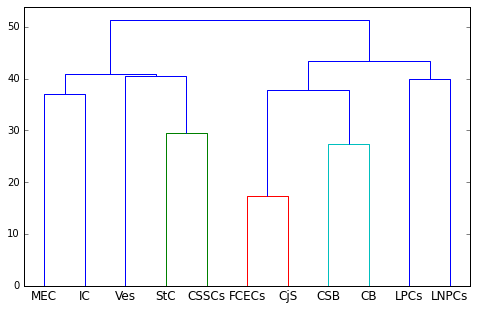

In [35]:
data3 = pd.read_csv('/ceph/rimlsfnwi/data/moldevbio/zhou/jarts/data/lako2021/motif_analysis/vst_nosplit/final.out.txt', sep='\t', header=0)
data3
import numpy as np
from pandas import *
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist


data3.index = data['Unnamed: 0']
data3
data4 = data[['z-score Ves','z-score StC','z-score MEC','z-score LPCs','z-score LNPCs','z-score IC','z-score FCECs','z-score CjS','z-score CSSCs','z-score CSB','z-score CB']]
data4
data4 = data4.rename(columns={'z-score Ves':'Ves', 'z-score StC': 'StC','z-score MEC':'MEC','z-score LPCs':'LPCs','z-score LNPCs':'LNPCs','z-score IC':'IC','z-score FCECs':'FCECs','z-score CjS':'CjS','z-score CSSCs':'CSSCs','z-score CSB':'CSB','z-score CB':'CB'})

X = data4.T.values #Transpose values 
Y = pdist(X)
Z = linkage(Y)
plt.figure(figsize=(8, 5))
dendrogram(Z, labels = data4.columns)